## Need to run:
coevolve python package (currently only installed locally in /data2/isshamie/coevolve/coevolve. Go to that folder and run pip install -e .)

1. parameters folder. The evc template is in there and the parameter file that points to the genome information (in case that changes).  
2. data/raw is the folder that contains that genome files  
3. data/notebook with this file and Covid19 - Alignment and Couplings Output.ipynb

### Parameter file (should be in parameters folder)

In [1]:
main_dir = "../"

param = 'sars_cov2.yaml'

### 0.1 Import 

In [2]:
import pandas as pd
import os
import glob
from Bio import SeqIO, Seq, pairwise2, SeqRecord, Align
from os.path import join, basename
import pickle
import numpy as np
from tqdm import tqdm
from numpanpar import parallel_ar as parar
import seaborn as sns

%load_ext autoreload
%autoreload 2

/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from config import FIGURES_DIR, ROOT_DIR, PARAMS_DIR, RESULTS, CONTACT_FIGURES_DIR, NUM_CORES
from coevolve.msa import clustalw_query
from coevolve.config import CLUSTALW_DIR, CLUSTALW_CMD, CLUSTALW_CLEAN_DIR
from evcouplings.utils import read_config_file, write_config_file
from coevolve.couplings.running_jobs_complexes import run_evc
from coevolve.couplings.couplings_vis import construct_monomer_contact_matrix
from coevolve.data.data_io import read_msa

Project Directory: /data2/isshamie/covid/covid_03302020

Config paths:
__name__ config
__package__ 
__file__ /data2/isshamie/covid/covid_03302020/notebook/config.py
__cached__ /data2/isshamie/covid/covid_03302020/notebook/__pycache__/config.cpython-37.pyc
path /data2/isshamie/covid/covid_03302020/notebook/config.py
DATA_DIR /data2/isshamie/covid/covid_03302020/data
RESULTS /data2/isshamie/covid/covid_03302020/data/processed
FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures
CONTACT_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/contact
PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/pair_couplings
GLYCO_PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
PARAMS_DIR /data2/isshamie/covid/covid_03302020/parameters
d /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
UNIPROT_MAP /data2/isshamie/covid/covid_03302020/data/external/biomart/mart_export_uniprot.txt
GENE_MAP /data2/isshamie

### Setup folders and files

In [4]:
RAW = join(main_dir,"data","raw")
outdir = join(main_dir,"data","processed")


seqs_dir = join(outdir,"seqs")
align_dir = join(seqs_dir,"S_protein_align")
align_concat_dir = join(seqs_dir,"S_protein_align_full")
msa_out = join(outdir, "msa")
anno_f = join(outdir, "covid_annotations.csv")
ev_dir = join(outdir,"evc")
contact_dir = join(outdir, "contact")
ev_params_dir = join(outdir,"ev_params")
evzoom_dir = join(outdir,"evzoom")
evzoom_template_dir = join(ROOT_DIR, "software", "EVzoom")
param_dir = join(main_dir,"parameters")
evc_template_f = join(param_dir,'evc',"template.yaml")

msa_f = join(msa_out,"S_protein.msa.fasta")
if not os.path.exists(msa_out):
    os.mkdir(msa_out)
anno_f = join(seqs_dir, "covid_annotations.csv")
clean = join(msa_out,"clean")
if not os.path.exists(clean):
    os.mkdir(clean)

#clustalw_query.create_clean_clustalw_names(clean, [msa_f])

msa_clean_f = join(clean, os.path.basename(msa_f))

NUM_CORES = 32
if not os.path.exists(outdir):
    os.mkdir(outdir)

if not os.path.exists(seqs_dir):
    os.mkdir(seqs_dir)
if not os.path.exists(align_dir):
    os.mkdir(align_dir)
    
if not os.path.exists(align_concat_dir):
    os.mkdir(align_concat_dir)
    
if not os.path.exists(msa_out):
    os.mkdir(msa_out)
    
if not os.path.exists(ev_dir):
    os.mkdir(ev_dir)
    
if not os.path.exists(ev_params_dir):
    os.mkdir(ev_params_dir)
    
if not os.path.exists(param_dir):
    os.mkdir(param_dir)
    
if not os.path.exists(evzoom_dir):
    cmd = f'cp -r {evzoom_template_dir} {evzoom_dir}'
    print(cmd)
    os.system(cmd)

if not os.path.exists(contact_dir):
    os.mkdir(contact_dir)
    

## 1. Load:
- A) Genomic fasta sequences, 
- B) Reference Genomic Annotation (GCF_009858895.2)
- C) Reference Gene Annotation (NC_045512.2)
- D) S-protein fasta protein sequence

In [5]:
config = read_config_file(join(param_dir, param))
config

{'name': 'sars_cov2',
 'ref_fasta': 'NC_045512.2.fasta',
 'genomes_fasta': '2020-03-30-gisaid-seqs.fasta',
 'S_protein_name': 'YP_009724390.1',
 'annotation': 'GCF_009858895.2_ASM985889v3_genomic.gff'}

In [6]:
# ref_fasta = SeqIO.read(os.path.join(RAW,'NC_045512.2.fasta'), format="fasta")
# anno = pd.read_csv(glob.glob(RAW+"/*.gff")[0],sep="\t", comment="#", header=None)
# all_genomic_sequences = list(SeqIO.parse(os.path.join(RAW,"gisaid_cov2020_sequences.fasta"), "fasta"))

# S_protein_name = "YP_009724390.1"
# S_protein_fasta = SeqIO.read(os.path.join(RAW, S_protein_name+".fasta"),format='fasta')
# S_protein_fasta = str(S_protein_fasta.seq)


ref_fasta = SeqIO.read(os.path.join(RAW,config['ref_fasta']), format="fasta")
anno = pd.read_csv(join(RAW,config['annotation']),sep="\t", comment="#", header=None)
all_genomic_sequences = list(SeqIO.parse(os.path.join(RAW,config["genomes_fasta"]), "fasta"))

S_protein_name = config['S_protein_name']
S_protein_fasta = SeqIO.read(os.path.join(RAW, S_protein_name+".fasta"),format='fasta')
S_protein_fasta = str(S_protein_fasta.seq)


## 2. Preprocess

### a. Filter annotation for the S-protein.
Confirm the protein sequence aligns with the genome annotation.
- Extract the genomic region from annotation and take the sequence
- Translate sequence
- See if aligns with the Protein fasta sequence



See below that there are no introns,  so we can just use that sequence

In [7]:
anno_S = anno[anno[8].str.contains(S_protein_name)]

#Extract protein sequence from this region
S_gene_seq = ref_fasta.seq[anno_S[3].values[0]-1: anno_S[4].values[0]]
annotation_protein_sequence = str(Seq.translate(S_gene_seq))
annotation_protein_sequence = annotation_protein_sequence.replace("*","")

S_gene_seq = SeqRecord.SeqRecord(S_gene_seq, id=S_protein_name)
SeqIO.write(S_gene_seq, open(join(seqs_dir,"S_gene.fasta"),'w'),format='fasta')

1

In [8]:
annotation_protein_mismatch = []
for ind, val in enumerate(annotation_protein_sequence):
    if S_protein_fasta[ind] != val:
        annotation_protein_mismatch.append((ind, val))
annotation_protein_mismatch

[]

### b. remove any sequence less than 29kb

In [9]:
print(f"Number of sequences before filtering: {len(all_genomic_sequences)}")
all_genomic_sequences_filt = []
for seq in all_genomic_sequences:
    if len(seq.seq) >= 29000:
        all_genomic_sequences_filt.append(seq)
print(f"Number of sequences after filtering for at least 29kb: {len(all_genomic_sequences_filt)}")

Number of sequences before filtering: 2909
Number of sequences after filtering for at least 29kb: 2794


### c. Remove duplicates

In [10]:
inds_to_remove = []
curr_seqs = []

for ind,seq in enumerate(all_genomic_sequences_filt):
    if str(seq.seq) in curr_seqs:
        inds_to_remove.append(seq.id)
    else:
        curr_seqs.append(str(seq.seq))

all_genomic_sequences_filt = list(filter(lambda x: x.id not in inds_to_remove, all_genomic_sequences_filt))
print(f"Number of sequences after removing duplicate sequences: {len(all_genomic_sequences_filt)}")


Number of sequences after removing duplicate sequences: 2463


In [11]:
# len(all_genomic_sequences_filt)
# len(inds_to_remove)

# len(all_genomic_sequences_filt)

In [12]:
# for s in all_genomic_sequences_filt:
#     if s.id=='hCoV-19/USA/WA-S92/2020|EPI_ISL_417145|2020-02-29':
#         a = s
#     elif s.id == 'hCoV-19/USA/WA-S93/2020|EPI_ISL_417146|2020-02-29':
#         b = s

# ids = [seq.id for seq in all_genomic_sequences_filt]
# print(len(ids))
# print(len(set(ids)))


### d. Currently keeping animals 

In [13]:
animal_viruses = list(filter(lambda x: "pangolin" in x.id or "bat" in x.id, all_genomic_sequences_filt))
animal_viruses

[SeqRecord(seq=Seq('TTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTAT...TTC', SingleLetterAlphabet()), id='hCoV-19/pangolin/Guangdong/P2S/2019|EPI_ISL_410544|2019', name='hCoV-19/pangolin/Guangdong/P2S/2019|EPI_ISL_410544|2019', description='hCoV-19/pangolin/Guangdong/P2S/2019|EPI_ISL_410544|2019', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTTTAACTTTTTACAAATCCCAGGTAGCAAAACCAACCAACTCTCGATCTCTT...TTC', SingleLetterAlphabet()), id='hCoV-19/pangolin/Guangxi/P1E/2017|EPI_ISL_410539|2017', name='hCoV-19/pangolin/Guangxi/P1E/2017|EPI_ISL_410539|2017', description='hCoV-19/pangolin/Guangxi/P1E/2017|EPI_ISL_410539|2017', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTTTAACTTTTTACAAATCCCAGGTAGCAAAACCAACCAACTCTCGATCTCTT...TTC', SingleLetterAlphabet()), id='hCoV-19/pangolin/Guangxi/P4L/2017|EPI_ISL_410538|2017', name='hCoV-19/pangolin/Guangxi/P4L/2017|EPI_ISL_410538|2017', description='hCoV-19/pangolin/Guangxi/P4L/2017|EPI_ISL_410538|2017', dbxrefs=[]),
 SeqRecord(seq=Seq('AAAACCAACCAACTCTCGATCTCTTGTAGATCTGTTCT

In [14]:
all_genomic_sequences_filt = list(filter(lambda x: not ("pangolin" in x.id or "bat" in x.id), all_genomic_sequences_filt))
print(len(all_genomic_sequences_filt))

2454


## 3. Local Alignment each sequence to the genome using Bio.pairwise2.align.localxx
## and save the alignments and the translated sequence 

In [15]:
def remove_chars(orig_str, chars = ["|",")","(","*"]):
    return orig_str.replace("|","_").replace(")","").replace("*","_").replace("(","").replace(" ","_").replace("-","_").replace("/","").replace(">","")

In [16]:
def run_local(seqs, S_gene_seq=S_gene_seq, save_dir=align_dir,to_overwrite=False):
    if not os.path.exists(save_dir):
        print(f"{save_dir} not made. Need to create it")
        return
    invalid_seqs = []
    S_align_full = dict()
    S_align_first = dict()
    S_align_first_seqs = dict() #Dictionary of the subseqeunce of the genome that locally aligned to the S gene.
    S_all_proteins = []
    count = 0
    
    for seq in tqdm(seqs):
        try:
            seq.seq= seq.seq.upper()
            seq.seq = str(seq.seq).replace("-","")
            name = remove_chars(seq.id)
            curr_out = pairwise2.align.localms(str(seq.seq),str(S_gene_seq.seq), 2, -10, -0.5, -0.1)#, one_alignment=True)
            curr_align = str(seq.seq)[curr_out[0][3]:curr_out[0][4]]

            S_all_proteins = [(SeqRecord.SeqRecord(Seq.Seq(Seq.translate(curr_align, stop_symbol="")), id=name))]
            print('s all proteins', S_all_proteins)
            print('to save', join(save_dir,name+".protein.fasta"))
            pickle.dump([curr_out,str(seq.seq)[curr_out[0][3]:curr_out[0][4]],], open(join(save_dir, name+".p"),"wb"))
            SeqIO.write(S_all_proteins, open(join(save_dir,name+".protein.fasta"),"w"),format="fasta")
        except TypeError:
            with open(join(save_dir, 'invalid_' + name + '.txt'),'w') as f:
                f.write("")
    return

In [17]:
parar(np.array(all_genomic_sequences_filt),run_local, num_processes=32)

  0%|          | 0/76 [00:00<?, ?it/s]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW212020_EPI_ISL_414369_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW212020_EPI_ISL_414369_2020_03_05.protein.fasta


  1%|▏         | 1/76 [01:16<1:36:01, 76.82s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000092020_EPI_ISL_417027_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000092020_EPI_ISL_417027_2020_03_20.protein.fasta


  1%|▏         | 1/76 [01:18<1:38:02, 78.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090525062020_EPI_ISL_417276_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090525062020_EPI_ISL_417276_2020_03_07.protein.fasta


  1%|▏         | 1/76 [01:19<1:39:09, 79.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_282020_EPI_ISL_414537_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_282020_EPI_ISL_414537_2020_03_08.protein.fasta


  1%|▏         | 1/76 [01:20<1:41:14, 81.00s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...THK'), id='hCoV_19BrazilSPBR_142020_EPI_ISL_416036_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_142020_EPI_ISL_416036_2020_03_05.protein.fasta


  1%|▏         | 1/76 [01:21<1:42:25, 81.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S882020_EPI_ISL_417141_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S882020_EPI_ISL_417141_2020_03_01.protein.fasta


  1%|▏         | 1/76 [01:22<1:42:38, 82.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19IrelandCOR_201342020_EPI_ISL_414487_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandCOR_201342020_EPI_ISL_414487_2020_03_04.protein.fasta


  1%|▏         | 1/76 [01:22<1:43:08, 82.51s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M262020_EPI_ISL_418386_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M262020_EPI_ISL_418386_2020_03_13.protein.fasta


  1%|▏         | 1/76 [01:22<1:43:38, 82.91s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillayLeon2010612020_EPI_ISL_418247_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillayLeon2010612020_EPI_ISL_418247_2020_02_26.protein.fasta


  1%|▏         | 1/76 [01:28<1:50:45, 88.60s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_32020_EPI_ISL_414437_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_32020_EPI_ISL_414437_2020_03_03.protein.fasta


  1%|▏         | 1/76 [01:34<1:58:11, 94.56s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN03032020A2020_EPI_ISL_413602_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN03032020A2020_EPI_ISL_413602_2020_03_03.protein.fasta


  1%|▏         | 1/76 [01:35<1:59:18, 95.45s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2010400812020_EPI_ISL_414525_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2010400812020_EPI_ISL_414525_2020_03_02.protein.fasta


  1%|▏         | 1/76 [01:38<2:02:34, 98.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02942020_EPI_ISL_416592_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02942020_EPI_ISL_416592_2020_02_16.protein.fasta


  1%|▏         | 1/76 [01:39<2:03:55, 99.14s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLA'), id='hCoV_19USAUT_000112020_EPI_ISL_417959_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000112020_EPI_ISL_417959_2020_03_24.protein.fasta


  1%|▏         | 1/76 [01:40<2:05:28, 100.38s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220328022020_EPI_ISL_418673_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220328022020_EPI_ISL_418673_2020_03_16.protein.fasta


  1%|▏         | 1/76 [01:41<2:06:47, 101.43s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00382020_EPI_ISL_416347_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00382020_EPI_ISL_416347_2020_02_06.protein.fasta


  1%|▏         | 1/76 [01:42<2:08:34, 102.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_LP14_32020_EPI_ISL_417975_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_LP14_32020_EPI_ISL_417975_2020_03_09.protein.fasta


  1%|▏         | 1/76 [01:46<2:12:34, 106.06s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19Iceland172020_EPI_ISL_417811_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland172020_EPI_ISL_417811_2020_03_02.protein.fasta


  1%|▏         | 1/76 [01:46<2:12:50, 106.28s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_357202020_EPI_ISL_415582_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_357202020_EPI_ISL_415582_2020_03_04.protein.fasta


  1%|▏         | 1/76 [01:46<2:12:58, 106.38s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080033022020_EPI_ISL_417248_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080033022020_EPI_ISL_417248_2020_03_03.protein.fasta


  1%|▏         | 1/76 [01:46<2:13:20, 106.67s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland1142020_EPI_ISL_417782_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1142020_EPI_ISL_417782_2020_03_11.protein.fasta


  1%|▏         | 1/76 [01:48<2:16:08, 108.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong20SF2012020_EPI_ISL_406538_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong20SF2012020_EPI_ISL_406538_2020_01_23.protein.fasta


  1%|▏         | 1/76 [01:52<2:20:41, 112.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFEAC2020_EPI_ISL_418303_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFEAC2020_EPI_ISL_418303_2020_03_25.protein.fasta


  1%|▏         | 1/76 [01:52<2:20:48, 112.65s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW062020_EPI_ISL_415435_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW062020_EPI_ISL_415435_2020_03_06.protein.fasta


  1%|▏         | 1/76 [01:54<2:22:56, 114.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00152020_EPI_ISL_413729_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00152020_EPI_ISL_413729_2020_02.protein.fasta


  1%|▏         | 1/76 [01:56<2:25:50, 116.68s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumUMF_030252020_EPI_ISL_416472_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumUMF_030252020_EPI_ISL_416472_2020_03_02.protein.fasta


  1%|▏         | 1/76 [01:57<2:26:32, 117.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00412020_EPI_ISL_418026_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00412020_EPI_ISL_418026_2020_03_17.protein.fasta


  1%|▏         | 1/76 [01:59<2:29:39, 119.73s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandCVR032020_EPI_ISL_414025_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR032020_EPI_ISL_414025_2020_03_01.protein.fasta


  1%|▏         | 1/76 [01:59<2:29:57, 119.97s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1612020_EPI_ISL_417725_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1612020_EPI_ISL_417725_2020_03_14.protein.fasta


  1%|▏         | 1/76 [02:02<2:32:52, 122.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090503062020_EPI_ISL_417264_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090503062020_EPI_ISL_417264_2020_03_04.protein.fasta


  1%|▏         | 1/76 [02:06<2:38:29, 126.79s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S892020_EPI_ISL_417142_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S892020_EPI_ISL_417142_2020_02_29.protein.fasta


  3%|▎         | 2/76 [02:35<1:38:08, 79.58s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SlovakiaSK_BMC52020_EPI_ISL_417879_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SlovakiaSK_BMC52020_EPI_ISL_417879_2020_03_06.protein.fasta


  3%|▎         | 2/76 [02:37<1:36:05, 77.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW272020_EPI_ISL_417390_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW272020_EPI_ISL_417390_2020_03_08.protein.fasta


  3%|▎         | 2/76 [02:41<1:43:23, 83.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUC_CDPH_UC112020_EPI_ISL_413931_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUC_CDPH_UC112020_EPI_ISL_413931_2020_03_05.protein.fasta


  3%|▎         | 2/76 [02:41<1:40:41, 81.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHLH64152020_EPI_ISL_418357_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHLH64152020_EPI_ISL_418357_2020_03_12.protein.fasta


  3%|▎         | 2/76 [02:42<1:38:42, 80.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1262020_EPI_ISL_416664_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1262020_EPI_ISL_416664_2020_03_12.protein.fasta


  3%|▎         | 2/76 [02:42<1:40:49, 81.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240129022020_EPI_ISL_418699_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240129022020_EPI_ISL_418699_2020_03_18.protein.fasta


  3%|▎         | 2/76 [02:47<1:42:24, 83.04s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E852020_EPI_ISL_418122_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E852020_EPI_ISL_418122_2020_03_13.protein.fasta


  3%|▎         | 2/76 [02:47<1:41:11, 82.05s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1802020_EPI_ISL_416718_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1802020_EPI_ISL_416718_2020_03_14.protein.fasta


  3%|▎         | 2/76 [02:48<1:42:28, 83.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1622020_EPI_ISL_416700_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1622020_EPI_ISL_416700_2020_03_13.protein.fasta


  3%|▎         | 2/76 [02:55<1:53:12, 91.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080046022020_EPI_ISL_417249_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080046022020_EPI_ISL_417249_2020_03_03.protein.fasta


  3%|▎         | 2/76 [02:58<1:58:32, 96.12s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZeewolde_13650802020_EPI_ISL_413591_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZeewolde_13650802020_EPI_ISL_413591_2020_03_02.protein.fasta


  3%|▎         | 2/76 [02:59<1:55:55, 93.99s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_82020_EPI_ISL_415497_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_82020_EPI_ISL_415497_2020_03_09.protein.fasta


  3%|▎         | 2/76 [03:00<1:57:25, 95.21s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2422020_EPI_ISL_417456_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2422020_EPI_ISL_417456_2020_03_14.protein.fasta


  3%|▎         | 2/76 [03:08<2:05:09, 101.48s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...VKS'), id='hCoV_19CongoKN_00722020_EPI_ISL_417442_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00722020_EPI_ISL_417442_2020_03_18.protein.fasta


  3%|▎         | 2/76 [03:10<1:59:33, 96.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA7_UW42020_EPI_ISL_413458_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA7_UW42020_EPI_ISL_413458_2020_03_01.protein.fasta


  3%|▎         | 2/76 [03:11<2:03:16, 99.96s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1482020_EPI_ISL_416686_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1482020_EPI_ISL_416686_2020_03_14.protein.fasta


  3%|▎         | 2/76 [03:12<2:10:28, 105.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangzhou20SF2062020_EPI_ISL_406533_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangzhou20SF2062020_EPI_ISL_406533_2020_01_22.protein.fasta


  3%|▎         | 2/76 [03:17<2:08:46, 104.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW392020_EPI_ISL_416456_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW392020_EPI_ISL_416456_2020_03_06.protein.fasta


  3%|▎         | 2/76 [03:21<2:08:15, 103.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF22342020_EPI_ISL_416495_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF22342020_EPI_ISL_416495_2020_03_10.protein.fasta


  3%|▎         | 2/76 [03:29<2:07:37, 103.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00402020_EPI_ISL_418025_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00402020_EPI_ISL_418025_2020_03_17.protein.fasta


  3%|▎         | 2/76 [03:31<2:17:15, 111.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_13636282020_EPI_ISL_413589_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_13636282020_EPI_ISL_413589_2020_03_01.protein.fasta


  3%|▎         | 2/76 [03:31<2:05:05, 101.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIPBCAMS_WH_022019_EPI_ISL_403931_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIPBCAMS_WH_022019_EPI_ISL_403931_2019_12_30.protein.fasta


  3%|▎         | 2/76 [03:38<2:18:34, 112.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D882020_EPI_ISL_418112_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D882020_EPI_ISL_418112_2020_03_13.protein.fasta


  3%|▎         | 2/76 [03:40<2:23:57, 116.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2882020_EPI_ISL_417616_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2882020_EPI_ISL_417616_2020_03_18.protein.fasta


  3%|▎         | 2/76 [03:40<2:17:54, 111.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland842020_EPI_ISL_417761_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland842020_EPI_ISL_417761_2020_03_10.protein.fasta


  3%|▎         | 2/76 [03:40<2:14:04, 108.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S872020_EPI_ISL_417140_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S872020_EPI_ISL_417140_2020_03_01.protein.fasta


  4%|▍         | 3/76 [03:53<1:36:03, 78.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19England201020001062020_EPI_ISL_415144_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020001062020_EPI_ISL_415144_2020_02_27.protein.fasta


  3%|▎         | 2/76 [03:53<2:24:10, 116.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW282020_EPI_ISL_417391_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW282020_EPI_ISL_417391_2020_03_08.protein.fasta


  4%|▍         | 3/76 [03:55<1:38:19, 80.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19England201240950022020_EPI_ISL_418727_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240950022020_EPI_ISL_418727_2020_03_13.protein.fasta


  4%|▍         | 3/76 [03:58<1:35:55, 78.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LEL'), id='hCoV_19USACA_CDPH_UC52020_EPI_ISL_413922_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC52020_EPI_ISL_413922_2020_03_05.protein.fasta


  4%|▍         | 3/76 [04:00<1:38:18, 80.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2192020_EPI_ISL_417368_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2192020_EPI_ISL_417368_2020_03_13.protein.fasta


  4%|▍         | 3/76 [04:07<1:39:55, 82.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01102020_EPI_ISL_416399_2020_02_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01102020_EPI_ISL_416399_2020_02_13.protein.fasta


  4%|▍         | 3/76 [04:07<1:47:19, 88.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1312020_EPI_ISL_416669_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1312020_EPI_ISL_416669_2020_03_11.protein.fasta


  4%|▍         | 3/76 [04:11<1:41:57, 83.80s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('TLLLVIYYINALRAFQLHLLTMLLFKLSNPVILTKTSMTLLCLRVSLRKEVLLN...IFT'), id='hCoV_19Iceland852020_EPI_ISL_417869_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland852020_EPI_ISL_417869_2020_03_10.protein.fasta


  1%|▏         | 1/76 [04:13<5:16:53, 253.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1772020_EPI_ISL_416715_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1772020_EPI_ISL_416715_2020_03_15.protein.fasta


  4%|▍         | 3/76 [04:15<1:42:28, 84.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009910762020_EPI_ISL_414524_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009910762020_EPI_ISL_414524_2020_03_01.protein.fasta


  4%|▍         | 3/76 [04:17<1:48:09, 88.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN46_MDH462020_EPI_ISL_417493_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN46_MDH462020_EPI_ISL_417493_2020_03_13.protein.fasta


  4%|▍         | 3/76 [04:17<1:43:02, 84.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23F462020_EPI_ISL_418129_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23F462020_EPI_ISL_418129_2020_03_15.protein.fasta


  4%|▍         | 3/76 [04:25<1:45:29, 86.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_NH52020_EPI_ISL_418774_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_NH52020_EPI_ISL_418774_2020_03_13.protein.fasta


  4%|▍         | 3/76 [04:25<1:49:52, 90.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS62828452020_EPI_ISL_417533_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS62828452020_EPI_ISL_417533_2020_03_18.protein.fasta


  4%|▍         | 3/76 [04:36<2:00:42, 99.22s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanNTU032020_EPI_ISL_413592_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanNTU032020_EPI_ISL_413592_2020_03_02.protein.fasta


  4%|▍         | 3/76 [04:38<1:56:19, 95.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Foshan20SF2072020_EPI_ISL_406534_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Foshan20SF2072020_EPI_ISL_406534_2020_01_22.protein.fasta


  4%|▍         | 3/76 [04:41<1:59:34, 98.29s/it] /home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00392020_EPI_ISL_418024_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00392020_EPI_ISL_418024_2020_03_17.protein.fasta


  4%|▍         | 3/76 [04:45<2:01:48, 100.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1932020_EPI_ISL_417342_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1932020_EPI_ISL_417342_2020_03_13.protein.fasta


  4%|▍         | 3/76 [04:57<2:00:18, 98.88s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSK'), id='hCoV_19England201100008062020_EPI_ISL_417303_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100008062020_EPI_ISL_417303_2020_03_05.protein.fasta


  4%|▍         | 3/76 [05:02<2:05:23, 103.06s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Hungary22020_EPI_ISL_418183_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Hungary22020_EPI_ISL_418183_2020_03_17.protein.fasta


  4%|▍         | 3/76 [05:03<2:06:33, 104.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandEDB0082020_EPI_ISL_415635_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0082020_EPI_ISL_415635_2020_03_09.protein.fasta


  4%|▍         | 3/76 [05:03<2:06:03, 103.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFE9D2020_EPI_ISL_418302_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE9D2020_EPI_ISL_418302_2020_03_24.protein.fasta


  4%|▍         | 3/76 [05:04<2:08:52, 105.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN1_MDH12020_EPI_ISL_414588_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN1_MDH12020_EPI_ISL_414588_2020_03_05.protein.fasta


  4%|▍         | 3/76 [05:07<2:07:14, 104.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC62020_EPI_ISL_413924_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC62020_EPI_ISL_413924_2020_03_05.protein.fasta


  5%|▌         | 4/76 [05:11<1:33:33, 77.96s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421774342020_EPI_ISL_418435_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421774342020_EPI_ISL_418435_2020_03_05.protein.fasta


  1%|▏         | 1/76 [05:12<6:31:08, 312.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S902020_EPI_ISL_417143_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S902020_EPI_ISL_417143_2020_02_29.protein.fasta


  5%|▌         | 4/76 [05:14<1:35:28, 79.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19VietnamCM2962020_EPI_ISL_416431_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19VietnamCM2962020_EPI_ISL_416431_2020_03_06.protein.fasta


  4%|▍         | 3/76 [05:26<2:11:13, 107.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP06452020_EPI_ISL_416612_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06452020_EPI_ISL_416612_2020_02_17.protein.fasta


  4%|▍         | 3/76 [05:27<2:08:25, 105.56s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090504062020_EPI_ISL_417265_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090504062020_EPI_ISL_417265_2020_03_08.protein.fasta


  4%|▍         | 3/76 [05:28<2:19:00, 114.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009907242020_EPI_ISL_414006_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009907242020_EPI_ISL_414006_2020_02_28.protein.fasta


  5%|▌         | 4/76 [05:28<1:38:25, 82.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW202020_EPI_ISL_414368_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW202020_EPI_ISL_414368_2020_03_05.protein.fasta


  5%|▌         | 4/76 [05:32<1:39:59, 83.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201061459032020_EPI_ISL_417246_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201061459032020_EPI_ISL_417246_2020_03_03.protein.fasta


  5%|▌         | 4/76 [05:34<1:45:20, 87.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL01422020_EPI_ISL_418341_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL01422020_EPI_ISL_418341_2020_03_12.protein.fasta


  5%|▌         | 4/76 [05:39<1:40:33, 83.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP03442020_EPI_ISL_416596_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP03442020_EPI_ISL_416596_2020_02_16.protein.fasta


  5%|▌         | 4/76 [05:40<1:42:45, 85.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_082020_EPI_ISL_416473_2020_01_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_082020_EPI_ISL_416473_2020_01_26.protein.fasta


  4%|▍         | 3/76 [05:47<2:21:08, 116.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_302020_EPI_ISL_414539_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_302020_EPI_ISL_414539_2020_03_08.protein.fasta


  5%|▌         | 4/76 [05:48<1:43:57, 86.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLux12020_EPI_ISL_413593_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLux12020_EPI_ISL_413593_2020_02_29.protein.fasta


  5%|▌         | 4/76 [05:49<1:45:44, 88.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23F192020_EPI_ISL_418128_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23F192020_EPI_ISL_418128_2020_03_15.protein.fasta


  5%|▌         | 4/76 [05:53<1:44:44, 87.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1632020_EPI_ISL_416701_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1632020_EPI_ISL_416701_2020_03_13.protein.fasta


  5%|▌         | 4/76 [05:54<1:49:48, 91.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19Senegal1022020_EPI_ISL_418214_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal1022020_EPI_ISL_418214_2020_03_12.protein.fasta


  5%|▌         | 4/76 [05:55<1:47:40, 89.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Foshan20SF2102020_EPI_ISL_406535_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Foshan20SF2102020_EPI_ISL_406535_2020_01_22.protein.fasta


  5%|▌         | 4/76 [06:04<1:52:22, 93.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGL'), id='hCoV_19England201240358022020_EPI_ISL_418715_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240358022020_EPI_ISL_418715_2020_03_17.protein.fasta


  3%|▎         | 2/76 [06:14<4:23:33, 213.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201200021022020_EPI_ISL_418672_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201200021022020_EPI_ISL_418672_2020_03_15.protein.fasta


  5%|▌         | 4/76 [06:15<1:51:00, 92.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00382020_EPI_ISL_418023_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00382020_EPI_ISL_418023_2020_03_17.protein.fasta


  5%|▌         | 4/76 [06:17<1:57:17, 97.74s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2852020_EPI_ISL_417613_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2852020_EPI_ISL_417613_2020_03_17.protein.fasta


  5%|▌         | 4/76 [06:18<1:53:06, 94.26s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1322020_EPI_ISL_417787_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1322020_EPI_ISL_417787_2020_03_12.protein.fasta


  5%|▌         | 4/76 [06:24<1:56:16, 96.90s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1042020_EPI_ISL_417538_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1042020_EPI_ISL_417538_2020_03_17.protein.fasta


  5%|▌         | 4/76 [06:25<2:02:34, 102.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S912020_EPI_ISL_417144_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S912020_EPI_ISL_417144_2020_03_02.protein.fasta


  7%|▋         | 5/76 [06:36<1:35:12, 80.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC72020_EPI_ISL_413925_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC72020_EPI_ISL_413925_2020_03_05.protein.fasta


  7%|▋         | 5/76 [06:36<1:34:46, 80.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1762020_EPI_ISL_417812_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1762020_EPI_ISL_417812_2020_03_14.protein.fasta


  5%|▌         | 4/76 [06:39<2:01:30, 101.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S512020_EPI_ISL_417104_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S512020_EPI_ISL_417104_2020_03_03.protein.fasta


  3%|▎         | 2/76 [06:40<5:02:22, 245.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFF212020_EPI_ISL_418309_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF212020_EPI_ISL_418309_2020_03_25.protein.fasta


  5%|▌         | 4/76 [06:41<2:03:53, 103.25s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_132020_EPI_ISL_417516_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_132020_EPI_ISL_417516_2020_03_26.protein.fasta


  7%|▋         | 5/76 [06:45<1:35:16, 80.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_024212020_EPI_ISL_415581_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_024212020_EPI_ISL_415581_2020_03_01.protein.fasta


  5%|▌         | 4/76 [06:49<2:00:39, 100.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIPBCAMS_WH_032019_EPI_ISL_403930_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIPBCAMS_WH_032019_EPI_ISL_403930_2019_12_30.protein.fasta


  5%|▌         | 4/76 [06:57<2:08:35, 107.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090536062020_EPI_ISL_417279_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090536062020_EPI_ISL_417279_2020_03_07.protein.fasta


  7%|▋         | 5/76 [07:05<1:37:48, 82.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1782020_EPI_ISL_416716_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1782020_EPI_ISL_416716_2020_03_13.protein.fasta


  7%|▋         | 5/76 [07:09<1:40:31, 84.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240127022020_EPI_ISL_418698_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240127022020_EPI_ISL_418698_2020_03_17.protein.fasta


  7%|▋         | 5/76 [07:09<1:40:41, 85.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_NH42020_EPI_ISL_418773_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_NH42020_EPI_ISL_418773_2020_03_13.protein.fasta


  7%|▋         | 5/76 [07:10<1:42:48, 86.88s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...DLF'), id='hCoV_19Iceland752020_EPI_ISL_417726_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland752020_EPI_ISL_417726_2020_03_09.protein.fasta


  3%|▎         | 2/76 [07:11<3:40:01, 178.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGR30432020_EPI_ISL_415699_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGR30432020_EPI_ISL_415699_2020_02_27.protein.fasta


  7%|▋         | 5/76 [07:14<1:45:23, 89.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid2014422020_EPI_ISL_417010_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid2014422020_EPI_ISL_417010_2020_03_04.protein.fasta


  7%|▋         | 5/76 [07:19<1:44:48, 88.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D792020_EPI_ISL_418111_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D792020_EPI_ISL_418111_2020_03_13.protein.fasta


  5%|▌         | 4/76 [07:20<2:16:19, 113.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_102020_EPI_ISL_414442_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_102020_EPI_ISL_414442_2020_03_03.protein.fasta


  7%|▋         | 5/76 [07:21<1:45:49, 89.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080032022020_EPI_ISL_417247_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080032022020_EPI_ISL_417247_2020_03_02.protein.fasta


  7%|▋         | 5/76 [07:23<1:51:24, 94.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201001221072020_EPI_ISL_415143_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201001221072020_EPI_ISL_415143_2020_03_02.protein.fasta


  5%|▌         | 4/76 [07:25<2:12:56, 110.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19ShandongLY0012020_EPI_ISL_414934_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0012020_EPI_ISL_414934_2020_01_21.protein.fasta


  3%|▎         | 2/76 [07:32<3:34:31, 173.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1982020_EPI_ISL_417347_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1982020_EPI_ISL_417347_2020_03_12.protein.fasta


  7%|▋         | 5/76 [07:32<1:44:02, 87.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW152020_EPI_ISL_417383_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW152020_EPI_ISL_417383_2020_03_03.protein.fasta


  7%|▋         | 5/76 [07:33<1:50:38, 93.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2442020_EPI_ISL_418029_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2442020_EPI_ISL_418029_2020_03_16.protein.fasta


  7%|▋         | 5/76 [07:35<1:48:44, 91.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ScotlandCVR052020_EPI_ISL_414027_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR052020_EPI_ISL_414027_2020_03_04.protein.fasta


  7%|▋         | 5/76 [07:36<1:49:52, 92.86s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S962020_EPI_ISL_417149_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S962020_EPI_ISL_417149_2020_02_28.protein.fasta


  8%|▊         | 6/76 [07:47<1:30:22, 77.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_142020_EPI_ISL_415470_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_142020_EPI_ISL_415470_2020_03_10.protein.fasta


  7%|▋         | 5/76 [07:48<1:54:33, 96.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S562020_EPI_ISL_417109_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S562020_EPI_ISL_417109_2020_03_05.protein.fasta


  4%|▍         | 3/76 [08:06<4:00:12, 197.43s/it]

s all proteins [SeqRecord(seq=Seq('MALSHLSILKDLSAPVVYVIDVPHAFPLLQTLMPVGIILLDLITSIIRLLMFNN...LWI'), id='hCoV_19Switzerland421693102020_EPI_ISL_418275_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421693102020_EPI_ISL_418275_2020_02_27.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2862020_EPI_ISL_417614_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2862020_EPI_ISL_417614_2020_03_18.protein.fasta


  5%|▌         | 4/76 [08:08<2:39:03, 132.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009405272020_EPI_ISL_414005_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009405272020_EPI_ISL_414005_2020_02_25.protein.fasta


  8%|▊         | 6/76 [08:08<1:34:46, 81.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW622020_EPI_ISL_415627_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW622020_EPI_ISL_415627_2020_03_09.protein.fasta


  7%|▋         | 5/76 [08:09<1:56:00, 98.04s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_85322020_EPI_ISL_418635_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_85322020_EPI_ISL_418635_2020_03_19.protein.fasta


  7%|▋         | 5/76 [08:14<1:59:11, 100.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LQI'), id='hCoV_19USACA_CDPH_UC82020_EPI_ISL_413926_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC82020_EPI_ISL_413926_2020_03_05.protein.fasta


  8%|▊         | 6/76 [08:15<1:39:53, 85.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SSQ'), id='hCoV_19England201240357022020_EPI_ISL_418714_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240357022020_EPI_ISL_418714_2020_03_17.protein.fasta


  4%|▍         | 3/76 [08:18<3:47:24, 186.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23EFE2020_EPI_ISL_418127_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23EFE2020_EPI_ISL_418127_2020_03_15.protein.fasta


  8%|▊         | 6/76 [08:20<1:33:31, 80.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP03112020_EPI_ISL_416593_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB16232020_EPI_ISL_418219_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP03112020_EPI_ISL_416593_2020_02_16.protein.fasta
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB16232020_EPI_ISL_418219_2020_02_26.protein.fasta


  8%|▊         | 6/76 [08:26<1:36:29, 82.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland672020_EPI_ISL_417723_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland672020_EPI_ISL_417723_2020_03_08.protein.fasta


  4%|▍         | 3/76 [08:37<3:03:27, 150.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1812020_EPI_ISL_416719_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1812020_EPI_ISL_416719_2020_03_14.protein.fasta


  8%|▊         | 6/76 [08:38<1:40:36, 86.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF24962020_EPI_ISL_418231_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF24962020_EPI_ISL_418231_2020_03_15.protein.fasta


  8%|▊         | 6/76 [08:40<1:40:06, 85.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19Iceland1912020_EPI_ISL_417762_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1912020_EPI_ISL_417762_2020_03_16.protein.fasta


  7%|▋         | 5/76 [08:41<2:03:01, 103.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN47_MDH472020_EPI_ISL_417494_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN47_MDH472020_EPI_ISL_417494_2020_03_13.protein.fasta


  8%|▊         | 6/76 [08:43<1:41:50, 87.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E3A2020_EPI_ISL_418118_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E3A2020_EPI_ISL_418118_2020_03_13.protein.fasta


  7%|▋         | 5/76 [08:51<2:06:18, 106.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW082020_EPI_ISL_413594_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW082020_EPI_ISL_413594_2020_02_28.protein.fasta


  8%|▊         | 6/76 [08:52<1:44:45, 89.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201221192022020_EPI_ISL_418679_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201221192022020_EPI_ISL_418679_2020_03_17.protein.fasta


  8%|▊         | 6/76 [08:56<1:41:13, 86.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShenzhenSZTH_0032020_EPI_ISL_406594_2020_01_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenSZTH_0032020_EPI_ISL_406594_2020_01_16.protein.fasta


  8%|▊         | 6/76 [08:56<1:49:28, 93.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19England201240949022020_EPI_ISL_418726_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240949022020_EPI_ISL_418726_2020_03_13.protein.fasta


  8%|▊         | 6/76 [08:57<1:48:45, 93.22s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_162020_EPI_ISL_415472_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_162020_EPI_ISL_415472_2020_03_11.protein.fasta


  8%|▊         | 6/76 [08:57<1:43:08, 88.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanAI_I_0042020_EPI_ISL_407084_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanAI_I_0042020_EPI_ISL_407084_2020_01_25.protein.fasta


  7%|▋         | 5/76 [08:58<2:11:23, 111.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S942020_EPI_ISL_417147_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S942020_EPI_ISL_417147_2020_02_28.protein.fasta


  9%|▉         | 7/76 [09:07<1:30:09, 78.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_SCCPHD_UC162020_EPI_ISL_417320_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_SCCPHD_UC162020_EPI_ISL_417320_2020_03_04.protein.fasta


  7%|▋         | 5/76 [09:12<2:09:38, 109.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2432020_EPI_ISL_418028_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2432020_EPI_ISL_418028_2020_03_13.protein.fasta


  8%|▊         | 6/76 [09:13<1:49:05, 93.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN03032020B2020_EPI_ISL_413603_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN03032020B2020_EPI_ISL_413603_2020_03_03.protein.fasta


  4%|▍         | 3/76 [09:14<3:05:19, 152.32s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SVL'), id='hCoV_19NetherlandsZuidHolland_62020_EPI_ISL_414466_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_62020_EPI_ISL_414466_2020_03_04.protein.fasta


  3%|▎         | 2/76 [09:16<4:18:09, 209.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_172020_EPI_ISL_417517_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_172020_EPI_ISL_417517_2020_03_26.protein.fasta


  9%|▉         | 7/76 [09:20<1:30:12, 78.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S542020_EPI_ISL_417107_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S542020_EPI_ISL_417107_2020_03_05.protein.fasta


  5%|▌         | 4/76 [09:29<3:15:53, 163.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_MG09872020_EPI_ISL_416457_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_MG09872020_EPI_ISL_416457_2020_03_18.protein.fasta


  8%|▊         | 6/76 [09:37<1:51:13, 95.33s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RML'), id='hCoV_19Iceland112020_EPI_ISL_417539_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland112020_EPI_ISL_417539_2020_03_16.protein.fasta


  8%|▊         | 6/76 [09:37<1:58:11, 101.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2802020_EPI_ISL_417608_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2802020_EPI_ISL_417608_2020_03_17.protein.fasta


  8%|▊         | 6/76 [09:42<1:53:55, 97.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLS'), id='hCoV_19CongoKN_00602020_EPI_ISL_417440_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00602020_EPI_ISL_417440_2020_03_17.protein.fasta


  9%|▉         | 7/76 [09:43<1:34:06, 81.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland822020_EPI_ISL_417867_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland822020_EPI_ISL_417867_2020_03_09.protein.fasta


  5%|▌         | 4/76 [09:45<3:08:19, 156.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_6832020_EPI_ISL_416750_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_6832020_EPI_ISL_416750_2020_03_06.protein.fasta


  9%|▉         | 7/76 [09:49<1:33:48, 81.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23EEF2020_EPI_ISL_418126_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23EEF2020_EPI_ISL_418126_2020_03_15.protein.fasta


  9%|▉         | 7/76 [09:49<1:35:17, 82.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL10832020_EPI_ISL_418340_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL10832020_EPI_ISL_418340_2020_03_09.protein.fasta


  9%|▉         | 7/76 [09:53<1:34:25, 82.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF0372_isl2020_EPI_ISL_410720_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF0372_isl2020_EPI_ISL_410720_2020_01_23.protein.fasta


  9%|▉         | 7/76 [09:55<1:37:19, 84.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC92020_EPI_ISL_413928_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC92020_EPI_ISL_413928_2020_03_05.protein.fasta


  9%|▉         | 7/76 [10:02<1:45:50, 92.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW182020_EPI_ISL_417384_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW182020_EPI_ISL_417384_2020_03_05.protein.fasta


  9%|▉         | 7/76 [10:04<1:37:45, 85.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_418512020_EPI_ISL_415584_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_418512020_EPI_ISL_415584_2020_03_02.protein.fasta


  8%|▊         | 6/76 [10:04<1:53:57, 97.68s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1592020_EPI_ISL_417806_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1592020_EPI_ISL_417806_2020_03_13.protein.fasta


  8%|▊         | 6/76 [10:07<2:01:17, 103.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUPHL_012020_EPI_ISL_415539_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUPHL_012020_EPI_ISL_415539_2020_03_13.protein.fasta


  5%|▌         | 4/76 [10:09<2:39:39, 133.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E2B2020_EPI_ISL_418117_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E2B2020_EPI_ISL_418117_2020_03_14.protein.fasta


  8%|▊         | 6/76 [10:09<1:54:34, 98.20s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00072020_EPI_ISL_416320_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00072020_EPI_ISL_416320_2020_01_28.protein.fasta


  9%|▉         | 7/76 [10:13<1:37:25, 84.71s/it]

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...XXX'), id='hCoV_19BrazilSP01102020_EPI_ISL_417943_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSP01102020_EPI_ISL_417943_2020_03_17.protein.fasta


  5%|▌         | 4/76 [10:19<3:13:47, 161.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07432020_EPI_ISL_416621_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07432020_EPI_ISL_416621_2020_02_17.protein.fasta


  9%|▉         | 7/76 [10:22<1:43:16, 89.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SlovakiaSK_BMC12020_EPI_ISL_417877_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SlovakiaSK_BMC12020_EPI_ISL_417877_2020_03_06.protein.fasta


  9%|▉         | 7/76 [10:28<1:46:35, 92.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Nonthaburi612020_EPI_ISL_403962_2020_01_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Nonthaburi612020_EPI_ISL_403962_2020_01_08.protein.fasta


  8%|▊         | 6/76 [10:34<2:04:33, 106.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S952020_EPI_ISL_417148_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S952020_EPI_ISL_417148_2020_02_28.protein.fasta


 11%|█         | 8/76 [10:36<1:32:17, 81.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ShenzhenSZTH_0042020_EPI_ISL_406595_2020_01_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenSZTH_0042020_EPI_ISL_406595_2020_01_16.protein.fasta


  9%|▉         | 7/76 [10:36<1:49:52, 95.55s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SQL'), id='hCoV_19EnglandSHEF_BFF122020_EPI_ISL_418308_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF122020_EPI_ISL_418308_2020_03_25.protein.fasta


  7%|▋         | 5/76 [10:40<2:50:28, 144.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19USAWA_UW1992020_EPI_ISL_417348_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1992020_EPI_ISL_417348_2020_03_13.protein.fasta


  9%|▉         | 7/76 [10:47<1:47:59, 93.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN03032020C2020_EPI_ISL_413604_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN03032020C2020_EPI_ISL_413604_2020_03_03.protein.fasta


  5%|▌         | 4/76 [10:48<2:41:51, 134.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_6732020_EPI_ISL_416478_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_6732020_EPI_ISL_416478_2020_03_14.protein.fasta


  8%|▊         | 6/76 [10:51<2:04:04, 106.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPXYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009600412020_EPI_ISL_414008_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009600412020_EPI_ISL_414008_2020_02_27.protein.fasta


 11%|█         | 8/76 [10:54<1:34:08, 83.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1032020_EPI_ISL_416641_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1032020_EPI_ISL_416641_2020_03_11.protein.fasta


  4%|▍         | 3/76 [10:55<3:34:29, 176.29s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...LWI'), id='hCoV_19ShanghaiSH00352020_EPI_ISL_416344_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00352020_EPI_ISL_416344_2020_01_30.protein.fasta


  4%|▍         | 3/76 [11:00<4:16:23, 210.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore62020_EPI_ISL_410537_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore62020_EPI_ISL_410537_2020_02_09.protein.fasta


  9%|▉         | 7/76 [11:00<1:52:25, 97.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GermanyNRW_102020_EPI_ISL_414574_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_102020_EPI_ISL_414574_2020_02_28.protein.fasta


 11%|█         | 8/76 [11:02<1:29:38, 79.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1512020_EPI_ISL_416689_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1512020_EPI_ISL_416689_2020_03_14.protein.fasta


  9%|▉         | 7/76 [11:04<1:51:24, 96.88s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNH'), id='hCoV_19CongoKN_00702020_EPI_ISL_417441_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00702020_EPI_ISL_417441_2020_03_17.protein.fasta


 11%|█         | 8/76 [11:06<1:32:50, 81.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2812020_EPI_ISL_417609_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2812020_EPI_ISL_417609_2020_03_17.protein.fasta


  9%|▉         | 7/76 [11:07<1:47:50, 93.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF14652020_EPI_ISL_418218_2020_02_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF14652020_EPI_ISL_418218_2020_02_21.protein.fasta


 11%|█         | 8/76 [11:11<1:32:47, 81.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALP'), id='hCoV_19England201240355022020_EPI_ISL_418713_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240355022020_EPI_ISL_418713_2020_03_17.protein.fasta


  7%|▋         | 5/76 [11:11<2:40:26, 135.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100009062020_EPI_ISL_417304_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100009062020_EPI_ISL_417304_2020_03_06.protein.fasta


  9%|▉         | 7/76 [11:16<1:51:07, 96.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyUnivPM12020_EPI_ISL_417491_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyUnivPM12020_EPI_ISL_417491_2020_03_03.protein.fasta


 11%|█         | 8/76 [11:20<1:34:48, 83.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RAL'), id='hCoV_19CanadaON_PHL22232020_EPI_ISL_418381_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL22232020_EPI_ISL_418381_2020.protein.fasta


 11%|█         | 8/76 [11:21<1:39:50, 88.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_408602020_EPI_ISL_415583_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_408602020_EPI_ISL_415583_2020_03_03.protein.fasta


  9%|▉         | 7/76 [11:24<1:46:05, 92.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF24202020_EPI_ISL_418230_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF24202020_EPI_ISL_418230_2020_03_13.protein.fasta


 11%|█         | 8/76 [11:28<1:36:14, 84.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090518062020_EPI_ISL_417270_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090518062020_EPI_ISL_417270_2020_03_06.protein.fasta


 11%|█         | 8/76 [11:29<1:39:50, 88.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3222020_EPI_ISL_417651_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3222020_EPI_ISL_417651_2020_03_18.protein.fasta


 11%|█         | 8/76 [11:33<1:34:14, 83.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090507062020_EPI_ISL_417268_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090507062020_EPI_ISL_417268_2020_03_05.protein.fasta


  9%|▉         | 7/76 [11:35<1:48:39, 94.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW612020_EPI_ISL_415626_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW612020_EPI_ISL_415626_2020_03_10.protein.fasta


  9%|▉         | 7/76 [11:41<1:56:04, 100.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF03722020_EPI_ISL_406596_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF03722020_EPI_ISL_406596_2020_01_23.protein.fasta


 11%|█         | 8/76 [11:46<1:39:48, 88.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland492020_EPI_ISL_417718_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland492020_EPI_ISL_417718_2020_03_05.protein.fasta


  7%|▋         | 5/76 [11:51<2:26:15, 123.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H2_162020_EPI_ISL_417952_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H2_162020_EPI_ISL_417952_2020_03_09.protein.fasta


 11%|█         | 8/76 [11:53<1:42:04, 90.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201020003062020_EPI_ISL_415146_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020003062020_EPI_ISL_415146_2020_03_01.protein.fasta


  9%|▉         | 7/76 [12:01<1:49:54, 95.57s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220881022020_EPI_ISL_418678_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220881022020_EPI_ISL_418678_2020_03_16.protein.fasta


 11%|█         | 8/76 [12:10<1:42:56, 90.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_22020_EPI_ISL_414436_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_22020_EPI_ISL_414436_2020_03_03.protein.fasta


  7%|▋         | 5/76 [12:11<2:53:46, 146.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF0515_isl2020_EPI_ISL_410984_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF0515_isl2020_EPI_ISL_410984_2020_01_29.protein.fasta


 12%|█▏        | 9/76 [12:13<1:36:18, 86.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ILF'), id='hCoV_19Iceland882020_EPI_ISL_417675_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland882020_EPI_ISL_417675_2020_03_10.protein.fasta


  5%|▌         | 4/76 [12:16<3:24:31, 170.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_06464', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_06464.protein.fasta


 12%|█▏        | 9/76 [12:24<1:29:18, 79.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP03612020_EPI_ISL_416599_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP03612020_EPI_ISL_416599_2020_02_16.protein.fasta


 12%|█▏        | 9/76 [12:26<1:30:58, 81.47s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421703452020_EPI_ISL_418274_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421703452020_EPI_ISL_418274_2020_02_28.protein.fasta


  7%|▋         | 5/76 [12:27<3:21:49, 170.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSVTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_042019_EPI_ISL_412900_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_042019_EPI_ISL_412900_2019_12_30.protein.fasta


 12%|█▏        | 9/76 [12:28<1:29:48, 80.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1332020_EPI_ISL_417788_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1332020_EPI_ISL_417788_2020_03_12.protein.fasta


 11%|█         | 8/76 [12:29<1:41:18, 89.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Nonthaburi742020_EPI_ISL_403963_2020_01_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Nonthaburi742020_EPI_ISL_403963_2020_01_13.protein.fasta


  9%|▉         | 7/76 [12:30<2:05:54, 109.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1292020_EPI_ISL_416667_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1292020_EPI_ISL_416667_2020_03_12.protein.fasta


 12%|█▏        | 9/76 [12:33<1:37:54, 87.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFF032020_EPI_ISL_418307_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF032020_EPI_ISL_418307_2020_03_24.protein.fasta


  8%|▊         | 6/76 [12:35<2:37:41, 135.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00422020_EPI_ISL_418027_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00422020_EPI_ISL_418027_2020_03_17.protein.fasta


 11%|█         | 8/76 [12:39<1:50:57, 97.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19Iceland2782020_EPI_ISL_417606_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2782020_EPI_ISL_417606_2020_03_17.protein.fasta


 11%|█         | 8/76 [12:39<1:45:34, 93.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004771022020_EPI_ISL_413019_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004771022020_EPI_ISL_413019_2020_02_26.protein.fasta


  8%|▊         | 6/76 [12:39<2:21:39, 121.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0032020_EPI_ISL_414936_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0032020_EPI_ISL_414936_2020_01_23.protein.fasta


  7%|▋         | 5/76 [12:40<2:31:24, 127.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_241F42020_EPI_ISL_418154_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_241F42020_EPI_ISL_418154_2020_03_16.protein.fasta


 12%|█▏        | 9/76 [12:41<1:32:47, 83.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_LP12_212020_EPI_ISL_417972_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_LP12_212020_EPI_ISL_417972_2020_03_09.protein.fasta


  5%|▌         | 4/76 [12:44<3:07:27, 156.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ESS'), id='hCoV_19Iceland1002020_EPI_ISL_417537_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1002020_EPI_ISL_417537_2020_03_16.protein.fasta


 11%|█         | 8/76 [12:52<1:53:47, 100.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_152020_EPI_ISL_415471_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_152020_EPI_ISL_415471_2020_03_11.protein.fasta


 12%|█▏        | 9/76 [12:57<1:33:11, 83.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland162020_EPI_ISL_417807_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland162020_EPI_ISL_417807_2020_03_02.protein.fasta


 11%|█         | 8/76 [12:59<1:46:27, 93.93s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN45_MDH452020_EPI_ISL_417492_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN45_MDH452020_EPI_ISL_417492_2020_03_13.protein.fasta


 12%|█▏        | 9/76 [12:59<1:38:28, 88.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E1C2020_EPI_ISL_418116_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E1C2020_EPI_ISL_418116_2020_03_13.protein.fasta


 11%|█         | 8/76 [13:07<1:46:22, 93.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF03732020_EPI_ISL_406597_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF03732020_EPI_ISL_406597_2020_01_23.protein.fasta


 12%|█▏        | 9/76 [13:09<1:36:21, 86.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL34762020_EPI_ISL_418380_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL34762020_EPI_ISL_418380_2020.protein.fasta


 12%|█▏        | 9/76 [13:09<1:45:02, 94.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00362020_EPI_ISL_416345_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00362020_EPI_ISL_416345_2020_02_04.protein.fasta


  7%|▋         | 5/76 [13:26<2:45:55, 140.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2322020_EPI_ISL_417381_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2322020_EPI_ISL_417381_2020_03_14.protein.fasta


 12%|█▏        | 9/76 [13:28<1:46:19, 95.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_82020_EPI_ISL_414441_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_82020_EPI_ISL_414441_2020_03_03.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KSP'), id='hCoV_19Iceland602020_EPI_ISL_417760_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland602020_EPI_ISL_417760_2020_03_06.protein.fasta


 11%|█         | 8/76 [13:31<1:56:31, 102.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP06542020_EPI_ISL_416613_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06542020_EPI_ISL_416613_2020_02_17.protein.fasta


  8%|▊         | 6/76 [13:35<2:29:07, 127.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England012020_EPI_ISL_407071_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England012020_EPI_ISL_407071_2020_01_29.protein.fasta


 11%|█         | 8/76 [13:37<1:49:31, 96.64s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2722020_EPI_ISL_417600_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2722020_EPI_ISL_417600_2020_03_17.protein.fasta


 13%|█▎        | 10/76 [13:42<1:27:19, 79.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore52020_EPI_ISL_410536_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore52020_EPI_ISL_410536_2020_02_06.protein.fasta


 12%|█▏        | 9/76 [13:49<1:39:59, 89.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI12020_EPI_ISL_408670_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI12020_EPI_ISL_408670_2020_01_31.protein.fasta


 13%|█▎        | 10/76 [13:56<1:40:25, 91.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2012020_EPI_ISL_417350_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2012020_EPI_ISL_417350_2020_03_12.protein.fasta


 13%|█▎        | 10/76 [13:59<1:32:01, 83.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_241E52020_EPI_ISL_418153_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_241E52020_EPI_ISL_418153_2020_03_16.protein.fasta


 13%|█▎        | 10/76 [14:00<1:30:11, 81.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyUniMI022020_EPI_ISL_417446_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyUniMI022020_EPI_ISL_417446_2020_02_24.protein.fasta


 13%|█▎        | 10/76 [14:05<1:35:18, 86.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_222020_EPI_ISL_417514_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_222020_EPI_ISL_417514_2020_03_26.protein.fasta


 13%|█▎        | 10/76 [14:09<1:39:13, 90.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF22562020_EPI_ISL_416498_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF22562020_EPI_ISL_416498_2020_03_11.protein.fasta


 12%|█▏        | 9/76 [14:11<1:51:28, 99.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_85952020_EPI_ISL_418634_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_85952020_EPI_ISL_418634_2020_03_19.protein.fasta


 12%|█▏        | 9/76 [14:12<1:44:16, 93.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1042020_EPI_ISL_416642_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1042020_EPI_ISL_416642_2020_03_11.protein.fasta


  7%|▋         | 5/76 [14:14<2:41:01, 136.08s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...YTT'), id='hCoV_19England201240947022020_EPI_ISL_418725_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240947022020_EPI_ISL_418725_2020_03_18.protein.fasta


 11%|█         | 8/76 [14:16<2:31:01, 133.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090508062020_EPI_ISL_417269_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090508062020_EPI_ISL_417269_2020_03_05.protein.fasta


 12%|█▏        | 9/76 [14:17<1:36:34, 86.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2792020_EPI_ISL_417607_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2792020_EPI_ISL_417607_2020_03_17.protein.fasta


 12%|█▏        | 9/76 [14:21<1:47:15, 96.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19ShanghaiSH00082020_EPI_ISL_416321_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00082020_EPI_ISL_416321_2020_01_28.protein.fasta


 13%|█▎        | 10/76 [14:25<1:33:17, 84.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShenzhenSZTH_0012020_EPI_ISL_406592_2020_01_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenSZTH_0012020_EPI_ISL_406592_2020_01_13.protein.fasta


 13%|█▎        | 10/76 [14:25<1:31:46, 83.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240340022020_EPI_ISL_418709_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240340022020_EPI_ISL_418709_2020_03_16.protein.fasta


  9%|▉         | 7/76 [14:31<2:16:23, 118.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFEE82020_EPI_ISL_418306_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFEE82020_EPI_ISL_418306_2020_03_25.protein.fasta


  9%|▉         | 7/76 [14:32<2:29:22, 129.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVXXXXXXXXSSVLHSTQDL...GNH'), id='hCoV_19USACA_CDPH_UC212020_EPI_ISL_417325_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC212020_EPI_ISL_417325_2020_03_03.protein.fasta


 11%|█         | 8/76 [14:34<2:07:42, 112.68s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland422026192020_EPI_ISL_418439_2020_03_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland422026192020_EPI_ISL_418439_2020_03_22.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN010320202020_EPI_ISL_413605_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN010320202020_EPI_ISL_413605_2020_03_01.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW782020_EPI_ISL_416434_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW782020_E

  7%|▋         | 5/76 [14:38<4:04:48, 206.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S332020_EPI_ISL_417086_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S332020_EPI_ISL_417086_2020_03_01.protein.fasta


 13%|█▎        | 10/76 [14:39<1:42:14, 92.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland982020_EPI_ISL_417676_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland982020_EPI_ISL_417676_2020_03_16.protein.fasta


  8%|▊         | 6/76 [14:51<2:24:11, 123.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW092020_EPI_ISL_413595_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW092020_EPI_ISL_413595_2020_02_28.protein.fasta


 13%|█▎        | 10/76 [14:52<1:37:57, 89.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS57315622020_EPI_ISL_417529_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS57315622020_EPI_ISL_417529_2020_03_18.protein.fasta


 12%|█▏        | 9/76 [14:54<1:59:11, 106.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ScotlandEDB0042020_EPI_ISL_415629_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0042020_EPI_ISL_415629_2020_03_04.protein.fasta


 12%|█▏        | 9/76 [14:58<1:53:15, 101.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00202020_EPI_ISL_413750_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00202020_EPI_ISL_413750_2020_02.protein.fasta


 12%|█▏        | 9/76 [14:58<1:42:39, 91.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo812020_EPI_ISL_417944_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo812020_EPI_ISL_417944_2020_03_18.protein.fasta


  9%|▉         | 7/76 [15:00<2:12:12, 114.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2332020_EPI_ISL_417382_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2332020_EPI_ISL_417382_2020_03_15.protein.fasta


 13%|█▎        | 10/76 [15:03<1:44:45, 95.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_064872020_EPI_ISL_416754_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_064872020_EPI_ISL_416754_2020_03_06.protein.fasta


 14%|█▍        | 11/76 [15:08<1:28:09, 81.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_241A92020_EPI_ISL_418152_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_241A92020_EPI_ISL_418152_2020_03_15.protein.fasta


 14%|█▍        | 11/76 [15:13<1:25:47, 79.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyUniMI032020_EPI_ISL_417447_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyUniMI032020_EPI_ISL_417447_2020_02_24.protein.fasta


 14%|█▍        | 11/76 [15:22<1:30:41, 83.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009907252020_EPI_ISL_414007_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009907252020_EPI_ISL_414007_2020_02_28.protein.fasta


 14%|█▍        | 11/76 [15:23<1:32:36, 85.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIVDC_HB_042020_EPI_ISL_402120_2020_01_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIVDC_HB_042020_EPI_ISL_402120_2020_01_01.protein.fasta


 13%|█▎        | 10/76 [15:26<1:35:26, 86.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SlovakiaSK_BMC22020_EPI_ISL_417878_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SlovakiaSK_BMC22020_EPI_ISL_417878_2020_03_07.protein.fasta


 12%|█▏        | 9/76 [15:32<2:09:40, 116.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW372020_EPI_ISL_416454_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW372020_EPI_ISL_416454_2020_03_06.protein.fasta


 13%|█▎        | 10/76 [15:33<1:38:54, 89.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23DF12020_EPI_ISL_418115_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23DF12020_EPI_ISL_418115_2020_03_13.protein.fasta


 13%|█▎        | 10/76 [15:38<1:33:28, 84.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S772020_EPI_ISL_417130_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S772020_EPI_ISL_417130_2020_03_05.protein.fasta


 14%|█▍        | 11/76 [15:39<1:42:31, 94.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore42020_EPI_ISL_410535_2020_02_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore42020_EPI_ISL_410535_2020_02_03.protein.fasta


 13%|█▎        | 10/76 [15:43<1:46:42, 97.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShenzhenSZTH_0022020_EPI_ISL_406593_2020_01_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenSZTH_0022020_EPI_ISL_406593_2020_01_13.protein.fasta


 14%|█▍        | 11/76 [15:44<1:28:53, 82.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240308022020_EPI_ISL_418708_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240308022020_EPI_ISL_418708_2020_03_17.protein.fasta


 11%|█         | 8/76 [15:45<1:59:02, 105.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1962020_EPI_ISL_417345_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1962020_EPI_ISL_417345_2020_03_13.protein.fasta


 13%|█▎        | 10/76 [15:55<1:51:11, 101.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_52020_EPI_ISL_414465_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_52020_EPI_ISL_414465_2020_03_04.protein.fasta


  8%|▊         | 6/76 [16:00<2:28:33, 127.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1572020_EPI_ISL_417804_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1572020_EPI_ISL_417804_2020_03_13.protein.fasta


 13%|█▎        | 10/76 [16:04<1:39:58, 90.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3232020_EPI_ISL_417652_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3232020_EPI_ISL_417652_2020_03_18.protein.fasta


 14%|█▍        | 11/76 [16:07<1:37:25, 89.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EcuadorHEE_012020_EPI_ISL_417482_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EcuadorHEE_012020_EPI_ISL_417482_2020_03_09.protein.fasta


 11%|█         | 8/76 [16:09<2:15:52, 119.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S552020_EPI_ISL_417108_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S552020_EPI_ISL_417108_2020_02_29.protein.fasta


  8%|▊         | 6/76 [16:15<3:23:07, 174.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07522020_EPI_ISL_416622_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07522020_EPI_ISL_416622_2020_02_17.protein.fasta


 14%|█▍        | 11/76 [16:16<1:34:44, 87.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_2732020_EPI_ISL_416479_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_2732020_EPI_ISL_416479_2020_03_05.protein.fasta


 12%|█▏        | 9/76 [16:17<2:02:28, 109.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2732020_EPI_ISL_417601_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2732020_EPI_ISL_417601_2020_03_17.protein.fasta


 16%|█▌        | 12/76 [16:20<1:23:47, 78.55s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...NLW'), id='hCoV_19Switzerland421694712020_EPI_ISL_418273_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421694712020_EPI_ISL_418273_2020_02_28.protein.fasta


  8%|▊         | 6/76 [16:27<3:43:18, 191.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S342020_EPI_ISL_417087_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S342020_EPI_ISL_417087_2020_03_02.protein.fasta


 14%|█▍        | 11/76 [16:32<1:47:07, 98.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1302020_EPI_ISL_416668_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1302020_EPI_ISL_416668_2020_03_11.protein.fasta


 16%|█▌        | 12/76 [16:35<1:26:45, 81.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_12020_EPI_ISL_414428_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_12020_EPI_ISL_414428_2020_03_02.protein.fasta


 11%|█         | 8/76 [16:39<2:04:46, 110.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00392020_EPI_ISL_416348_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00392020_EPI_ISL_416348_2020_02_06.protein.fasta


  9%|▉         | 7/76 [16:41<2:17:22, 119.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240869022020_EPI_ISL_418724_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240869022020_EPI_ISL_418724_2020_03_18.protein.fasta


 13%|█▎        | 10/76 [16:42<1:52:18, 102.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ZhejiangWZ_022020_EPI_ISL_404228_2020_01_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ZhejiangWZ_022020_EPI_ISL_404228_2020_01_17.protein.fasta


 13%|█▎        | 10/76 [16:43<1:58:11, 107.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF25612020_EPI_ISL_418235_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF25612020_EPI_ISL_418235_2020_03_16.protein.fasta


 14%|█▍        | 11/76 [16:44<1:45:06, 97.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIPBCAMS_WH_012019_EPI_ISL_402123_2019_12_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIPBCAMS_WH_012019_EPI_ISL_402123_2019_12_24.protein.fasta


 14%|█▍        | 11/76 [16:48<1:32:09, 85.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00212020_EPI_ISL_413751_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00212020_EPI_ISL_413751_2020_02.protein.fasta


 13%|█▎        | 10/76 [16:48<1:47:05, 97.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S782020_EPI_ISL_417131_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S782020_EPI_ISL_417131_2020_03_05.protein.fasta


 16%|█▌        | 12/76 [16:48<1:32:49, 87.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP03462020_EPI_ISL_416597_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP03462020_EPI_ISL_416597_2020_02_16.protein.fasta


 16%|█▌        | 12/76 [16:51<1:31:07, 85.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2419A2020_EPI_ISL_418151_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2419A2020_EPI_ISL_418151_2020_03_16.protein.fasta


 16%|█▌        | 12/76 [16:57<1:32:23, 86.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220877022020_EPI_ISL_418677_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220877022020_EPI_ISL_418677_2020_03_15.protein.fasta


 14%|█▍        | 11/76 [17:03<1:38:30, 90.92s/it] 

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19BelgiumULG_41632020_EPI_ISL_417013_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_41632020_EPI_ISL_417013_2020_03_09.protein.fasta


 13%|█▎        | 10/76 [17:06<2:29:16, 135.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00942020_EPI_ISL_416390_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00942020_EPI_ISL_416390_2020_01_31.protein.fasta


 16%|█▌        | 12/76 [17:08<1:28:12, 82.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100006062020_EPI_ISL_417301_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100006062020_EPI_ISL_417301_2020_03_06.protein.fasta


 14%|█▍        | 11/76 [17:11<1:39:52, 92.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E492020_EPI_ISL_418119_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E492020_EPI_ISL_418119_2020_03_13.protein.fasta


 14%|█▍        | 11/76 [17:19<1:37:23, 89.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandCVR062020_EPI_ISL_415628_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR062020_EPI_ISL_415628_2020_03_07.protein.fasta


 14%|█▍        | 11/76 [17:24<1:35:01, 87.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1172020_EPI_ISL_417170_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1172020_EPI_ISL_417170_2020_03_02.protein.fasta


 14%|█▍        | 11/76 [17:35<1:50:05, 101.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceClermont_Ferrand_6512020_EPI_ISL_416751_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceClermont_Ferrand_6512020_EPI_ISL_416751_2020_03_05.protein.fasta


 17%|█▋        | 13/76 [17:39<1:22:31, 78.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_182020_EPI_ISL_415474_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_182020_EPI_ISL_415474_2020_03_09.protein.fasta


 16%|█▌        | 12/76 [17:46<1:38:52, 92.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SSQ'), id='hCoV_19USAWA_S312020_EPI_ISL_417084_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S312020_EPI_ISL_417084_2020_03_02.protein.fasta


 16%|█▌        | 12/76 [17:49<1:38:39, 92.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_182020_EPI_ISL_417515_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_182020_EPI_ISL_417515_2020_03_26.protein.fasta


 17%|█▋        | 13/76 [17:51<1:23:41, 79.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000312020_EPI_ISL_417973_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000312020_EPI_ISL_417973_2020_03_24.protein.fasta


  9%|▉         | 7/76 [17:54<2:21:34, 123.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL85802020_EPI_ISL_418330_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL85802020_EPI_ISL_418330_2020_03_05.protein.fasta


 12%|█▏        | 9/76 [17:57<2:09:57, 116.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S812020_EPI_ISL_417134_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S812020_EPI_ISL_417134_2020_02_26.protein.fasta


 17%|█▋        | 13/76 [18:03<1:27:31, 83.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIVDC_HB_052019_EPI_ISL_402121_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIVDC_HB_052019_EPI_ISL_402121_2019_12_30.protein.fasta


 16%|█▌        | 12/76 [18:07<1:28:59, 83.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201020002062020_EPI_ISL_415145_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020002062020_EPI_ISL_415145_2020_03_01.protein.fasta


 13%|█▎        | 10/76 [18:09<2:01:24, 110.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242792020_EPI_ISL_418158_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242792020_EPI_ISL_418158_2020_03_16.protein.fasta


 17%|█▋        | 13/76 [18:10<1:26:42, 82.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW252020_EPI_ISL_417388_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW252020_EPI_ISL_417388_2020_03_05.protein.fasta


 16%|█▌        | 12/76 [18:11<1:40:13, 93.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PakistanGilgit12020_EPI_ISL_417444_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PakistanGilgit12020_EPI_ISL_417444_2020_03_04.protein.fasta


 17%|█▋        | 13/76 [18:12<1:28:13, 84.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP05432020_EPI_ISL_416607_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP05432020_EPI_ISL_416607_2020_02_17.protein.fasta


 12%|█▏        | 9/76 [18:17<1:58:54, 106.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1262020_EPI_ISL_417785_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1262020_EPI_ISL_417785_2020_03_12.protein.fasta


 16%|█▌        | 12/76 [18:18<1:30:19, 84.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240371022020_EPI_ISL_418719_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240371022020_EPI_ISL_418719_2020_03_18.protein.fasta


 14%|█▍        | 11/76 [18:20<1:49:25, 101.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF22782020_EPI_ISL_416499_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF22782020_EPI_ISL_416499_2020_03_11.protein.fasta


 16%|█▌        | 12/76 [18:33<1:36:55, 90.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ZhejiangWZ_012020_EPI_ISL_404227_2020_01_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ZhejiangWZ_012020_EPI_ISL_404227_2020_01_16.protein.fasta


 14%|█▍        | 11/76 [18:36<1:58:07, 109.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN52_MDH522020_EPI_ISL_417497_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN52_MDH522020_EPI_ISL_417497_2020_03_13.protein.fasta


 14%|█▍        | 11/76 [18:36<2:12:27, 122.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England022020_EPI_ISL_407073_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England022020_EPI_ISL_407073_2020_01_29.protein.fasta


 14%|█▍        | 11/76 [18:42<1:51:04, 102.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00802020_EPI_ISL_416382_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00802020_EPI_ISL_416382_2020_02_08.protein.fasta


 17%|█▋        | 13/76 [18:46<1:31:38, 87.27s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...YTT'), id='hCoV_19CanadaBC_646862020_EPI_ISL_415586_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_646862020_EPI_ISL_415586_2020_03_05.protein.fasta


 13%|█▎        | 10/76 [18:49<2:33:50, 139.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19JiangsuJS022020_EPI_ISL_411952_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JiangsuJS022020_EPI_ISL_411952_2020_01_24.protein.fasta


 16%|█▌        | 12/76 [18:55<1:37:43, 91.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2702020_EPI_ISL_418055_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2702020_EPI_ISL_418055_2020_03_14.protein.fasta


 16%|█▌        | 12/76 [19:01<1:43:10, 96.72s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3212020_EPI_ISL_417650_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3212020_EPI_ISL_417650_2020_03_18.protein.fasta


 17%|█▋        | 13/76 [19:04<1:32:35, 88.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceClermont_Ferrand_6502020_EPI_ISL_416752_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceClermont_Ferrand_6502020_EPI_ISL_416752_2020_03_04.protein.fasta


 18%|█▊        | 14/76 [19:13<1:26:12, 83.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWIV022019_EPI_ISL_402127_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWIV022019_EPI_ISL_402127_2019_12_30.protein.fasta


 17%|█▋        | 13/76 [19:15<1:22:35, 78.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S322020_EPI_ISL_417085_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S322020_EPI_ISL_417085_2020_03_02.protein.fasta


 17%|█▋        | 13/76 [19:19<1:36:20, 91.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_162020_EPI_ISL_417509_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_162020_EPI_ISL_417509_2020_03_26.protein.fasta


 18%|█▊        | 14/76 [19:20<1:25:25, 82.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileSantiago_op4d12020_EPI_ISL_415661_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileSantiago_op4d12020_EPI_ISL_415661_2020_03_08.protein.fasta


 16%|█▌        | 12/76 [19:22<1:43:04, 96.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2426A2020_EPI_ISL_418157_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2426A2020_EPI_ISL_418157_2020_03_16.protein.fasta


 18%|█▊        | 14/76 [19:24<1:22:38, 79.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_82020_EPI_ISL_414468_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_82020_EPI_ISL_414468_2020_03_06.protein.fasta


 11%|█         | 8/76 [19:25<2:08:45, 113.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LQI'), id='hCoV_19Iceland792020_EPI_ISL_417679_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland792020_EPI_ISL_417679_2020_03_09.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240369022020_EPI_ISL_418718_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240369022020_EPI_ISL_418718_2020_03_18.protein.fasta


 11%|█         | 8/76 [19:31<2:32:38, 134.68s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_NH72020_EPI_ISL_418776_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_NH72020_EPI_ISL_418776_2020_03_13.protein.fasta


 18%|█▊        | 14/76 [19:32<1:25:44, 82.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLQ'), id='hCoV_19England201240008032020_EPI_ISL_418682_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240008032020_EPI_ISL_418682_2020_03_17.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Norway13792020_EPI_ISL_417483_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway13792020_EPI_ISL_417483_2020_02_27.protein.fasta


 14%|█▍        | 11/76 [19:43<2:55:12, 161.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S822020_EPI_ISL_417135_2020_02_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S822020_EPI_ISL_417135_2020_02_22.protein.fasta


 18%|█▊        | 14/76 [19:50<1:33:36, 90.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland132020_EPI_ISL_417765_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland132020_EPI_ISL_417765_2020_02_27.protein.fasta


 14%|█▍        | 11/76 [20:06<2:10:52, 120.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL87512020_EPI_ISL_418345_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL87512020_EPI_ISL_418345_2020_02_29.protein.fasta


 16%|█▌        | 12/76 [20:07<2:00:15, 112.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF25342020_EPI_ISL_418234_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF25342020_EPI_ISL_418234_2020_03_14.protein.fasta


 17%|█▋        | 13/76 [20:07<1:45:43, 100.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0142020_EPI_ISL_417938_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0142020_EPI_ISL_417938_2020_03_18.protein.fasta


 13%|█▎        | 10/76 [20:09<1:59:04, 108.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1972020_EPI_ISL_417346_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1972020_EPI_ISL_417346_2020_03_12.protein.fasta


 17%|█▋        | 13/76 [20:10<1:37:18, 92.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceGE15832020_EPI_ISL_414600_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceGE15832020_EPI_ISL_414600_2020_02_26.protein.fasta


 16%|█▌        | 12/76 [20:17<1:46:49, 100.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JiangsuJS032020_EPI_ISL_411953_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JiangsuJS032020_EPI_ISL_411953_2020_01_24.protein.fasta


 17%|█▋        | 13/76 [20:19<1:33:41, 89.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TCC'), id='hCoV_19ShanghaiSH00812020_EPI_ISL_416383_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00812020_EPI_ISL_416383_2020_02_01.protein.fasta


 18%|█▊        | 14/76 [20:23<1:33:12, 90.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S352020_EPI_ISL_417088_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S352020_EPI_ISL_417088_2020_03_02.protein.fasta


 18%|█▊        | 14/76 [20:32<1:28:46, 85.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2322020_EPI_ISL_417560_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2322020_EPI_ISL_417560_2020_03_17.protein.fasta


 16%|█▌        | 12/76 [20:34<1:59:11, 111.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00112020_EPI_ISL_416324_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00112020_EPI_ISL_416324_2020_01_29.protein.fasta


 18%|█▊        | 14/76 [20:34<1:31:40, 88.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2423D2020_EPI_ISL_418156_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2423D2020_EPI_ISL_418156_2020_03_16.protein.fasta


 20%|█▉        | 15/76 [20:41<1:20:29, 79.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2692020_EPI_ISL_418054_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2692020_EPI_ISL_418054_2020_03_16.protein.fasta


 17%|█▋        | 13/76 [20:41<1:42:50, 97.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP03572020_EPI_ISL_416598_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP03572020_EPI_ISL_416598_2020_02_16.protein.fasta


 20%|█▉        | 15/76 [20:42<1:20:25, 79.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDF...HYT'), id='hCoV_19FranceBourg_en_Bresse_066782020_EPI_ISL_416757_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceBourg_en_Bresse_066782020_EPI_ISL_416757_2020_03_07.protein.fasta


 20%|█▉        | 15/76 [20:46<1:27:42, 86.28s/it]

s all proteins [SeqRecord(seq=Seq('IQILMTLSLMQIQLLVIVQLYIQLINGISLLVICTTLRLKMLQKKMTLKRVFSL...HYT'), id='hCoV_19WalesPHW382020_EPI_ISL_415538_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW382020_EPI_ISL_415538_2020_03_12.protein.fasta


  8%|▊         | 6/76 [20:53<4:50:40, 249.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240362022020_EPI_ISL_418717_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240362022020_EPI_ISL_418717_2020_03_17.protein.fasta


 17%|█▋        | 13/76 [20:55<1:33:55, 89.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWIV052019_EPI_ISL_402128_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWIV052019_EPI_ISL_402128_2019_12_30.protein.fasta


 18%|█▊        | 14/76 [20:58<1:28:49, 85.96s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMXFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...XXX'), id='hCoV_19USACA_CDPH_UC222020_EPI_ISL_417326_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC222020_EPI_ISL_417326_2020_03_04.protein.fasta


 14%|█▍        | 11/76 [20:58<2:18:53, 128.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_232020_EPI_ISL_417507_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_232020_EPI_ISL_417507_2020_03_26.protein.fasta


 20%|█▉        | 15/76 [21:04<1:30:30, 89.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00402020_EPI_ISL_416349_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00402020_EPI_ISL_416349_2020_01_30.protein.fasta


 12%|█▏        | 9/76 [21:05<2:16:51, 122.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CLE'), id='hCoV_19BelgiumULG_76262020_EPI_ISL_418633_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_76262020_EPI_ISL_418633_2020_03_17.protein.fasta


 17%|█▋        | 13/76 [21:10<1:56:26, 110.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileSantiago_op3d12020_EPI_ISL_415660_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileSantiago_op3d12020_EPI_ISL_415660_2020_03_07.protein.fasta


 17%|█▋        | 13/76 [21:11<1:45:25, 100.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2022020_EPI_ISL_417351_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2022020_EPI_ISL_417351_2020_03_12.protein.fasta


 16%|█▌        | 12/76 [21:15<2:30:13, 140.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S802020_EPI_ISL_417133_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S802020_EPI_ISL_417133_2020_03_05.protein.fasta


 20%|█▉        | 15/76 [21:15<1:30:21, 88.88s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421752132020_EPI_ISL_418279_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421752132020_EPI_ISL_418279_2020_03_03.protein.fasta


  9%|▉         | 7/76 [21:20<4:14:58, 221.72s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland422026222020_EPI_ISL_418438_2020_03_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland422026222020_EPI_ISL_418438_2020_03_22.protein.fasta


  9%|▉         | 7/76 [21:21<4:05:42, 213.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_62162020_EPI_ISL_417014_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_62162020_EPI_ISL_417014_2020_03_13.protein.fasta


 17%|█▋        | 13/76 [21:22<1:46:28, 101.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1092020_EPI_ISL_416647_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1092020_EPI_ISL_416647_2020_03_11.protein.fasta


 12%|█▏        | 9/76 [21:24<2:08:42, 115.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TIG'), id='hCoV_19ChinaWF00232020_EPI_ISL_413752_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00232020_EPI_ISL_413752_2020_02.protein.fasta


 17%|█▋        | 13/76 [21:28<1:35:49, 91.26s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW792020_EPI_ISL_416435_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW792020_EPI_ISL_416435_2020_03_10.protein.fasta


 16%|█▌        | 12/76 [21:29<1:56:42, 109.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Norway15382020_EPI_ISL_417486_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway15382020_EPI_ISL_417486_2020_03_01.protein.fasta


 14%|█▍        | 11/76 [21:30<2:00:38, 111.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA72020_EPI_ISL_411954_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA72020_EPI_ISL_411954_2020_02_06.protein.fasta


 18%|█▊        | 14/76 [21:46<1:31:32, 88.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW192020_EPI_ISL_417385_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW192020_EPI_ISL_417385_2020_03_06.protein.fasta


 18%|█▊        | 14/76 [21:48<1:44:06, 100.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220746022020_EPI_ISL_418676_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220746022020_EPI_ISL_418676_2020_03_10.protein.fasta


 18%|█▊        | 14/76 [21:48<1:37:24, 94.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFA'), id='hCoV_19NetherlandsLimburg_62020_EPI_ISL_414427_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLimburg_62020_EPI_ISL_414427_2020_03_03.protein.fasta


 14%|█▍        | 11/76 [21:51<1:55:07, 106.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyUniMI012020_EPI_ISL_417445_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyUniMI012020_EPI_ISL_417445_2020_02_24.protein.fasta


 21%|██        | 16/76 [21:53<1:16:39, 76.66s/it]

s all proteins [SeqRecord(seq=Seq('MLNVLGCYHACFICNQATNRRGKRIPYTPCLEKSCLYFTLFTECCSLKDFGTTN...XXX'), id='hCoV_19BrazilRJ01152020_EPI_ISL_417953_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01152020_EPI_ISL_417953_2020_03_18.protein.fasta


 16%|█▌        | 12/76 [21:56<2:54:07, 163.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040087022020_EPI_ISL_417230_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040087022020_EPI_ISL_417230_2020_03_02.protein.fasta


 20%|█▉        | 15/76 [21:57<1:32:43, 91.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileTalca_22020_EPI_ISL_414578_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileTalca_22020_EPI_ISL_414578_2020_03_04.protein.fasta


 21%|██        | 16/76 [22:00<1:22:39, 82.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_22020_EPI_ISL_415476_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_22020_EPI_ISL_415476_2020_03_10.protein.fasta


 20%|█▉        | 15/76 [22:01<1:29:37, 88.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2352020_EPI_ISL_417563_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2352020_EPI_ISL_417563_2020_03_16.protein.fasta


 17%|█▋        | 13/76 [22:03<1:50:10, 104.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2422E2020_EPI_ISL_418155_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2422E2020_EPI_ISL_418155_2020_03_16.protein.fasta


 21%|██        | 16/76 [22:09<1:21:43, 81.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2682020_EPI_ISL_418053_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2682020_EPI_ISL_418053_2020_03_16.protein.fasta


 18%|█▊        | 14/76 [22:13<1:39:04, 95.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00682020_EPI_ISL_416371_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00682020_EPI_ISL_416371_2020_02_05.protein.fasta


 13%|█▎        | 10/76 [22:13<1:56:50, 106.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S292020_EPI_ISL_417082_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S292020_EPI_ISL_417082_2020_03_02.protein.fasta


 20%|█▉        | 15/76 [22:14<1:32:15, 90.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_212020_EPI_ISL_417508_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_212020_EPI_ISL_417508_2020_03_26.protein.fasta


 21%|██        | 16/76 [22:25<1:26:36, 86.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Wuhan_Hu_12019_EPI_ISL_402125_2019_12_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Wuhan_Hu_12019_EPI_ISL_402125_2019_12_31.protein.fasta


 20%|█▉        | 15/76 [22:26<1:27:58, 86.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LES'), id='hCoV_19USAWA_S852020_EPI_ISL_417138_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S852020_EPI_ISL_417138_2020_03_05.protein.fasta


 21%|██        | 16/76 [22:33<1:25:26, 85.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong2020XN4273_P00362020_EPI_ISL_413860_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4273_P00362020_EPI_ISL_413860_2020_01_30.protein.fasta


 18%|█▊        | 14/76 [22:33<1:35:04, 92.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201221195022020_EPI_ISL_418681_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201221195022020_EPI_ISL_418681_2020_03_17.protein.fasta


 17%|█▋        | 13/76 [22:34<2:08:25, 122.30s/it]/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2422020_EPI_ISL_417570_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2422020_EPI_ISL_417570_2020_03_17.protein.fasta


 11%|█         | 8/76 [22:39<3:15:46, 172.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23482020_EPI_ISL_416511_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23482020_EPI_ISL_416511_2020_03_07.protein.fasta


 18%|█▊        | 14/76 [22:39<1:39:56, 96.72s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW382020_EPI_ISL_416455_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW382020_EPI_ISL_416455_2020_03_07.protein.fasta


 18%|█▊        | 14/76 [22:40<1:47:56, 104.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201020009062020_EPI_ISL_415148_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020009062020_EPI_ISL_415148_2020_03_03.protein.fasta


 16%|█▌        | 12/76 [22:42<2:08:59, 120.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFXVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN53_MDH532020_EPI_ISL_417498_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN53_MDH532020_EPI_ISL_417498_2020_03_13.protein.fasta


 18%|█▊        | 14/76 [22:47<1:39:48, 96.59s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19ChinaWF00242020_EPI_ISL_413753_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00242020_EPI_ISL_413753_2020_02.protein.fasta


 18%|█▊        | 14/76 [22:58<1:34:02, 91.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP05442020_EPI_ISL_416608_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP05442020_EPI_ISL_416608_2020_02_17.protein.fasta


 16%|█▌        | 12/76 [23:00<1:41:26, 95.10s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL40692020_EPI_ISL_418334_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL40692020_EPI_ISL_418334_2020_03_07.protein.fasta


 16%|█▌        | 12/76 [23:00<1:51:59, 104.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_LP15_42020_EPI_ISL_417978_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_LP15_42020_EPI_ISL_417978_2020_03_09.protein.fasta


 13%|█▎        | 10/76 [23:00<2:00:22, 109.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2342020_EPI_ISL_417448_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2342020_EPI_ISL_417448_2020_03_14.protein.fasta


 22%|██▏       | 17/76 [23:10<1:15:19, 76.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA82020_EPI_ISL_411955_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA82020_EPI_ISL_411955_2020_02_10.protein.fasta


 20%|█▉        | 15/76 [23:15<1:30:12, 88.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2762020_EPI_ISL_417604_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2762020_EPI_ISL_417604_2020_03_17.protein.fasta


 22%|██▏       | 17/76 [23:17<1:19:31, 80.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF25332020_EPI_ISL_418233_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF25332020_EPI_ISL_418233_2020_03_15.protein.fasta


 20%|█▉        | 15/76 [23:25<1:41:21, 99.70s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FAL'), id='hCoV_19USAWA_S302020_EPI_ISL_417083_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S302020_EPI_ISL_417083_2020_02_28.protein.fasta


 21%|██        | 16/76 [23:29<1:26:08, 86.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3262020_EPI_ISL_417655_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3262020_EPI_ISL_417655_2020_03_14.protein.fasta


 21%|██        | 16/76 [23:38<1:30:49, 90.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00692020_EPI_ISL_416372_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00692020_EPI_ISL_416372_2020_02_01.protein.fasta


 14%|█▍        | 11/76 [23:39<1:48:15, 99.92s/it] 

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...SSQ'), id='hCoV_19Iceland1542020_EPI_ISL_417719_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1542020_EPI_ISL_417719_2020_03_13.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyBavPat12020_EPI_ISL_406862_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyBavPat12020_EPI_ISL_406862_2020_01_28.protein.fasta


  9%|▉         | 7/76 [23:43<4:19:24, 225.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201221193022020_EPI_ISL_418680_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201221193022020_EPI_ISL_418680_2020_03_17.protein.fasta


 18%|█▊        | 14/76 [23:46<1:50:46, 107.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2002020_EPI_ISL_417349_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2002020_EPI_ISL_417349_2020_03_12.protein.fasta


 20%|█▉        | 15/76 [23:46<1:43:03, 101.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2432020_EPI_ISL_417571_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2432020_EPI_ISL_417571_2020_03_17.protein.fasta


 12%|█▏        | 9/76 [23:47<2:37:53, 141.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsGelderland_12020_EPI_ISL_415461_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsGelderland_12020_EPI_ISL_415461_2020_03_10.protein.fasta


 21%|██        | 16/76 [23:50<1:25:46, 85.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW102020_EPI_ISL_413596_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW102020_EPI_ISL_413596_2020_02_28.protein.fasta


 17%|█▋        | 13/76 [23:52<2:36:35, 149.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumMTR_030262020_EPI_ISL_416476_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumMTR_030262020_EPI_ISL_416476_2020_03_02.protein.fasta


 17%|█▋        | 13/76 [23:53<1:51:09, 105.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M822020_EPI_ISL_418411_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M822020_EPI_ISL_418411_2020_03_14.protein.fasta


 18%|█▊        | 14/76 [23:55<1:50:38, 107.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S862020_EPI_ISL_417139_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S862020_EPI_ISL_417139_2020_03_01.protein.fasta


 22%|██▏       | 17/76 [23:56<1:23:13, 84.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242882020_EPI_ISL_418159_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242882020_EPI_ISL_418159_2020_03_16.protein.fasta


 22%|██▏       | 17/76 [23:56<1:27:56, 89.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020080_P00102020_EPI_ISL_413861_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020080_P00102020_EPI_ISL_413861_2020_02_01.protein.fasta


 20%|█▉        | 15/76 [23:59<1:31:42, 90.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL22592020_EPI_ISL_418344_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL22592020_EPI_ISL_418344_2020.protein.fasta


 20%|█▉        | 15/76 [24:10<1:33:53, 92.36s/it]

s all proteins [SeqRecord(seq=Seq('SVCVLLLIYYLMILLKNPKIYLFLRLSKLLTIQKFHLCFGVKMAMKHFTQNYNL...RWQ'), id='hCoV_19ShandongLY0022020_EPI_ISL_414935_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0022020_EPI_ISL_414935_2020_01_21.protein.fasta


  9%|▉         | 7/76 [24:23<5:02:22, 262.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_06932020_EPI_ISL_416758_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_06932020_EPI_ISL_416758_2020_03_08.protein.fasta


 24%|██▎       | 18/76 [24:34<1:17:07, 79.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100007062020_EPI_ISL_417302_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100007062020_EPI_ISL_417302_2020_03_05.protein.fasta


 20%|█▉        | 15/76 [24:37<1:50:10, 108.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23492020_EPI_ISL_416512_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23492020_EPI_ISL_416512_2020_03_07.protein.fasta


 20%|█▉        | 15/76 [24:38<1:44:59, 103.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2352020_EPI_ISL_417449_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2352020_EPI_ISL_417449_2020_03_14.protein.fasta


 24%|██▎       | 18/76 [24:42<1:18:33, 81.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19NetherlandsZuidHolland_72020_EPI_ISL_414467_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_72020_EPI_ISL_414467_2020_03_05.protein.fasta


 14%|█▍        | 11/76 [24:43<1:56:33, 107.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_022019_EPI_ISL_412898_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_022019_EPI_ISL_412898_2019_12_30.protein.fasta


 20%|█▉        | 15/76 [24:44<1:36:59, 95.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Norway15392020_EPI_ISL_417487_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway15392020_EPI_ISL_417487_2020_03_01.protein.fasta


 17%|█▋        | 13/76 [24:49<1:51:37, 106.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouHZ622020_EPI_ISL_418503_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouHZ622020_EPI_ISL_418503_2020_01_22.protein.fasta


 22%|██▏       | 17/76 [24:51<1:24:16, 85.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2462020_EPI_ISL_417574_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2462020_EPI_ISL_417574_2020_03_17.protein.fasta


 13%|█▎        | 10/76 [24:54<2:11:01, 119.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0152020_EPI_ISL_417939_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0152020_EPI_ISL_417939_2020_03_18.protein.fasta


 17%|█▋        | 13/76 [24:55<1:46:16, 101.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_7122020_EPI_ISL_416481_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_7122020_EPI_ISL_416481_2020_03_16.protein.fasta


 21%|██        | 16/76 [24:55<1:31:45, 91.76s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3112020_EPI_ISL_417640_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3112020_EPI_ISL_417640_2020_03_18.protein.fasta


 22%|██▏       | 17/76 [24:56<1:18:36, 79.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USATX12020_EPI_ISL_411956_2020_02_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USATX12020_EPI_ISL_411956_2020_02_11.protein.fasta


 21%|██        | 16/76 [24:57<1:32:53, 92.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2052020_EPI_ISL_417354_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2052020_EPI_ISL_417354_2020_03_13.protein.fasta


 20%|█▉        | 15/76 [25:00<1:38:58, 97.35s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S272020_EPI_ISL_417080_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S272020_EPI_ISL_417080_2020_03_01.protein.fasta


 22%|██▏       | 17/76 [25:03<1:26:55, 88.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW212020_EPI_ISL_417386_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW212020_EPI_ISL_417386_2020_03_04.protein.fasta


 21%|██        | 16/76 [25:06<1:40:00, 100.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2362020_EPI_ISL_417564_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2362020_EPI_ISL_417564_2020_03_17.protein.fasta


 20%|█▉        | 15/76 [25:20<1:42:07, 100.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19GuangdongGD2020086_P00212020_EPI_ISL_413862_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020086_P00212020_EPI_ISL_413862_2020_02_01.protein.fasta


 21%|██        | 16/76 [25:23<1:28:33, 88.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S452020_EPI_ISL_417098_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S452020_EPI_ISL_417098_2020_02_29.protein.fasta


 24%|██▎       | 18/76 [25:24<1:26:09, 89.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo1582020_EPI_ISL_417950_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo1582020_EPI_ISL_417950_2020_03_20.protein.fasta


 18%|█▊        | 14/76 [25:27<2:17:10, 132.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1742020_EPI_ISL_417716_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1742020_EPI_ISL_417716_2020_03_16.protein.fasta


 11%|█         | 8/76 [25:27<3:34:09, 188.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2416D2020_EPI_ISL_418150_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2416D2020_EPI_ISL_418150_2020_03_16.protein.fasta


 24%|██▎       | 18/76 [25:28<1:27:11, 90.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S832020_EPI_ISL_417136_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S832020_EPI_ISL_417136_2020_03_05.protein.fasta


 24%|██▎       | 18/76 [25:37<1:26:44, 89.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_12020_EPI_ISL_413606_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_12020_EPI_ISL_413606_2020_02_17.protein.fasta


 11%|█         | 8/76 [25:43<3:55:56, 208.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...PHS'), id='hCoV_19USACA_CDPH_UC192020_EPI_ISL_417323_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC192020_EPI_ISL_417323_2020_03_04.protein.fasta


 18%|█▊        | 14/76 [25:49<1:52:38, 109.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_75002020_EPI_ISL_418632_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_75002020_EPI_ISL_418632_2020_03_16.protein.fasta


 21%|██        | 16/76 [25:56<1:39:28, 99.47s/it] 

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...ICL'), id='hCoV_19Switzerland421750752020_EPI_ISL_418278_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421750752020_EPI_ISL_418278_2020_03_03.protein.fasta


 11%|█         | 8/76 [25:58<4:30:26, 238.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb2020_EPI_ISL_416482_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb2020_EPI_ISL_416482_2020_03_13.protein.fasta


 22%|██▏       | 17/76 [26:01<1:22:38, 84.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileTalca_12020_EPI_ISL_414577_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileTalca_12020_EPI_ISL_414577_2020_03_02.protein.fasta


 25%|██▌       | 19/76 [26:02<1:17:58, 82.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00122020_EPI_ISL_416325_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00122020_EPI_ISL_416325_2020_02_02.protein.fasta


 24%|██▎       | 18/76 [26:02<1:18:35, 81.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP04812020_EPI_ISL_416605_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04812020_EPI_ISL_416605_2020_02_16.protein.fasta


 18%|█▊        | 14/76 [26:19<1:39:17, 96.08s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S282020_EPI_ISL_417081_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S282020_EPI_ISL_417081_2020_03_02.protein.fasta


 24%|██▎       | 18/76 [26:20<1:22:17, 85.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWH_092020_EPI_ISL_411957_2020_01_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWH_092020_EPI_ISL_411957_2020_01_08.protein.fasta


 22%|██▏       | 17/76 [26:23<1:29:03, 90.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsFlevoland_12020_EPI_ISL_415460_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsFlevoland_12020_EPI_ISL_415460_2020_03_09.protein.fasta


 24%|██▎       | 18/76 [26:24<1:19:44, 82.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFF'), id='hCoV_19Iceland342020_EPI_ISL_417843_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland342020_EPI_ISL_417843_2020_03_03.protein.fasta


 21%|██        | 16/76 [26:33<1:46:55, 106.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S422020_EPI_ISL_417095_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S422020_EPI_ISL_417095_2020_02_28.protein.fasta


 25%|██▌       | 19/76 [26:35<1:19:27, 83.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1102020_EPI_ISL_416648_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1102020_EPI_ISL_416648_2020_03_11.protein.fasta


 16%|█▌        | 12/76 [26:35<1:56:07, 108.86s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19CanadaBC_650342020_EPI_ISL_415585_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_650342020_EPI_ISL_415585_2020_03_04.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00162020_EPI_ISL_413746_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00162020_EPI_ISL_413746_2020_02.protein.fasta


 17%|█▋        | 13/76 [26:37<2:57:39, 169.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL35012020_EPI_ISL_418333_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL35012020_EPI_ISL_418333_2020_03_10.protein.fasta


 18%|█▊        | 14/76 [26:41<1:51:28, 107.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF25322020_EPI_ISL_418232_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF25322020_EPI_ISL_418232_2020_03_15.protein.fasta


 22%|██▏       | 17/76 [26:42<1:37:01, 98.67s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101842020_EPI_ISL_418422_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101842020_EPI_ISL_418422_2020_03_17.protein.fasta


 14%|█▍        | 11/76 [26:44<2:06:02, 116.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090988062020_EPI_ISL_417295_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090988062020_EPI_ISL_417295_2020_03_08.protein.fasta


 25%|██▌       | 19/76 [26:45<1:21:54, 86.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGL'), id='hCoV_19USANY_NYUMC172020_EPI_ISL_418202_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC172020_EPI_ISL_418202_2020_03_17.protein.fasta


 21%|██        | 16/76 [26:46<1:40:01, 100.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020087_P00082020_EPI_ISL_413863_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020087_P00082020_EPI_ISL_413863_2020_02_01.protein.fasta


 22%|██▏       | 17/76 [26:48<1:25:56, 87.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVXLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QRY'), id='hCoV_19WuhanWH052020_EPI_ISL_408978_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWH052020_EPI_ISL_408978_2020_02_07.protein.fasta


 25%|██▌       | 19/76 [26:54<1:31:46, 96.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0052020_EPI_ISL_414938_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0052020_EPI_ISL_414938_2020_01_24.protein.fasta


 12%|█▏        | 9/76 [26:58<3:07:47, 168.18s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRXQNILGMLIFISSWDTSHGGQPL...TTR'), id='hCoV_19Iceland712020_EPI_ISL_417859_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland712020_EPI_ISL_417859_2020_03_08.protein.fasta


 12%|█▏        | 9/76 [26:59<5:07:59, 275.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW112020_EPI_ISL_413597_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW112020_EPI_ISL_413597_2020_03_02.protein.fasta


 20%|█▉        | 15/76 [27:03<2:03:45, 121.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1952020_EPI_ISL_417717_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1952020_EPI_ISL_417717_2020_03_16.protein.fasta


 12%|█▏        | 9/76 [27:06<3:01:00, 162.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY2_PV081002020_EPI_ISL_415151_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY2_PV081002020_EPI_ISL_415151_2020_03_04.protein.fasta


 24%|██▎       | 18/76 [27:09<1:16:24, 79.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanTY_WK_0122020_EPI_ISL_408665_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanTY_WK_0122020_EPI_ISL_408665_2020_01_29.protein.fasta


 25%|██▌       | 19/76 [27:09<1:25:51, 90.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M772020_EPI_ISL_418410_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M772020_EPI_ISL_418410_2020_03_14.protein.fasta


 21%|██        | 16/76 [27:17<1:45:25, 105.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_192020_EPI_ISL_415475_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_192020_EPI_ISL_415475_2020_03_12.protein.fasta


 25%|██▌       | 19/76 [27:19<1:15:56, 79.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilES_2252020_EPI_ISL_415128_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilES_2252020_EPI_ISL_415128_2020_02_29.protein.fasta


 22%|██▏       | 17/76 [27:31<1:36:29, 98.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2772020_EPI_ISL_417605_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2772020_EPI_ISL_417605_2020_03_17.protein.fasta


 26%|██▋       | 20/76 [27:43<1:22:03, 87.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_R2_152020_EPI_ISL_417979_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_R2_152020_EPI_ISL_417979_2020_03_03.protein.fasta


 17%|█▋        | 13/76 [27:49<1:43:15, 98.33s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201020005062020_EPI_ISL_415147_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020005062020_EPI_ISL_415147_2020_03_01.protein.fasta


 20%|█▉        | 15/76 [27:49<1:54:01, 112.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S222020_EPI_ISL_417075_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S222020_EPI_ISL_417075_2020_03_02.protein.fasta


 25%|██▌       | 19/76 [27:56<1:23:52, 88.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2082020_EPI_ISL_417766_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2082020_EPI_ISL_417766_2020_03_16.protein.fasta


 18%|█▊        | 14/76 [27:57<2:26:57, 142.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2472020_EPI_ISL_417575_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2472020_EPI_ISL_417575_2020_03_17.protein.fasta


 16%|█▌        | 12/76 [28:01<1:51:28, 104.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240D92020_EPI_ISL_418143_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240D92020_EPI_ISL_418143_2020_03_14.protein.fasta


 26%|██▋       | 20/76 [28:03<1:18:18, 83.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080048032020_EPI_ISL_417251_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080048032020_EPI_ISL_417251_2020_03_03.protein.fasta


 24%|██▎       | 18/76 [28:06<1:31:10, 94.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_22020_EPI_ISL_413607_2020_02_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_22020_EPI_ISL_413607_2020_02_18.protein.fasta


 13%|█▎        | 10/76 [28:12<2:33:49, 139.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020246_P00282020_EPI_ISL_413864_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020246_P00282020_EPI_ISL_413864_2020_02_09.protein.fasta


 24%|██▎       | 18/76 [28:13<1:23:54, 86.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S432020_EPI_ISL_417096_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S432020_EPI_ISL_417096_2020_02_27.protein.fasta


 26%|██▋       | 20/76 [28:14<1:22:26, 88.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_042020_EPI_ISL_416153_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_042020_EPI_ISL_416153_2020_03_02.protein.fasta


 20%|█▉        | 15/76 [28:14<1:45:19, 103.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFF'), id='hCoV_19England201240019022020_EPI_ISL_418686_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240019022020_EPI_ISL_418686_2020_03_17.protein.fasta


 22%|██▏       | 17/76 [28:16<1:35:09, 96.77s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF26012020_EPI_ISL_418239_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF26012020_EPI_ISL_418239_2020_03_16.protein.fasta


 24%|██▎       | 18/76 [28:20<1:35:21, 98.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3122020_EPI_ISL_417641_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3122020_EPI_ISL_417641_2020_03_18.protein.fasta


 25%|██▌       | 19/76 [28:21<1:28:13, 92.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanTY_WK_5212020_EPI_ISL_408667_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanTY_WK_5212020_EPI_ISL_408667_2020_01_31.protein.fasta


 26%|██▋       | 20/76 [28:23<1:19:38, 85.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWH012019_EPI_ISL_406798_2019_12_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWH012019_EPI_ISL_406798_2019_12_26.protein.fasta


 26%|██▋       | 20/76 [28:26<1:28:38, 94.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA12020_EPI_ISL_404895_2020_01_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA12020_EPI_ISL_404895_2020_01_19.protein.fasta


 13%|█▎        | 10/76 [28:27<2:31:33, 137.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240300032020_EPI_ISL_418707_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240300032020_EPI_ISL_418707_2020_03_17.protein.fasta


 13%|█▎        | 10/76 [28:30<4:02:19, 220.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AnhuiSZ0052020_EPI_ISL_413485_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AnhuiSZ0052020_EPI_ISL_413485_2020_01_24.protein.fasta


 22%|██▏       | 17/76 [28:30<1:48:14, 110.07s/it]

s all proteins [SeqRecord(seq=Seq('MLNVLGCYHACFICNQATNRRGKRIPYTPCLEKSCLYFTLFTECCSLKDFGTTN...ENL'), id='hCoV_19BelgiumULG_36832020_EPI_ISL_417011_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_36832020_EPI_ISL_417011_2020_03_07.protein.fasta


 21%|██        | 16/76 [28:38<2:25:01, 145.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland3272020_EPI_ISL_417656_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3272020_EPI_ISL_417656_2020_03_14.protein.fasta


 26%|██▋       | 20/76 [28:42<1:15:31, 80.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07242020_EPI_ISL_416620_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07242020_EPI_ISL_416620_2020_02_17.protein.fasta


 21%|██        | 16/76 [28:54<1:58:35, 118.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LHF'), id='hCoV_19England201100035062020_EPI_ISL_415150_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100035062020_EPI_ISL_415150_2020_03_09.protein.fasta


 25%|██▌       | 19/76 [28:58<1:23:35, 87.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALL'), id='hCoV_19USAWA_UW1072020_EPI_ISL_416645_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1072020_EPI_ISL_416645_2020_03_11.protein.fasta


 18%|█▊        | 14/76 [28:58<1:32:29, 89.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2332020_EPI_ISL_417561_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2332020_EPI_ISL_417561_2020_03_17.protein.fasta


 22%|██▏       | 17/76 [29:01<1:43:13, 104.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_065312020_EPI_ISL_416756_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_065312020_EPI_ISL_416756_2020_03_06.protein.fasta


 28%|██▊       | 21/76 [29:14<1:21:19, 88.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090989062020_EPI_ISL_417296_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090989062020_EPI_ISL_417296_2020_03_06.protein.fasta


 28%|██▊       | 21/76 [29:20<1:14:56, 81.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland240422020_EPI_ISL_418583_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland240422020_EPI_ISL_418583_2020_03_10.protein.fasta


 25%|██▌       | 19/76 [29:25<1:25:19, 89.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S232020_EPI_ISL_417076_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S232020_EPI_ISL_417076_2020_03_02.protein.fasta


 26%|██▋       | 20/76 [29:27<1:23:05, 89.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100237062020_EPI_ISL_417307_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100237062020_EPI_ISL_417307_2020_03_08.protein.fasta


 24%|██▎       | 18/76 [29:28<1:40:19, 103.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_S372020_EPI_ISL_417090_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S372020_EPI_ISL_417090_2020_03_04.protein.fasta


 28%|██▊       | 21/76 [29:28<1:16:57, 83.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW352020_EPI_ISL_416024_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW352020_EPI_ISL_416024_2020_03_11.protein.fasta


 24%|██▎       | 18/76 [29:30<1:27:12, 90.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_272020_EPI_ISL_415531_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_272020_EPI_ISL_415531_2020_03_09.protein.fasta


 14%|█▍        | 11/76 [29:41<2:08:16, 118.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0042020_EPI_ISL_414937_2020_01_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0042020_EPI_ISL_414937_2020_01_26.protein.fasta


 14%|█▍        | 11/76 [29:45<2:16:13, 125.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_3902020_EPI_ISL_416477_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_3902020_EPI_ISL_416477_2020_03_08.protein.fasta


 21%|██        | 16/76 [29:45<1:53:17, 113.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanTY_WK_5012020_EPI_ISL_408666_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanTY_WK_5012020_EPI_ISL_408666_2020_01_31.protein.fasta


 28%|██▊       | 21/76 [29:52<1:19:21, 86.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19FranceARA101722020_EPI_ISL_418421_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101722020_EPI_ISL_418421_2020_03_17.protein.fasta


 17%|█▋        | 13/76 [29:53<1:52:06, 106.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW032020_EPI_ISL_408977_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW032020_EPI_ISL_408977_2020_01_25.protein.fasta


 28%|██▊       | 21/76 [29:55<1:25:38, 93.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN48_MDH482020_EPI_ISL_417495_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN48_MDH482020_EPI_ISL_417495_2020_03_13.protein.fasta


 22%|██▏       | 17/76 [29:55<2:02:45, 124.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA8_UW52020_EPI_ISL_413486_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA8_UW52020_EPI_ISL_413486_2020_03_01.protein.fasta


 24%|██▎       | 18/76 [29:56<1:39:22, 102.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsGelderland_22020_EPI_ISL_415462_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsGelderland_22020_EPI_ISL_415462_2020_03_09.protein.fasta


 26%|██▋       | 20/76 [30:00<1:28:08, 94.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF25972020_EPI_ISL_418238_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF25972020_EPI_ISL_418238_2020_03_16.protein.fasta


 25%|██▌       | 19/76 [30:00<1:33:56, 98.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Norway13802020_EPI_ISL_417484_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway13802020_EPI_ISL_417484_2020_02_26.protein.fasta


 21%|██        | 16/76 [30:00<1:44:13, 104.23s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421747242020_EPI_ISL_418277_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421747242020_EPI_ISL_418277_2020_03_03.protein.fasta


 12%|█▏        | 9/76 [30:01<4:28:08, 240.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_212020_EPI_ISL_415478_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_212020_EPI_ISL_415478_2020_03_08.protein.fasta


 28%|██▊       | 21/76 [30:03<1:14:08, 80.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000332020_EPI_ISL_417976_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000332020_EPI_ISL_417976_2020_03_24.protein.fasta


 20%|█▉        | 15/76 [30:04<1:24:00, 82.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19CanadaBC_831092020_EPI_ISL_415588_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_831092020_EPI_ISL_415588_2020_03_05.protein.fasta


 20%|█▉        | 15/76 [30:12<2:22:38, 140.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HSL'), id='hCoV_19WalesPHW042020_EPI_ISL_415041_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW042020_EPI_ISL_415041_2020_03_07.protein.fasta


 16%|█▌        | 12/76 [30:24<3:24:25, 191.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240298022020_EPI_ISL_418706_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240298022020_EPI_ISL_418706_2020_03_17.protein.fasta


 14%|█▍        | 11/76 [30:25<3:24:31, 188.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S202020_EPI_ISL_417073_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S202020_EPI_ISL_417073_2020_03_02.protein.fasta


 28%|██▊       | 21/76 [30:34<1:15:43, 82.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileSantiago_12020_EPI_ISL_414579_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileSantiago_12020_EPI_ISL_414579_2020_03_03.protein.fasta


 29%|██▉       | 22/76 [30:36<1:17:58, 86.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240CA2020_EPI_ISL_418142_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240CA2020_EPI_ISL_418142_2020_03_14.protein.fasta


 29%|██▉       | 22/76 [30:38<1:12:30, 80.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_5372020_EPI_ISL_416480_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_5372020_EPI_ISL_416480_2020_03_11.protein.fasta


 26%|██▋       | 20/76 [30:41<1:26:24, 92.58s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...RIF'), id='hCoV_19BrazilMG01082020_EPI_ISL_417936_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilMG01082020_EPI_ISL_417936_2020_03_15.protein.fasta


 20%|█▉        | 15/76 [30:45<2:29:24, 146.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080060032020_EPI_ISL_417252_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080060032020_EPI_ISL_417252_2020_03_05.protein.fasta


 26%|██▋       | 20/76 [30:51<1:22:40, 88.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_42020_EPI_ISL_413609_2020_02_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_42020_EPI_ISL_413609_2020_02_21.protein.fasta


 16%|█▌        | 12/76 [30:51<1:55:13, 108.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore112020_EPI_ISL_410719_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore112020_EPI_ISL_410719_2020_02_02.protein.fasta


 25%|██▌       | 19/76 [30:53<1:23:36, 88.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2342020_EPI_ISL_417562_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2342020_EPI_ISL_417562_2020_03_17.protein.fasta


 24%|██▎       | 18/76 [30:56<1:44:16, 107.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S402020_EPI_ISL_417093_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S402020_EPI_ISL_417093_2020_02_28.protein.fasta


 29%|██▉       | 22/76 [31:05<1:19:04, 87.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3152020_EPI_ISL_417644_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3152020_EPI_ISL_417644_2020_03_18.protein.fasta


 28%|██▊       | 21/76 [31:05<1:18:35, 85.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW022020_EPI_ISL_408976_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW022020_EPI_ISL_408976_2020_01_22.protein.fasta


 29%|██▉       | 22/76 [31:07<1:18:17, 86.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanKY_V_0292020_EPI_ISL_408669_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanKY_V_0292020_EPI_ISL_408669_2020_01_29.protein.fasta


 29%|██▉       | 22/76 [31:11<1:15:45, 84.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC202020_EPI_ISL_417324_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC202020_EPI_ISL_417324_2020_03_04.protein.fasta


 22%|██▏       | 17/76 [31:16<1:44:58, 106.75s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...MSR'), id='hCoV_19USAWA_UW2672020_EPI_ISL_418052_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2672020_EPI_ISL_418052_2020_03_16.protein.fasta


 20%|█▉        | 15/76 [31:18<3:54:34, 230.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL00522020_EPI_ISL_418332_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL00522020_EPI_ISL_418332_2020_03_11.protein.fasta


 22%|██▏       | 17/76 [31:25<1:36:43, 98.37s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_86172020_EPI_ISL_418639_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_86172020_EPI_ISL_418639_2020_03_19.protein.fasta


 25%|██▌       | 19/76 [31:25<1:42:30, 107.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YRY'), id='hCoV_19CanadaON_PHL68842020_EPI_ISL_418343_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL68842020_EPI_ISL_418343_2020_03_10.protein.fasta


 24%|██▎       | 18/76 [31:29<1:51:38, 115.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW262020_EPI_ISL_417389_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW262020_EPI_ISL_417389_2020_03_09.protein.fasta


 26%|██▋       | 20/76 [31:30<1:29:58, 96.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00672020_EPI_ISL_416370_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00672020_EPI_ISL_416370_2020_02_01.protein.fasta


 17%|█▋        | 13/76 [31:37<2:43:40, 155.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2442020_EPI_ISL_417572_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2442020_EPI_ISL_417572_2020_03_17.protein.fasta


 18%|█▊        | 14/76 [31:37<1:49:38, 106.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00092020_EPI_ISL_416322_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00092020_EPI_ISL_416322_2020_01_29.protein.fasta


 29%|██▉       | 22/76 [31:39<1:16:49, 85.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland232020_EPI_ISL_417840_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland232020_EPI_ISL_417840_2020_03_02.protein.fasta


 25%|██▌       | 19/76 [31:49<1:40:29, 105.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA22020_EPI_ISL_412970_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA22020_EPI_ISL_412970_2020_02_24.protein.fasta


 13%|█▎        | 10/76 [31:53<3:41:40, 201.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_112020_EPI_ISL_414469_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_112020_EPI_ISL_414469_2020_03_04.protein.fasta


 21%|██        | 16/76 [31:57<1:31:43, 91.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2112020_EPI_ISL_417763_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2112020_EPI_ISL_417763_2020_03_16.protein.fasta


 21%|██        | 16/76 [31:58<2:09:56, 129.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_32020_EPI_ISL_414429_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_32020_EPI_ISL_414429_2020_03_02.protein.fasta


 21%|██        | 16/76 [32:05<2:06:58, 126.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWHU012020_EPI_ISL_406716_2020_01_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWHU012020_EPI_ISL_406716_2020_01_02.protein.fasta


 16%|█▌        | 12/76 [32:08<2:53:59, 163.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S262020_EPI_ISL_417079_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S262020_EPI_ISL_417079_2020_03_02.protein.fasta


 29%|██▉       | 22/76 [32:16<1:19:33, 88.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090975062020_EPI_ISL_417293_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090975062020_EPI_ISL_417293_2020_03_08.protein.fasta


 30%|███       | 23/76 [32:18<1:16:15, 86.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SQL'), id='hCoV_19USAWA_UW2062020_EPI_ISL_417355_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2062020_EPI_ISL_417355_2020_03_13.protein.fasta


 26%|██▋       | 20/76 [32:18<1:21:12, 87.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2752020_EPI_ISL_417603_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2752020_EPI_ISL_417603_2020_03_17.protein.fasta


 30%|███       | 23/76 [32:19<1:20:52, 91.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland229012020_EPI_ISL_418582_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland229012020_EPI_ISL_418582_2020_03_10.protein.fasta


 28%|██▊       | 21/76 [32:21<1:21:36, 89.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19VietnamVR03_381422020_EPI_ISL_408668_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19VietnamVR03_381422020_EPI_ISL_408668_2020_01_24.protein.fasta


 30%|███       | 23/76 [32:21<1:10:49, 80.18s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...HYT'), id='hCoV_19ShanghaiSH00862020_EPI_ISL_416386_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00862020_EPI_ISL_416386_2020_01_31.protein.fasta


 21%|██        | 16/76 [32:26<4:12:41, 252.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumVLM_030112020_EPI_ISL_415153_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumVLM_030112020_EPI_ISL_415153_2020_03_03.protein.fasta


 28%|██▊       | 21/76 [32:28<1:28:42, 96.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Norway15262020_EPI_ISL_417485_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway15262020_EPI_ISL_417485_2020_03_02.protein.fasta


 24%|██▎       | 18/76 [32:33<1:26:30, 89.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0062020_EPI_ISL_414939_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0062020_EPI_ISL_414939_2020_01_25.protein.fasta


 17%|█▋        | 13/76 [32:34<1:51:52, 106.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SKV'), id='hCoV_19USAWA_S412020_EPI_ISL_417094_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S412020_EPI_ISL_417094_2020_02_28.protein.fasta


 30%|███       | 23/76 [32:41<1:19:44, 90.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00722020_EPI_ISL_416375_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00722020_EPI_ISL_416375_2020_02_01.protein.fasta


 18%|█▊        | 14/76 [32:45<2:13:53, 129.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2392020_EPI_ISL_417567_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2392020_EPI_ISL_417567_2020_03_17.protein.fasta


 25%|██▌       | 19/76 [32:46<1:43:10, 108.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLimburg_72020_EPI_ISL_415464_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLimburg_72020_EPI_ISL_415464_2020.protein.fasta


 29%|██▉       | 22/76 [32:47<1:21:29, 90.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF25952020_EPI_ISL_418237_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF25952020_EPI_ISL_418237_2020_03_16.protein.fasta


 28%|██▊       | 21/76 [32:57<1:25:41, 93.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2742020_EPI_ISL_418059_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2742020_EPI_ISL_418059_2020_03_13.protein.fasta


 21%|██        | 16/76 [32:58<3:11:27, 191.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100420062020_EPI_ISL_417308_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100420062020_EPI_ISL_417308_2020_03_06.protein.fasta


 26%|██▋       | 20/76 [33:00<1:36:54, 103.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3242020_EPI_ISL_417653_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3242020_EPI_ISL_417653_2020_03_18.protein.fasta


 30%|███       | 23/76 [33:04<1:15:25, 85.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101702020_EPI_ISL_418420_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101702020_EPI_ISL_418420_2020_03_17.protein.fasta


 20%|█▉        | 15/76 [33:14<1:44:52, 103.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KVK'), id='hCoV_19FinlandFIN_252020_EPI_ISL_412971_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_252020_EPI_ISL_412971_2020_02_25.protein.fasta


 14%|█▍        | 11/76 [33:18<3:00:38, 166.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillayLeon2014372020_EPI_ISL_416994_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillayLeon2014372020_EPI_ISL_416994_2020_03_04.protein.fasta


 26%|██▋       | 20/76 [33:22<1:35:05, 101.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SSQ'), id='hCoV_19Iceland522020_EPI_ISL_417850_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland522020_EPI_ISL_417850_2020_03_05.protein.fasta


 17%|█▋        | 13/76 [33:31<2:25:47, 138.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1082020_EPI_ISL_416646_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1082020_EPI_ISL_416646_2020_03_11.protein.fasta


 22%|██▏       | 17/76 [33:32<1:30:57, 92.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240BB2020_EPI_ISL_418141_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240BB2020_EPI_ISL_418141_2020_03_13.protein.fasta


 32%|███▏      | 24/76 [33:32<1:11:37, 82.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland20G224282020_EPI_ISL_418581_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland20G224282020_EPI_ISL_418581_2020_03_08.protein.fasta


 29%|██▉       | 22/76 [33:36<1:16:27, 84.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW772020_EPI_ISL_416433_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW772020_EPI_ISL_416433_2020_03_10.protein.fasta


 22%|██▏       | 17/76 [33:37<1:58:31, 120.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_5082020_EPI_ISL_416748_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_5082020_EPI_ISL_416748_2020_03_04.protein.fasta


 32%|███▏      | 24/76 [33:39<1:16:19, 88.07s/it]

s all proteins [SeqRecord(seq=Seq('MLNVLGCYHACFICNQATNRRGKRIPYTPCLEKSCLYFTLFTECCSLKDFGTTN...XXX'), id='hCoV_19BrazilRJ01142020_EPI_ISL_417951_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01142020_EPI_ISL_417951_2020_03_17.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1102020_EPI_ISL_417163_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1102020_EPI_ISL_417163_2020_03_05.protein.fasta


 32%|███▏      | 24/76 [33:42<1:09:27, 80.14s/it]

s all proteins [SeqRecord(seq=Seq('MLIHLIIQIFPELVLNHRLEINLNTSYHLCTKDFLGMCVRLYKCVTHLKISLTE...LWI'), id='hCoV_19Iceland182020_EPI_ISL_417710_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland182020_EPI_ISL_417710_2020_03_02.protein.fasta


 16%|█▌        | 12/76 [33:43<2:45:52, 155.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040090022020_EPI_ISL_417233_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040090022020_EPI_ISL_417233_2020_03_02.protein.fasta


 22%|██▏       | 17/76 [33:43<3:16:26, 199.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP04822020_EPI_ISL_416606_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04822020_EPI_ISL_416606_2020_02_16.protein.fasta


 22%|██▏       | 17/76 [33:49<1:58:02, 120.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSK'), id='hCoV_19USAWA_S252020_EPI_ISL_417078_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S252020_EPI_ISL_417078_2020_03_02.protein.fasta


 30%|███       | 23/76 [33:58<1:21:30, 92.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL68832020_EPI_ISL_418331_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL68832020_EPI_ISL_418331_2020_03_08.protein.fasta


 25%|██▌       | 19/76 [33:58<1:23:33, 87.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainValencia62020_EPI_ISL_416485_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia62020_EPI_ISL_416485_2020_02_27.protein.fasta


 29%|██▉       | 22/76 [34:00<1:26:02, 95.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Beijing2332020_EPI_ISL_413520_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Beijing2332020_EPI_ISL_413520_2020_01_28.protein.fasta


 32%|███▏      | 24/76 [34:01<1:15:37, 87.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19GuangdongGDSZ202013_P00142020_EPI_ISL_413865_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDSZ202013_P00142020_EPI_ISL_413865_2020_02_05.protein.fasta


 25%|██▌       | 19/76 [34:10<2:39:19, 167.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040030022020_EPI_ISL_417222_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040030022020_EPI_ISL_417222_2020_03_04.protein.fasta


 20%|█▉        | 15/76 [34:14<1:59:26, 117.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2772020_EPI_ISL_418062_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2772020_EPI_ISL_418062_2020_03_14.protein.fasta


 18%|█▊        | 14/76 [34:17<1:48:51, 105.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_UW2732020_EPI_ISL_418058_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2732020_EPI_ISL_418058_2020_03_13.protein.fasta


 22%|██▏       | 17/76 [34:20<2:35:57, 158.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3132020_EPI_ISL_417642_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3132020_EPI_ISL_417642_2020_03_18.protein.fasta


 30%|███       | 23/76 [34:20<1:20:41, 91.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF25862020_EPI_ISL_418236_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF25862020_EPI_ISL_418236_2020_03_16.protein.fasta


 29%|██▉       | 22/76 [34:22<1:21:51, 90.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00102020_EPI_ISL_416323_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00102020_EPI_ISL_416323_2020_01_29.protein.fasta


 32%|███▏      | 24/76 [34:25<1:12:42, 83.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland592020_EPI_ISL_417853_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland592020_EPI_ISL_417853_2020_03_06.protein.fasta


 18%|█▊        | 14/76 [34:47<2:04:06, 120.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFF'), id='hCoV_19England201090979062020_EPI_ISL_417294_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090979062020_EPI_ISL_417294_2020_03_08.protein.fasta


 33%|███▎      | 25/76 [34:48<1:08:32, 80.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MexicoCDMX_InDRE_012020_EPI_ISL_412972_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MexicoCDMX_InDRE_012020_EPI_ISL_412972_2020_02_27.protein.fasta


 16%|█▌        | 12/76 [34:51<2:34:11, 144.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_85782020_EPI_ISL_418638_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_85782020_EPI_ISL_418638_2020_03_19.protein.fasta


 28%|██▊       | 21/76 [34:53<1:37:46, 106.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00882020_EPI_ISL_416387_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00882020_EPI_ISL_416387_2020_02_01.protein.fasta


 24%|██▎       | 18/76 [34:58<2:36:59, 162.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07652020_EPI_ISL_416625_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07652020_EPI_ISL_416625_2020_02_17.protein.fasta


 24%|██▎       | 18/76 [35:03<2:18:08, 142.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23462020_EPI_ISL_416510_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23462020_EPI_ISL_416510_2020_03_06.protein.fasta


 28%|██▊       | 21/76 [35:04<1:33:36, 102.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000342020_EPI_ISL_417977_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000342020_EPI_ISL_417977_2020_03_24.protein.fasta


 24%|██▎       | 18/76 [35:14<1:32:19, 95.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00262020_EPI_ISL_418011_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00262020_EPI_ISL_418011_2020_03_04.protein.fasta


 33%|███▎      | 25/76 [35:17<1:12:07, 84.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_663532020_EPI_ISL_415587_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_663532020_EPI_ISL_415587_2020_03_04.protein.fasta


 24%|██▎       | 18/76 [35:18<1:50:58, 114.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceValence_5322020_EPI_ISL_416749_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceValence_5322020_EPI_ISL_416749_2020_03_04.protein.fasta


 33%|███▎      | 25/76 [35:19<1:17:58, 91.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201080047022020_EPI_ISL_417250_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080047022020_EPI_ISL_417250_2020_03_02.protein.fasta


 30%|███       | 23/76 [35:19<1:19:53, 90.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020234_P00232020_EPI_ISL_413855_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020234_P00232020_EPI_ISL_413855_2020_02_07.protein.fasta


 26%|██▋       | 20/76 [35:25<2:10:31, 139.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0132020_EPI_ISL_417937_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0132020_EPI_ISL_417937_2020_03_18.protein.fasta


 24%|██▎       | 18/76 [35:25<1:49:04, 112.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3142020_EPI_ISL_417643_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3142020_EPI_ISL_417643_2020_03_18.protein.fasta


 32%|███▏      | 24/76 [35:26<1:12:42, 83.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Beijing2352020_EPI_ISL_413521_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Beijing2352020_EPI_ISL_413521_2020_01_28.protein.fasta


 33%|███▎      | 25/76 [35:29<1:14:24, 87.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1502020_EPI_ISL_417711_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1502020_EPI_ISL_417711_2020_03_13.protein.fasta


 17%|█▋        | 13/76 [35:31<2:28:26, 141.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00732020_EPI_ISL_416376_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00732020_EPI_ISL_416376_2020_02_05.protein.fasta


 21%|██        | 16/76 [35:31<1:45:21, 105.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19USACA_CDPH_UC282020_EPI_ISL_417332_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC282020_EPI_ISL_417332_2020_03_14.protein.fasta


 30%|███       | 23/76 [35:43<1:26:13, 97.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_202020_EPI_ISL_415477_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_202020_EPI_ISL_415477_2020_03_12.protein.fasta


 33%|███▎      | 25/76 [35:48<1:11:12, 83.78s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...YTT'), id='hCoV_19BelgiumULG_38432020_EPI_ISL_417012_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_38432020_EPI_ISL_417012_2020_03_08.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S182020_EPI_ISL_417071_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S182020_EPI_ISL_417071_2020_03_03.protein.fasta


 25%|██▌       | 19/76 [35:53<2:31:52, 159.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF06262020_EPI_ISL_408431_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF06262020_EPI_ISL_408431_2020_01_29.protein.fasta


 30%|███       | 23/76 [35:59<1:22:03, 92.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2762020_EPI_ISL_418061_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2762020_EPI_ISL_418061_2020_03_13.protein.fasta


 20%|█▉        | 15/76 [36:02<1:46:59, 105.24s/it]

s all proteins [SeqRecord(seq=Seq('ITVTPEANMDQESFGGASCCLYCRCHIDHPNPKGFCDLKGKYVQIPTTCANDPV...KKK'), id='hCoV_19WuhanWH022019_EPI_ISL_406799_2019_12_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWH022019_EPI_ISL_406799_2019_12_31.protein.fasta


 30%|███       | 23/76 [36:06<2:12:55, 150.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyCDG12020_EPI_ISL_412973_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyCDG12020_EPI_ISL_412973_2020_02_20.protein.fasta


 17%|█▋        | 13/76 [36:09<2:10:42, 124.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240332020_EPI_ISL_418140_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240332020_EPI_ISL_418140_2020_03_15.protein.fasta


 34%|███▍      | 26/76 [36:11<1:07:44, 81.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2722020_EPI_ISL_418057_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2722020_EPI_ISL_418057_2020_03_13.protein.fasta


 24%|██▎       | 18/76 [36:17<2:21:13, 146.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA9_UW62020_EPI_ISL_413487_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA9_UW62020_EPI_ISL_413487_2020_03_01.protein.fasta


 29%|██▉       | 22/76 [36:17<1:23:55, 93.25s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19BelgiumULG_31632020_EPI_ISL_417006_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_31632020_EPI_ISL_417006_2020_03_05.protein.fasta


 26%|██▋       | 20/76 [36:27<1:39:05, 106.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1002020_EPI_ISL_416638_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1002020_EPI_ISL_416638_2020_03_12.protein.fasta


 25%|██▌       | 19/76 [36:27<1:24:21, 88.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040091022020_EPI_ISL_417234_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040091022020_EPI_ISL_417234_2020_03_02.protein.fasta


 25%|██▌       | 19/76 [36:28<2:13:45, 140.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19KuwaitKU122020_EPI_ISL_416458_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19KuwaitKU122020_EPI_ISL_416458_2020_03_02.protein.fasta


 29%|██▉       | 22/76 [36:31<1:33:48, 104.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00252020_EPI_ISL_418010_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00252020_EPI_ISL_418010_2020_03_03.protein.fasta


 34%|███▍      | 26/76 [36:36<1:09:14, 83.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020233_P00272020_EPI_ISL_413856_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020233_P00272020_EPI_ISL_413856_2020_02_07.protein.fasta


 28%|██▊       | 21/76 [36:39<1:50:12, 120.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240204022020_EPI_ISL_418701_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240204022020_EPI_ISL_418701_2020_03_17.protein.fasta


 20%|█▉        | 15/76 [36:42<2:00:28, 118.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland20G223612020_EPI_ISL_418580_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland20G223612020_EPI_ISL_418580_2020_03_08.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H5_342020_EPI_ISL_417956_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H5_342020_EPI_ISL_417956_2020_03_11.protein.fasta


 25%|██▌       | 19/76 [36:45<2:04:09, 130.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE14022020_EPI_ISL_415700_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE14022020_EPI_ISL_415700_2020_02_28.protein.fasta


 34%|███▍      | 26/76 [36:48<1:10:44, 84.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLXSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00302020_EPI_ISL_414686_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00302020_EPI_ISL_414686_2020_02_27.protein.fasta


 18%|█▊        | 14/76 [36:51<2:07:09, 123.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2092020_EPI_ISL_417764_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2092020_EPI_ISL_417764_2020_03_16.protein.fasta


 25%|██▌       | 19/76 [36:53<1:43:16, 108.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00032020_EPI_ISL_416317_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00032020_EPI_ISL_416317_2020_01_25.protein.fasta


 33%|███▎      | 25/76 [36:57<1:12:58, 85.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Fujian132020_EPI_ISL_411066_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Fujian132020_EPI_ISL_411066_2020_01_22.protein.fasta


 34%|███▍      | 26/76 [37:00<1:18:44, 94.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19England201040044022020_EPI_ISL_417223_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040044022020_EPI_ISL_417223_2020_03_02.protein.fasta


 22%|██▏       | 17/76 [37:01<1:38:54, 100.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Panama3286772020_EPI_ISL_415152_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Panama3286772020_EPI_ISL_415152_2020_03_06.protein.fasta


 32%|███▏      | 24/76 [37:10<1:21:53, 94.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF05152020_EPI_ISL_408430_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF05152020_EPI_ISL_408430_2020_01_29.protein.fasta


 32%|███▏      | 24/76 [37:11<1:14:56, 86.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN51_MDH512020_EPI_ISL_417496_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN51_MDH512020_EPI_ISL_417496_2020_03_13.protein.fasta


 26%|██▋       | 20/76 [37:15<2:07:35, 136.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP05682020_EPI_ISL_416609_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP05682020_EPI_ISL_416609_2020_02_17.protein.fasta


 25%|██▌       | 19/76 [37:17<1:46:55, 112.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalySPL12020_EPI_ISL_412974_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalySPL12020_EPI_ISL_412974_2020_01_29.protein.fasta


 18%|█▊        | 14/76 [37:17<1:51:12, 107.62s/it]

s all proteins [SeqRecord(seq=Seq('MVDSLCYCECVIISIFNWMLSWQTTRTNRWLCHACKLHILEEYKSNSVVFLFFI...RNQ'), id='hCoV_19FranceARA094512020_EPI_ISL_418415_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA094512020_EPI_ISL_418415_2020_03_15.protein.fasta


 26%|██▋       | 20/76 [37:19<2:27:32, 158.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ShanghaiSH00172020_EPI_ISL_416328_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00172020_EPI_ISL_416328_2020_02_01.protein.fasta


 34%|███▍      | 26/76 [37:22<1:12:19, 86.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01902020_EPI_ISL_416581_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01902020_EPI_ISL_416581_2020_02_15.protein.fasta


 32%|███▏      | 24/76 [37:23<1:51:23, 128.53s/it]

s all proteins [SeqRecord(seq=Seq('MIMCTFLTQIHQESGPAVLMISKQMVHLLNGSCLLMXXXXXNILIRSMLMSFIC...RYY'), id='hCoV_19USACA_CDPH_UC252020_EPI_ISL_417329_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC252020_EPI_ISL_417329_2020_03_04.protein.fasta


 24%|██▎       | 18/76 [37:24<2:58:57, 185.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S172020_EPI_ISL_417070_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S172020_EPI_ISL_417070_2020_03_03.protein.fasta


 33%|███▎      | 25/76 [37:26<1:22:44, 97.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2712020_EPI_ISL_418056_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2712020_EPI_ISL_418056_2020_03_13.protein.fasta


 25%|██▌       | 19/76 [37:32<1:58:32, 124.77s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...HYT'), id='hCoV_19Finland12020_EPI_ISL_407079_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland12020_EPI_ISL_407079_2020_01_29.protein.fasta


 22%|██▏       | 17/76 [37:32<4:22:42, 267.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090992062020_EPI_ISL_417299_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090992062020_EPI_ISL_417299_2020_03_08.protein.fasta


 36%|███▌      | 27/76 [37:43<1:09:08, 84.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL57102020_EPI_ISL_418338_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL57102020_EPI_ISL_418338_2020_03_12.protein.fasta


 28%|██▊       | 21/76 [37:47<1:30:10, 98.37s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00832020_EPI_ISL_416384_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00832020_EPI_ISL_416384_2020_02_04.protein.fasta


 26%|██▋       | 20/76 [37:48<1:54:18, 122.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1082020_EPI_ISL_417161_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1082020_EPI_ISL_417161_2020_02_29.protein.fasta


 36%|███▌      | 27/76 [37:51<1:05:40, 80.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong2020XN4448_P00022020_EPI_ISL_413857_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4448_P00022020_EPI_ISL_413857_2020_01_31.protein.fasta


 29%|██▉       | 22/76 [37:50<1:34:57, 105.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2752020_EPI_ISL_418060_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2752020_EPI_ISL_418060_2020_03_14.protein.fasta


 21%|██        | 16/76 [37:55<1:47:28, 107.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_032020_EPI_ISL_416523_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_032020_EPI_ISL_416523_2020_03_14.protein.fasta


 21%|██        | 16/76 [38:06<1:48:08, 108.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_92020_EPI_ISL_414445_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_92020_EPI_ISL_414445_2020_03_03.protein.fasta


 26%|██▋       | 20/76 [38:06<1:48:03, 115.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100050062020_EPI_ISL_417305_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100050062020_EPI_ISL_417305_2020_03_08.protein.fasta


 30%|███       | 23/76 [38:07<1:29:40, 101.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19India1_272020_EPI_ISL_413522_2020_01_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19India1_272020_EPI_ISL_413522_2020_01_27.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Fujian82020_EPI_ISL_411060_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Fujian82020_EPI_ISL_411060_2020_01_21.protein.fasta


 36%|███▌      | 27/76 [38:10<1:11:07, 87.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland262020_EPI_ISL_417841_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland262020_EPI_ISL_417841_2020_03_03.protein.fasta


 30%|███       | 23/76 [38:11<1:27:59, 99.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_LP10_122020_EPI_ISL_417969_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_LP10_122020_EPI_ISL_417969_2020_03_09.protein.fasta


 26%|██▋       | 20/76 [38:21<1:29:50, 96.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080070022020_EPI_ISL_417255_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080070022020_EPI_ISL_417255_2020_03_04.protein.fasta


 33%|███▎      | 25/76 [38:24<1:18:11, 91.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsDiemen_13634542020_EPI_ISL_413570_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsDiemen_13634542020_EPI_ISL_413570_2020_02_28.protein.fasta


 26%|██▋       | 20/76 [38:25<1:32:35, 99.20s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2312020_EPI_ISL_417380_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2312020_EPI_ISL_417380_2020_03_14.protein.fasta


 33%|███▎      | 25/76 [38:26<1:10:29, 82.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3192020_EPI_ISL_417648_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3192020_EPI_ISL_417648_2020_03_18.protein.fasta


 34%|███▍      | 26/76 [38:31<1:13:39, 88.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00702020_EPI_ISL_416373_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00702020_EPI_ISL_416373_2020_02_07.protein.fasta


 24%|██▎       | 18/76 [38:32<1:34:25, 97.69s/it] 

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...AVM'), id='hCoV_19Iceland2502020_EPI_ISL_417578_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2502020_EPI_ISL_417578_2020_03_17.protein.fasta


 21%|██        | 16/76 [38:36<2:49:02, 169.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3302020_EPI_ISL_417659_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3302020_EPI_ISL_417659_2020_03_14.protein.fasta


 36%|███▌      | 27/76 [38:39<1:08:31, 83.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_282020_EPI_ISL_415532_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_282020_EPI_ISL_415532_2020_03_09.protein.fasta


 20%|█▉        | 15/76 [38:45<2:02:11, 120.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02002020_EPI_ISL_416584_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02002020_EPI_ISL_416584_2020_02_15.protein.fasta


 33%|███▎      | 25/76 [38:47<1:37:46, 115.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW822020_EPI_ISL_416438_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW822020_EPI_ISL_416438_2020_03_10.protein.fasta


 26%|██▋       | 20/76 [38:47<1:43:08, 110.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_241212020_EPI_ISL_418147_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_241212020_EPI_ISL_418147_2020_03_14.protein.fasta


 37%|███▋      | 28/76 [38:50<1:03:23, 79.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_012020_EPI_ISL_412964_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_012020_EPI_ISL_412964_2020_02_25.protein.fasta


 20%|█▉        | 15/76 [38:57<1:47:04, 105.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainGalicia2016632020_EPI_ISL_417007_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainGalicia2016632020_EPI_ISL_417007_2020_03_07.protein.fasta


 29%|██▉       | 22/76 [39:00<1:21:46, 90.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00182020_EPI_ISL_413748_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00182020_EPI_ISL_413748_2020_02.protein.fasta


 24%|██▎       | 18/76 [39:02<3:26:53, 214.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1142020_EPI_ISL_417167_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1142020_EPI_ISL_417167_2020_03_05.protein.fasta


 37%|███▋      | 28/76 [39:03<1:02:23, 78.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong2020XN4459_P00412020_EPI_ISL_413858_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4459_P00412020_EPI_ISL_413858_2020_01_30.protein.fasta


 30%|███       | 23/76 [39:03<1:24:27, 95.61s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RVF'), id='hCoV_19WalesPHWC_23BF72020_EPI_ISL_418099_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23BF72020_EPI_ISL_418099_2020_03_13.protein.fasta


 22%|██▏       | 17/76 [39:06<1:35:11, 96.80s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00652020_EPI_ISL_416570_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00652020_EPI_ISL_416570_2020_02_15.protein.fasta


 34%|███▍      | 26/76 [39:07<1:22:01, 98.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...MLL'), id='hCoV_19SpainValencia72020_EPI_ISL_416486_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia72020_EPI_ISL_416486_2020_03_02.protein.fasta


 33%|███▎      | 25/76 [39:10<1:26:46, 102.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19England201020685062020_EPI_ISL_415149_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020685062020_EPI_ISL_415149_2020_03_01.protein.fasta


 25%|██▌       | 19/76 [39:12<2:33:42, 161.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2402020_EPI_ISL_417568_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2402020_EPI_ISL_417568_2020_03_17.protein.fasta


 28%|██▊       | 21/76 [39:16<2:13:34, 145.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19India1_312020_EPI_ISL_413523_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19India1_312020_EPI_ISL_413523_2020_01_31.protein.fasta


 37%|███▋      | 28/76 [39:19<1:03:40, 79.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW142020_EPI_ISL_413600_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW142020_EPI_ISL_413600_2020_03_03.protein.fasta


 26%|██▋       | 20/76 [39:22<1:52:27, 120.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040088022020_EPI_ISL_417231_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040088022020_EPI_ISL_417231_2020_03_03.protein.fasta


 28%|██▊       | 21/76 [39:26<1:45:37, 115.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW132020_EPI_ISL_413599_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW132020_EPI_ISL_413599_2020_03_04.protein.fasta


 28%|██▊       | 21/76 [39:29<1:37:04, 105.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_182020_EPI_ISL_414560_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_182020_EPI_ISL_414560_2020_03_03.protein.fasta


 37%|███▋      | 28/76 [39:33<1:08:41, 85.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1012020_EPI_ISL_416639_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1012020_EPI_ISL_416639_2020_03_10.protein.fasta


 28%|██▊       | 21/76 [39:40<1:23:28, 91.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1362020_EPI_ISL_417789_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1362020_EPI_ISL_417789_2020_03_12.protein.fasta


 32%|███▏      | 24/76 [39:44<1:26:56, 100.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240132022020_EPI_ISL_418700_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240132022020_EPI_ISL_418700_2020_03_17.protein.fasta


 22%|██▏       | 17/76 [39:45<1:43:37, 105.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsEindhoven_13637822020_EPI_ISL_413571_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsEindhoven_13637822020_EPI_ISL_413571_2020_03_02.protein.fasta


 28%|██▊       | 21/76 [39:46<1:26:00, 93.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2232020_EPI_ISL_417372_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2232020_EPI_ISL_417372_2020_03_13.protein.fasta


 34%|███▍      | 26/76 [39:50<1:09:25, 83.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_222020_EPI_ISL_415479_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_222020_EPI_ISL_415479_2020_03_08.protein.fasta


 37%|███▋      | 28/76 [39:56<1:05:21, 81.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201040026062020_EPI_ISL_417220_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040026062020_EPI_ISL_417220_2020_03_03.protein.fasta


 25%|██▌       | 19/76 [40:01<1:30:28, 95.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RYK'), id='hCoV_19Iceland502020_EPI_ISL_417769_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland502020_EPI_ISL_417769_2020_03_05.protein.fasta


 28%|██▊       | 21/76 [40:05<1:32:20, 100.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLXPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_012020_EPI_ISL_413488_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_012020_EPI_ISL_413488_2020_02_28.protein.fasta


 32%|███▏      | 24/76 [40:10<1:31:10, 105.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19CanadaBC_37_0_22020_EPI_ISL_412965_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_37_0_22020_EPI_ISL_412965_2020_02_16.protein.fasta


 21%|██        | 16/76 [40:15<1:37:07, 97.12s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NanChangJX2162020_EPI_ISL_417420_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NanChangJX2162020_EPI_ISL_417420_2020_03_21.protein.fasta


 36%|███▌      | 27/76 [40:18<1:13:37, 90.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL38022020_EPI_ISL_418337_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL38022020_EPI_ISL_418337_2020_03_12.protein.fasta


 30%|███       | 23/76 [40:18<1:16:51, 87.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_122020_EPI_ISL_415468_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_122020_EPI_ISL_415468_2020_03_10.protein.fasta


 36%|███▌      | 27/76 [40:19<1:16:55, 94.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23CD62020_EPI_ISL_418103_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23CD62020_EPI_ISL_418103_2020_03_15.protein.fasta


 34%|███▍      | 26/76 [40:20<1:22:44, 99.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA102512020_EPI_ISL_418426_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA102512020_EPI_ISL_418426_2020_03_17.protein.fasta


 22%|██▏       | 17/76 [40:25<2:28:25, 150.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandSZ14172020_EPI_ISL_415702_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandSZ14172020_EPI_ISL_415702_2020_03_02.protein.fasta


 38%|███▊      | 29/76 [40:25<59:12, 75.59s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVXXSTQXX...XXX'), id='hCoV_19USANY_NYUMC162020_EPI_ISL_418201_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC162020_EPI_ISL_418201_2020_03_17.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_241122020_EPI_ISL_418146_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_241122020_EPI_ISL_418146_2020_03_14.protein.fasta


 28%|██▊       | 21/76 [40:34<3:12:11, 209.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPXXXXXXXXXXSTQDL...QRY'), id='hCoV_19Guangdong2020XN4276_P00372020_EPI_ISL_413859_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4276_P00372020_EPI_ISL_413859_2020_01_31.protein.fasta


 32%|███▏      | 24/76 [40:36<1:22:07, 94.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040089022020_EPI_ISL_417232_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040089022020_EPI_ISL_417232_2020_03_04.protein.fasta


 29%|██▉       | 22/76 [40:38<1:31:51, 102.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_312020_EPI_ISL_415535_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_312020_EPI_ISL_415535_2020_03_12.protein.fasta


 21%|██        | 16/76 [40:40<1:58:36, 118.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SRM'), id='hCoV_19USAWA13_UW92020_EPI_ISL_413601_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA13_UW92020_EPI_ISL_413601_2020_03_02.protein.fasta


 28%|██▊       | 21/76 [40:45<1:40:07, 109.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_060422020_EPI_ISL_417333_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_060422020_EPI_ISL_417333_2020_03_04.protein.fasta


 34%|███▍      | 26/76 [40:48<1:24:06, 100.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SPR'), id='hCoV_19WalesPHWC_23BE82020_EPI_ISL_418098_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23BE82020_EPI_ISL_418098_2020_03_13.protein.fasta


 24%|██▎       | 18/76 [40:50<1:35:33, 98.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00192020_EPI_ISL_413749_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00192020_EPI_ISL_413749_2020_02.protein.fasta


 25%|██▌       | 19/76 [40:54<2:54:01, 183.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1152020_EPI_ISL_417168_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1152020_EPI_ISL_417168_2020_02_29.protein.fasta


 38%|███▊      | 29/76 [40:59<1:10:01, 89.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA094342020_EPI_ISL_418414_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA094342020_EPI_ISL_418414_2020_03_15.protein.fasta


 29%|██▉       | 22/76 [41:02<2:00:22, 133.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00202020_EPI_ISL_416329_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00202020_EPI_ISL_416329_2020_02_01.protein.fasta


 38%|███▊      | 29/76 [41:04<1:00:54, 77.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YFF'), id='hCoV_19CanadaON_PHL01782020_EPI_ISL_418342_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL01782020_EPI_ISL_418342_2020_03_11.protein.fasta


 28%|██▊       | 21/76 [41:08<2:31:44, 165.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NHS'), id='hCoV_19AustraliaVIC092020_EPI_ISL_416515_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC092020_EPI_ISL_416515_2020_03_15.protein.fasta


 33%|███▎      | 25/76 [41:19<1:20:17, 94.46s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19JapanDP07792020_EPI_ISL_416626_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07792020_EPI_ISL_416626_2020_02_17.protein.fasta


 29%|██▉       | 22/76 [41:21<1:36:48, 107.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF16452020_EPI_ISL_418220_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF16452020_EPI_ISL_418220_2020_02_28.protein.fasta


 36%|███▌      | 27/76 [41:23<1:10:23, 86.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_212020_EPI_ISL_414563_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_212020_EPI_ISL_414563_2020_03_03.protein.fasta


 38%|███▊      | 29/76 [41:23<1:13:02, 93.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_30002020_EPI_ISL_417004_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_30002020_EPI_ISL_417004_2020_03_05.protein.fasta


 32%|███▏      | 24/76 [41:25<1:10:17, 81.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChongqingYC012020_EPI_ISL_408478_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChongqingYC012020_EPI_ISL_408478_2020_01_21.protein.fasta


 22%|██▏       | 17/76 [41:29<1:28:48, 90.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaVIC012020_EPI_ISL_406844_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC012020_EPI_ISL_406844_2020_01_25.protein.fasta


 29%|██▉       | 22/76 [41:35<1:28:31, 98.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...PHS'), id='hCoV_19ShanghaiSH00712020_EPI_ISL_416374_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00712020_EPI_ISL_416374_2020_02_07.protein.fasta


 26%|██▋       | 20/76 [41:36<1:28:41, 95.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALP'), id='hCoV_19England201260072022020_EPI_ISL_418752_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260072022020_EPI_ISL_418752_2020_03_16.protein.fasta


 37%|███▋      | 28/76 [41:38<1:09:44, 87.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2512020_EPI_ISL_417579_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2512020_EPI_ISL_417579_2020_03_17.protein.fasta


 24%|██▎       | 18/76 [41:38<2:03:24, 127.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandBS09142020_EPI_ISL_415701_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandBS09142020_EPI_ISL_415701_2020_03_02.protein.fasta


 39%|███▉      | 30/76 [41:39<57:30, 75.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilBA_3122020_EPI_ISL_415105_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilBA_3122020_EPI_ISL_415105_2020_03_04.protein.fasta


 29%|██▉       | 22/76 [41:39<1:28:52, 98.74s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsHaarlem_13636882020_EPI_ISL_413572_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsHaarlem_13636882020_EPI_ISL_413572_2020_03_01.protein.fasta


 29%|██▉       | 22/76 [41:41<1:30:09, 100.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL24452020_EPI_ISL_413014_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL24452020_EPI_ISL_413014_2020_01_25.protein.fasta


 24%|██▎       | 18/76 [41:43<1:45:35, 109.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090990062020_EPI_ISL_417297_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090990062020_EPI_ISL_417297_2020_03_06.protein.fasta


 39%|███▉      | 30/76 [41:49<1:03:44, 83.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00042020_EPI_ISL_416318_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00042020_EPI_ISL_416318_2020_01_28.protein.fasta


 37%|███▋      | 28/76 [41:57<1:16:18, 95.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240017022020_EPI_ISL_418685_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240017022020_EPI_ISL_418685_2020_03_17.protein.fasta


 29%|██▉       | 22/76 [41:57<2:34:35, 171.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceGE19732020_EPI_ISL_414631_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceGE19732020_EPI_ISL_414631_2020_03_04.protein.fasta


 26%|██▋       | 20/76 [42:10<2:20:56, 151.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1292020_EPI_ISL_417714_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1292020_EPI_ISL_417714_2020_03_12.protein.fasta


 22%|██▏       | 17/76 [42:14<1:49:34, 111.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00132020_EPI_ISL_416326_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00132020_EPI_ISL_416326_2020_01_30.protein.fasta


 39%|███▉      | 30/76 [42:17<58:20, 76.11s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumVAG_030132020_EPI_ISL_415155_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumVAG_030132020_EPI_ISL_415155_2020_03_01.protein.fasta


 36%|███▌      | 27/76 [42:18<1:19:47, 97.71s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080073022020_EPI_ISL_417256_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080073022020_EPI_ISL_417256_2020_03_03.protein.fasta


 36%|███▌      | 27/76 [42:19<1:25:55, 105.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1122020_EPI_ISL_417165_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1122020_EPI_ISL_417165_2020_03_08.protein.fasta


 39%|███▉      | 30/76 [42:27<1:08:21, 89.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2662020_EPI_ISL_418051_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2662020_EPI_ISL_418051_2020_03_13.protein.fasta


 29%|██▉       | 22/76 [42:28<1:36:40, 107.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23BAC2020_EPI_ISL_418096_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23BAC2020_EPI_ISL_418096_2020_03_12.protein.fasta


 25%|██▌       | 19/76 [42:30<1:34:14, 99.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland402020_EPI_ISL_417846_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland402020_EPI_ISL_417846_2020_03_04.protein.fasta


 34%|███▍      | 26/76 [42:36<1:14:25, 89.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H7_362020_EPI_ISL_417957_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H7_362020_EPI_ISL_417957_2020_03_12.protein.fasta


 30%|███       | 23/76 [42:37<1:26:53, 98.37s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Czech', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Czech.protein.fasta


 39%|███▉      | 30/76 [42:42<1:08:11, 88.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaIQTC012020_EPI_ISL_412966_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaIQTC012020_EPI_ISL_412966_2020_02_05.protein.fasta


 24%|██▎       | 18/76 [42:43<1:22:21, 85.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01072020_EPI_ISL_416574_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01072020_EPI_ISL_416574_2020_02_15.protein.fasta


 38%|███▊      | 29/76 [42:47<1:03:57, 81.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_66382020_EPI_ISL_417017_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_66382020_EPI_ISL_417017_2020_03_14.protein.fasta


 29%|██▉       | 22/76 [42:47<2:11:05, 145.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2372020_EPI_ISL_417565_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2372020_EPI_ISL_417565_2020_03_17.protein.fasta


 30%|███       | 23/76 [42:50<1:51:16, 125.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandAG03612020_EPI_ISL_413999_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandAG03612020_EPI_ISL_413999_2020_02_27.protein.fasta


 41%|████      | 31/76 [42:50<55:26, 73.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland562020_EPI_ISL_417852_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland562020_EPI_ISL_417852_2020_03_06.protein.fasta


 25%|██▌       | 19/76 [42:53<1:32:44, 97.62s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1342020_EPI_ISL_416672_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1342020_EPI_ISL_416672_2020_03_10.protein.fasta


 30%|███       | 23/76 [43:04<1:24:20, 95.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Norway14932020_EPI_ISL_417488_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway14932020_EPI_ISL_417488_2020_02_29.protein.fasta


 33%|███▎      | 25/76 [43:08<1:14:31, 87.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240F72020_EPI_ISL_418145_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240F72020_EPI_ISL_418145_2020_03_14.protein.fasta


 41%|████      | 31/76 [43:09<1:01:40, 82.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19England201040029022020_EPI_ISL_417221_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040029022020_EPI_ISL_417221_2020_03_04.protein.fasta


 28%|██▊       | 21/76 [43:09<1:26:38, 94.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_022020_EPI_ISL_416042_2020_01_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_022020_EPI_ISL_416042_2020_01_26.protein.fasta


 37%|███▋      | 28/76 [43:13<1:14:47, 93.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW832020_EPI_ISL_416439_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW832020_EPI_ISL_416439_2020_03_10.protein.fasta


 30%|███       | 23/76 [43:22<1:28:09, 99.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF18712020_EPI_ISL_414630_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF18712020_EPI_ISL_414630_2020_03_03.protein.fasta


 28%|██▊       | 21/76 [43:26<1:58:00, 128.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101922020_EPI_ISL_418425_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101922020_EPI_ISL_418425_2020_03_17.protein.fasta


 25%|██▌       | 19/76 [43:31<1:56:52, 123.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00422020_EPI_ISL_414688_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00422020_EPI_ISL_414688_2020_02_25.protein.fasta


 24%|██▎       | 18/76 [43:31<1:37:33, 100.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLD042020_EPI_ISL_410718_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLD042020_EPI_ISL_410718_2020_02_05.protein.fasta


 30%|███       | 23/76 [43:32<2:11:27, 148.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALP'), id='hCoV_19JapanDP07632020_EPI_ISL_416623_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07632020_EPI_ISL_416623_2020_02_17.protein.fasta


 32%|███▏      | 24/76 [43:44<1:17:01, 88.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3172020_EPI_ISL_417646_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3172020_EPI_ISL_417646_2020_03_18.protein.fasta


 38%|███▊      | 29/76 [43:45<1:17:44, 99.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23CC72020_EPI_ISL_418102_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23CC72020_EPI_ISL_418102_2020_03_15.protein.fasta


 37%|███▋      | 28/76 [43:47<1:19:57, 99.95s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland3282020_EPI_ISL_417657_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3282020_EPI_ISL_417657_2020_03_13.protein.fasta


 41%|████      | 31/76 [43:51<1:01:07, 81.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19SpainValencia42020_EPI_ISL_416483_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia42020_EPI_ISL_416483_2020_02_26.protein.fasta


 37%|███▋      | 28/76 [43:53<1:17:25, 96.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2652020_EPI_ISL_418050_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2652020_EPI_ISL_418050_2020_03_16.protein.fasta


 30%|███       | 23/76 [43:56<1:29:32, 101.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00282020_EPI_ISL_418013_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00282020_EPI_ISL_418013_2020_03_07.protein.fasta


 41%|████      | 31/76 [43:59<1:07:22, 89.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_202020_EPI_ISL_414562_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_202020_EPI_ISL_414562_2020_03_03.protein.fasta


 41%|████      | 31/76 [44:00<1:04:14, 85.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaIQTC022020_EPI_ISL_412967_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaIQTC022020_EPI_ISL_412967_2020_01_29.protein.fasta


 25%|██▌       | 19/76 [44:09<1:21:11, 85.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FTL'), id='hCoV_19BrazilGO01062020_EPI_ISL_417930_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilGO01062020_EPI_ISL_417930_2020_03_13.protein.fasta


 30%|███       | 23/76 [44:13<1:42:14, 115.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandTI94862020_EPI_ISL_413996_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandTI94862020_EPI_ISL_413996_2020_02_24.protein.fasta


 42%|████▏     | 32/76 [44:14<56:17, 76.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyFVG_ICGEB_S82020_EPI_ISL_417421_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyFVG_ICGEB_S82020_EPI_ISL_417421_2020_03_01.protein.fasta


 39%|███▉      | 30/76 [44:17<1:04:41, 84.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL36802020_EPI_ISL_418348_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL36802020_EPI_ISL_418348_2020_03_08.protein.fasta


 30%|███       | 23/76 [44:18<1:54:06, 129.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19England201090991062020_EPI_ISL_417298_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090991062020_EPI_ISL_417298_2020_03_08.protein.fasta


 42%|████▏     | 32/76 [44:23<58:30, 79.80s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFA'), id='hCoV_19WalesPHWC_23B242020_EPI_ISL_418091_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B242020_EPI_ISL_418091_2020_03_12.protein.fasta


 26%|██▋       | 20/76 [44:24<1:36:35, 103.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA094282020_EPI_ISL_418413_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA094282020_EPI_ISL_418413_2020_03_15.protein.fasta


 32%|███▏      | 24/76 [44:31<1:42:41, 118.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyUniSR12020_EPI_ISL_413489_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyUniSR12020_EPI_ISL_413489_2020_03_03.protein.fasta


 36%|███▌      | 27/76 [44:33<1:19:36, 97.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_VIDO_012020_EPI_ISL_413015_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_VIDO_012020_EPI_ISL_413015_2020_01_23.protein.fasta


 26%|██▋       | 20/76 [44:36<1:32:36, 99.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF19802020_EPI_ISL_414633_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF19802020_EPI_ISL_414633_2020_03_04.protein.fasta


 29%|██▉       | 22/76 [44:40<1:40:53, 112.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19USAWA_UW1352020_EPI_ISL_416673_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1352020_EPI_ISL_416673_2020_03_11.protein.fasta


 32%|███▏      | 24/76 [44:43<1:23:45, 96.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00762020_EPI_ISL_416379_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00762020_EPI_ISL_416379_2020_02_01.protein.fasta


 29%|██▉       | 22/76 [44:44<1:25:09, 94.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2242020_EPI_ISL_417373_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2242020_EPI_ISL_417373_2020_03_13.protein.fasta


 38%|███▊      | 29/76 [44:53<1:14:43, 95.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2032020_EPI_ISL_417352_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2032020_EPI_ISL_417352_2020_03_12.protein.fasta


 32%|███▏      | 24/76 [44:57<1:52:17, 129.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00142020_EPI_ISL_416327_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00142020_EPI_ISL_416327_2020_01_28.protein.fasta


 42%|████▏     | 32/76 [45:08<58:45, 80.12s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC262020_EPI_ISL_417330_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC262020_EPI_ISL_417330_2020_03_13.protein.fasta


 38%|███▊      | 29/76 [45:08<1:10:51, 90.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19NetherlandsZuidHolland_302020_EPI_ISL_415534_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_302020_EPI_ISL_415534_2020_03_11.protein.fasta


 25%|██▌       | 19/76 [45:13<1:36:20, 101.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN29_MDH292020_EPI_ISL_417196_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN29_MDH292020_EPI_ISL_417196_2020_03_11.protein.fasta


 32%|███▏      | 24/76 [45:19<1:23:09, 95.94s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2482020_EPI_ISL_417576_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2482020_EPI_ISL_417576_2020_03_17.protein.fasta


 26%|██▋       | 20/76 [45:21<1:51:22, 119.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...PAR'), id='hCoV_19ShanghaiSH00852020_EPI_ISL_416385_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00852020_EPI_ISL_416385_2020_01_30.protein.fasta


 30%|███       | 23/76 [45:22<2:18:26, 156.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Czech', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Czech.protein.fasta


 42%|████▏     | 32/76 [45:25<1:02:33, 85.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanHu_DP_Kng_19_0202020_EPI_ISL_412968_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanHu_DP_Kng_19_0202020_EPI_ISL_412968_2020_02_10.protein.fasta


 26%|██▋       | 20/76 [45:25<1:17:10, 82.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00022020_EPI_ISL_416316_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00022020_EPI_ISL_416316_2020_01_25.protein.fasta


 39%|███▉      | 30/76 [45:26<1:16:20, 99.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLimburg_52020_EPI_ISL_414448_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLimburg_52020_EPI_ISL_414448_2020_03_04.protein.fasta


 33%|███▎      | 25/76 [45:27<1:19:09, 93.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1132020_EPI_ISL_417166_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1132020_EPI_ISL_417166_2020_02_29.protein.fasta


 42%|████▏     | 32/76 [45:32<1:06:31, 90.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQXL...XXX'), id='hCoV_19USAWA_S42020_EPI_ISL_416459_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S42020_EPI_ISL_416459_2020_03_01.protein.fasta


 33%|███▎      | 25/76 [45:34<2:28:55, 175.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_64572020_EPI_ISL_417015_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_64572020_EPI_ISL_417015_2020_03_13.protein.fasta


 32%|███▏      | 24/76 [45:36<1:38:35, 113.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE38952020_EPI_ISL_413997_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE38952020_EPI_ISL_413997_2020_02_26.protein.fasta


 43%|████▎     | 33/76 [45:37<56:27, 78.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080066032020_EPI_ISL_417253_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080066032020_EPI_ISL_417253_2020_03_03.protein.fasta


 38%|███▊      | 29/76 [45:39<1:21:07, 103.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260071022020_EPI_ISL_418751_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260071022020_EPI_ISL_418751_2020_03_18.protein.fasta


 41%|████      | 31/76 [45:40<1:02:49, 83.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2382020_EPI_ISL_417566_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2382020_EPI_ISL_417566_2020_03_17.protein.fasta


 33%|███▎      | 25/76 [45:44<1:29:02, 104.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsHardinxveld_Giessendam_13648062020_EPI_ISL_413573_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsHardinxveld_Giessendam_13648062020_EPI_ISL_413573_2020_03_02.protein.fasta


 32%|███▏      | 24/76 [45:48<1:34:42, 109.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240E82020_EPI_ISL_418144_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240E82020_EPI_ISL_418144_2020_03_14.protein.fasta


 43%|████▎     | 33/76 [46:00<1:00:53, 84.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19WalesPHWC_23B062020_EPI_ISL_418090_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B062020_EPI_ISL_418090_2020_03_12.protein.fasta


 28%|██▊       | 21/76 [46:08<1:35:05, 103.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040049022020_EPI_ISL_417226_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040049022020_EPI_ISL_417226_2020_03_02.protein.fasta


 30%|███       | 23/76 [46:14<1:22:24, 93.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC152020_EPI_ISL_418200_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC152020_EPI_ISL_418200_2020_03_17.protein.fasta


 33%|███▎      | 25/76 [46:20<1:38:09, 115.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland662020_EPI_ISL_417857_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland662020_EPI_ISL_417857_2020_03_07.protein.fasta


 28%|██▊       | 21/76 [46:21<1:32:24, 100.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceGE19772020_EPI_ISL_414632_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceGE19772020_EPI_ISL_414632_2020_03_04.protein.fasta


 30%|███       | 23/76 [46:23<1:36:36, 109.36s/it]

s all proteins [SeqRecord(seq=Seq('MSKFPLKLRGTAVMSLKEGXXXXXXXXXXXXXXLIIRENNRVVISSDVLVNNTN...FLY'), id='hCoV_19USACA_CDPH_UC232020_EPI_ISL_417327_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC232020_EPI_ISL_417327_2020_03_09.protein.fasta


 26%|██▋       | 20/76 [46:24<3:46:46, 242.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland3292020_EPI_ISL_417658_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3292020_EPI_ISL_417658_2020_03_14.protein.fasta


 43%|████▎     | 33/76 [46:27<57:21, 80.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19AustraliaVIC102020_EPI_ISL_416516_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC102020_EPI_ISL_416516_2020_03_16.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2592020_EPI_ISL_418044_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2592020_EPI_ISL_418044_2020_03_14.protein.fasta


 37%|███▋      | 28/76 [46:32<1:23:14, 104.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2212020_EPI_ISL_417370_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2212020_EPI_ISL_417370_2020_03_14.protein.fasta


 39%|███▉      | 30/76 [46:35<1:14:38, 97.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_072020_EPI_ISL_417520_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_072020_EPI_ISL_417520_2020_03_09.protein.fasta


 33%|███▎      | 25/76 [46:37<1:26:25, 101.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumBM_030122020_EPI_ISL_415154_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumBM_030122020_EPI_ISL_415154_2020_03_01.protein.fasta


 39%|███▉      | 30/76 [46:37<1:08:52, 89.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Hefei22020_EPI_ISL_412026_2020_02_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Hefei22020_EPI_ISL_412026_2020_02_23.protein.fasta


 26%|██▋       | 20/76 [46:42<1:31:07, 97.64s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H3_102020_EPI_ISL_417954_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H3_102020_EPI_ISL_417954_2020_03_12.protein.fasta


 34%|███▍      | 26/76 [46:48<1:14:23, 89.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201040231032020_EPI_ISL_417237_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040231032020_EPI_ISL_417237_2020_03_03.protein.fasta


 32%|███▏      | 24/76 [46:50<1:57:50, 135.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00772020_EPI_ISL_416571_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00772020_EPI_ISL_416571_2020_02_15.protein.fasta


 42%|████▏     | 32/76 [46:54<59:15, 80.80s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanHu_DP_Kng_19_0272020_EPI_ISL_412969_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanHu_DP_Kng_19_0272020_EPI_ISL_412969_2020_02_10.protein.fasta


 28%|██▊       | 21/76 [46:57<1:18:21, 85.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00342020_EPI_ISL_418019_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00342020_EPI_ISL_418019_2020_03_15.protein.fasta


 43%|████▎     | 33/76 [46:57<1:03:57, 89.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3182020_EPI_ISL_417647_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3182020_EPI_ISL_417647_2020_03_18.protein.fasta


 41%|████      | 31/76 [47:03<1:14:04, 98.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23CB82020_EPI_ISL_418101_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23CB82020_EPI_ISL_418101_2020_03_15.protein.fasta


 39%|███▉      | 30/76 [47:03<1:14:46, 97.54s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFD542020_EPI_ISL_416740_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD542020_EPI_ISL_416740_2020_03_03.protein.fasta


 43%|████▎     | 33/76 [47:04<1:04:05, 89.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN55_MDH552020_EPI_ISL_417499_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN55_MDH552020_EPI_ISL_417499_2020_03_13.protein.fasta


 33%|███▎      | 25/76 [47:04<1:30:14, 106.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA0941002020_EPI_ISL_418412_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA0941002020_EPI_ISL_418412_2020_03_15.protein.fasta


 34%|███▍      | 26/76 [47:06<1:21:37, 97.94s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101892020_EPI_ISL_418424_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101892020_EPI_ISL_418424_2020_03_17.protein.fasta


 28%|██▊       | 21/76 [47:10<1:46:20, 116.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceRA7392020_EPI_ISL_410486_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceRA7392020_EPI_ISL_410486_2020_02_08.protein.fasta


 45%|████▍     | 34/76 [47:16<59:13, 84.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2415E2020_EPI_ISL_418149_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2415E2020_EPI_ISL_418149_2020_03_16.protein.fasta


 45%|████▍     | 34/76 [47:21<58:36, 83.71s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England200990382062020_EPI_ISL_415129_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England200990382062020_EPI_ISL_415129_2020_02_29.protein.fasta


 34%|███▍      | 26/76 [47:21<2:08:53, 154.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19WalesPHWC_23B9D2020_EPI_ISL_418095_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B9D2020_EPI_ISL_418095_2020_03_12.protein.fasta


 29%|██▉       | 22/76 [47:29<1:27:07, 96.81s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240228022020_EPI_ISL_418705_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240228022020_EPI_ISL_418705_2020_03_17.protein.fasta


 29%|██▉       | 22/76 [47:32<1:22:40, 91.85s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040075032020_EPI_ISL_417227_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040075032020_EPI_ISL_417227_2020_03_03.protein.fasta


 32%|███▏      | 24/76 [47:38<1:18:33, 90.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240013022020_EPI_ISL_418684_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240013022020_EPI_ISL_418684_2020_03_17.protein.fasta


 34%|███▍      | 26/76 [47:39<1:27:13, 104.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0052020_EPI_ISL_417931_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0052020_EPI_ISL_417931_2020_03_18.protein.fasta


 33%|███▎      | 25/76 [47:42<1:34:06, 110.72s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...FMR'), id='hCoV_19CanadaBC_831632020_EPI_ISL_415589_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_831632020_EPI_ISL_415589_2020_03_05.protein.fasta


 32%|███▏      | 24/76 [47:46<2:09:21, 149.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00052020_EPI_ISL_416319_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00052020_EPI_ISL_416319_2020_01_28.protein.fasta


 45%|████▍     | 34/76 [47:49<56:20, 80.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2582020_EPI_ISL_418043_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2582020_EPI_ISL_418043_2020_03_14.protein.fasta


 34%|███▍      | 26/76 [47:59<1:13:49, 88.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009900062020_EPI_ISL_414011_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009900062020_EPI_ISL_414011_2020_02_26.protein.fasta


 34%|███▍      | 26/76 [48:04<1:21:09, 97.39s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2222020_EPI_ISL_417371_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2222020_EPI_ISL_417371_2020_03_13.protein.fasta


 41%|████      | 31/76 [48:07<1:11:51, 95.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainValencia52020_EPI_ISL_416484_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia52020_EPI_ISL_416484_2020_02_27.protein.fasta


 41%|████      | 31/76 [48:09<1:07:58, 90.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00332020_EPI_ISL_418018_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00332020_EPI_ISL_418018_2020_03_16.protein.fasta


 45%|████▍     | 34/76 [48:13<59:34, 85.11s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07642020_EPI_ISL_416624_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07642020_EPI_ISL_416624_2020_02_17.protein.fasta


 36%|███▌      | 27/76 [48:15<1:12:32, 88.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLXSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00312020_EPI_ISL_414687_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00312020_EPI_ISL_414687_2020_02_25.protein.fasta


 28%|██▊       | 21/76 [48:15<1:28:13, 96.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260070022020_EPI_ISL_418750_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260070022020_EPI_ISL_418750_2020_03_18.protein.fasta


 43%|████▎     | 33/76 [48:16<58:18, 81.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF19882020_EPI_ISL_414635_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF19882020_EPI_ISL_414635_2020_03_04.protein.fasta


 32%|███▏      | 24/76 [48:20<1:36:54, 111.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3102020_EPI_ISL_417639_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3102020_EPI_ISL_417639_2020_03_18.protein.fasta


 42%|████▏     | 32/76 [48:31<1:10:04, 95.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL37412020_EPI_ISL_418347_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL37412020_EPI_ISL_418347_2020_03_11.protein.fasta


 34%|███▍      | 26/76 [48:33<1:24:01, 100.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_052020_EPI_ISL_415711_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_052020_EPI_ISL_415711_2020_01_22.protein.fasta


 46%|████▌     | 35/76 [48:35<56:46, 83.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_2414F2020_EPI_ISL_418148_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_2414F2020_EPI_ISL_418148_2020_03_16.protein.fasta


 46%|████▌     | 35/76 [48:46<57:29, 84.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201080068022020_EPI_ISL_417254_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080068022020_EPI_ISL_417254_2020_03_04.protein.fasta


 41%|████      | 31/76 [48:50<1:15:28, 100.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00742020_EPI_ISL_416377_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00742020_EPI_ISL_416377_2020_02_07.protein.fasta


 33%|███▎      | 25/76 [48:57<1:14:02, 87.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101652020_EPI_ISL_418419_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101652020_EPI_ISL_418419_2020_03_16.protein.fasta


 36%|███▌      | 27/76 [49:00<1:24:03, 102.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2492020_EPI_ISL_417577_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2492020_EPI_ISL_417577_2020_03_17.protein.fasta


 29%|██▉       | 22/76 [49:01<1:43:03, 114.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLD032020_EPI_ISL_410717_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLD032020_EPI_ISL_410717_2020_02_05.protein.fasta


 36%|███▌      | 27/76 [49:01<1:19:47, 97.71s/it] 

s all proteins [SeqRecord(seq=Seq('IDKCSRIIPARARVECFDKFKVNSTLEQYVFCTVNALPETTADIVVFDEISMAT...LFM'), id='hCoV_19BelgiumULG_31622020_EPI_ISL_417005_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_31622020_EPI_ISL_417005_2020_03_05.protein.fasta


 34%|███▍      | 26/76 [49:04<2:19:59, 167.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsHelmond_13635482020_EPI_ISL_413574_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsHelmond_13635482020_EPI_ISL_413574_2020_02_29.protein.fasta


 34%|███▍      | 26/76 [49:04<1:25:12, 102.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100151062020_EPI_ISL_417306_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100151062020_EPI_ISL_417306_2020_03_08.protein.fasta


 36%|███▌      | 27/76 [49:06<1:54:06, 139.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SPR'), id='hCoV_19WalesPHWC_23B7F2020_EPI_ISL_418094_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B7F2020_EPI_ISL_418094_2020_03_12.protein.fasta


 30%|███       | 23/76 [49:07<1:26:03, 97.42s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...FRA'), id='hCoV_19England201260346022020_EPI_ISL_418763_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260346022020_EPI_ISL_418763_2020_03_17.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_022020_EPI_ISL_413016_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_022020_EPI_ISL_413016_2020_02_28.protein.fasta


 30%|███       | 23/76 [49:11<1:23:06, 94.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW802020_EPI_ISL_416436_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW802020_EPI_ISL_416436_2020_03_10.protein.fasta


 34%|███▍      | 26/76 [49:11<3:43:15, 267.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1772020_EPI_ISL_417680_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1772020_EPI_ISL_417680_2020_03_15.protein.fasta


 46%|████▌     | 35/76 [49:22<57:38, 84.36s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...TTN'), id='hCoV_19GuangdongGDFS2020054_P00052020_EPI_ISL_413850_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDFS2020054_P00052020_EPI_ISL_413850_2020_02_10.protein.fasta


 33%|███▎      | 25/76 [49:31<3:12:51, 226.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumKA_030422020_EPI_ISL_417424_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumKA_030422020_EPI_ISL_417424_2020_03_04.protein.fasta


 45%|████▍     | 34/76 [49:39<57:10, 81.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN26_MDH262020_EPI_ISL_417194_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN26_MDH262020_EPI_ISL_417194_2020_03_12.protein.fasta


 36%|███▌      | 27/76 [49:41<1:15:33, 92.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo1912020_EPI_ISL_417955_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo1912020_EPI_ISL_417955_2020_03_21.protein.fasta


 37%|███▋      | 28/76 [49:41<1:10:22, 87.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland452020_EPI_ISL_417715_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland452020_EPI_ISL_417715_2020_03_04.protein.fasta


 29%|██▉       | 22/76 [49:43<1:24:12, 93.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1162020_EPI_ISL_417169_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1162020_EPI_ISL_417169_2020_03_02.protein.fasta


 46%|████▌     | 35/76 [49:44<59:26, 86.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2272020_EPI_ISL_417376_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2272020_EPI_ISL_417376_2020_03_15.protein.fasta


 42%|████▏     | 32/76 [49:47<1:11:06, 96.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE14222020_EPI_ISL_415454_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE14222020_EPI_ISL_415454_2020_02_28.protein.fasta


 43%|████▎     | 33/76 [49:48<1:04:27, 89.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_65032020_EPI_ISL_417016_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_65032020_EPI_ISL_417016_2020_03_13.protein.fasta


 36%|███▌      | 27/76 [49:52<1:17:09, 94.49s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF19862020_EPI_ISL_414634_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF19862020_EPI_ISL_414634_2020_03_04.protein.fasta


 33%|███▎      | 25/76 [50:06<1:33:28, 109.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19RussiaStPetersburg_35242020_EPI_ISL_415710_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19RussiaStPetersburg_35242020_EPI_ISL_415710_2020_03_15.protein.fasta


 47%|████▋     | 36/76 [50:12<58:14, 87.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23C212020_EPI_ISL_418100_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23C212020_EPI_ISL_418100_2020_03_14.protein.fasta


 42%|████▏     | 32/76 [50:18<1:10:53, 96.66s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201090942062020_EPI_ISL_417291_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090942062020_EPI_ISL_417291_2020_03_08.protein.fasta


 47%|████▋     | 36/76 [50:18<57:47, 86.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040045022020_EPI_ISL_417224_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040045022020_EPI_ISL_417224_2020_03_01.protein.fasta


 34%|███▍      | 26/76 [50:21<1:11:38, 85.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101882020_EPI_ISL_418423_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101882020_EPI_ISL_418423_2020_03_17.protein.fasta


 30%|███       | 23/76 [50:28<1:34:03, 106.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23B602020_EPI_ISL_418093_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B602020_EPI_ISL_418093_2020_03_12.protein.fasta


 32%|███▏      | 24/76 [50:31<1:20:46, 93.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA101632020_EPI_ISL_418418_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA101632020_EPI_ISL_418418_2020_03_16.protein.fasta


 37%|███▋      | 28/76 [50:38<1:21:09, 101.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02362020_EPI_ISL_416585_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02362020_EPI_ISL_416585_2020_02_16.protein.fasta


 36%|███▌      | 27/76 [50:40<2:54:46, 214.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KPH'), id='hCoV_19Norway14942020_EPI_ISL_417489_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway14942020_EPI_ISL_417489_2020_02_29.protein.fasta


 36%|███▌      | 27/76 [50:42<2:00:06, 147.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2042020_EPI_ISL_417353_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2042020_EPI_ISL_417353_2020_03_13.protein.fasta


 37%|███▋      | 28/76 [50:45<1:19:45, 99.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19Iceland682020_EPI_ISL_417858_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland682020_EPI_ISL_417858_2020_03_08.protein.fasta


 32%|███▏      | 24/76 [50:47<1:22:03, 94.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_85412020_EPI_ISL_418636_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_85412020_EPI_ISL_418636_2020_03_19.protein.fasta


 37%|███▋      | 28/76 [50:49<1:43:01, 128.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLHouten_13634982020_EPI_ISL_413575_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLHouten_13634982020_EPI_ISL_413575_2020_02_29.protein.fasta


 36%|███▌      | 27/76 [50:49<1:24:12, 103.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ShanghaiSH00412020_EPI_ISL_416350_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00412020_EPI_ISL_416350_2020_01_29.protein.fasta


 47%|████▋     | 36/76 [50:51<57:00, 85.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19Guangdong2020XN4373_P00392020_EPI_ISL_413851_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4373_P00392020_EPI_ISL_413851_2020_01_30.protein.fasta


 34%|███▍      | 26/76 [50:56<2:33:41, 184.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260127022020_EPI_ISL_418756_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260127022020_EPI_ISL_418756_2020_03_17.protein.fasta


 46%|████▌     | 35/76 [50:59<55:32, 81.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDF...HYT'), id='hCoV_19USAWA_UW2572020_EPI_ISL_418042_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2572020_EPI_ISL_418042_2020_03_13.protein.fasta


 37%|███▋      | 28/76 [51:08<1:12:35, 90.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00322020_EPI_ISL_418017_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00322020_EPI_ISL_418017_2020_03_16.protein.fasta


 47%|████▋     | 36/76 [51:12<58:02, 87.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3042020_EPI_ISL_417633_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3042020_EPI_ISL_417633_2020_03_17.protein.fasta


 45%|████▍     | 34/76 [51:19<1:03:13, 90.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNH'), id='hCoV_19JapanDP07002020_EPI_ISL_416618_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07002020_EPI_ISL_416618_2020_02_17.protein.fasta


 38%|███▊      | 29/76 [51:31<1:13:54, 94.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF21502020_EPI_ISL_418224_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF21502020_EPI_ISL_418224_2020_03_08.protein.fasta


 43%|████▎     | 33/76 [51:31<1:10:57, 99.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL07432020_EPI_ISL_418346_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL07432020_EPI_ISL_418346_2020_03_07.protein.fasta


 37%|███▋      | 28/76 [51:33<1:17:08, 96.43s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421691712020_EPI_ISL_418271_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421691712020_EPI_ISL_418271_2020_02_27.protein.fasta


 29%|██▉       | 22/76 [51:37<2:09:20, 143.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF16842020_EPI_ISL_414626_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF16842020_EPI_ISL_414626_2020_02_29.protein.fasta


 34%|███▍      | 26/76 [51:45<1:28:50, 106.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland240522020_EPI_ISL_418584_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland240522020_EPI_ISL_418584_2020_03_10.protein.fasta


 43%|████▎     | 33/76 [51:48<1:07:56, 94.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090945062020_EPI_ISL_417292_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090945062020_EPI_ISL_417292_2020_03_08.protein.fasta


 49%|████▊     | 37/76 [51:49<57:03, 87.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandBE25362020_EPI_ISL_415704_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandBE25362020_EPI_ISL_415704_2020_03_04.protein.fasta


 49%|████▊     | 37/76 [51:50<58:46, 90.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2412020_EPI_ISL_417569_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2412020_EPI_ISL_417569_2020_03_17.protein.fasta


 38%|███▊      | 29/76 [51:52<1:12:51, 93.02s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA108762020_EPI_ISL_418429_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA108762020_EPI_ISL_418429_2020_03_18.protein.fasta


 32%|███▏      | 24/76 [51:55<1:27:13, 100.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ShanghaiSH00752020_EPI_ISL_416378_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00752020_EPI_ISL_416378_2020_01_30.protein.fasta


 36%|███▌      | 27/76 [51:57<1:12:52, 89.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19IrelandCork22020_EPI_ISL_417432_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandCork22020_EPI_ISL_417432_2020_03_08.protein.fasta


 37%|███▋      | 28/76 [51:59<2:18:56, 173.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240012022020_EPI_ISL_418683_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240012022020_EPI_ISL_418683_2020_03_17.protein.fasta


 38%|███▊      | 29/76 [52:03<1:12:53, 93.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_77732020_EPI_ISL_418629_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_77732020_EPI_ISL_418629_2020_03_17.protein.fasta


 38%|███▊      | 29/76 [52:05<1:28:31, 113.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SPR'), id='hCoV_19WalesPHWC_23B422020_EPI_ISL_418092_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23B422020_EPI_ISL_418092_2020_03_12.protein.fasta


 33%|███▎      | 25/76 [52:11<1:21:05, 95.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19Guangdong2020XN4433_P00402020_EPI_ISL_413852_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4433_P00402020_EPI_ISL_413852_2020_01_30.protein.fasta


 36%|███▌      | 27/76 [52:15<2:04:39, 152.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland372020_EPI_ISL_417681_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland372020_EPI_ISL_417681_2020_03_04.protein.fasta


 49%|████▊     | 37/76 [52:17<55:42, 85.71s/it]

s all proteins [SeqRecord(seq=Seq('MRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATV...EHV'), id='hCoV_19USACA_CDPH_UC272020_EPI_ISL_417331_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC272020_EPI_ISL_417331_2020_03_13.protein.fasta


 42%|████▏     | 32/76 [52:20<1:41:38, 138.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01522020_EPI_ISL_416578_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01522020_EPI_ISL_416578_2020_02_15.protein.fasta


 47%|████▋     | 36/76 [52:23<54:46, 82.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLoon_op_zand_13635122020_EPI_ISL_413576_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLoon_op_zand_13635122020_EPI_ISL_413576_2020_02_29.protein.fasta


 37%|███▋      | 28/76 [52:29<1:21:34, 101.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CLE'), id='hCoV_19England201040358032020_EPI_ISL_417238_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040358032020_EPI_ISL_417238_2020_03_03.protein.fasta


 33%|███▎      | 25/76 [52:31<2:48:04, 197.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumULG_36622020_EPI_ISL_417008_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_36622020_EPI_ISL_417008_2020_03_07.protein.fasta


 37%|███▋      | 28/76 [52:32<1:48:41, 135.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanOS_20_07_12020_EPI_ISL_410532_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanOS_20_07_12020_EPI_ISL_410532_2020_01_23.protein.fasta


 49%|████▊     | 37/76 [52:32<55:22, 85.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2562020_EPI_ISL_418041_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2562020_EPI_ISL_418041_2020_03_14.protein.fasta


 38%|███▊      | 29/76 [52:36<1:10:25, 89.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDF...HYT'), id='hCoV_19England201240214022020_EPI_ISL_418704_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240214022020_EPI_ISL_418704_2020_03_17.protein.fasta


 33%|███▎      | 25/76 [52:40<1:25:10, 100.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_67542020_EPI_ISL_417019_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_67542020_EPI_ISL_417019_2020_03_14.protein.fasta


 38%|███▊      | 29/76 [52:49<1:10:37, 90.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChongqingZX012020_EPI_ISL_408479_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChongqingZX012020_EPI_ISL_408479_2020_01_23.protein.fasta


 30%|███       | 23/76 [52:57<1:50:13, 124.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW102020_EPI_ISL_415453_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW102020_EPI_ISL_415453_2020_03_10.protein.fasta


 46%|████▌     | 35/76 [52:59<1:03:40, 93.18s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19SpainValencia12020_EPI_ISL_414495_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia12020_EPI_ISL_414495_2020_03_08.protein.fasta


 36%|███▌      | 27/76 [53:00<2:08:04, 156.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_042020_EPI_ISL_416046_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_042020_EPI_ISL_416046_2020_01_24.protein.fasta


 45%|████▍     | 34/76 [53:07<1:08:45, 98.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandTI20452020_EPI_ISL_415703_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandTI20452020_EPI_ISL_415703_2020_03_01.protein.fasta


 50%|█████     | 38/76 [53:09<55:06, 87.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA096862020_EPI_ISL_418417_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA096862020_EPI_ISL_418417_2020_03_16.protein.fasta


 39%|███▉      | 30/76 [53:11<1:08:11, 88.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090941062020_EPI_ISL_417290_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090941062020_EPI_ISL_417290_2020_03_06.protein.fasta


 50%|█████     | 38/76 [53:17<55:38, 87.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA102822020_EPI_ISL_418428_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA102822020_EPI_ISL_418428_2020_03_17.protein.fasta


 33%|███▎      | 25/76 [53:22<1:21:52, 96.33s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QIL'), id='hCoV_19WalesPHWC_23AEB2020_EPI_ISL_418088_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23AEB2020_EPI_ISL_418088_2020_03_12.protein.fasta


 34%|███▍      | 26/76 [53:26<1:14:21, 89.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong2020XN4243_P00352020_EPI_ISL_413853_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4243_P00352020_EPI_ISL_413853_2020_01_30.protein.fasta


 37%|███▋      | 28/76 [53:30<1:43:29, 129.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLF'), id='hCoV_19England201040048022020_EPI_ISL_417225_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040048022020_EPI_ISL_417225_2020_03_02.protein.fasta


 37%|███▋      | 28/76 [53:31<1:12:25, 90.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore32020_EPI_ISL_407988_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore32020_EPI_ISL_407988_2020_02_01.protein.fasta


 39%|███▉      | 30/76 [53:32<1:20:39, 105.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FrancePL16432020_EPI_ISL_414625_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FrancePL16432020_EPI_ISL_414625_2020_02_26.protein.fasta


 36%|███▌      | 27/76 [53:33<1:27:23, 107.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA12020_EPI_ISL_406034_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA12020_EPI_ISL_406034_2020_01_23.protein.fasta


 50%|█████     | 38/76 [53:42<51:03, 80.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumVBK_030612020_EPI_ISL_417425_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumVBK_030612020_EPI_ISL_417425_2020_03_06.protein.fasta


 49%|████▊     | 37/76 [53:42<52:48, 81.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19England201260343022020_EPI_ISL_418762_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260343022020_EPI_ISL_418762_2020_03_19.protein.fasta


 38%|███▊      | 29/76 [53:47<2:00:30, 153.83s/it]

s all proteins [SeqRecord(seq=Seq('MSFTHICVNISQYSLTMLLCVSIALMHLKVWLARTLSQFFIIKTMFLCLKQNVG...ELL'), id='hCoV_19WalesPHW132020_EPI_ISL_415537_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW132020_EPI_ISL_415537_2020_03_08.protein.fasta


 30%|███       | 23/76 [53:48<2:03:00, 139.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore102020_EPI_ISL_410716_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore102020_EPI_ISL_410716_2020_02_04.protein.fasta


 39%|███▉      | 30/76 [53:50<1:14:44, 97.48s/it]

s all proteins [SeqRecord(seq=Seq('SRHTLHNVRPLQVAIYKSNSTECGNFTSKCNRTLRLGNHWVTSYTGTYTPQCHI...LSL'), id='hCoV_19NetherlandsZuidHolland_232020_EPI_ISL_414565_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_232020_EPI_ISL_414565_2020_03_09.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00442020_EPI_ISL_416353_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00442020_EPI_ISL_416353_2020_02_04.protein.fasta


 45%|████▍     | 34/76 [53:54<2:10:03, 185.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP04642020_EPI_ISL_416603_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04642020_EPI_ISL_416603_2020_02_16.protein.fasta


 38%|███▊      | 29/76 [53:57<1:16:47, 98.03s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA1_A122020_EPI_ISL_407214_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA1_A122020_EPI_ISL_407214_2020_01_25.protein.fasta


 39%|███▉      | 30/76 [53:59<1:04:25, 84.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_36652020_EPI_ISL_417009_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_36652020_EPI_ISL_417009_2020_03_07.protein.fasta


 38%|███▊      | 29/76 [54:03<1:35:55, 122.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanSMU_0311S22020_EPI_ISL_416524_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanSMU_0311S22020_EPI_ISL_416524_2020_03_11.protein.fasta


 34%|███▍      | 26/76 [54:14<1:21:53, 98.27s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumBC_030162020_EPI_ISL_415157_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumBC_030162020_EPI_ISL_415157_2020_03_01.protein.fasta


 43%|████▎     | 33/76 [54:15<1:34:21, 131.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandBE66512020_EPI_ISL_415456_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandBE66512020_EPI_ISL_415456_2020_02_29.protein.fasta


 47%|████▋     | 36/76 [54:26<1:00:55, 91.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSD'), id='hCoV_19England201081251062020_EPI_ISL_417259_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201081251062020_EPI_ISL_417259_2020_03_04.protein.fasta


 45%|████▍     | 34/76 [54:26<1:19:33, 113.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumJL_030442020_EPI_ISL_418270_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumJL_030442020_EPI_ISL_418270_2020_03_04.protein.fasta


 32%|███▏      | 24/76 [54:28<1:39:12, 114.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RYR'), id='hCoV_19USAWA_UW1322020_EPI_ISL_416670_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1322020_EPI_ISL_416670_2020_03_12.protein.fasta


 37%|███▋      | 28/76 [54:28<1:49:00, 136.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242E22020_EPI_ISL_418165_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242E22020_EPI_ISL_418165_2020_03_16.protein.fasta


 51%|█████▏    | 39/76 [54:40<53:17, 86.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE062072020_EPI_ISL_415706_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE062072020_EPI_ISL_415706_2020_03_06.protein.fasta


 51%|█████▏    | 39/76 [54:45<55:19, 89.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA095882020_EPI_ISL_418416_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA095882020_EPI_ISL_418416_2020_03_16.protein.fasta


 41%|████      | 31/76 [54:45<1:07:52, 90.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong2020XN4475_P00422020_EPI_ISL_413854_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4475_P00422020_EPI_ISL_413854_2020_01_30.protein.fasta


 38%|███▊      | 29/76 [54:45<1:28:40, 113.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2282020_EPI_ISL_417377_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2282020_EPI_ISL_417377_2020_03_15.protein.fasta


 46%|████▌     | 35/76 [54:48<1:07:45, 99.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040084022020_EPI_ISL_417228_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040084022020_EPI_ISL_417228_2020_03_03.protein.fasta


 38%|███▊      | 29/76 [54:50<1:08:14, 87.11s/it]

s all proteins [SeqRecord(seq=Seq('MLLEKLLVPIYLYSVFLQVLTLLYLQVMLIHLIIQIFPELVLNHRLEINLNTSY...ESS'), id='hCoV_19Iceland412020_EPI_ISL_417847_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland412020_EPI_ISL_417847_2020_03_04.protein.fasta


 38%|███▊      | 29/76 [54:52<2:54:32, 222.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA102572020_EPI_ISL_418427_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA102572020_EPI_ISL_418427_2020_03_17.protein.fasta


 34%|███▍      | 26/76 [54:57<1:20:04, 96.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01912020_EPI_ISL_416582_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01912020_EPI_ISL_416582_2020_02_15.protein.fasta


 39%|███▉      | 30/76 [54:58<1:39:02, 129.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTXXXPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KQL'), id='hCoV_19USACA_CDPH_UC242020_EPI_ISL_417328_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC242020_EPI_ISL_417328_2020_03_07.protein.fasta


 28%|██▊       | 21/76 [54:59<4:57:33, 324.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF18052020_EPI_ISL_414628_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF18052020_EPI_ISL_414628_2020_03_02.protein.fasta


 37%|███▋      | 28/76 [55:00<1:20:57, 101.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore22020_EPI_ISL_407987_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore22020_EPI_ISL_407987_2020_01_25.protein.fasta


 41%|████      | 31/76 [55:09<1:16:59, 102.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1722020_EPI_ISL_417712_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1722020_EPI_ISL_417712_2020_03_15.protein.fasta


 32%|███▏      | 24/76 [55:12<1:46:16, 122.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA22020_EPI_ISL_406036_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA22020_EPI_ISL_406036_2020_01_22.protein.fasta


 51%|█████▏    | 39/76 [55:20<52:47, 85.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LithuaniaChVir16322020_EPI_ISL_416741_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LithuaniaChVir16322020_EPI_ISL_416741_2020_02.protein.fasta


 46%|████▌     | 35/76 [55:29<1:48:14, 158.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2092020_EPI_ISL_417358_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2092020_EPI_ISL_417358_2020_03_13.protein.fasta


 41%|████      | 31/76 [55:29<1:13:24, 97.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland542020_EPI_ISL_417684_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland542020_EPI_ISL_417684_2020_03_06.protein.fasta


 51%|█████▏    | 39/76 [55:30<56:10, 91.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19England2009813862020_EPI_ISL_414010_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009813862020_EPI_ISL_414010_2020_02_26.protein.fasta


 38%|███▊      | 29/76 [55:42<1:32:11, 117.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3022020_EPI_ISL_417631_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3022020_EPI_ISL_417631_2020_03_18.protein.fasta


 49%|████▊     | 37/76 [55:45<57:02, 87.76s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland632020_EPI_ISL_417855_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland632020_EPI_ISL_417855_2020_03_07.protein.fasta


 36%|███▌      | 27/76 [55:54<1:20:35, 98.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL38772020_EPI_ISL_418339_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL38772020_EPI_ISL_418339_2020_03_09.protein.fasta


 39%|███▉      | 30/76 [55:54<1:31:20, 119.14s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19BrazilMG01122020_EPI_ISL_417949_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilMG01122020_EPI_ISL_417949_2020_03_17.protein.fasta


 39%|███▉      | 30/76 [55:57<1:51:53, 145.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Greece122020_EPI_ISL_418264_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Greece122020_EPI_ISL_418264_2020_03_18.protein.fasta


 33%|███▎      | 25/76 [55:57<1:30:52, 106.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D1F2020_EPI_ISL_418107_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D1F2020_EPI_ISL_418107_2020_03_13.protein.fasta


 46%|████▌     | 35/76 [55:58<1:13:20, 107.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF20602020_EPI_ISL_418223_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF20602020_EPI_ISL_418223_2020_03_05.protein.fasta


 47%|████▋     | 36/76 [56:01<1:00:46, 91.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242D32020_EPI_ISL_418164_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242D32020_EPI_ISL_418164_2020_03_17.protein.fasta


 53%|█████▎    | 40/76 [56:01<50:52, 84.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongGD2020227_P00292020_EPI_ISL_413880_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020227_P00292020_EPI_ISL_413880_2020_02_05.protein.fasta


 39%|███▉      | 30/76 [56:03<1:18:38, 102.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_06682020_EPI_ISL_417336_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_06682020_EPI_ISL_417336_2020_03_06.protein.fasta


 45%|████▍     | 34/76 [56:04<1:27:15, 124.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23512020_EPI_ISL_416513_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23512020_EPI_ISL_416513_2020_03_07.protein.fasta


 39%|███▉      | 30/76 [56:04<2:16:02, 177.44s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...QLE'), id='hCoV_19WalesPHWC_23ADC2020_EPI_ISL_418087_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23ADC2020_EPI_ISL_418087_2020_03_12.protein.fasta


 36%|███▌      | 27/76 [56:08<1:30:39, 111.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE41352020_EPI_ISL_415705_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE41352020_EPI_ISL_415705_2020_03_06.protein.fasta


 53%|█████▎    | 40/76 [56:14<53:39, 89.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040085022020_EPI_ISL_417229_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040085022020_EPI_ISL_417229_2020_03_01.protein.fasta


 39%|███▉      | 30/76 [56:17<1:06:36, 86.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M742020_EPI_ISL_418409_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M742020_EPI_ISL_418409_2020_03_14.protein.fasta


 42%|████▏     | 32/76 [56:19<1:07:04, 91.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1402020_EPI_ISL_417791_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1402020_EPI_ISL_417791_2020_03_12.protein.fasta


 29%|██▉       | 22/76 [56:19<3:46:07, 251.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260332022020_EPI_ISL_418761_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260332022020_EPI_ISL_418761_2020_03_18.protein.fasta


 41%|████      | 31/76 [56:20<1:26:04, 114.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF17952020_EPI_ISL_414627_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF17952020_EPI_ISL_414627_2020_03_02.protein.fasta


 38%|███▊      | 29/76 [56:38<1:18:32, 100.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShenzhenHKU_SZ_0022020_EPI_ISL_406030_2020_01_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenHKU_SZ_0022020_EPI_ISL_406030_2020_01_10.protein.fasta


 53%|█████▎    | 40/76 [56:44<51:13, 85.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S672020_EPI_ISL_417120_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S672020_EPI_ISL_417120_2020_03_04.protein.fasta


 36%|███▌      | 27/76 [56:47<1:21:53, 100.27s/it]

s all proteins [SeqRecord(seq=Seq('SRHTLHNVRPLQVAIYKSNSTECGNFTSKCNRTLRLGNHWVTSYTGTYTPQCHI...GFV'), id='hCoV_19Iceland282020_EPI_ISL_417767_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland282020_EPI_ISL_417767_2020_03_03.protein.fasta


 34%|███▍      | 26/76 [56:49<3:10:14, 228.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW632020_EPI_ISL_415591_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW632020_EPI_ISL_415591_2020_03_10.protein.fasta


 42%|████▏     | 32/76 [56:53<1:15:33, 103.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00442020_EPI_ISL_414689_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00442020_EPI_ISL_414689_2020_02_25.protein.fasta


 33%|███▎      | 25/76 [56:54<1:38:52, 116.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceValence_4252020_EPI_ISL_416746_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceValence_4252020_EPI_ISL_416746_2020_03_03.protein.fasta


 47%|████▋     | 36/76 [56:58<1:31:41, 137.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_062020_EPI_ISL_417200_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_062020_EPI_ISL_417200_2020_03_21.protein.fasta


 53%|█████▎    | 40/76 [56:58<54:09, 90.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0032020_EPI_ISL_418206_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0032020_EPI_ISL_418206_2020_02_28.protein.fasta


 42%|████▏     | 32/76 [56:58<1:09:49, 95.21s/it]

s all proteins [SeqRecord(seq=Seq('TKRTMXVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHS...KRD'), id='hCoV_19England201240210022020_EPI_ISL_418703_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240210022020_EPI_ISL_418703_2020_03_17.protein.fasta


 37%|███▋      | 28/76 [57:05<1:12:25, 90.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE01992020_EPI_ISL_415455_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE01992020_EPI_ISL_415455_2020_02_28.protein.fasta


 50%|█████     | 38/76 [57:06<54:14, 85.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1332020_EPI_ISL_416671_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1332020_EPI_ISL_416671_2020_03_12.protein.fasta


 39%|███▉      | 30/76 [57:11<1:23:37, 109.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Greece102020_EPI_ISL_418263_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Greece102020_EPI_ISL_418263_2020_03_18.protein.fasta


 34%|███▍      | 26/76 [57:14<1:21:38, 97.98s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongGDSZ202009_P00322020_EPI_ISL_413881_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDSZ202009_P00322020_EPI_ISL_413881_2020_02_05.protein.fasta


 41%|████      | 31/76 [57:17<1:10:26, 93.92s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...THT'), id='hCoV_19England201260123022020_EPI_ISL_418755_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260123022020_EPI_ISL_418755_2020_03_17.protein.fasta


 50%|█████     | 38/76 [57:24<1:18:11, 123.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01962020_EPI_ISL_416583_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01962020_EPI_ISL_416583_2020_02_15.protein.fasta


 42%|████▏     | 32/76 [57:34<1:15:21, 102.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07032020_EPI_ISL_416619_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07032020_EPI_ISL_416619_2020_02_17.protein.fasta


 41%|████      | 31/76 [57:37<1:39:12, 132.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE49842020_EPI_ISL_415708_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE49842020_EPI_ISL_415708_2020_03_07.protein.fasta


 54%|█████▍    | 41/76 [57:41<51:51, 88.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SPR'), id='hCoV_19WalesPHWC_23ACD2020_EPI_ISL_418086_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23ACD2020_EPI_ISL_418086_2020_03_12.protein.fasta


 37%|███▋      | 28/76 [57:45<1:25:34, 106.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_012020_EPI_ISL_411915_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_012020_EPI_ISL_411915_2020_01_25.protein.fasta


 41%|████      | 31/76 [57:47<1:05:58, 87.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAIL12020_EPI_ISL_404253_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAIL12020_EPI_ISL_404253_2020_01_21.protein.fasta


 43%|████▎     | 33/76 [57:49<1:05:17, 91.12s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...ICL'), id='hCoV_19Norway14432020_EPI_ISL_417490_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Norway14432020_EPI_ISL_417490_2020_02_27.protein.fasta


 41%|████      | 31/76 [57:50<1:36:06, 128.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242C42020_EPI_ISL_418163_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242C42020_EPI_ISL_418163_2020_03_16.protein.fasta


 54%|█████▍    | 41/76 [57:51<53:54, 92.42s/it]

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...TTN'), id='hCoV_19USAWA_UW2632020_EPI_ISL_418048_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2632020_EPI_ISL_418048_2020_03_16.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_052020_EPI_ISL_416140_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_052020_EPI_ISL_416140_2020_03_02.protein.fasta


 39%|███▉      | 30/76 [57:52<2:01:04, 157.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_UW2252020_EPI_ISL_417374_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2252020_EPI_ISL_417374_2020_03_15.protein.fasta


 49%|████▊     | 37/76 [57:53<1:03:18, 97.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D002020_EPI_ISL_418106_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D002020_EPI_ISL_418106_2020_03_13.protein.fasta


 47%|████▋     | 36/76 [57:54<1:13:08, 109.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_022020_EPI_ISL_416489_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_022020_EPI_ISL_416489_2020_03_15.protein.fasta


 46%|████▌     | 35/76 [57:58<1:23:02, 121.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00452020_EPI_ISL_416354_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00452020_EPI_ISL_416354_2020_02_04.protein.fasta


 54%|█████▍    | 41/76 [58:10<49:25, 84.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S702020_EPI_ISL_417123_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S702020_EPI_ISL_417123_2020_03_05.protein.fasta


 37%|███▋      | 28/76 [58:12<1:16:34, 95.71s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Taiwan22020_EPI_ISL_406031_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Taiwan22020_EPI_ISL_406031_2020_01_23.protein.fasta


 54%|█████▍    | 41/76 [58:14<50:32, 86.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3032020_EPI_ISL_417632_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3032020_EPI_ISL_417632_2020_03_18.protein.fasta


 51%|█████▏    | 39/76 [58:15<49:41, 80.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanSMU_0311S32020_EPI_ISL_416525_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanSMU_0311S32020_EPI_ISL_416525_2020_03_11.protein.fasta


 38%|███▊      | 29/76 [58:19<1:07:02, 85.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MalaysiaMKAK_CL_2020_50472020_EPI_ISL_416866_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_50472020_EPI_ISL_416866_2020_02_20.protein.fasta


 34%|███▍      | 26/76 [58:21<1:29:32, 107.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19USAWA_S82020_EPI_ISL_416463_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S82020_EPI_ISL_416463_2020_02_24.protein.fasta


 30%|███       | 23/76 [58:21<3:07:42, 212.50s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...TNL'), id='hCoV_19BrazilRS01072020_EPI_ISL_417934_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRS01072020_EPI_ISL_417934_2020_03_14.protein.fasta


 39%|███▉      | 30/76 [58:24<1:53:49, 148.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_4872020_EPI_ISL_416747_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_4872020_EPI_ISL_416747_2020_03_04.protein.fasta


 49%|████▊     | 37/76 [58:24<1:19:21, 122.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF18702020_EPI_ISL_414629_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF18702020_EPI_ISL_414629_2020_03_03.protein.fasta


 39%|███▉      | 30/76 [58:27<1:18:48, 102.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongGD2020139_P00072020_EPI_ISL_413882_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020139_P00072020_EPI_ISL_413882_2020_02_02.protein.fasta


 42%|████▏     | 32/76 [58:28<1:03:56, 87.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore92020_EPI_ISL_410715_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore92020_EPI_ISL_410715_2020_02_04.protein.fasta


 43%|████▎     | 33/76 [58:30<1:07:31, 94.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCL'), id='hCoV_19ColombiaBogota783902020_EPI_ISL_418262_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ColombiaBogota783902020_EPI_ISL_418262_2020_03_06.protein.fasta


 36%|███▌      | 27/76 [58:31<1:14:51, 91.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW812020_EPI_ISL_416437_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW812020_EPI_ISL_416437_2020_03_10.protein.fasta


 36%|███▌      | 27/76 [58:34<2:36:11, 191.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1382020_EPI_ISL_416676_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1382020_EPI_ISL_416676_2020_03_11.protein.fasta


 41%|████      | 31/76 [58:45<1:18:20, 104.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumRT_030352020_EPI_ISL_417430_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumRT_030352020_EPI_ISL_417430_2020_03_03.protein.fasta


 43%|████▎     | 33/76 [58:53<1:08:26, 95.51s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumDHWM_030412020_EPI_ISL_417422_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumDHWM_030412020_EPI_ISL_417422_2020_03_04.protein.fasta


 51%|█████▏    | 39/76 [58:55<1:10:03, 113.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23A902020_EPI_ISL_418085_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23A902020_EPI_ISL_418085_2020_03_12.protein.fasta


 38%|███▊      | 29/76 [58:59<1:15:53, 96.88s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceCVL20002020_EPI_ISL_418222_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceCVL20002020_EPI_ISL_418222_2020_03_04.protein.fasta


 50%|█████     | 38/76 [59:06<57:07, 90.20s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00522020_EPI_ISL_416360_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00522020_EPI_ISL_416360_2020_02_01.protein.fasta


 42%|████▏     | 32/76 [59:08<1:02:58, 85.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242B52020_EPI_ISL_418162_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242B52020_EPI_ISL_418162_2020_03_16.protein.fasta


 55%|█████▌    | 42/76 [59:14<50:46, 89.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...MAG'), id='hCoV_19ShanghaiSH00912020_EPI_ISL_416388_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00912020_EPI_ISL_416388_2020_02_05.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE66792020_EPI_ISL_415707_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE66792020_EPI_ISL_415707_2020_03_08.protein.fasta


 34%|███▍      | 26/76 [59:18<3:36:58, 260.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19CanadaON_PHL42322020_EPI_ISL_418374_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL42322020_EPI_ISL_418374_2020_03_11.protein.fasta


 42%|████▏     | 32/76 [59:24<1:26:32, 118.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_072020_EPI_ISL_417201_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_072020_EPI_ISL_417201_2020_03_21.protein.fasta


 55%|█████▌    | 42/76 [59:28<46:56, 82.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE81022020_EPI_ISL_415458_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE81022020_EPI_ISL_415458_2020_03_01.protein.fasta


 53%|█████▎    | 40/76 [59:29<47:19, 78.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19JapanDP06972020_EPI_ISL_416616_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06972020_EPI_ISL_416616_2020_02_17.protein.fasta


 42%|████▏     | 32/76 [59:32<1:33:11, 127.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_092020_EPI_ISL_416141_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_092020_EPI_ISL_416141_2020_03_03.protein.fasta


 42%|████▏     | 32/76 [59:32<1:22:57, 113.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2622020_EPI_ISL_418047_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2622020_EPI_ISL_418047_2020_03_16.protein.fasta


 41%|████      | 31/76 [59:34<1:45:47, 141.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201101363022020_EPI_ISL_418668_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201101363022020_EPI_ISL_418668_2020_03_09.protein.fasta


 47%|████▋     | 36/76 [59:39<1:17:00, 115.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2006410942020_EPI_ISL_414040_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2006410942020_EPI_ISL_414040_2020_02_05.protein.fasta


 45%|████▍     | 34/76 [59:42<1:08:16, 97.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW122020_EPI_ISL_415536_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW122020_EPI_ISL_415536_2020_03_10.protein.fasta


 36%|███▌      | 27/76 [59:46<1:22:26, 100.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2102020_EPI_ISL_417359_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2102020_EPI_ISL_417359_2020_03_14.protein.fasta


 45%|████▍     | 34/76 [59:47<1:02:13, 88.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF0386_islP12020_EPI_ISL_411219_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF0386_islP12020_EPI_ISL_411219_2020_01_28.protein.fasta


 43%|████▎     | 33/76 [59:47<1:00:44, 84.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGL'), id='hCoV_19Iceland992020_EPI_ISL_417768_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland992020_EPI_ISL_417768_2020_03_10.protein.fasta


 37%|███▋      | 28/76 [59:49<2:05:00, 156.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1072020_EPI_ISL_417160_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1072020_EPI_ISL_417160_2020_02_29.protein.fasta


 55%|█████▌    | 42/76 [59:49<50:30, 89.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Hungary492020_EPI_ISL_416744_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Hungary492020_EPI_ISL_416744_2020_03_20.protein.fasta


 50%|█████     | 38/76 [59:50<1:10:30, 111.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_02_12020_EPI_ISL_414497_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_02_12020_EPI_ISL_414497_2020_02_25.protein.fasta


 42%|████▏     | 32/76 [59:50<1:07:52, 92.56s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP04762020_EPI_ISL_416604_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04762020_EPI_ISL_416604_2020_02_16.protein.fasta


 41%|████      | 31/76 [59:53<1:38:02, 130.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201080074022020_EPI_ISL_417257_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080074022020_EPI_ISL_417257_2020_03_03.protein.fasta


 49%|████▊     | 37/76 [59:53<1:13:10, 112.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S712020_EPI_ISL_417124_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S712020_EPI_ISL_417124_2020_03_05.protein.fasta


 38%|███▊      | 29/76 [1:00:01<1:18:02, 99.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ItalyTE50522020_EPI_ISL_418261_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE50522020_EPI_ISL_418261_2020_03_17.protein.fasta


 37%|███▋      | 28/76 [1:00:07<1:14:19, 92.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260112022020_EPI_ISL_418754_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260112022020_EPI_ISL_418754_2020_03_17.protein.fasta


 53%|█████▎    | 40/76 [1:00:07<1:00:44, 101.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW332020_EPI_ISL_414620_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW332020_EPI_ISL_414620_2020_03_08.protein.fasta


 41%|████      | 31/76 [1:00:16<1:18:30, 104.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19Iceland642020_EPI_ISL_417856_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland642020_EPI_ISL_417856_2020_03_07.protein.fasta


 39%|███▉      | 30/76 [1:00:19<1:13:25, 95.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FFR'), id='hCoV_19England200991074062020_EPI_ISL_415131_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England200991074062020_EPI_ISL_415131_2020_02_29.protein.fasta


 32%|███▏      | 24/76 [1:00:20<2:39:52, 184.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_032020_EPI_ISL_416044_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_032020_EPI_ISL_416044_2020_01_25.protein.fasta


 51%|█████▏    | 39/76 [1:00:24<53:15, 86.38s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19BelgiumULG_29712020_EPI_ISL_416997_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_29712020_EPI_ISL_416997_2020_03_05.protein.fasta


 41%|████      | 31/76 [1:00:32<2:33:33, 204.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1112020_EPI_ISL_417691_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1112020_EPI_ISL_417691_2020_03_11.protein.fasta


 43%|████▎     | 33/76 [1:00:34<1:01:29, 85.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...PRV'), id='hCoV_19WalesPHWC_23AFA2020_EPI_ISL_418089_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23AFA2020_EPI_ISL_418089_2020_03_12.protein.fasta


 39%|███▉      | 30/76 [1:00:36<1:14:16, 96.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QLE'), id='hCoV_19England201260328022020_EPI_ISL_418760_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260328022020_EPI_ISL_418760_2020_03_19.protein.fasta


 45%|████▍     | 34/76 [1:00:37<1:08:38, 98.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201040137032020_EPI_ISL_417235_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040137032020_EPI_ISL_417235_2020_03_02.protein.fasta


 36%|███▌      | 27/76 [1:00:37<2:48:18, 206.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA92020_EPI_ISL_412862_2020_02_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA92020_EPI_ISL_412862_2020_02_23.protein.fasta


 57%|█████▋    | 43/76 [1:00:38<48:21, 87.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_032020_EPI_ISL_416144_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_032020_EPI_ISL_416144_2020_03_01.protein.fasta


 43%|████▎     | 33/76 [1:00:38<1:10:58, 99.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_012020_EPI_ISL_415709_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_012020_EPI_ISL_415709_2020_01_25.protein.fasta


 57%|█████▋    | 43/76 [1:00:39<48:28, 88.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN30_MDH302020_EPI_ISL_417198_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN30_MDH302020_EPI_ISL_417198_2020_03_12.protein.fasta


 42%|████▏     | 32/76 [1:00:59<1:31:05, 124.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo942020_EPI_ISL_417947_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo942020_EPI_ISL_417947_2020_03_19.protein.fasta


 43%|████▎     | 33/76 [1:00:59<1:22:25, 115.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumSH_030142020_EPI_ISL_415156_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumSH_030142020_EPI_ISL_415156_2020_03_01.protein.fasta


 49%|████▊     | 37/76 [1:00:59<1:08:06, 104.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Iceland1302020_EPI_ISL_417713_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1302020_EPI_ISL_417713_2020_03_12.protein.fasta


 37%|███▋      | 28/76 [1:01:01<1:14:23, 93.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongGD2020134_P00312020_EPI_ISL_413883_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020134_P00312020_EPI_ISL_413883_2020_02_02.protein.fasta


 45%|████▍     | 34/76 [1:01:03<57:21, 81.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL75902020_EPI_ISL_418373_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL75902020_EPI_ISL_418373_2020_03_14.protein.fasta


 43%|████▎     | 33/76 [1:01:04<1:20:38, 112.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00152020_EPI_ISL_418000_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00152020_EPI_ISL_418000_2020_03_10.protein.fasta


 57%|█████▋    | 43/76 [1:01:04<46:44, 85.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00422020_EPI_ISL_416351_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00422020_EPI_ISL_416351_2020_02_06.protein.fasta


 57%|█████▋    | 43/76 [1:01:06<48:00, 87.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyFVG_ICGEB_S92020_EPI_ISL_417423_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyFVG_ICGEB_S92020_EPI_ISL_417423_2020_03_01.protein.fasta


 54%|█████▍    | 41/76 [1:01:16<53:18, 91.40s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2006903002020_EPI_ISL_414042_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2006903002020_EPI_ISL_414042_2020_02_08.protein.fasta


 46%|████▌     | 35/76 [1:01:17<1:06:06, 96.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S682020_EPI_ISL_417121_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S682020_EPI_ISL_417121_2020_03_04.protein.fasta


 39%|███▉      | 30/76 [1:01:17<1:10:59, 92.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0112020_EPI_ISL_417935_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0112020_EPI_ISL_417935_2020_03_18.protein.fasta


 42%|████▏     | 32/76 [1:01:23<1:26:58, 118.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23CF42020_EPI_ISL_418105_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23CF42020_EPI_ISL_418105_2020_03_15.protein.fasta


 50%|█████     | 38/76 [1:01:25<1:07:26, 106.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3082020_EPI_ISL_417637_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3082020_EPI_ISL_417637_2020_03_18.protein.fasta


 54%|█████▍    | 41/76 [1:01:26<52:41, 90.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19VietnamCM992020_EPI_ISL_416429_2020_02_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19VietnamCM992020_EPI_ISL_416429_2020_02_11.protein.fasta


 38%|███▊      | 29/76 [1:01:31<1:49:44, 140.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2010000032020_EPI_ISL_414013_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2010000032020_EPI_ISL_414013_2020_03_01.protein.fasta


 43%|████▎     | 33/76 [1:01:33<1:08:35, 95.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW352020_EPI_ISL_414622_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW352020_EPI_ISL_414622_2020_03_08.protein.fasta


 42%|████▏     | 32/76 [1:01:41<1:12:25, 98.77s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19SpainIrsi_042020_EPI_ISL_418268_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainIrsi_042020_EPI_ISL_418268_2020_03_13.protein.fasta


 38%|███▊      | 29/76 [1:01:43<1:13:29, 93.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FrancePollionay_17332020_EPI_ISL_416745_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FrancePollionay_17332020_EPI_ISL_416745_2020_03_10.protein.fasta


 51%|█████▏    | 39/76 [1:01:44<1:09:14, 112.28s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...FMR'), id='hCoV_19CanadaBC_785482020_EPI_ISL_415590_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_785482020_EPI_ISL_415590_2020_03_05.protein.fasta


 43%|████▎     | 33/76 [1:01:45<1:54:31, 159.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00932020_EPI_ISL_416389_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00932020_EPI_ISL_416389_2020_01_21.protein.fasta


 37%|███▋      | 28/76 [1:01:47<2:12:13, 165.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00532020_EPI_ISL_416361_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00532020_EPI_ISL_416361_2020_02_01.protein.fasta


 45%|████▍     | 34/76 [1:01:48<57:39, 82.36s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CLE'), id='hCoV_19USAWA_UW2262020_EPI_ISL_417375_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2262020_EPI_ISL_417375_2020_03_15.protein.fasta


 53%|█████▎    | 40/76 [1:01:56<52:50, 88.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02862020_EPI_ISL_416588_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02862020_EPI_ISL_416588_2020_02_16.protein.fasta


 46%|████▌     | 35/76 [1:01:56<1:03:01, 92.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201100437062020_EPI_ISL_417310_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100437062020_EPI_ISL_417310_2020_03_07.protein.fasta


 33%|███▎      | 25/76 [1:01:57<2:14:18, 158.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QLE'), id='hCoV_19USACA_CDPH_UC42020_EPI_ISL_413561_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC42020_EPI_ISL_413561_2020_02_27.protein.fasta


 58%|█████▊    | 44/76 [1:01:58<45:32, 85.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL39192020_EPI_ISL_418323_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL39192020_EPI_ISL_418323_2020_03_14.protein.fasta


 45%|████▍     | 34/76 [1:01:59<1:05:34, 93.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2952020_EPI_ISL_418080_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2952020_EPI_ISL_418080_2020_03_15.protein.fasta


 41%|████      | 31/76 [1:02:02<1:10:10, 93.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240208022020_EPI_ISL_418702_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240208022020_EPI_ISL_418702_2020_03_16.protein.fasta


 41%|████      | 31/76 [1:02:04<1:13:53, 98.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_192020_EPI_ISL_415528_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_192020_EPI_ISL_415528_2020_03_12.protein.fasta


 38%|███▊      | 29/76 [1:02:10<1:07:14, 85.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_066252020_EPI_ISL_417337_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_066252020_EPI_ISL_417337_2020_03_07.protein.fasta


 50%|█████     | 38/76 [1:02:12<1:00:19, 95.25s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00142020_EPI_ISL_413711_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00142020_EPI_ISL_413711_2020_02.protein.fasta


 58%|█████▊    | 44/76 [1:02:12<47:53, 89.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGD2020115_P00092020_EPI_ISL_413884_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020115_P00092020_EPI_ISL_413884_2020_02_01.protein.fasta


 46%|████▌     | 35/76 [1:02:23<55:38, 81.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaVIC082020_EPI_ISL_416514_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC082020_EPI_ISL_416514_2020_03_15.protein.fasta


 42%|████▏     | 32/76 [1:02:25<2:09:53, 177.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S722020_EPI_ISL_417125_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S722020_EPI_ISL_417125_2020_03_06.protein.fasta


 41%|████      | 31/76 [1:02:26<1:04:06, 85.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2612020_EPI_ISL_418046_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2612020_EPI_ISL_418046_2020_03_16.protein.fasta


 43%|████▎     | 33/76 [1:02:31<1:22:01, 114.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1002020_EPI_ISL_417153_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1002020_EPI_ISL_417153_2020_02_29.protein.fasta


 58%|█████▊    | 44/76 [1:02:37<46:36, 87.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1012020_EPI_ISL_417682_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1012020_EPI_ISL_417682_2020_03_10.protein.fasta


 58%|█████▊    | 44/76 [1:02:37<47:15, 88.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL84582020_EPI_ISL_418372_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL84582020_EPI_ISL_418372_2020_03_12.protein.fasta


 45%|████▍     | 34/76 [1:02:40<1:15:16, 107.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW342020_EPI_ISL_414621_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW342020_EPI_ISL_414621_2020_03_08.protein.fasta


 43%|████▎     | 33/76 [1:02:52<1:04:44, 90.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP06992020_EPI_ISL_416617_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06992020_EPI_ISL_416617_2020_02_17.protein.fasta


 45%|████▍     | 34/76 [1:02:57<1:21:07, 115.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandAG71202020_EPI_ISL_415457_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandAG71202020_EPI_ISL_415457_2020_02_29.protein.fasta


 55%|█████▌    | 42/76 [1:02:59<51:37, 91.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFD452020_EPI_ISL_416739_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD452020_EPI_ISL_416739_2020_03_09.protein.fasta


 53%|█████▎    | 40/76 [1:03:02<1:01:03, 101.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_102020_EPI_ISL_417523_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_102020_EPI_ISL_417523_2020_03_13.protein.fasta


 45%|████▍     | 34/76 [1:03:02<1:05:38, 93.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland572020_EPI_ISL_417692_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland572020_EPI_ISL_417692_2020_03_06.protein.fasta


 46%|████▌     | 35/76 [1:03:04<55:02, 80.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201040153022020_EPI_ISL_417236_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201040153022020_EPI_ISL_417236_2020_03_01.protein.fasta


 38%|███▊      | 29/76 [1:03:06<1:49:02, 139.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2022020_EPI_ISL_417750_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2022020_EPI_ISL_417750_2020_03_16.protein.fasta


 39%|███▉      | 30/76 [1:03:07<1:37:16, 126.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260087022020_EPI_ISL_418753_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260087022020_EPI_ISL_418753_2020_03_19.protein.fasta


 55%|█████▌    | 42/76 [1:03:10<55:37, 98.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201080340062020_EPI_ISL_417258_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201080340062020_EPI_ISL_417258_2020_03_06.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF18132020_EPI_ISL_418221_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF18132020_EPI_ISL_418221_2020_03_02.protein.fasta


 54%|█████▍    | 41/76 [1:03:13<49:27, 84.79s/it]it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLimburg_42020_EPI_ISL_414426_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLimburg_42020_EPI_ISL_414426_2020_03_03.protein.fasta


 43%|████▎     | 33/76 [1:03:16<1:23:39, 116.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW852020_EPI_ISL_416441_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW852020_EPI_ISL_416441_2020_03_10.protein.fasta


 45%|████▍     | 34/76 [1:03:17<1:37:36, 139.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL39172020_EPI_ISL_418322_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL39172020_EPI_ISL_418322_2020_03_08.protein.fasta


 46%|████▌     | 35/76 [1:03:21<1:01:27, 89.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242A62020_EPI_ISL_418161_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242A62020_EPI_ISL_418161_2020_03_16.protein.fasta


 59%|█████▉    | 45/76 [1:03:24<43:34, 84.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Vietnam19_02S2020_EPI_ISL_418267_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Vietnam19_02S2020_EPI_ISL_418267_2020_01_22.protein.fasta


 39%|███▉      | 30/76 [1:03:25<1:13:55, 96.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA11_UW72020_EPI_ISL_413562_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA11_UW72020_EPI_ISL_413562_2020_03_02.protein.fasta


 59%|█████▉    | 45/76 [1:03:25<44:25, 85.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNH'), id='hCoV_19AustraliaVIC112020_EPI_ISL_416517_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC112020_EPI_ISL_416517_2020_03_16.protein.fasta


 42%|████▏     | 32/76 [1:03:38<1:11:19, 97.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland482020_EPI_ISL_417707_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland482020_EPI_ISL_417707_2020_03_05.protein.fasta


 39%|███▉      | 30/76 [1:03:42<1:07:14, 87.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF05712020_EPI_ISL_411218_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF05712020_EPI_ISL_411218_2020_02_02.protein.fasta


 47%|████▋     | 36/76 [1:03:44<54:13, 81.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S972020_EPI_ISL_417150_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S972020_EPI_ISL_417150_2020_02_28.protein.fasta


 59%|█████▉    | 45/76 [1:03:56<43:51, 84.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceN16202020_EPI_ISL_414624_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceN16202020_EPI_ISL_414624_2020_02_26.protein.fasta


 45%|████▍     | 34/76 [1:03:58<58:14, 83.21s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RVF'), id='hCoV_19WalesPHWC_23A812020_EPI_ISL_418084_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23A812020_EPI_ISL_418084_2020_03_12.protein.fasta


 42%|████▏     | 32/76 [1:04:00<1:14:00, 100.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S732020_EPI_ISL_417126_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S732020_EPI_ISL_417126_2020_03_05.protein.fasta


 42%|████▏     | 32/76 [1:04:01<1:04:45, 88.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland472020_EPI_ISL_417683_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland472020_EPI_ISL_417683_2020_03_05.protein.fasta


 59%|█████▉    | 45/76 [1:04:02<45:06, 87.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090478032020_EPI_ISL_418667_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090478032020_EPI_ISL_418667_2020_03_07.protein.fasta


 51%|█████▏    | 39/76 [1:04:03<1:01:35, 99.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL26532020_EPI_ISL_418371_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL26532020_EPI_ISL_418371_2020_03_07.protein.fasta


 46%|████▌     | 35/76 [1:04:05<1:08:55, 100.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland42020_EPI_ISL_417845_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland42020_EPI_ISL_417845_2020_03_13.protein.fasta


 43%|████▎     | 33/76 [1:04:07<1:50:48, 154.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19USANY_NYUMC202020_EPI_ISL_418205_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC202020_EPI_ISL_418205_2020_03_12.protein.fasta


 46%|████▌     | 35/76 [1:04:12<1:37:01, 141.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_172020_EPI_ISL_414559_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_172020_EPI_ISL_414559_2020_03_07.protein.fasta


 54%|█████▍    | 41/76 [1:04:22<55:35, 95.29s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201060033032020_EPI_ISL_417239_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060033032020_EPI_ISL_417239_2020_03_03.protein.fasta


 39%|███▉      | 30/76 [1:04:22<1:32:09, 120.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19USACT_Yale_0062020_EPI_ISL_416420_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0062020_EPI_ISL_416420_2020_03_13.protein.fasta


 41%|████      | 31/76 [1:04:27<1:24:40, 112.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2602020_EPI_ISL_418045_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2602020_EPI_ISL_418045_2020_03_14.protein.fasta


 45%|████▍     | 34/76 [1:04:28<1:20:46, 115.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP04572020_EPI_ISL_416601_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04572020_EPI_ISL_416601_2020_02_16.protein.fasta


 45%|████▍     | 34/76 [1:04:31<1:13:02, 104.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ELL'), id='hCoV_19Iceland22020_EPI_ISL_417552_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland22020_EPI_ISL_417552_2020_03_16.protein.fasta


 47%|████▋     | 36/76 [1:04:37<1:25:13, 127.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF24052020_EPI_ISL_418228_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF24052020_EPI_ISL_418228_2020_03_12.protein.fasta


 55%|█████▌    | 42/76 [1:04:38<48:06, 84.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1252020_EPI_ISL_417690_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1252020_EPI_ISL_417690_2020_03_11.protein.fasta


 47%|████▋     | 36/76 [1:04:39<56:28, 84.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23CE52020_EPI_ISL_418104_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23CE52020_EPI_ISL_418104_2020_03_15.protein.fasta


 53%|█████▎    | 40/76 [1:04:41<1:00:40, 101.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_242972020_EPI_ISL_418160_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_242972020_EPI_ISL_418160_2020_03_16.protein.fasta


 61%|██████    | 46/76 [1:04:42<41:12, 82.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ESS'), id='hCoV_19USAWA_UW652020_EPI_ISL_415593_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW652020_EPI_ISL_415593_2020_03_10.protein.fasta


 46%|████▌     | 35/76 [1:04:43<1:24:17, 123.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSK'), id='hCoV_19Malaysia1903002020_EPI_ISL_417920_2020_03_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Malaysia1903002020_EPI_ISL_417920_2020_03_22.protein.fasta


 61%|██████    | 46/76 [1:04:44<41:49, 83.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_012020_EPI_ISL_416142_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_012020_EPI_ISL_416142_2020_02_26.protein.fasta


 47%|████▋     | 36/76 [1:04:44<58:42, 88.06s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3092020_EPI_ISL_417638_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3092020_EPI_ISL_417638_2020_03_18.protein.fasta


 57%|█████▋    | 43/76 [1:04:45<52:29, 95.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo1082020_EPI_ISL_417948_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo1082020_EPI_ISL_417948_2020_03_19.protein.fasta


 46%|████▌     | 35/76 [1:04:45<1:17:39, 113.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1392020_EPI_ISL_416677_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1392020_EPI_ISL_416677_2020_03_12.protein.fasta


 46%|████▌     | 35/76 [1:04:54<1:07:43, 99.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumFR_030292020_EPI_ISL_417428_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumFR_030292020_EPI_ISL_417428_2020_03_02.protein.fasta


 57%|█████▋    | 43/76 [1:04:56<55:19, 100.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Greece162020_EPI_ISL_418265_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Greece162020_EPI_ISL_418265_2020_03_18.protein.fasta


 41%|████      | 31/76 [1:04:59<1:11:43, 95.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceGE15832020_EPI_ISL_414623_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceGE15832020_EPI_ISL_414623_2020_02_25.protein.fasta


 46%|████▌     | 35/76 [1:05:11<54:41, 80.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00492020_EPI_ISL_416357_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00492020_EPI_ISL_416357_2020_02_01.protein.fasta


 61%|██████    | 46/76 [1:05:12<41:06, 82.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S982020_EPI_ISL_417151_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S982020_EPI_ISL_417151_2020_02_29.protein.fasta


 61%|██████    | 46/76 [1:05:15<41:32, 83.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL09762020_EPI_ISL_418378_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL09762020_EPI_ISL_418378_2020_03_13.protein.fasta


 47%|████▋     | 36/76 [1:05:23<1:02:38, 93.97s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_182020_EPI_ISL_415527_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_182020_EPI_ISL_415527_2020_03_12.protein.fasta


 41%|████      | 31/76 [1:05:32<1:10:43, 94.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S762020_EPI_ISL_417129_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S762020_EPI_ISL_417129_2020_03_05.protein.fasta


 43%|████▎     | 33/76 [1:05:33<1:03:58, 89.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Taiwan32020_EPI_ISL_411926_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Taiwan32020_EPI_ISL_411926_2020_01_24.protein.fasta


 41%|████      | 31/76 [1:05:36<1:19:47, 106.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19WalesPHWC_239662020_EPI_ISL_418083_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_239662020_EPI_ISL_418083_2020_03_10.protein.fasta


 43%|████▎     | 33/76 [1:05:39<1:11:54, 100.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF23932020_EPI_ISL_418227_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF23932020_EPI_ISL_418227_2020_03_12.protein.fasta


 57%|█████▋    | 43/76 [1:05:45<43:44, 79.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland462020_EPI_ISL_417751_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland462020_EPI_ISL_417751_2020_03_04.protein.fasta


 42%|████▏     | 32/76 [1:05:46<1:15:20, 102.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19BelgiumBA_022912020_EPI_ISL_415159_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumBA_022912020_EPI_ISL_415159_2020_02_29.protein.fasta


 53%|█████▎    | 40/76 [1:05:49<1:01:03, 101.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23432020_EPI_ISL_416508_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23432020_EPI_ISL_416508_2020_03_06.protein.fasta


 45%|████▍     | 34/76 [1:05:50<1:37:23, 139.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_242020_EPI_ISL_415481_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_242020_EPI_ISL_415481_2020_03_08.protein.fasta


 62%|██████▏   | 47/76 [1:05:53<38:17, 79.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M832020_EPI_ISL_418400_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M832020_EPI_ISL_418400_2020_03_13.protein.fasta


 49%|████▊     | 37/76 [1:05:55<1:13:27, 113.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_042020_EPI_ISL_415742_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_042020_EPI_ISL_415742_2020_02_27.protein.fasta


 62%|██████▏   | 47/76 [1:05:56<38:48, 80.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2642020_EPI_ISL_418049_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2642020_EPI_ISL_418049_2020_03_13.protein.fasta


 46%|████▌     | 35/76 [1:06:08<1:15:41, 110.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandVD05032020_EPI_ISL_415459_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandVD05032020_EPI_ISL_415459_2020_02_29.protein.fasta


 58%|█████▊    | 44/76 [1:06:13<49:42, 93.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00562020_EPI_ISL_416364_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00562020_EPI_ISL_416364_2020_02_08.protein.fasta


 49%|████▊     | 37/76 [1:06:13<56:54, 87.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JiangsuJS012020_EPI_ISL_411950_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JiangsuJS012020_EPI_ISL_411950_2020_01_23.protein.fasta


 54%|█████▍    | 41/76 [1:06:13<57:31, 98.61s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0062020_EPI_ISL_417932_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0062020_EPI_ISL_417932_2020_03_18.protein.fasta


 46%|████▌     | 35/76 [1:06:16<1:11:24, 104.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW862020_EPI_ISL_416442_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW862020_EPI_ISL_416442_2020_03_10.protein.fasta


 47%|████▋     | 36/76 [1:06:16<1:16:11, 114.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN36_MDH362020_EPI_ISL_417473_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN36_MDH362020_EPI_ISL_417473_2020_03_13.protein.fasta


 49%|████▊     | 37/76 [1:06:16<57:55, 89.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_142020_EPI_ISL_414471_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_142020_EPI_ISL_414471_2020_03_05.protein.fasta


 47%|████▋     | 36/76 [1:06:21<1:12:06, 108.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland122020_EPI_ISL_417688_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland122020_EPI_ISL_417688_2020_03_01.protein.fasta


 62%|██████▏   | 47/76 [1:06:27<38:37, 79.92s/it]

s all proteins [SeqRecord(seq=Seq('MVILKLFLKSRSLMWLNLNLTVMQPCNVSWKRWLIKLPKCINRLDLRTRGQKLL...LHN'), id='hCoV_19GuangdongGD2020016_P00112020_EPI_ISL_413885_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020016_P00112020_EPI_ISL_413885_2020_02_01.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QRY'), id='hCoV_19Iceland442020_EPI_ISL_417848_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland442020_EPI_ISL_417848_2020_03_04.protein.fasta


 43%|████▎     | 33/76 [1:06:29<1:25:34, 119.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumMMJ_030342020_EPI_ISL_417429_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumMMJ_030342020_EPI_ISL_417429_2020_03_03.protein.fasta


 58%|█████▊    | 44/76 [1:06:30<52:35, 98.61s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL18982020_EPI_ISL_418377_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL18982020_EPI_ISL_418377_2020_03_13.protein.fasta


 49%|████▊     | 37/76 [1:06:32<56:20, 86.67s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1032020_EPI_ISL_417156_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1032020_EPI_ISL_417156_2020_02_28.protein.fasta


 62%|██████▏   | 47/76 [1:06:35<39:41, 82.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Vietnam19_01S2020_EPI_ISL_418269_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Vietnam19_01S2020_EPI_ISL_418269_2020_01_22.protein.fasta


 42%|████▏     | 32/76 [1:06:37<1:10:43, 96.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW302020_EPI_ISL_414617_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW302020_EPI_ISL_414617_2020_03_08.protein.fasta


 47%|████▋     | 36/76 [1:06:45<56:16, 84.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland1082020_EPI_ISL_417708_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1082020_EPI_ISL_417708_2020_03_11.protein.fasta


 42%|████▏     | 32/76 [1:06:49<1:05:21, 89.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACT_Yale_0092020_EPI_ISL_416423_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0092020_EPI_ISL_416423_2020_03_13.protein.fasta


 43%|████▎     | 33/76 [1:06:55<1:06:23, 92.65s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Taiwan42020_EPI_ISL_411927_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Taiwan42020_EPI_ISL_411927_2020_01_28.protein.fasta


 42%|████▏     | 32/76 [1:06:58<1:12:47, 99.26s/it] 

s all proteins [SeqRecord(seq=Seq('MLIHLIIQIFPELVLNHRLEINLNTSYHLCTKDFLGMCVRLYKCVTHLKISLTE...XXX'), id='hCoV_19Iceland1432020_EPI_ISL_417794_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1432020_EPI_ISL_417794_2020_03_12.protein.fasta


 34%|███▍      | 26/76 [1:07:04<2:49:06, 202.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainValencia82020_EPI_ISL_416487_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia82020_EPI_ISL_416487_2020_03_04.protein.fasta


 54%|█████▍    | 41/76 [1:07:12<56:01, 96.05s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA12_UW82020_EPI_ISL_413563_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA12_UW82020_EPI_ISL_413563_2020_03_03.protein.fasta


 63%|██████▎   | 48/76 [1:07:14<37:08, 79.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2972020_EPI_ISL_418082_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2972020_EPI_ISL_418082_2020_03_15.protein.fasta


 45%|████▍     | 34/76 [1:07:16<1:09:33, 99.36s/it] 

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...QLE'), id='hCoV_19CongoKN_00432020_EPI_ISL_417435_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00432020_EPI_ISL_417435_2020_03_15.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00222020_EPI_ISL_416331_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00222020_EPI_ISL_416331_2020_01_30.protein.fasta


 47%|████▋     | 36/76 [1:07:19<1:47:44, 161.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2642020_EPI_ISL_417592_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2642020_EPI_ISL_417592_2020_03_17.protein.fasta


 45%|████▍     | 34/76 [1:07:26<1:07:32, 96.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2006902452020_EPI_ISL_414041_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2006902452020_EPI_ISL_414041_2020_02_08.protein.fasta


 50%|█████     | 38/76 [1:07:27<1:07:35, 106.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_062020_EPI_ISL_416047_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_062020_EPI_ISL_416047_2020_02_02.protein.fasta


 58%|█████▊    | 44/76 [1:07:31<46:38, 87.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1122020_EPI_ISL_416650_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1122020_EPI_ISL_416650_2020_03_10.protein.fasta


 49%|████▊     | 37/76 [1:07:31<1:02:55, 96.81s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFFE52020_EPI_ISL_418321_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFFE52020_EPI_ISL_418321_2020_03_25.protein.fasta


 50%|█████     | 38/76 [1:07:31<53:45, 84.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAMN25_MDH252020_EPI_ISL_417192_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN25_MDH252020_EPI_ISL_417192_2020_03_12.protein.fasta


 47%|████▋     | 36/76 [1:07:33<1:08:44, 103.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW642020_EPI_ISL_415592_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW642020_EPI_ISL_415592_2020_03_09.protein.fasta


 49%|████▊     | 37/76 [1:07:37<1:07:45, 104.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NewZealandCoV0012020_EPI_ISL_417211_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NewZealandCoV0012020_EPI_ISL_417211_2020_03_11.protein.fasta


 50%|█████     | 38/76 [1:07:41<55:37, 87.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KVK'), id='hCoV_19WalesPHWC_23D4C2020_EPI_ISL_418109_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D4C2020_EPI_ISL_418109_2020_03_12.protein.fasta


 55%|█████▌    | 42/76 [1:07:43<54:24, 96.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2242020_EPI_ISL_417839_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2242020_EPI_ISL_417839_2020_03_16.protein.fasta


 46%|████▌     | 35/76 [1:07:45<1:30:09, 131.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2992020_EPI_ISL_417628_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2992020_EPI_ISL_417628_2020_03_18.protein.fasta


 59%|█████▉    | 45/76 [1:07:47<48:18, 93.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL34592020_EPI_ISL_418376_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL34592020_EPI_ISL_418376_2020_03_12.protein.fasta


 50%|█████     | 38/76 [1:07:53<53:43, 84.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19England201240035022020_EPI_ISL_418689_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240035022020_EPI_ISL_418689_2020_03_17.protein.fasta


 47%|████▋     | 36/76 [1:07:55<1:50:44, 166.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNieuwendijk_13635822020_EPI_ISL_413578_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNieuwendijk_13635822020_EPI_ISL_413578_2020_03_01.protein.fasta


 47%|████▋     | 36/76 [1:07:57<1:08:55, 103.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RAL'), id='hCoV_19England201260262022020_EPI_ISL_418759_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260262022020_EPI_ISL_418759_2020_03_18.protein.fasta


 59%|█████▉    | 45/76 [1:08:00<49:37, 96.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_102020_EPI_ISL_417204_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_102020_EPI_ISL_417204_2020_03_21.protein.fasta


 63%|██████▎   | 48/76 [1:08:01<39:15, 84.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00192020_EPI_ISL_418004_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00192020_EPI_ISL_418004_2020_03_12.protein.fasta


 63%|██████▎   | 48/76 [1:08:04<39:17, 84.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland652020_EPI_ISL_417705_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland652020_EPI_ISL_417705_2020_03_07.protein.fasta


 43%|████▎     | 33/76 [1:08:07<1:01:27, 85.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNH'), id='hCoV_19AustraliaVIC122020_EPI_ISL_416518_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC122020_EPI_ISL_416518_2020_03_16.protein.fasta


 45%|████▍     | 34/76 [1:08:10<1:19:41, 113.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Nepal612020_EPI_ISL_410301_2020_01_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Nepal612020_EPI_ISL_410301_2020_01_13.protein.fasta


 43%|████▎     | 33/76 [1:08:12<1:08:44, 95.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19USAWA_UW292020_EPI_ISL_414616_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW292020_EPI_ISL_414616_2020_03_08.protein.fasta


 49%|████▊     | 37/76 [1:08:22<57:17, 88.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England200990791062020_EPI_ISL_415130_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England200990791062020_EPI_ISL_415130_2020_03_01.protein.fasta


 36%|███▌      | 27/76 [1:08:26<2:16:04, 166.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_060562020_EPI_ISL_417334_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_060562020_EPI_ISL_417334_2020_03_04.protein.fasta


 55%|█████▌    | 42/76 [1:08:27<50:51, 89.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KRD'), id='hCoV_19NetherlandsOverijssel_22020_EPI_ISL_414550_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsOverijssel_22020_EPI_ISL_414550_2020_03_06.protein.fasta


 43%|████▎     | 33/76 [1:08:34<1:10:22, 98.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_262020_EPI_ISL_415483_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_262020_EPI_ISL_415483_2020_03_09.protein.fasta


 64%|██████▍   | 49/76 [1:08:39<36:22, 80.85s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19EnglandSHEF_BFD272020_EPI_ISL_416737_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD272020_EPI_ISL_416737_2020_03_03.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsAndel_13650662020_EPI_ISL_413564_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsAndel_13650662020_EPI_ISL_413564_2020_03_01.protein.fasta


 55%|█████▌    | 42/76 [1:08:44<1:22:22, 145.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2202020_EPI_ISL_417553_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2202020_EPI_ISL_417553_2020_03_16.protein.fasta


 51%|█████▏    | 39/76 [1:08:46<1:00:33, 98.21s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2262020_EPI_ISL_417754_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2262020_EPI_ISL_417754_2020_03_16.protein.fasta


 45%|████▍     | 34/76 [1:08:51<1:09:41, 99.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Iceland202020_EPI_ISL_417695_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland202020_EPI_ISL_417695_2020_03_02.protein.fasta


 51%|█████▏    | 39/76 [1:08:52<51:02, 82.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3002020_EPI_ISL_417629_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3002020_EPI_ISL_417629_2020_03_18.protein.fasta


 61%|██████    | 46/76 [1:08:57<43:07, 86.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL01412020_EPI_ISL_418375_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL01412020_EPI_ISL_418375_2020_03_12.protein.fasta


 51%|█████▏    | 39/76 [1:09:03<49:33, 80.36s/it]

s all proteins [SeqRecord(seq=Seq('MSFTHICVNISQYSLTMLLCVSIALMHLKVWLARTLSQFFIIKTMFLCLKQNVG...STN'), id='hCoV_19SpainValencia22020_EPI_ISL_414496_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia22020_EPI_ISL_414496_2020_03_04.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2962020_EPI_ISL_418081_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2962020_EPI_ISL_418081_2020_03_15.protein.fasta


 47%|████▋     | 36/76 [1:09:05<1:36:27, 144.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsLimburg_32020_EPI_ISL_414425_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsLimburg_32020_EPI_ISL_414425_2020_03_03.protein.fasta


 49%|████▊     | 37/76 [1:09:08<1:00:55, 93.72s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2552020_EPI_ISL_418040_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2552020_EPI_ISL_418040_2020_03_16.protein.fasta


 49%|████▊     | 37/76 [1:09:11<1:06:01, 101.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_022020_EPI_ISL_416143_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_022020_EPI_ISL_416143_2020_02_28.protein.fasta


 51%|█████▏    | 39/76 [1:09:11<55:12, 89.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore82020_EPI_ISL_410714_2020_02_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore82020_EPI_ISL_410714_2020_02_03.protein.fasta


 49%|████▊     | 37/76 [1:09:12<1:30:36, 139.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2292020_EPI_ISL_417378_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2292020_EPI_ISL_417378_2020_03_14.protein.fasta


 59%|█████▉    | 45/76 [1:09:13<47:31, 92.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland302020_EPI_ISL_417773_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland302020_EPI_ISL_417773_2020_03_03.protein.fasta


 50%|█████     | 38/76 [1:09:14<1:04:39, 102.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_R10_332020_EPI_ISL_417981_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_R10_332020_EPI_ISL_417981_2020_03_02.protein.fasta


 50%|█████     | 38/76 [1:09:17<1:02:59, 99.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19England201260456022020_EPI_ISL_418767_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260456022020_EPI_ISL_418767_2020_03_18.protein.fasta


 49%|████▊     | 37/76 [1:09:19<1:36:52, 149.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW282020_EPI_ISL_415659_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW282020_EPI_ISL_415659_2020_03_12.protein.fasta


 47%|████▋     | 36/76 [1:09:25<1:21:28, 122.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP01582020_EPI_ISL_416579_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP01582020_EPI_ISL_416579_2020_02_15.protein.fasta


 61%|██████    | 46/76 [1:09:26<46:27, 92.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1042020_EPI_ISL_417157_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1042020_EPI_ISL_417157_2020_03_05.protein.fasta


 64%|██████▍   | 49/76 [1:09:27<37:41, 83.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00502020_EPI_ISL_416358_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00502020_EPI_ISL_416358_2020_02_05.protein.fasta


 64%|██████▍   | 49/76 [1:09:28<38:20, 85.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Iceland1992020_EPI_ISL_417706_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1992020_EPI_ISL_417706_2020_03_16.protein.fasta


 45%|████▍     | 34/76 [1:09:34<1:00:25, 86.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Sweden012020_EPI_ISL_411951_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Sweden012020_EPI_ISL_411951_2020_02_07.protein.fasta


 57%|█████▋    | 43/76 [1:09:42<56:31, 102.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00292020_EPI_ISL_413809_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00292020_EPI_ISL_413809_2020_02.protein.fasta


 45%|████▍     | 34/76 [1:09:46<1:06:45, 95.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_032020_EPI_ISL_415741_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_032020_EPI_ISL_415741_2020_02_26.protein.fasta


 66%|██████▌   | 50/76 [1:09:56<34:26, 79.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumQKJ_030152020_EPI_ISL_415158_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumQKJ_030152020_EPI_ISL_415158_2020_03_01.protein.fasta


 57%|█████▋    | 43/76 [1:10:05<50:42, 92.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW322020_EPI_ISL_414619_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW322020_EPI_ISL_414619_2020_03_07.protein.fasta


 50%|█████     | 38/76 [1:10:07<58:56, 93.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_132020_EPI_ISL_414552_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_132020_EPI_ISL_414552_2020_03_07.protein.fasta


 45%|████▍     | 34/76 [1:10:08<1:07:49, 96.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009907232020_EPI_ISL_414012_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009907232020_EPI_ISL_414012_2020_02_27.protein.fasta


 49%|████▊     | 37/76 [1:10:13<1:19:07, 121.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19Iceland3332020_EPI_ISL_417662_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3332020_EPI_ISL_417662_2020_03_14.protein.fasta


 66%|██████▌   | 50/76 [1:10:17<37:10, 85.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL75122020_EPI_ISL_418379_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL75122020_EPI_ISL_418379_2020_03_13.protein.fasta


 53%|█████▎    | 40/76 [1:10:19<47:29, 79.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFD362020_EPI_ISL_416738_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD362020_EPI_ISL_416738_2020_03_09.protein.fasta


 57%|█████▋    | 43/76 [1:10:20<1:11:45, 130.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF23812020_EPI_ISL_418226_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF23812020_EPI_ISL_418226_2020_03_09.protein.fasta


 61%|██████    | 46/76 [1:10:20<42:13, 84.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2072020_EPI_ISL_417356_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2072020_EPI_ISL_417356_2020_03_13.protein.fasta


 50%|█████     | 38/76 [1:10:22<1:15:10, 118.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SKV'), id='hCoV_19Iceland512020_EPI_ISL_417849_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland512020_EPI_ISL_417849_2020_03_05.protein.fasta


 46%|████▌     | 35/76 [1:10:25<1:22:08, 120.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00582020_EPI_ISL_416365_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00582020_EPI_ISL_416365_2020_01_30.protein.fasta


 53%|█████▎    | 40/76 [1:10:25<51:29, 85.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_132020_EPI_ISL_414470_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_132020_EPI_ISL_414470_2020_03_06.protein.fasta


 51%|█████▏    | 39/76 [1:10:26<55:48, 90.49s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23442020_EPI_ISL_416509_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23442020_EPI_ISL_416509_2020_03_06.protein.fasta


 49%|████▊     | 37/76 [1:10:36<1:09:27, 106.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02872020_EPI_ISL_416589_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02872020_EPI_ISL_416589_2020_02_16.protein.fasta


 50%|█████     | 38/76 [1:10:36<1:20:43, 127.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2006907562020_EPI_ISL_414044_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2006907562020_EPI_ISL_414044_2020_02_08.protein.fasta


 53%|█████▎    | 40/76 [1:10:38<1:01:23, 102.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0102020_EPI_ISL_416424_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0102020_EPI_ISL_416424_2020_03_14.protein.fasta


 46%|████▌     | 35/76 [1:10:44<1:10:46, 103.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN5_MDH52020_EPI_ISL_417191_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN5_MDH52020_EPI_ISL_417191_2020_03_10.protein.fasta


 50%|█████     | 38/76 [1:10:45<1:02:44, 99.05s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2922020_EPI_ISL_418077_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2922020_EPI_ISL_418077_2020_03_15.protein.fasta


 62%|██████▏   | 47/76 [1:10:46<45:02, 93.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFFD62020_EPI_ISL_418320_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFFD62020_EPI_ISL_418320_2020_03_25.protein.fasta


 53%|█████▎    | 40/76 [1:10:46<54:44, 91.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALP'), id='hCoV_19England201260259022020_EPI_ISL_418758_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260259022020_EPI_ISL_418758_2020_03_18.protein.fasta


 62%|██████▏   | 47/76 [1:10:47<43:14, 89.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW672020_EPI_ISL_415595_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW672020_EPI_ISL_415595_2020_03_09.protein.fasta


 51%|█████▏    | 39/76 [1:10:49<1:01:44, 100.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QLE'), id='hCoV_19SpainValencia92020_EPI_ISL_417205_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia92020_EPI_ISL_417205_2020_03_02.protein.fasta


 66%|██████▌   | 50/76 [1:10:50<36:31, 84.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1892020_EPI_ISL_417709_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1892020_EPI_ISL_417709_2020_03_16.protein.fasta


 46%|████▌     | 35/76 [1:10:54<57:34, 84.24s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyTE48362020_EPI_ISL_418260_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE48362020_EPI_ISL_418260_2020_03_16.protein.fasta


 46%|████▌     | 35/76 [1:10:56<59:51, 87.59s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH012020_EPI_ISL_414510_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH012020_EPI_ISL_414510_2020_02_02.protein.fasta


 47%|████▋     | 36/76 [1:10:57<1:10:13, 105.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19JapanDP04622020_EPI_ISL_416602_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP04622020_EPI_ISL_416602_2020_02_16.protein.fasta


 50%|█████     | 38/76 [1:10:58<1:02:27, 98.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00182020_EPI_ISL_418003_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00182020_EPI_ISL_418003_2020_03_10.protein.fasta


 66%|██████▌   | 50/76 [1:11:04<38:01, 87.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LHF'), id='hCoV_19NetherlandsBerlicum_13635642020_EPI_ISL_413565_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsBerlicum_13635642020_EPI_ISL_413565_2020_02_24.protein.fasta


 67%|██████▋   | 51/76 [1:11:10<32:23, 77.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_112020_EPI_ISL_417524_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_112020_EPI_ISL_417524_2020_03_14.protein.fasta


 50%|█████     | 38/76 [1:11:22<1:07:09, 106.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW312020_EPI_ISL_414618_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW312020_EPI_ISL_414618_2020_03_08.protein.fasta


 51%|█████▏    | 39/76 [1:11:22<54:09, 87.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL06542020_EPI_ISL_418370_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL06542020_EPI_ISL_418370_2020_03_11.protein.fasta


 54%|█████▍    | 41/76 [1:11:33<45:17, 77.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFCC02020_EPI_ISL_416731_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFCC02020_EPI_ISL_416731_2020_03_03.protein.fasta


 46%|████▌     | 35/76 [1:11:34<1:03:57, 93.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC192020_EPI_ISL_418204_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC192020_EPI_ISL_418204_2020_03_17.protein.fasta


 51%|█████▏    | 39/76 [1:11:34<1:04:30, 104.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D2E2020_EPI_ISL_418108_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D2E2020_EPI_ISL_418108_2020_03_13.protein.fasta


 58%|█████▊    | 44/76 [1:11:38<56:59, 106.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PolandPL_P12020_EPI_ISL_416488_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PolandPL_P12020_EPI_ISL_416488_2020_03_03.protein.fasta


 58%|█████▊    | 44/76 [1:11:38<49:25, 92.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWIV062019_EPI_ISL_402129_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWIV062019_EPI_ISL_402129_2019_12_30.protein.fasta


 58%|█████▊    | 44/76 [1:11:42<1:01:52, 116.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NewZealandCoV0022020_EPI_ISL_417212_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NewZealandCoV0022020_EPI_ISL_417212_2020_03_11.protein.fasta


 54%|█████▍    | 41/76 [1:11:58<51:14, 87.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0072020_EPI_ISL_416421_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0072020_EPI_ISL_416421_2020_03_13.protein.fasta


 47%|████▋     | 36/76 [1:11:59<1:03:16, 94.92s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFE242020_EPI_ISL_418297_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE242020_EPI_ISL_418297_2020_03_17.protein.fasta


 47%|████▋     | 36/76 [1:12:04<54:28, 81.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2912020_EPI_ISL_418076_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2912020_EPI_ISL_418076_2020_03_15.protein.fasta


 63%|██████▎   | 48/76 [1:12:04<41:19, 88.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_252020_EPI_ISL_415482_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_252020_EPI_ISL_415482_2020_03_09.protein.fasta


 67%|██████▋   | 51/76 [1:12:04<38:27, 92.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1602020_EPI_ISL_417689_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1602020_EPI_ISL_417689_2020_03_13.protein.fasta


 67%|██████▋   | 51/76 [1:12:05<33:51, 81.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2302020_EPI_ISL_417379_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2302020_EPI_ISL_417379_2020_03_15.protein.fasta


 62%|██████▏   | 47/76 [1:12:07<44:01, 91.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1842020_EPI_ISL_417550_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1842020_EPI_ISL_417550_2020_03_16.protein.fasta


 54%|█████▍    | 41/76 [1:12:08<57:33, 98.68s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23372020_EPI_ISL_416506_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23372020_EPI_ISL_416506_2020_03_03.protein.fasta


 50%|█████     | 38/76 [1:12:09<1:05:05, 102.78s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland422028052020_EPI_ISL_418440_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland422028052020_EPI_ISL_418440_2020_03_20.protein.fasta


 46%|████▌     | 35/76 [1:12:13<1:44:58, 153.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumVI_030272020_EPI_ISL_417427_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumVI_030272020_EPI_ISL_417427_2020_03_02.protein.fasta


 63%|██████▎   | 48/76 [1:12:13<41:15, 88.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL41812020_EPI_ISL_418327_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL41812020_EPI_ISL_418327_2020_01_25.protein.fasta


 54%|█████▍    | 41/76 [1:12:14<52:32, 90.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1132020_EPI_ISL_416651_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1132020_EPI_ISL_416651_2020_03_11.protein.fasta


 53%|█████▎    | 40/76 [1:12:14<57:26, 95.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1122020_EPI_ISL_417770_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1122020_EPI_ISL_417770_2020_03_11.protein.fasta


 53%|█████▎    | 40/76 [1:12:17<57:49, 96.38s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240957022020_EPI_ISL_418730_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240957022020_EPI_ISL_418730_2020_03_18.protein.fasta


 47%|████▋     | 36/76 [1:12:19<1:18:50, 118.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyINMI52020_EPI_ISL_417923_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyINMI52020_EPI_ISL_417923_2020_03_04.protein.fasta


 68%|██████▊   | 52/76 [1:12:28<31:09, 77.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACZB_RR057_0072020_EPI_ISL_417933_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACZB_RR057_0072020_EPI_ISL_417933_2020_03_18.protein.fasta


 51%|█████▏    | 39/76 [1:12:28<59:19, 96.20s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland72020_EPI_ISL_417740_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland72020_EPI_ISL_417740_2020_03_15.protein.fasta


 47%|████▋     | 36/76 [1:12:30<58:36, 87.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1522020_EPI_ISL_416690_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1522020_EPI_ISL_416690_2020_03_13.protein.fasta


 51%|█████▏    | 39/76 [1:12:32<1:02:40, 101.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00232020_EPI_ISL_418008_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00232020_EPI_ISL_418008_2020_03_13.protein.fasta


 67%|██████▋   | 51/76 [1:12:43<37:59, 91.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanTKYE61822020_EPI_ISL_414511_2020_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanTKYE61822020_EPI_ISL_414511_2020_01.protein.fasta


 49%|████▊     | 37/76 [1:12:43<1:08:35, 105.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandCVR012020_EPI_ISL_413221_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR012020_EPI_ISL_413221_2020_03_02.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLDID9192020_EPI_ISL_417031_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]


 47%|████▋     | 36/76 [1:12:49<58:41, 88.04s/it]  

to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLDID9192020_EPI_ISL_417031_2020_03_11.protein.fasta


 55%|█████▌    | 42/76 [1:12:49<43:40, 77.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_062020_EPI_ISL_414015_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_062020_EPI_ISL_414015_2020_02_29.protein.fasta


 51%|█████▏    | 39/76 [1:12:53<1:02:32, 101.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC22020_EPI_ISL_416830_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC22020_EPI_ISL_416830_2020_03_16.protein.fasta


 53%|█████▎    | 40/76 [1:12:59<54:10, 90.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2902020_EPI_ISL_418075_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2902020_EPI_ISL_418075_2020_03_15.protein.fasta


 64%|██████▍   | 49/76 [1:13:11<37:00, 82.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN3_MDH32020_EPI_ISL_414590_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN3_MDH32020_EPI_ISL_414590_2020_03_09.protein.fasta


 59%|█████▉    | 45/76 [1:13:15<56:25, 109.20s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3342020_EPI_ISL_417663_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3342020_EPI_ISL_417663_2020_03_14.protein.fasta


 68%|██████▊   | 52/76 [1:13:16<34:27, 86.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1352020_EPI_ISL_417696_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1352020_EPI_ISL_417696_2020_03_12.protein.fasta


 55%|█████▌    | 42/76 [1:13:18<48:32, 85.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LEL'), id='hCoV_19England201240021022020_EPI_ISL_418688_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240021022020_EPI_ISL_418688_2020_03_17.protein.fasta


 53%|█████▎    | 40/76 [1:13:23<1:03:33, 105.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_065732020_EPI_ISL_417335_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_065732020_EPI_ISL_417335_2020_03_06.protein.fasta


 59%|█████▉    | 45/76 [1:13:24<49:53, 96.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF21552020_EPI_ISL_418225_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF21552020_EPI_ISL_418225_2020_03_08.protein.fasta


 63%|██████▎   | 48/76 [1:13:27<40:57, 87.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW842020_EPI_ISL_416440_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW842020_EPI_ISL_416440_2020_03_10.protein.fasta


 54%|█████▍    | 41/76 [1:13:30<52:07, 89.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2006903062020_EPI_ISL_414043_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2006903062020_EPI_ISL_414043_2020_02_07.protein.fasta


 55%|█████▌    | 42/76 [1:13:32<53:21, 94.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2222020_EPI_ISL_417837_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2222020_EPI_ISL_417837_2020_03_16.protein.fasta


 51%|█████▏    | 39/76 [1:13:36<1:00:26, 98.00s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090601062020_EPI_ISL_417284_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090601062020_EPI_ISL_417284_2020_03_07.protein.fasta


 59%|█████▉    | 45/76 [1:13:36<56:54, 110.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SlovakiaSK_BMC62020_EPI_ISL_417880_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SlovakiaSK_BMC62020_EPI_ISL_417880_2020_03_08.protein.fasta


 49%|████▊     | 37/76 [1:13:40<1:09:41, 107.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaVIC042020_EPI_ISL_416412_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC042020_EPI_ISL_416412_2020_03_02.protein.fasta


 49%|████▊     | 37/76 [1:13:44<54:19, 83.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1532020_EPI_ISL_416691_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1532020_EPI_ISL_416691_2020_03_13.protein.fasta


 53%|█████▎    | 40/76 [1:13:47<56:13, 93.70s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLL'), id='hCoV_19England201260252022020_EPI_ISL_418757_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260252022020_EPI_ISL_418757_2020_03_18.protein.fasta


 64%|██████▍   | 49/76 [1:13:48<40:43, 90.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2652020_EPI_ISL_417593_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2652020_EPI_ISL_417593_2020_03_17.protein.fasta


 47%|████▋     | 36/76 [1:13:55<1:32:13, 138.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00472020_EPI_ISL_416355_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00472020_EPI_ISL_416355_2020_02_04.protein.fasta


 68%|██████▊   | 52/76 [1:13:56<36:05, 90.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19CanadaBC_692432020_EPI_ISL_415577_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_692432020_EPI_ISL_415577_2020_02_20.protein.fasta


 49%|████▊     | 37/76 [1:13:57<1:06:18, 102.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19Colombia792562020_EPI_ISL_417924_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Colombia792562020_EPI_ISL_417924_2020_03_11.protein.fasta


 70%|██████▉   | 53/76 [1:14:00<31:31, 82.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL36952020_EPI_ISL_418363_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL36952020_EPI_ISL_418363_2020_03_11.protein.fasta


 57%|█████▋    | 43/76 [1:14:01<41:28, 75.42s/it]

s all proteins [SeqRecord(seq=Seq('MVXLXXXXXXRSLMWLNLNLTVMQPCNVSWKRWLIKLPKCINRLDLXXXXQKLL...XXX'), id='hCoV_19USAWA_S92020_EPI_ISL_416464_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S92020_EPI_ISL_416464_2020_03_01.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1052020_EPI_ISL_417158_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1052020_EPI_ISL_417158_2020_02_28.protein.fasta


 37%|███▋      | 28/76 [1:14:04<2:54:13, 217.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL79722020_EPI_ISL_418326_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL79722020_EPI_ISL_418326_2020_03_12.protein.fasta


 55%|█████▌    | 42/76 [1:14:06<54:47, 96.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsDelft_13634242020_EPI_ISL_413569_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsDelft_13634242020_EPI_ISL_413569_2020_02_28.protein.fasta


 53%|█████▎    | 40/76 [1:14:12<58:58, 98.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_062020_EPI_ISL_414505_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_062020_EPI_ISL_414505_2020_02_27.protein.fasta


 50%|█████     | 38/76 [1:14:12<1:03:41, 100.56s/it]

s all proteins [SeqRecord(seq=Seq('MNXXXAISAKNRAXTVAGVSIXXXMTNRQXHXKLLKSXXXTRGATVVIGTSKFY...FTI'), id='hCoV_19GuangdongGD2020012_P00222020_EPI_ISL_413886_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020012_P00222020_EPI_ISL_413886_2020_02_01.protein.fasta


 50%|█████     | 38/76 [1:14:14<2:15:33, 214.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_122020_EPI_ISL_414551_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_122020_EPI_ISL_414551_2020_03_07.protein.fasta


 49%|████▊     | 37/76 [1:14:23<58:25, 89.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19BrazilRJ01162020_EPI_ISL_417982_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01162020_EPI_ISL_417982_2020_03_19.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00542020_EPI_ISL_416362_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00542020_EPI_ISL_416362_2020_02_02.protein.fasta


 54%|█████▍    | 41/76 [1:14:27<1:02:21, 106.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_042020_EPI_ISL_414499_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_042020_EPI_ISL_414499_2020_02_26.protein.fasta


 53%|█████▎    | 40/76 [1:14:34<1:00:48, 101.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW232020_EPI_ISL_414592_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW232020_EPI_ISL_414592_2020_03_06.protein.fasta


 61%|██████    | 46/76 [1:14:35<50:12, 100.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF24102020_EPI_ISL_418229_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF24102020_EPI_ISL_418229_2020_03_12.protein.fasta


 64%|██████▍   | 49/76 [1:14:42<37:43, 83.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC32020_EPI_ISL_416831_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC32020_EPI_ISL_416831_2020_03_16.protein.fasta


 54%|█████▍    | 41/76 [1:14:42<55:02, 94.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_282020_EPI_ISL_415485_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_282020_EPI_ISL_415485_2020_03_12.protein.fasta


 70%|██████▉   | 53/76 [1:14:43<33:08, 86.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1872020_EPI_ISL_417551_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1872020_EPI_ISL_417551_2020_03_16.protein.fasta


 57%|█████▋    | 43/76 [1:14:46<48:35, 88.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW212020_EPI_ISL_416026_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW212020_EPI_ISL_416026_2020_03_11.protein.fasta


 54%|█████▍    | 41/76 [1:14:48<58:06, 99.62s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2002020_EPI_ISL_417743_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2002020_EPI_ISL_417743_2020_03_16.protein.fasta


 50%|█████     | 38/76 [1:14:53<50:16, 79.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23402020_EPI_ISL_416507_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23402020_EPI_ISL_416507_2020_03_05.protein.fasta


 53%|█████▎    | 40/76 [1:14:59<56:11, 93.66s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyFVG_ICGEB_S52020_EPI_ISL_417419_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyFVG_ICGEB_S52020_EPI_ISL_417419_2020_03_01.protein.fasta


 66%|██████▌   | 50/76 [1:15:03<37:07, 85.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QRY'), id='hCoV_19USAWA_UW2892020_EPI_ISL_418074_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2892020_EPI_ISL_418074_2020_03_15.protein.fasta


 66%|██████▌   | 50/76 [1:15:04<39:36, 91.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW472020_EPI_ISL_417402_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW472020_EPI_ISL_417402_2020_03_13.protein.fasta


 50%|█████     | 38/76 [1:15:05<1:03:43, 100.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceMacon_067562020_EPI_ISL_417338_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceMacon_067562020_EPI_ISL_417338_2020_03_07.protein.fasta


 61%|██████    | 46/76 [1:15:08<49:26, 98.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23F732020_EPI_ISL_418132_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23F732020_EPI_ISL_418132_2020_03_15.protein.fasta


 61%|██████    | 46/76 [1:15:11<52:45, 105.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW662020_EPI_ISL_415594_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW662020_EPI_ISL_415594_2020_03_10.protein.fasta


 55%|█████▌    | 42/76 [1:15:16<53:24, 94.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1562020_EPI_ISL_416694_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1562020_EPI_ISL_416694_2020_03_13.protein.fasta


 54%|█████▍    | 41/76 [1:15:17<53:56, 92.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLDID9202020_EPI_ISL_417032_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLDID9202020_EPI_ISL_417032_2020_03_11.protein.fasta


 58%|█████▊    | 44/76 [1:15:22<41:09, 77.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyINMI32020_EPI_ISL_417921_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyINMI32020_EPI_ISL_417921_2020_03_01.protein.fasta


 71%|███████   | 54/76 [1:15:29<30:51, 84.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFCDF2020_EPI_ISL_416732_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFCDF2020_EPI_ISL_416732_2020_03_03.protein.fasta


 50%|█████     | 38/76 [1:15:33<53:09, 83.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2622020_EPI_ISL_417590_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2622020_EPI_ISL_417590_2020_03_18.protein.fasta


 49%|████▊     | 37/76 [1:15:34<1:22:03, 126.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_R5_82020_EPI_ISL_417980_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_R5_82020_EPI_ISL_417980_2020_03_03.protein.fasta


 55%|█████▌    | 42/76 [1:15:36<54:02, 95.37s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL54722020_EPI_ISL_418325_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL54722020_EPI_ISL_418325_2020_02_20.protein.fasta


 57%|█████▋    | 43/76 [1:15:41<52:50, 96.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00212020_EPI_ISL_418006_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00212020_EPI_ISL_418006_2020_03_13.protein.fasta


 70%|██████▉   | 53/76 [1:15:45<35:16, 92.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland252020_EPI_ISL_417693_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland252020_EPI_ISL_417693_2020_03_02.protein.fasta


 58%|█████▊    | 44/76 [1:15:47<42:55, 80.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW222020_EPI_ISL_414591_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW222020_EPI_ISL_414591_2020_03_06.protein.fasta


 62%|██████▏   | 47/76 [1:15:52<45:05, 93.28s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GermanyNRW_052020_EPI_ISL_414504_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_052020_EPI_ISL_414504_2020_02_26.protein.fasta


 51%|█████▏    | 39/76 [1:15:53<1:01:59, 100.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2132020_EPI_ISL_417752_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2132020_EPI_ISL_417752_2020_03_16.protein.fasta


 50%|█████     | 38/76 [1:15:54<1:07:29, 106.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_422020_EPI_ISL_415500_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_422020_EPI_ISL_415500_2020_03_10.protein.fasta


 55%|█████▌    | 42/76 [1:15:58<50:17, 88.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100587062020_EPI_ISL_417311_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100587062020_EPI_ISL_417311_2020_03_09.protein.fasta


 38%|███▊      | 29/76 [1:15:59<2:26:29, 187.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ELL'), id='hCoV_19AustraliaVIC052020_EPI_ISL_416413_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC052020_EPI_ISL_416413_2020_03_05.protein.fasta


 51%|█████▏    | 39/76 [1:16:09<48:13, 78.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2282020_EPI_ISL_417556_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2282020_EPI_ISL_417556_2020_03_17.protein.fasta


 58%|█████▊    | 44/76 [1:16:09<46:15, 86.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore72020_EPI_ISL_410713_2020_01_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore72020_EPI_ISL_410713_2020_01_27.protein.fasta


 55%|█████▌    | 42/76 [1:16:15<54:15, 95.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19Iceland3312020_EPI_ISL_417660_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3312020_EPI_ISL_417660_2020_03_14.protein.fasta


 71%|███████   | 54/76 [1:16:15<32:21, 88.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF20752020_EPI_ISL_415650_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF20752020_EPI_ISL_415650_2020_03_02.protein.fasta


 54%|█████▍    | 41/76 [1:16:18<51:58, 89.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1362020_EPI_ISL_416674_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1362020_EPI_ISL_416674_2020_03_11.protein.fasta


 54%|█████▍    | 41/76 [1:16:18<59:33, 102.09s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyBaden_Wuerttemberg_12020_EPI_ISL_412912_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyBaden_Wuerttemberg_12020_EPI_ISL_412912_2020_02_25.protein.fasta


 66%|██████▌   | 50/76 [1:16:19<38:08, 88.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore142020_EPI_ISL_414380_2020_02_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore142020_EPI_ISL_414380_2020_02_13.protein.fasta


 67%|██████▋   | 51/76 [1:16:33<36:13, 86.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceLyon_068202020_EPI_ISL_417339_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceLyon_068202020_EPI_ISL_417339_2020_03_08.protein.fasta


 62%|██████▏   | 47/76 [1:16:35<45:59, 95.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090936062020_EPI_ISL_417285_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090936062020_EPI_ISL_417285_2020_03_06.protein.fasta


 62%|██████▏   | 47/76 [1:16:36<48:06, 99.53s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLD092020_EPI_ISL_414414_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLD092020_EPI_ISL_414414_2020_02_29.protein.fasta


 72%|███████▏  | 55/76 [1:16:40<28:09, 80.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL10952020_EPI_ISL_418361_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL10952020_EPI_ISL_418361_2020_03_12.protein.fasta


 59%|█████▉    | 45/76 [1:16:44<40:37, 78.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1162020_EPI_ISL_417541_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1162020_EPI_ISL_417541_2020_03_17.protein.fasta


 55%|█████▌    | 42/76 [1:16:45<51:36, 91.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL33182020_EPI_ISL_418324_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL33182020_EPI_ISL_418324_2020_03_11.protein.fasta


 58%|█████▊    | 44/76 [1:16:47<46:31, 87.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2632020_EPI_ISL_417591_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2632020_EPI_ISL_417591_2020_03_17.protein.fasta


 50%|█████     | 38/76 [1:16:49<1:10:16, 110.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ESS'), id='hCoV_19USAWA_UW2942020_EPI_ISL_418079_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2942020_EPI_ISL_418079_2020_03_15.protein.fasta


 67%|██████▋   | 51/76 [1:16:56<40:41, 97.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00552020_EPI_ISL_416363_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00552020_EPI_ISL_416363_2020_02_08.protein.fasta


 59%|█████▉    | 45/76 [1:16:56<39:48, 77.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GermanyNRW_0112020_EPI_ISL_414507_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_0112020_EPI_ISL_414507_2020_03_03.protein.fasta


 53%|█████▎    | 40/76 [1:17:00<54:18, 90.51s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RML'), id='hCoV_19USACT_Yale_0082020_EPI_ISL_416422_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0082020_EPI_ISL_416422_2020_03_13.protein.fasta


 51%|█████▏    | 39/76 [1:17:02<58:33, 94.95s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201240971022020_EPI_ISL_418734_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240971022020_EPI_ISL_418734_2020_03_13.protein.fasta


 51%|█████▏    | 39/76 [1:17:03<1:05:10, 105.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_152020_EPI_ISL_414554_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_152020_EPI_ISL_414554_2020_03_08.protein.fasta


 51%|█████▏    | 39/76 [1:17:03<52:49, 85.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1062020_EPI_ISL_417159_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1062020_EPI_ISL_417159_2020_02_29.protein.fasta


 71%|███████   | 54/76 [1:17:04<32:17, 88.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW252020_EPI_ISL_414594_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW252020_EPI_ISL_414594_2020_03_05.protein.fasta


 63%|██████▎   | 48/76 [1:17:04<40:33, 86.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1442020_EPI_ISL_417795_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1442020_EPI_ISL_417795_2020_03_13.protein.fasta


 39%|███▉      | 30/76 [1:17:10<1:56:42, 152.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1312020_EPI_ISL_417771_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1312020_EPI_ISL_417771_2020_03_12.protein.fasta


 57%|█████▋    | 43/76 [1:17:12<55:29, 100.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1372020_EPI_ISL_417744_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1372020_EPI_ISL_417744_2020_03_13.protein.fasta


 53%|█████▎    | 40/76 [1:17:22<45:58, 76.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1162020_EPI_ISL_416654_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1162020_EPI_ISL_416654_2020_03_11.protein.fasta


 57%|█████▋    | 43/76 [1:17:32<55:56, 101.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_082020_EPI_ISL_417521_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_082020_EPI_ISL_417521_2020_03_10.protein.fasta


 55%|█████▌    | 42/76 [1:17:42<54:44, 96.59s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainPaisVasco2013822020_EPI_ISL_418253_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainPaisVasco2013822020_EPI_ISL_418253_2020_03_02.protein.fasta


 67%|██████▋   | 51/76 [1:17:42<35:58, 86.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00212020_EPI_ISL_416330_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00212020_EPI_ISL_416330_2020_02_02.protein.fasta


 72%|███████▏  | 55/76 [1:17:42<30:42, 87.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201160229022020_EPI_ISL_418669_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201160229022020_EPI_ISL_418669_2020_03_11.protein.fasta


 63%|██████▎   | 48/76 [1:17:43<40:40, 87.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201241013022020_EPI_ISL_418741_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201241013022020_EPI_ISL_418741_2020_03_18.protein.fasta


 68%|██████▊   | 52/76 [1:17:45<32:59, 82.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M162020_EPI_ISL_418404_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M162020_EPI_ISL_418404_2020_03_14.protein.fasta


 59%|█████▉    | 45/76 [1:17:50<46:58, 90.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyINMI42020_EPI_ISL_417922_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyINMI42020_EPI_ISL_417922_2020_02_28.protein.fasta


 74%|███████▎  | 56/76 [1:17:55<26:14, 78.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19USAWA_UW1572020_EPI_ISL_416695_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1572020_EPI_ISL_416695_2020_03_13.protein.fasta


 57%|█████▋    | 43/76 [1:17:58<47:10, 85.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2682020_EPI_ISL_417596_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2682020_EPI_ISL_417596_2020_03_17.protein.fasta


 51%|█████▏    | 39/76 [1:18:00<1:01:01, 98.96s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW042020_EPI_ISL_417030_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW042020_EPI_ISL_417030_2020_01_24.protein.fasta


 61%|██████    | 46/76 [1:18:03<39:20, 78.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23F642020_EPI_ISL_418131_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23F642020_EPI_ISL_418131_2020_03_15.protein.fasta


 63%|██████▎   | 48/76 [1:18:06<45:04, 96.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SPS'), id='hCoV_19NetherlandsUtrecht_142020_EPI_ISL_414553_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_142020_EPI_ISL_414553_2020_03_09.protein.fasta


 53%|█████▎    | 40/76 [1:18:14<48:48, 81.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...QLE'), id='hCoV_19FranceIDF22792020_EPI_ISL_416500_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF22792020_EPI_ISL_416500_2020_03_11.protein.fasta


 55%|█████▌    | 42/76 [1:18:15<55:16, 97.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW242020_EPI_ISL_414593_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW242020_EPI_ISL_414593_2020_03_05.protein.fasta


 64%|██████▍   | 49/76 [1:18:17<37:18, 82.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW482020_EPI_ISL_417403_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW482020_EPI_ISL_417403_2020_03_14.protein.fasta


 53%|█████▎    | 40/76 [1:18:22<58:43, 97.87s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GermanyNRW_072020_EPI_ISL_414506_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_072020_EPI_ISL_414506_2020_02_27.protein.fasta


 54%|█████▍    | 41/76 [1:18:24<51:45, 88.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSK'), id='hCoV_19USAWA_UW2082020_EPI_ISL_417357_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2082020_EPI_ISL_417357_2020_03_13.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19Iceland32020_EPI_ISL_417694_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland32020_EPI_ISL_417694_2020_03_13.protein.fasta


 61%|██████    | 46/76 [1:18:29<40:53, 81.77s/it]]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201000047062020_EPI_ISL_415133_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000047062020_EPI_ISL_415133_2020_02_29.protein.fasta


 41%|████      | 31/76 [1:18:35<1:39:03, 132.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2932020_EPI_ISL_418078_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2932020_EPI_ISL_418078_2020_03_15.protein.fasta


 68%|██████▊   | 52/76 [1:18:38<39:37, 99.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL56942020_EPI_ISL_418329_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL56942020_EPI_ISL_418329_2020_03_12.protein.fasta


 59%|█████▉    | 45/76 [1:18:42<49:21, 95.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00202020_EPI_ISL_418005_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00202020_EPI_ISL_418005_2020_03_12.protein.fasta


 72%|███████▏  | 55/76 [1:18:46<32:18, 92.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW892020_EPI_ISL_416445_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW892020_EPI_ISL_416445_2020_03_10.protein.fasta


 58%|█████▊    | 44/76 [1:18:50<53:17, 99.93s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid2014492020_EPI_ISL_418252_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid2014492020_EPI_ISL_418252_2020_03_04.protein.fasta


 68%|██████▊   | 52/76 [1:18:56<33:03, 82.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_272020_EPI_ISL_415484_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_272020_EPI_ISL_415484_2020_03_13.protein.fasta


 74%|███████▎  | 56/76 [1:18:56<27:52, 83.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNH'), id='hCoV_19AustraliaVIC022020_EPI_ISL_416410_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC022020_EPI_ISL_416410_2020_01_24.protein.fasta


 54%|█████▍    | 41/76 [1:19:03<49:03, 84.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1372020_EPI_ISL_416675_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1372020_EPI_ISL_416675_2020_03_11.protein.fasta


 57%|█████▋    | 43/76 [1:19:15<52:29, 95.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL36922020_EPI_ISL_418360_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL36922020_EPI_ISL_418360_2020_03_11.protein.fasta


 62%|██████▏   | 47/76 [1:19:17<37:27, 77.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090569062020_EPI_ISL_417282_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090569062020_EPI_ISL_417282_2020_03_05.protein.fasta


 64%|██████▍   | 49/76 [1:19:19<40:13, 89.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilRJ_3142020_EPI_ISL_414045_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ_3142020_EPI_ISL_414045_2020_03_04.protein.fasta


 61%|██████    | 46/76 [1:19:28<46:36, 93.22s/it]

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...DGL'), id='hCoV_19Iceland432020_EPI_ISL_417686_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland432020_EPI_ISL_417686_2020_03_04.protein.fasta


 70%|██████▉   | 53/76 [1:19:31<1:02:47, 163.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN57_MDH572020_EPI_ISL_417501_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN57_MDH572020_EPI_ISL_417501_2020_03_14.protein.fasta


 58%|█████▊    | 44/76 [1:19:32<57:07, 107.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC22020_EPI_ISL_413558_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC22020_EPI_ISL_413558_2020_02_27.protein.fasta


 75%|███████▌  | 57/76 [1:19:33<26:45, 84.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2932020_EPI_ISL_417622_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2932020_EPI_ISL_417622_2020_03_18.protein.fasta


 66%|██████▌   | 50/76 [1:19:34<35:02, 80.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW582020_EPI_ISL_417410_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW582020_EPI_ISL_417410_2020_03_16.protein.fasta


 70%|██████▉   | 53/76 [1:19:34<34:42, 90.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2122020_EPI_ISL_417361_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2122020_EPI_ISL_417361_2020_03_14.protein.fasta


 64%|██████▍   | 49/76 [1:19:41<43:17, 96.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...VKS'), id='hCoV_19England201240968022020_EPI_ISL_418733_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240968022020_EPI_ISL_418733_2020_03_18.protein.fasta


 54%|█████▍    | 41/76 [1:19:43<54:00, 92.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC182020_EPI_ISL_418203_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC182020_EPI_ISL_418203_2020_03_17.protein.fasta


 58%|█████▊    | 44/76 [1:19:43<51:53, 97.30s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_092020_EPI_ISL_414509_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_092020_EPI_ISL_414509_2020_02_28.protein.fasta


 55%|█████▌    | 42/76 [1:19:43<48:36, 85.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1172020_EPI_ISL_417542_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1172020_EPI_ISL_417542_2020_03_17.protein.fasta


 58%|█████▊    | 44/76 [1:19:45<49:02, 91.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SSQ'), id='hCoV_19USAWA_S602020_EPI_ISL_417113_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S602020_EPI_ISL_417113_2020_03_02.protein.fasta


 53%|█████▎    | 40/76 [1:19:47<1:00:48, 101.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_152020_EPI_ISL_413620_2020_02_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_152020_EPI_ISL_413620_2020_02_18.protein.fasta


 70%|██████▉   | 53/76 [1:19:47<34:29, 90.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFCB12020_EPI_ISL_416730_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFCB12020_EPI_ISL_416730_2020_03_03.protein.fasta


 54%|█████▍    | 41/76 [1:19:48<49:37, 85.06s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...IGT'), id='hCoV_19BrazilSP01042020_EPI_ISL_417928_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSP01042020_EPI_ISL_417928_2020_03_13.protein.fasta


 54%|█████▍    | 41/76 [1:19:50<1:39:23, 170.39s/it]

s all proteins [SeqRecord(seq=Seq('IASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAKSEFDRDAAM...SKV'), id='hCoV_19GuangdongGD2020085_P00432020_EPI_ISL_413887_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020085_P00432020_EPI_ISL_413887_2020_02_01.protein.fasta


 51%|█████▏    | 39/76 [1:19:51<2:34:43, 250.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00652020_EPI_ISL_416368_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00652020_EPI_ISL_416368_2020_02_05.protein.fasta


 62%|██████▏   | 47/76 [1:19:54<39:58, 82.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceBFC21472020_EPI_ISL_415652_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceBFC21472020_EPI_ISL_415652_2020_03_05.protein.fasta


 57%|█████▋    | 43/76 [1:19:57<54:21, 98.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00242020_EPI_ISL_418009_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00242020_EPI_ISL_418009_2020_03_15.protein.fasta


 74%|███████▎  | 56/76 [1:20:13<30:16, 90.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_032020_EPI_ISL_414014_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_032020_EPI_ISL_414014_2020_03_02.protein.fasta


 58%|█████▊    | 44/76 [1:20:20<46:05, 86.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1452020_EPI_ISL_417741_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1452020_EPI_ISL_417741_2020_03_13.protein.fasta


 55%|█████▌    | 42/76 [1:20:26<47:22, 83.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW692020_EPI_ISL_415597_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW692020_EPI_ISL_415597_2020_03_10.protein.fasta


 59%|█████▉    | 45/76 [1:20:29<51:29, 99.65s/it]

s all proteins [SeqRecord(seq=Seq('IQILMTLSLMQIQLLVIVQLYIQLINGISLLVICTTLRLKMLQKKMTLKRVFSL...CCC'), id='hCoV_19EnglandSHEF_BFE152020_EPI_ISL_418296_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE152020_EPI_ISL_418296_2020_03_18.protein.fasta


 49%|████▊     | 37/76 [1:20:32<2:16:15, 209.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL75132020_EPI_ISL_418367_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL75132020_EPI_ISL_418367_2020_03_12.protein.fasta


 63%|██████▎   | 48/76 [1:20:34<35:57, 77.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid2011052020_EPI_ISL_418251_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid2011052020_EPI_ISL_418251_2020_02_25.protein.fasta


 70%|██████▉   | 53/76 [1:20:34<33:26, 87.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL36702020_EPI_ISL_418328_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL36702020_EPI_ISL_418328_2020_03_20.protein.fasta


 61%|██████    | 46/76 [1:20:40<51:04, 102.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RYK'), id='hCoV_19Iceland3322020_EPI_ISL_417661_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3322020_EPI_ISL_417661_2020_03_14.protein.fasta


 75%|███████▌  | 57/76 [1:20:45<28:51, 91.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_082020_EPI_ISL_417202_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_082020_EPI_ISL_417202_2020_03_21.protein.fasta


 71%|███████   | 54/76 [1:20:51<50:50, 138.65s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_CDPH_UC32020_EPI_ISL_413559_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC32020_EPI_ISL_413559_2020_02_27.protein.fasta


 76%|███████▋  | 58/76 [1:20:55<25:07, 83.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23F552020_EPI_ISL_418130_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23F552020_EPI_ISL_418130_2020_03_15.protein.fasta


 66%|██████▌   | 50/76 [1:20:57<39:54, 92.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW272020_EPI_ISL_414596_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW272020_EPI_ISL_414596_2020_03_04.protein.fasta


 67%|██████▋   | 51/76 [1:21:03<34:42, 83.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_22020_EPI_ISL_414556_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_22020_EPI_ISL_414556_2020_03_06.protein.fasta


 55%|█████▌    | 42/76 [1:21:04<46:41, 82.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2292020_EPI_ISL_417557_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2292020_EPI_ISL_417557_2020_03_17.protein.fasta


 62%|██████▏   | 47/76 [1:21:05<45:28, 94.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2142020_EPI_ISL_417831_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2142020_EPI_ISL_417831_2020_03_16.protein.fasta


 58%|█████▊    | 44/76 [1:21:06<47:58, 89.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201241012022020_EPI_ISL_418740_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201241012022020_EPI_ISL_418740_2020_03_18.protein.fasta


 71%|███████   | 54/76 [1:21:08<33:36, 91.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19England201020879022020_EPI_ISL_417215_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020879022020_EPI_ISL_417215_2020_02_25.protein.fasta


 63%|██████▎   | 48/76 [1:21:09<37:27, 80.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_172020_EPI_ISL_413622_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_172020_EPI_ISL_413622_2020_02_24.protein.fasta


 71%|███████   | 54/76 [1:21:10<32:08, 87.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240020022020_EPI_ISL_418687_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240020022020_EPI_ISL_418687_2020_03_17.protein.fasta


 59%|█████▉    | 45/76 [1:21:11<48:46, 94.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240044022020_EPI_ISL_418693_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240044022020_EPI_ISL_418693_2020_03_16.protein.fasta


 66%|██████▌   | 50/76 [1:21:11<40:52, 94.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW442020_EPI_ISL_417400_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW442020_EPI_ISL_417400_2020_03_10.protein.fasta


 55%|█████▌    | 42/76 [1:21:16<52:30, 92.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_082020_EPI_ISL_414508_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_082020_EPI_ISL_414508_2020_02_27.protein.fasta


 57%|█████▋    | 43/76 [1:21:18<48:37, 88.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_032020_EPI_ISL_414498_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_032020_EPI_ISL_414498_2020_02_26.protein.fasta


 59%|█████▉    | 45/76 [1:21:38<43:17, 83.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2692020_EPI_ISL_417597_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2692020_EPI_ISL_417597_2020_03_17.protein.fasta


 54%|█████▍    | 41/76 [1:21:42<1:01:30, 105.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KVK'), id='hCoV_19USAWA_UW1542020_EPI_ISL_416692_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1542020_EPI_ISL_416692_2020_03_14.protein.fasta


 59%|█████▉    | 45/76 [1:21:44<51:41, 100.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19BrazilMG01012020_EPI_ISL_417925_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilMG01012020_EPI_ISL_417925_2020_03_17.protein.fasta


 55%|█████▌    | 42/76 [1:21:45<1:27:05, 153.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2482020_EPI_ISL_418033_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2482020_EPI_ISL_418033_2020_03_16.protein.fasta


 75%|███████▌  | 57/76 [1:21:45<28:53, 91.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaVIC032020_EPI_ISL_416411_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC032020_EPI_ISL_416411_2020_01_25.protein.fasta


 57%|█████▋    | 43/76 [1:21:46<45:25, 82.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL33502020_EPI_ISL_418366_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL33502020_EPI_ISL_418366_2020_03_05.protein.fasta


 64%|██████▍   | 49/76 [1:21:46<34:02, 75.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFE062020_EPI_ISL_418295_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE062020_EPI_ISL_418295_2020_03_17.protein.fasta


 50%|█████     | 38/76 [1:21:53<1:48:24, 171.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCataluna2013962020_EPI_ISL_418250_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCataluna2013962020_EPI_ISL_418250_2020.protein.fasta


 71%|███████   | 54/76 [1:21:56<31:26, 85.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00262020_EPI_ISL_416335_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00262020_EPI_ISL_416335_2020_02_02.protein.fasta


 76%|███████▋  | 58/76 [1:21:58<25:44, 85.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Finland14M142020_EPI_ISL_418403_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M142020_EPI_ISL_418403_2020_03_14.protein.fasta


 63%|██████▎   | 48/76 [1:22:17<40:52, 87.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Malaysia1893322020_EPI_ISL_417917_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Malaysia1893322020_EPI_ISL_417917_2020_03_20.protein.fasta


 78%|███████▊  | 59/76 [1:22:23<24:04, 84.98s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...XXX'), id='hCoV_19BrazilRJ01192020_EPI_ISL_417985_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01192020_EPI_ISL_417985_2020_03_19.protein.fasta


 59%|█████▉    | 45/76 [1:22:24<1:05:25, 126.63s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...FMR'), id='hCoV_19CanadaBC_252112020_EPI_ISL_415579_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_252112020_EPI_ISL_415579_2020_03_02.protein.fasta


 53%|█████▎    | 40/76 [1:22:28<1:38:35, 164.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShenzhenHKU_SZ_0052020_EPI_ISL_405839_2020_01_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShenzhenHKU_SZ_0052020_EPI_ISL_405839_2020_01_11.protein.fasta


 62%|██████▏   | 47/76 [1:22:31<50:45, 105.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA15_UW112020_EPI_ISL_413650_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA15_UW112020_EPI_ISL_413650_2020_03_05.protein.fasta


 58%|█████▊    | 44/76 [1:22:33<45:07, 84.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0262020_EPI_ISL_418209_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0262020_EPI_ISL_418209_2020_03_03.protein.fasta


 61%|██████    | 46/76 [1:22:34<45:31, 91.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW262020_EPI_ISL_414595_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW262020_EPI_ISL_414595_2020_03_05.protein.fasta


 68%|██████▊   | 52/76 [1:22:36<34:29, 86.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19FranceIDF22842020_EPI_ISL_416501_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF22842020_EPI_ISL_416501_2020_03_10.protein.fasta


 59%|█████▉    | 45/76 [1:22:37<46:35, 90.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00272020_EPI_ISL_416566_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00272020_EPI_ISL_416566_2020_02_15.protein.fasta


 72%|███████▏  | 55/76 [1:22:37<31:48, 90.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...THT'), id='hCoV_19ShanghaiSH00482020_EPI_ISL_416356_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00482020_EPI_ISL_416356_2020_02_01.protein.fasta


 72%|███████▏  | 55/76 [1:22:44<45:51, 131.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00662020_EPI_ISL_416369_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00662020_EPI_ISL_416369_2020_02_05.protein.fasta


 64%|██████▍   | 49/76 [1:22:45<38:20, 85.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2132020_EPI_ISL_417362_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2132020_EPI_ISL_417362_2020_03_13.protein.fasta


 67%|██████▋   | 51/76 [1:22:49<39:47, 95.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore122020_EPI_ISL_414378_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore122020_EPI_ISL_414378_2020_02_17.protein.fasta


 57%|█████▋    | 43/76 [1:22:50<51:16, 93.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_182020_EPI_ISL_413623_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_182020_EPI_ISL_413623_2020_02_24.protein.fasta


 72%|███████▏  | 55/76 [1:22:51<32:07, 91.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090589062020_EPI_ISL_417283_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090589062020_EPI_ISL_417283_2020_03_06.protein.fasta


 67%|██████▋   | 51/76 [1:22:56<41:44, 100.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLDID9212020_EPI_ISL_417033_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLDID9212020_EPI_ISL_417033_2020_03_11.protein.fasta


 66%|██████▌   | 50/76 [1:23:02<32:53, 75.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2472020_EPI_ISL_418032_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2472020_EPI_ISL_418032_2020_03_16.protein.fasta


 76%|███████▋  | 58/76 [1:23:05<26:16, 87.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...MLL'), id='hCoV_19EnglandSHEF_BFDFA2020_EPI_ISL_418294_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFDFA2020_EPI_ISL_418294_2020_03_18.protein.fasta


 51%|█████▏    | 39/76 [1:23:06<1:27:27, 141.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland242020_EPI_ISL_417747_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland242020_EPI_ISL_417747_2020_03_11.protein.fasta


 58%|█████▊    | 44/76 [1:23:07<43:47, 82.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_092020_EPI_ISL_417522_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_092020_EPI_ISL_417522_2020_03_13.protein.fasta


 61%|██████    | 46/76 [1:23:10<43:12, 86.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S572020_EPI_ISL_417110_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S572020_EPI_ISL_417110_2020_03_03.protein.fasta


 55%|█████▌    | 42/76 [1:23:10<56:52, 100.36s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1552020_EPI_ISL_416693_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1552020_EPI_ISL_416693_2020_03_12.protein.fasta


 61%|██████    | 46/76 [1:23:15<48:39, 97.31s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilMG01022020_EPI_ISL_417926_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilMG01022020_EPI_ISL_417926_2020_03_18.protein.fasta


 57%|█████▋    | 43/76 [1:23:20<1:14:54, 136.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KSP'), id='hCoV_19Iceland322020_EPI_ISL_417776_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland322020_EPI_ISL_417776_2020_03_03.protein.fasta


 61%|██████    | 46/76 [1:23:22<1:00:54, 121.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2252020_EPI_ISL_417554_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2252020_EPI_ISL_417554_2020_03_16.protein.fasta


 64%|██████▍   | 49/76 [1:23:28<37:14, 82.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyTE50562020_EPI_ISL_418257_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE50562020_EPI_ISL_418257_2020_03_17.protein.fasta


 72%|███████▏  | 55/76 [1:23:30<30:51, 88.17s/it]

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...LWI'), id='hCoV_19Iceland1412020_EPI_ISL_417792_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1412020_EPI_ISL_417792_2020_03_13.protein.fasta


 42%|████▏     | 32/76 [1:23:31<2:12:55, 181.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_302020_EPI_ISL_415487_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_302020_EPI_ISL_415487_2020_03_13.protein.fasta


 78%|███████▊  | 59/76 [1:23:31<24:57, 88.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1642020_EPI_ISL_417758_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1642020_EPI_ISL_417758_2020_03_14.protein.fasta


 54%|█████▍    | 41/76 [1:23:43<1:20:06, 137.32s/it]

s all proteins [SeqRecord(seq=Seq('MRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATV...XXX'), id='hCoV_19GuangdongGD2020241_P00132020_EPI_ISL_413877_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020241_P00132020_EPI_ISL_413877_2020_02_09.protein.fasta


 53%|█████▎    | 40/76 [1:23:44<2:27:18, 245.52s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...FRA'), id='hCoV_19CongoKN_00512020_EPI_ISL_417436_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00512020_EPI_ISL_417436_2020_03_17.protein.fasta


 51%|█████▏    | 39/76 [1:23:51<3:22:10, 327.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_542020_EPI_ISL_415641_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_542020_EPI_ISL_415641_2020_02_27.protein.fasta


 63%|██████▎   | 48/76 [1:23:52<45:34, 97.64s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2942020_EPI_ISL_417623_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2942020_EPI_ISL_417623_2020_03_18.protein.fasta


 70%|██████▉   | 53/76 [1:24:00<32:47, 85.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Malaysia1884072020_EPI_ISL_417918_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Malaysia1884072020_EPI_ISL_417918_2020_03_18.protein.fasta


 79%|███████▉  | 60/76 [1:24:00<23:39, 88.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland552020_EPI_ISL_417687_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland552020_EPI_ISL_417687_2020_03_06.protein.fasta


 74%|███████▎  | 56/76 [1:24:03<38:24, 115.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_082020_EPI_ISL_416029_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_082020_EPI_ISL_416029_2020_03_04.protein.fasta


 62%|██████▏   | 47/76 [1:24:05<44:03, 91.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPXAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Turkey6224_Ankara10342020_EPI_ISL_417413_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Turkey6224_Ankara10342020_EPI_ISL_417413_2020_03_17.protein.fasta


 74%|███████▎  | 56/76 [1:24:10<30:29, 91.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1172020_EPI_ISL_416655_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1172020_EPI_ISL_416655_2020_03_11.protein.fasta


 61%|██████    | 46/76 [1:24:11<1:00:25, 120.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL09772020_EPI_ISL_418365_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL09772020_EPI_ISL_418365_2020_03_10.protein.fasta


 67%|██████▋   | 51/76 [1:24:16<31:22, 75.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFE422020_EPI_ISL_418299_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE422020_EPI_ISL_418299_2020_03_18.protein.fasta


 53%|█████▎    | 40/76 [1:24:19<1:12:34, 120.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240043022020_EPI_ISL_418692_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240043022020_EPI_ISL_418692_2020_03_17.protein.fasta


 68%|██████▊   | 52/76 [1:24:23<38:04, 95.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA16_UW122020_EPI_ISL_413651_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA16_UW122020_EPI_ISL_413651_2020_03_05.protein.fasta


 59%|█████▉    | 45/76 [1:24:32<49:03, 94.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_82020_EPI_ISL_413613_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_82020_EPI_ISL_413613_2020_02_17.protein.fasta


 74%|███████▎  | 56/76 [1:24:33<31:34, 94.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceBFC20942020_EPI_ISL_415651_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceBFC20942020_EPI_ISL_415651_2020_03_05.protein.fasta


 61%|██████    | 46/76 [1:24:33<49:02, 98.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1152020_EPI_ISL_417540_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1152020_EPI_ISL_417540_2020_03_17.protein.fasta


 62%|██████▏   | 47/76 [1:24:34<44:25, 91.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0012020_EPI_ISL_416416_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0012020_EPI_ISL_416416_2020_03_06.protein.fasta


 59%|█████▉    | 45/76 [1:24:36<43:31, 84.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouHZ492020_EPI_ISL_418442_2020_01_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouHZ492020_EPI_ISL_418442_2020_01_21.protein.fasta


 57%|█████▋    | 43/76 [1:24:38<53:09, 96.65s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090939062020_EPI_ISL_417288_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090939062020_EPI_ISL_417288_2020_03_05.protein.fasta


 68%|██████▊   | 52/76 [1:24:40<40:31, 101.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_042020_EPI_ISL_414017_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_042020_EPI_ISL_414017_2020_03_04.protein.fasta


 62%|██████▏   | 47/76 [1:24:44<42:49, 88.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumULG_86342020_EPI_ISL_418640_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_86342020_EPI_ISL_418640_2020_03_19.protein.fasta


 43%|████▎     | 33/76 [1:24:47<1:47:23, 149.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RAL'), id='hCoV_19England201240964022020_EPI_ISL_418732_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240964022020_EPI_ISL_418732_2020_03_13.protein.fasta


 58%|█████▊    | 44/76 [1:24:49<53:51, 100.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KVK'), id='hCoV_19EnglandSHEF_BFD092020_EPI_ISL_416735_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD092020_EPI_ISL_416735_2020_03_09.protein.fasta


 57%|█████▋    | 43/76 [1:24:50<1:09:04, 125.59s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...WIC'), id='hCoV_19NetherlandsNoordBrabant_472020_EPI_ISL_415504_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_472020_EPI_ISL_415504_2020_03_09.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_69722020_EPI_ISL_418624_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_69722020_EPI_ISL_418624_2020_03_15.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyTE48802020_EPI_ISL_418256_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE

 57%|█████▋    | 43/76 [1:25:02<2:03:54, 225.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Finland14M132020_EPI_ISL_418402_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M132020_EPI_ISL_418402_2020_03_14.protein.fasta


 66%|██████▌   | 50/76 [1:25:02<37:18, 86.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3372020_EPI_ISL_417666_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3372020_EPI_ISL_417666_2020_03_15.protein.fasta


 79%|███████▉  | 60/76 [1:25:06<23:57, 89.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19England201260361022020_EPI_ISL_418766_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260361022020_EPI_ISL_418766_2020_03_18.protein.fasta


 53%|█████▎    | 40/76 [1:25:11<2:32:04, 253.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMA12020_EPI_ISL_409067_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMA12020_EPI_ISL_409067_2020_01_29.protein.fasta


 80%|████████  | 61/76 [1:25:14<21:04, 84.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Vietnam396072020_EPI_ISL_416428_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Vietnam396072020_EPI_ISL_416428_2020_03_07.protein.fasta


 55%|█████▌    | 42/76 [1:25:19<1:10:52, 125.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2912020_EPI_ISL_417620_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2912020_EPI_ISL_417620_2020_03_18.protein.fasta


 71%|███████   | 54/76 [1:25:27<31:32, 86.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1932020_EPI_ISL_417820_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1932020_EPI_ISL_417820_2020_03_16.protein.fasta


 64%|██████▍   | 49/76 [1:25:31<44:05, 97.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0202020_EPI_ISL_418208_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0202020_EPI_ISL_418208_2020_03_04.protein.fasta


 63%|██████▎   | 48/76 [1:25:33<42:00, 90.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19USACA52020_EPI_ISL_408010_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA52020_EPI_ISL_408010_2020_01_29.protein.fasta


 54%|█████▍    | 41/76 [1:25:36<1:02:54, 107.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongGD2020258_P00182020_EPI_ISL_413878_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGD2020258_P00182020_EPI_ISL_413878_2020_02_09.protein.fasta


 54%|█████▍    | 41/76 [1:25:37<2:00:05, 205.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_092020_EPI_ISL_417203_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_092020_EPI_ISL_417203_2020_03_21.protein.fasta


 75%|███████▌  | 57/76 [1:25:43<35:05, 110.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_102020_EPI_ISL_413615_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_102020_EPI_ISL_413615_2020_02_17.protein.fasta


 75%|███████▌  | 57/76 [1:25:52<28:31, 90.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0022020_EPI_ISL_416417_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0022020_EPI_ISL_416417_2020_03_10.protein.fasta


 61%|██████    | 46/76 [1:25:53<40:58, 81.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23FFB2020_EPI_ISL_418136_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23FFB2020_EPI_ISL_418136_2020_03_15.protein.fasta


 70%|██████▉   | 53/76 [1:25:53<35:36, 92.91s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2162020_EPI_ISL_417832_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2162020_EPI_ISL_417832_2020_03_16.protein.fasta


 62%|██████▏   | 47/76 [1:26:03<46:10, 95.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LAL'), id='hCoV_19England201020880022020_EPI_ISL_417216_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020880022020_EPI_ISL_417216_2020_02_25.protein.fasta


 66%|██████▌   | 50/76 [1:26:04<51:37, 119.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilAMBR_022020_EPI_ISL_417034_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilAMBR_022020_EPI_ISL_417034_2020_03_16.protein.fasta


 68%|██████▊   | 52/76 [1:26:05<34:10, 85.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA17_UW132020_EPI_ISL_413652_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA17_UW132020_EPI_ISL_413652_2020_03_05.protein.fasta


 61%|██████    | 46/76 [1:26:06<47:16, 94.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2272020_EPI_ISL_417555_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2272020_EPI_ISL_417555_2020_03_17.protein.fasta


 67%|██████▋   | 51/76 [1:26:08<33:17, 79.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN58_MDH582020_EPI_ISL_417502_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN58_MDH582020_EPI_ISL_417502_2020_03_14.protein.fasta


 62%|██████▏   | 47/76 [1:26:08<57:46, 119.54s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S72020_EPI_ISL_416462_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S72020_EPI_ISL_416462_2020_02_24.protein.fasta


 45%|████▍     | 34/76 [1:26:14<1:31:36, 130.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1602020_EPI_ISL_416698_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1602020_EPI_ISL_416698_2020_03_13.protein.fasta


 63%|██████▎   | 48/76 [1:26:17<44:31, 95.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyTE49252020_EPI_ISL_418255_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE49252020_EPI_ISL_418255_2020_03_14.protein.fasta


 75%|███████▌  | 57/76 [1:26:21<27:16, 86.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240039022020_EPI_ISL_418691_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240039022020_EPI_ISL_418691_2020_03_17.protein.fasta


 70%|██████▉   | 53/76 [1:26:22<39:10, 102.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaBC_132972020_EPI_ISL_415578_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_132972020_EPI_ISL_415578_2020_02_27.protein.fasta


 57%|█████▋    | 43/76 [1:26:24<58:52, 107.03s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_162020_EPI_ISL_414555_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_162020_EPI_ISL_414555_2020_03_08.protein.fasta


 58%|█████▊    | 44/76 [1:26:24<1:01:53, 116.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS28481092020_EPI_ISL_417527_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS28481092020_EPI_ISL_417527_2020_03_18.protein.fasta


 63%|██████▎   | 48/76 [1:26:27<43:21, 92.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00272020_EPI_ISL_416336_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00272020_EPI_ISL_416336_2020_02_01.protein.fasta


 80%|████████  | 61/76 [1:26:28<21:52, 87.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S582020_EPI_ISL_417111_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S582020_EPI_ISL_417111_2020_03_05.protein.fasta


 58%|█████▊    | 44/76 [1:26:34<54:34, 102.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC42020_EPI_ISL_416832_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC42020_EPI_ISL_416832_2020_03_16.protein.fasta


 58%|█████▊    | 44/76 [1:26:40<1:39:44, 187.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainValencia32020_EPI_ISL_414598_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia32020_EPI_ISL_414598_2020_03_05.protein.fasta


 72%|███████▏  | 55/76 [1:26:42<29:00, 82.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HSL'), id='hCoV_19England201260045022020_EPI_ISL_418745_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260045022020_EPI_ISL_418745_2020_03_18.protein.fasta


 75%|███████▌  | 57/76 [1:26:48<35:15, 111.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFDDC2020_EPI_ISL_418292_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFDDC2020_EPI_ISL_418292_2020_03_18.protein.fasta


 55%|█████▌    | 42/76 [1:26:50<55:17, 97.58s/it]   

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW902020_EPI_ISL_416446_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW902020_EPI_ISL_416446_2020_03_10.protein.fasta


 63%|██████▎   | 48/76 [1:26:55<53:31, 114.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090940062020_EPI_ISL_417289_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090940062020_EPI_ISL_417289_2020_03_06.protein.fasta


 71%|███████   | 54/76 [1:26:59<31:01, 84.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1522020_EPI_ISL_417745_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1522020_EPI_ISL_417745_2020_03_13.protein.fasta


 62%|██████▏   | 47/76 [1:27:04<38:03, 78.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0162020_EPI_ISL_418207_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0162020_EPI_ISL_418207_2020_03_02.protein.fasta


 64%|██████▍   | 49/76 [1:27:05<40:52, 90.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongGDSZ202004_P00042020_EPI_ISL_413879_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDSZ202004_P00042020_EPI_ISL_413879_2020_02_05.protein.fasta


 55%|█████▌    | 42/76 [1:27:10<1:37:20, 171.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00512020_EPI_ISL_416359_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00512020_EPI_ISL_416359_2020_02_06.protein.fasta


 76%|███████▋  | 58/76 [1:27:13<31:17, 104.32s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...RIF'), id='hCoV_19BrazilSP01052020_EPI_ISL_417929_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSP01052020_EPI_ISL_417929_2020_03_13.protein.fasta


 58%|█████▊    | 44/76 [1:27:15<1:28:21, 165.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19ScotlandEDB0032020_EPI_ISL_415640_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0032020_EPI_ISL_415640_2020_03_08.protein.fasta


 66%|██████▌   | 50/76 [1:27:22<44:14, 102.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT0001b2020_EPI_ISL_417986_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT0001b2020_EPI_ISL_417986_2020_03_03.protein.fasta


 63%|██████▎   | 48/76 [1:27:31<50:43, 108.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1612020_EPI_ISL_416699_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1612020_EPI_ISL_416699_2020_03_13.protein.fasta


 64%|██████▍   | 49/76 [1:27:32<40:09, 89.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2112020_EPI_ISL_417360_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2112020_EPI_ISL_417360_2020_03_14.protein.fasta


 71%|███████   | 54/76 [1:27:35<34:17, 93.54s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FFR'), id='hCoV_19England201000014062020_EPI_ISL_415132_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000014062020_EPI_ISL_415132_2020_02_28.protein.fasta


 46%|████▌     | 35/76 [1:27:43<1:20:53, 118.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_112020_EPI_ISL_413616_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_112020_EPI_ISL_413616_2020_02_17.protein.fasta


 76%|███████▋  | 58/76 [1:27:46<29:09, 97.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA18_UW142020_EPI_ISL_413653_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA18_UW142020_EPI_ISL_413653_2020_03_05.protein.fasta


 62%|██████▏   | 47/76 [1:27:46<46:25, 96.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00592020_EPI_ISL_416366_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00592020_EPI_ISL_416366_2020_01_30.protein.fasta


 67%|██████▋   | 51/76 [1:27:46<47:31, 114.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF21742020_EPI_ISL_415654_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF21742020_EPI_ISL_415654_2020_03_09.protein.fasta


 63%|██████▎   | 48/76 [1:27:46<45:40, 97.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RML'), id='HCoV_19ItalyTE49592020_EPI_ISL_418259_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/HCoV_19ItalyTE49592020_EPI_ISL_418259_2020_03_14.protein.fasta


 76%|███████▋  | 58/76 [1:27:47<25:51, 86.18s/it]

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...MSR'), id='hCoV_19USAWA_UW2462020_EPI_ISL_418031_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2462020_EPI_ISL_418031_2020_03_16.protein.fasta


 78%|███████▊  | 59/76 [1:27:48<41:29, 146.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M122020_EPI_ISL_418401_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M122020_EPI_ISL_418401_2020_03_14.protein.fasta


 68%|██████▊   | 52/76 [1:28:00<35:48, 89.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL85392020_EPI_ISL_418369_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL85392020_EPI_ISL_418369_2020_03_10.protein.fasta


 70%|██████▉   | 53/76 [1:28:01<36:14, 94.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFD182020_EPI_ISL_416736_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD182020_EPI_ISL_416736_2020_03_09.protein.fasta


 59%|█████▉    | 45/76 [1:28:01<56:58, 110.27s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_052020_EPI_ISL_414016_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_052020_EPI_ISL_414016_2020_02_29.protein.fasta


 64%|██████▍   | 49/76 [1:28:03<42:12, 93.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFDBE2020_EPI_ISL_418290_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFDBE2020_EPI_ISL_418290_2020_03_18.protein.fasta


 57%|█████▋    | 43/76 [1:28:05<50:03, 91.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW282020_EPI_ISL_414597_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW282020_EPI_ISL_414597_2020_03_04.protein.fasta


 74%|███████▎  | 56/76 [1:28:08<27:53, 83.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_292020_EPI_ISL_415486_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_292020_EPI_ISL_415486_2020_03_13.protein.fasta


 82%|████████▏ | 62/76 [1:28:12<21:35, 92.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2672020_EPI_ISL_417595_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2672020_EPI_ISL_417595_2020_03_17.protein.fasta


 59%|█████▉    | 45/76 [1:28:12<52:15, 101.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1662020_EPI_ISL_417759_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1662020_EPI_ISL_417759_2020_03_13.protein.fasta


 58%|█████▊    | 44/76 [1:28:14<57:33, 107.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_462020_EPI_ISL_415503_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_462020_EPI_ISL_415503_2020_03_11.protein.fasta


 59%|█████▉    | 45/76 [1:28:23<1:23:41, 161.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00372020_EPI_ISL_416567_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00372020_EPI_ISL_416567_2020_02_15.protein.fasta


 76%|███████▋  | 58/76 [1:28:25<32:05, 106.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLXLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19AustraliaVIC062020_EPI_ISL_416414_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC062020_EPI_ISL_416414_2020_03_06.protein.fasta


 63%|██████▎   | 48/76 [1:28:27<37:19, 79.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAAZ12020_EPI_ISL_406223_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAAZ12020_EPI_ISL_406223_2020_01_22.protein.fasta


 66%|██████▌   | 50/76 [1:28:29<38:22, 88.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF0386_islP32020_EPI_ISL_411220_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF0386_islP32020_EPI_ISL_411220_2020_01_28.protein.fasta


 57%|█████▋    | 43/76 [1:28:29<1:19:12, 144.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWH032020_EPI_ISL_406800_2020_01_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWH032020_EPI_ISL_406800_2020_01_01.protein.fasta


 59%|█████▉    | 45/76 [1:28:40<1:13:11, 141.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSD'), id='hCoV_19England201240958022020_EPI_ISL_418731_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240958022020_EPI_ISL_418731_2020_03_13.protein.fasta


 59%|█████▉    | 45/76 [1:28:45<1:13:06, 141.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW682020_EPI_ISL_415596_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW682020_EPI_ISL_415596_2020_03_09.protein.fasta


 64%|██████▍   | 49/76 [1:28:48<51:16, 113.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23FEC2020_EPI_ISL_418135_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23FEC2020_EPI_ISL_418135_2020_03_15.protein.fasta


 72%|███████▏  | 55/76 [1:28:48<32:13, 92.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240037022020_EPI_ISL_418690_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240037022020_EPI_ISL_418690_2020_03_17.protein.fasta


 72%|███████▏  | 55/76 [1:28:51<30:51, 88.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_122020_EPI_ISL_413617_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_122020_EPI_ISL_413617_2020_02_20.protein.fasta


 78%|███████▊  | 59/76 [1:28:59<25:33, 90.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201020685022020_EPI_ISL_417213_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020685022020_EPI_ISL_417213_2020_03_01.protein.fasta


 68%|██████▊   | 52/76 [1:29:01<40:53, 102.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1422020_EPI_ISL_417793_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1422020_EPI_ISL_417793_2020_03_13.protein.fasta


 47%|████▋     | 36/76 [1:29:07<1:11:58, 107.96s/it]

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...LLL'), id='hCoV_19NigeriaLagos012020_EPI_ISL_413550_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NigeriaLagos012020_EPI_ISL_413550_2020_02_27.protein.fasta


 82%|████████▏ | 62/76 [1:29:11<30:18, 129.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2452020_EPI_ISL_418030_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2452020_EPI_ISL_418030_2020_03_16.protein.fasta


 79%|███████▉  | 60/76 [1:29:11<33:59, 127.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19Czech', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Czech.protein.fasta


 64%|██████▍   | 49/76 [1:29:14<48:07, 106.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_162020_EPI_ISL_414558_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_162020_EPI_ISL_414558_2020_03_06.protein.fasta


 61%|██████    | 46/76 [1:29:18<50:05, 100.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2922020_EPI_ISL_417621_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2922020_EPI_ISL_417621_2020_03_18.protein.fasta


 75%|███████▌  | 57/76 [1:29:18<25:14, 79.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19FranceHF21512020_EPI_ISL_415653_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF21512020_EPI_ISL_415653_2020_03_08.protein.fasta


 64%|██████▍   | 49/76 [1:29:20<43:25, 96.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyTE49532020_EPI_ISL_418258_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyTE49532020_EPI_ISL_418258_2020_03_14.protein.fasta


 78%|███████▊  | 59/76 [1:29:21<25:06, 88.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL34582020_EPI_ISL_418368_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL34582020_EPI_ISL_418368_2020_03_12.protein.fasta


 71%|███████   | 54/76 [1:29:25<33:27, 91.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S632020_EPI_ISL_417116_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S632020_EPI_ISL_417116_2020_03_04.protein.fasta


 61%|██████    | 46/76 [1:29:26<46:28, 92.94s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSheff022020_EPI_ISL_414501_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSheff022020_EPI_ISL_414501_2020_03_03.protein.fasta


 63%|██████▎   | 48/76 [1:29:30<46:00, 98.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_PC101P2020_EPI_ISL_414648_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_PC101P2020_EPI_ISL_414648_2020_03_11.protein.fasta


 61%|██████    | 46/76 [1:29:36<1:07:35, 135.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS36940032020_EPI_ISL_417528_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS36940032020_EPI_ISL_417528_2020_03_18.protein.fasta


 66%|██████▌   | 50/76 [1:29:39<40:58, 94.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3382020_EPI_ISL_417667_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3382020_EPI_ISL_417667_2020_03_15.protein.fasta


 83%|████████▎ | 63/76 [1:29:40<19:45, 91.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaVIC072020_EPI_ISL_416415_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaVIC072020_EPI_ISL_416415_2020_02_08.protein.fasta


 64%|██████▍   | 49/76 [1:29:44<35:39, 79.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M322020_EPI_ISL_418408_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M322020_EPI_ISL_418408_2020_03_14.protein.fasta


 70%|██████▉   | 53/76 [1:29:46<36:14, 94.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MalaysiaMKAK_CL_2020_75542020_EPI_ISL_416907_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_75542020_EPI_ISL_416907_2020_02_20.protein.fasta


 58%|█████▊    | 44/76 [1:29:47<1:06:16, 124.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_072020_EPI_ISL_416425_2020_02_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_072020_EPI_ISL_416425_2020_02_03.protein.fasta


 59%|█████▉    | 45/76 [1:29:57<54:57, 106.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1732020_EPI_ISL_417700_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1732020_EPI_ISL_417700_2020_03_15.protein.fasta


 67%|██████▋   | 51/76 [1:30:02<37:32, 90.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090937062020_EPI_ISL_417286_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090937062020_EPI_ISL_417286_2020_03_05.protein.fasta


 74%|███████▎  | 56/76 [1:30:07<29:21, 88.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_122020_EPI_ISL_416034_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_122020_EPI_ISL_416034_2020_03_04.protein.fasta


 74%|███████▎  | 56/76 [1:30:17<29:11, 87.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWH042020_EPI_ISL_406801_2020_01_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWH042020_EPI_ISL_406801_2020_01_05.protein.fasta


 61%|██████    | 46/76 [1:30:20<1:04:29, 128.98s/it]

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...ELL'), id='hCoV_19CongoKN_00172020_EPI_ISL_417433_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00172020_EPI_ISL_417433_2020_03_11.protein.fasta


 54%|█████▍    | 41/76 [1:30:23<2:38:02, 270.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19Iceland352020_EPI_ISL_417697_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland352020_EPI_ISL_417697_2020_03_04.protein.fasta


 70%|██████▉   | 53/76 [1:30:25<37:07, 96.83s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ICL'), id='hCoV_19England201260039022020_EPI_ISL_418744_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260039022020_EPI_ISL_418744_2020_03_19.protein.fasta


 78%|███████▊  | 59/76 [1:30:26<31:30, 111.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW12020_EPI_ISL_413555_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW12020_EPI_ISL_413555_2020_02_27.protein.fasta


 83%|████████▎ | 63/76 [1:30:27<24:37, 113.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2122020_EPI_ISL_417830_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2122020_EPI_ISL_417830_2020_03_16.protein.fasta


 66%|██████▌   | 50/76 [1:30:32<38:40, 89.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19Northern', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Northern.protein.fasta


 79%|███████▉  | 60/76 [1:30:35<24:29, 91.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW532020_EPI_ISL_417406_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW532020_EPI_ISL_417406_2020_03_11.protein.fasta


 61%|██████    | 46/76 [1:30:35<1:06:02, 132.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongZS_S6_P00602020_EPI_ISL_413900_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongZS_S6_P00602020_EPI_ISL_413900_2020_02_28.protein.fasta


 72%|███████▏  | 55/76 [1:30:42<30:26, 86.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumMTR_030212020_EPI_ISL_416467_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumMTR_030212020_EPI_ISL_416467_2020_03_02.protein.fasta


 49%|████▊     | 37/76 [1:30:43<1:07:52, 104.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSheff012020_EPI_ISL_414500_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSheff012020_EPI_ISL_414500_2020_03_04.protein.fasta


 64%|██████▍   | 49/76 [1:30:45<41:09, 91.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFCEE2020_EPI_ISL_416733_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFCEE2020_EPI_ISL_416733_2020_03_07.protein.fasta


 62%|██████▏   | 47/76 [1:30:45<46:34, 96.38s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1022020_EPI_ISL_417777_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1022020_EPI_ISL_417777_2020_03_10.protein.fasta


 66%|██████▌   | 50/76 [1:30:46<49:53, 115.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00242020_EPI_ISL_416333_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00242020_EPI_ISL_416333_2020_01_30.protein.fasta


 84%|████████▍ | 64/76 [1:30:54<17:14, 86.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2982020_EPI_ISL_417627_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2982020_EPI_ISL_417627_2020_03_18.protein.fasta


 76%|███████▋  | 58/76 [1:30:55<25:24, 84.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN4_MDH42020_EPI_ISL_417189_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN4_MDH42020_EPI_ISL_417189_2020_03_09.protein.fasta


 80%|████████  | 61/76 [1:30:55<30:05, 120.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CongoKN_132020_EPI_ISL_414647_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_132020_EPI_ISL_414647_2020_03_09.protein.fasta


 62%|██████▏   | 47/76 [1:30:55<57:16, 118.50s/it]  

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...TNL'), id='hCoV_19SpainValencia102020_EPI_ISL_417206_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainValencia102020_EPI_ISL_417206_2020_03_06.protein.fasta


 78%|███████▊  | 59/76 [1:31:05<40:27, 142.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1142020_EPI_ISL_416652_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1142020_EPI_ISL_416652_2020_03_11.protein.fasta


 66%|██████▌   | 50/76 [1:31:10<47:27, 109.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S642020_EPI_ISL_417117_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S642020_EPI_ISL_417117_2020_03_03.protein.fasta


 62%|██████▏   | 47/76 [1:31:10<46:32, 96.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1832020_EPI_ISL_417746_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1832020_EPI_ISL_417746_2020_03_16.protein.fasta


 66%|██████▌   | 50/76 [1:31:11<35:18, 81.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW362020_EPI_ISL_417394_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW362020_EPI_ISL_417394_2020_03_10.protein.fasta


 79%|███████▉  | 60/76 [1:31:20<26:01, 97.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCL'), id='hCoV_19GuangdongFS_S48_P00472020_EPI_ISL_413870_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S48_P00472020_EPI_ISL_413870_2020_02_28.protein.fasta


 59%|█████▉    | 45/76 [1:31:25<1:00:10, 116.47s/it]

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...WIC'), id='hCoV_19Iceland1942020_EPI_ISL_417821_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1942020_EPI_ISL_417821_2020_03_16.protein.fasta


 67%|██████▋   | 51/76 [1:31:28<1:00:28, 145.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE31212020_EPI_ISL_414019_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE31212020_EPI_ISL_414019_2020_02_27.protein.fasta


 67%|██████▋   | 51/76 [1:31:34<41:56, 100.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23FDD2020_EPI_ISL_418134_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23FDD2020_EPI_ISL_418134_2020_03_15.protein.fasta


 75%|███████▌  | 57/76 [1:31:34<27:48, 87.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00602020_EPI_ISL_416367_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00602020_EPI_ISL_416367_2020_02_01.protein.fasta


 71%|███████   | 54/76 [1:31:35<32:33, 88.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_662020_EPI_ISL_415522_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_662020_EPI_ISL_415522_2020.protein.fasta


 68%|██████▊   | 52/76 [1:31:35<36:22, 90.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000122020_EPI_ISL_417960_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000122020_EPI_ISL_417960_2020_03_24.protein.fasta


 62%|██████▏   | 47/76 [1:31:46<56:04, 116.01s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW612020_EPI_ISL_417411_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW612020_EPI_ISL_417411_2020_03_17.protein.fasta


 79%|███████▉  | 60/76 [1:31:49<27:26, 102.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2162020_EPI_ISL_417365_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2162020_EPI_ISL_417365_2020_03_14.protein.fasta


 75%|███████▌  | 57/76 [1:31:53<28:32, 90.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalCV622020_EPI_ISL_413647_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalCV622020_EPI_ISL_413647_2020_03_01.protein.fasta


 66%|██████▌   | 50/76 [1:31:53<36:38, 84.54s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421767712020_EPI_ISL_418285_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421767712020_EPI_ISL_418285_2020_03_04.protein.fasta


 58%|█████▊    | 44/76 [1:31:59<1:11:19, 133.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW22020_EPI_ISL_413556_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW22020_EPI_ISL_413556_2020_03_04.protein.fasta


 84%|████████▍ | 64/76 [1:32:03<21:40, 108.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23352020_EPI_ISL_416504_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23352020_EPI_ISL_416504_2020_03_02.protein.fasta


 67%|██████▋   | 51/76 [1:32:06<37:46, 90.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2952020_EPI_ISL_417624_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2952020_EPI_ISL_417624_2020_03_18.protein.fasta


 78%|███████▊  | 59/76 [1:32:07<22:55, 80.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_142020_EPI_ISL_413619_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_142020_EPI_ISL_413619_2020_02_25.protein.fasta


 80%|████████  | 61/76 [1:32:14<23:28, 93.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsZuidHolland_152020_EPI_ISL_414557_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsZuidHolland_152020_EPI_ISL_414557_2020_03_08.protein.fasta


 63%|██████▎   | 48/76 [1:32:17<44:21, 95.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S612020_EPI_ISL_417114_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S612020_EPI_ISL_417114_2020_03_05.protein.fasta


 63%|██████▎   | 48/76 [1:32:21<41:20, 88.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19Iceland3352020_EPI_ISL_417664_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3352020_EPI_ISL_417664_2020_03_13.protein.fasta


 86%|████████▌ | 65/76 [1:32:22<15:52, 86.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2522020_EPI_ISL_418037_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2522020_EPI_ISL_418037_2020_03_16.protein.fasta


 82%|████████▏ | 62/76 [1:32:25<25:57, 111.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW092020_EPI_ISL_415978_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW092020_EPI_ISL_415978_2020_03_08.protein.fasta


 63%|██████▎   | 48/76 [1:32:28<51:36, 110.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19NetherlandsNA_332020_EPI_ISL_415490_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_332020_EPI_ISL_415490_2020_03_07.protein.fasta


 79%|███████▉  | 60/76 [1:32:40<34:14, 128.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongMM_S1_P00482020_EPI_ISL_413871_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongMM_S1_P00482020_EPI_ISL_413871_2020_02_28.protein.fasta


 61%|██████    | 46/76 [1:32:42<52:16, 104.54s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KSR'), id='hCoV_19England201000054062020_EPI_ISL_415135_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000054062020_EPI_ISL_415135_2020_02_28.protein.fasta


 50%|█████     | 38/76 [1:32:44<1:09:12, 109.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01282020_EPI_ISL_416409_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01282020_EPI_ISL_416409_2020_02_02.protein.fasta


 67%|██████▋   | 51/76 [1:32:50<36:07, 86.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260038022020_EPI_ISL_418743_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260038022020_EPI_ISL_418743_2020_03_17.protein.fasta


 80%|████████  | 61/76 [1:33:05<23:38, 94.59s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AlgeriaG0640_22652020_EPI_ISL_418242_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AlgeriaG0640_22652020_EPI_ISL_418242_2020_03_08.protein.fasta


 80%|████████  | 61/76 [1:33:08<25:10, 100.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0942020_EPI_ISL_418213_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0942020_EPI_ISL_418213_2020_03_12.protein.fasta


 76%|███████▋  | 58/76 [1:33:08<25:41, 85.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_62020_EPI_ISL_414451_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_62020_EPI_ISL_414451_2020_03_06.protein.fasta


 63%|██████▎   | 48/76 [1:33:10<49:41, 106.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_652020_EPI_ISL_415521_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_652020_EPI_ISL_415521_2020.protein.fasta


 70%|██████▉   | 53/76 [1:33:10<35:20, 92.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201020733032020_EPI_ISL_417214_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020733032020_EPI_ISL_417214_2020_03_02.protein.fasta


 72%|███████▏  | 55/76 [1:33:10<31:47, 90.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1402020_EPI_ISL_416678_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1402020_EPI_ISL_416678_2020_03_11.protein.fasta


 68%|██████▊   | 52/76 [1:33:11<39:48, 99.52s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_4682020_EPI_ISL_415643_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_4682020_EPI_ISL_415643_2020_03_10.protein.fasta


 68%|██████▊   | 52/76 [1:33:26<54:46, 136.92s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USACA_CDPH_UC12020_EPI_ISL_413557_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC12020_EPI_ISL_413557_2020.protein.fasta


 86%|████████▌ | 65/76 [1:33:27<18:32, 101.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2882020_EPI_ISL_418073_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2882020_EPI_ISL_418073_2020_03_15.protein.fasta


 82%|████████▏ | 62/76 [1:33:29<20:36, 88.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalCV632020_EPI_ISL_413648_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalCV632020_EPI_ISL_413648_2020_03_01.protein.fasta


 67%|██████▋   | 51/76 [1:33:32<37:01, 88.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00252020_EPI_ISL_416334_2020_02_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00252020_EPI_ISL_416334_2020_02_06.protein.fasta


 87%|████████▋ | 66/76 [1:33:32<13:36, 81.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2962020_EPI_ISL_417625_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2962020_EPI_ISL_417625_2020_03_18.protein.fasta


 79%|███████▉  | 60/76 [1:33:36<22:12, 83.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2512020_EPI_ISL_418036_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2512020_EPI_ISL_418036_2020_03_13.protein.fasta


 83%|████████▎ | 63/76 [1:33:41<21:49, 100.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW332020_EPI_ISL_415656_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW332020_EPI_ISL_415656_2020_03_12.protein.fasta


 68%|██████▊   | 52/76 [1:33:48<37:40, 94.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordHolland_22020_EPI_ISL_414549_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordHolland_22020_EPI_ISL_414549_2020_03_03.protein.fasta


 64%|██████▍   | 49/76 [1:33:51<42:34, 94.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2702020_EPI_ISL_417598_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2702020_EPI_ISL_417598_2020_03_17.protein.fasta


 64%|██████▍   | 49/76 [1:33:58<41:04, 91.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongSZ_N59_P00492020_EPI_ISL_413872_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongSZ_N59_P00492020_EPI_ISL_413872_2020_02_28.protein.fasta


 62%|██████▏   | 47/76 [1:33:59<46:30, 96.23s/it] 

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...VKS'), id='hCoV_19Finland14M32020_EPI_ISL_418407_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M32020_EPI_ISL_418407_2020_03_14.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19BrazilRJ01172020_EPI_ISL_417983_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01172020_EPI_ISL_417983_2020_03_19.protein.fasta


 67%|██████▋   | 51/76 [1:34:04<53:40, 128.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_122020_EPI_ISL_417525_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_122020_EPI_ISL_417525_2020_03_14.protein.fasta


 70%|██████▉   | 53/76 [1:34:19<34:32, 90.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00052020_EPI_ISL_416565_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00052020_EPI_ISL_416565_2020_02_15.protein.fasta


 82%|████████▏ | 62/76 [1:34:20<20:42, 88.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW372020_EPI_ISL_417395_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW372020_EPI_ISL_417395_2020_03_10.protein.fasta


 82%|████████▏ | 62/76 [1:34:21<21:33, 92.40s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MalaysiaMKAK_CL_2020_50452020_EPI_ISL_416829_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_50452020_EPI_ISL_416829_2020_02_20.protein.fasta


 64%|██████▍   | 49/76 [1:34:21<50:11, 111.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01262020_EPI_ISL_416407_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01262020_EPI_ISL_416407_2020_02_15.protein.fasta


 68%|██████▊   | 52/76 [1:34:22<35:23, 88.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ESS'), id='hCoV_19Iceland3412020_EPI_ISL_417670_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3412020_EPI_ISL_417670_2020_03_15.protein.fasta


 80%|████████  | 61/76 [1:34:30<30:45, 123.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_682020_EPI_ISL_415524_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_682020_EPI_ISL_415524_2020_03_12.protein.fasta


 71%|███████   | 54/76 [1:34:33<32:43, 89.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1032020_EPI_ISL_417698_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1032020_EPI_ISL_417698_2020_03_10.protein.fasta


 74%|███████▎  | 56/76 [1:34:33<29:30, 88.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LFF'), id='hCoV_19England201240113022020_EPI_ISL_418697_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240113022020_EPI_ISL_418697_2020_03_16.protein.fasta


 78%|███████▊  | 59/76 [1:34:37<24:31, 86.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19NetherlandsNoordBrabant_42020_EPI_ISL_414450_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_42020_EPI_ISL_414450_2020_03_06.protein.fasta


 64%|██████▍   | 49/76 [1:34:39<45:32, 101.22s/it]

s all proteins [SeqRecord(seq=Seq('MLAQTKVTFMDLLLTGKQHKQLVRTQLLQLMFLGCTLLLMETGGFSIDLPQLLM...XXX'), id='hCoV_19Iceland582020_EPI_ISL_417756_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland582020_EPI_ISL_417756_2020_03_06.protein.fasta


 61%|██████    | 46/76 [1:34:40<1:19:39, 159.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ESS'), id='hCoV_19England201090938062020_EPI_ISL_417287_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090938062020_EPI_ISL_417287_2020_03_06.protein.fasta


 76%|███████▋  | 58/76 [1:34:40<35:12, 117.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAIL22020_EPI_ISL_410045_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAIL22020_EPI_ISL_410045_2020_01_28.protein.fasta


 87%|████████▋ | 66/76 [1:34:42<15:31, 93.20s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_4772020_EPI_ISL_415642_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_4772020_EPI_ISL_415642_2020_03_10.protein.fasta


 70%|██████▉   | 53/76 [1:34:51<46:33, 121.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1902020_EPI_ISL_416728_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1902020_EPI_ISL_416728_2020_03_13.protein.fasta


 66%|██████▌   | 50/76 [1:34:59<37:32, 86.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SQL'), id='hCoV_19USAWA_UW2502020_EPI_ISL_418035_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2502020_EPI_ISL_418035_2020_03_14.protein.fasta


 84%|████████▍ | 64/76 [1:35:02<18:54, 94.56s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_312020_EPI_ISL_415488_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_312020_EPI_ISL_415488_2020_03_13.protein.fasta


 88%|████████▊ | 67/76 [1:35:05<12:44, 84.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2902020_EPI_ISL_417619_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2902020_EPI_ISL_417619_2020_03_18.protein.fasta


 80%|████████  | 61/76 [1:35:06<21:22, 85.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY1_PV080012020_EPI_ISL_414476_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY1_PV080012020_EPI_ISL_414476_2020_02_29.protein.fasta


 68%|██████▊   | 52/76 [1:35:11<44:10, 110.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S622020_EPI_ISL_417115_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S622020_EPI_ISL_417115_2020_03_03.protein.fasta


 66%|██████▌   | 50/76 [1:35:18<38:03, 87.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23362020_EPI_ISL_416505_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23362020_EPI_ISL_416505_2020_03_02.protein.fasta


 70%|██████▉   | 53/76 [1:35:23<36:06, 94.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19USAWA_UW2872020_EPI_ISL_418072_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2872020_EPI_ISL_418072_2020_03_15.protein.fasta


 83%|████████▎ | 63/76 [1:35:27<21:04, 97.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19USAWA14_UW102020_EPI_ISL_413649_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA14_UW102020_EPI_ISL_413649_2020_03_05.protein.fasta


 68%|██████▊   | 52/76 [1:35:30<39:00, 97.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW622020_EPI_ISL_417412_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW622020_EPI_ISL_417412_2020_03_17.protein.fasta


 83%|████████▎ | 63/76 [1:35:32<18:09, 83.84s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19BelgiumULG_67322020_EPI_ISL_418623_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_67322020_EPI_ISL_418623_2020_03_14.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNXTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCL'), id='hCoV_19GuangdongGZ_S6_P00502020_EPI_ISL_413873_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGZ_S6_P00502020_EPI_ISL_413873_2020_02_28.protein.fasta


 63%|██████▎   | 48/76 [1:35:33<44:39, 95.68s/it]it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1412020_EPI_ISL_416679_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1412020_EPI_ISL_416679_2020_03_11.protein.fasta


 71%|███████   | 54/76 [1:35:33<31:19, 85.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AlgeriaG0638_22642020_EPI_ISL_418241_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AlgeriaG0638_22642020_EPI_ISL_418241_2020_03_02.protein.fasta


 83%|████████▎ | 63/76 [1:35:33<18:44, 86.52s/it]

s all proteins [SeqRecord(seq=Seq('MTILILTLLRDTLSLTTNMKKQFIIYLRIVQLLLNMTSLSLETVTWYHIYHVNV...SRM'), id='hCoV_19GuangdongZQ_S2_P00612020_EPI_ISL_413901_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongZQ_S2_P00612020_EPI_ISL_413901_2020_02_28.protein.fasta


 74%|███████▎  | 56/76 [1:35:50<51:05, 153.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00282020_EPI_ISL_413791_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00282020_EPI_ISL_413791_2020_02.protein.fasta


 66%|██████▌   | 50/76 [1:35:51<45:32, 105.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2302020_EPI_ISL_417558_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2302020_EPI_ISL_417558_2020_03_17.protein.fasta


 72%|███████▏  | 55/76 [1:35:59<47:15, 135.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_132020_EPI_ISL_416035_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_132020_EPI_ISL_416035_2020_03_05.protein.fasta


 79%|███████▉  | 60/76 [1:36:02<22:59, 86.22s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421767532020_EPI_ISL_418284_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421767532020_EPI_ISL_418284_2020_03_04.protein.fasta


 59%|█████▉    | 45/76 [1:36:05<1:26:31, 167.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_392020_EPI_ISL_414548_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_392020_EPI_ISL_414548_2020_03_04.protein.fasta


 67%|██████▋   | 51/76 [1:36:08<33:51, 81.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19Iceland922020_EPI_ISL_417704_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland922020_EPI_ISL_417704_2020_03_10.protein.fasta


 72%|███████▏  | 55/76 [1:36:08<31:54, 91.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201021153032020_EPI_ISL_417219_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201021153032020_EPI_ISL_417219_2020_03_01.protein.fasta


 75%|███████▌  | 57/76 [1:36:09<28:40, 90.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Hungarymbl12020_EPI_ISL_416426_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Hungarymbl12020_EPI_ISL_416426_2020_03_17.protein.fasta


 62%|██████▏   | 47/76 [1:36:12<1:07:18, 139.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3362020_EPI_ISL_417665_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3362020_EPI_ISL_417665_2020_03_14.protein.fasta


 89%|████████▉ | 68/76 [1:36:15<10:43, 80.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland892020_EPI_ISL_417738_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland892020_EPI_ISL_417738_2020_03_10.protein.fasta


 70%|██████▉   | 53/76 [1:36:15<36:39, 95.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_352020_EPI_ISL_415492_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_352020_EPI_ISL_415492_2020_03_10.protein.fasta


 82%|████████▏ | 62/76 [1:36:15<27:26, 117.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA62020_EPI_ISL_410044_2020_01_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA62020_EPI_ISL_410044_2020_01_27.protein.fasta


 88%|████████▊ | 67/76 [1:36:19<14:10, 94.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2012020_EPI_ISL_417824_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2012020_EPI_ISL_417824_2020_03_16.protein.fasta


 71%|███████   | 54/76 [1:36:22<41:09, 112.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2492020_EPI_ISL_418034_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2492020_EPI_ISL_418034_2020_03_16.protein.fasta


 86%|████████▌ | 65/76 [1:36:25<16:42, 91.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23FA02020_EPI_ISL_418133_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23FA02020_EPI_ISL_418133_2020_03_15.protein.fasta


 78%|███████▊  | 59/76 [1:36:36<33:08, 116.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouHZ_12020_EPI_ISL_406970_2020_01_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouHZ_12020_EPI_ISL_406970_2020_01_20.protein.fasta


 82%|████████▏ | 62/76 [1:36:44<20:46, 89.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2712020_EPI_ISL_417599_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2712020_EPI_ISL_417599_2020_03_17.protein.fasta


 67%|██████▋   | 51/76 [1:36:48<36:52, 88.52s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...SSQ'), id='hCoV_19Iceland1212020_EPI_ISL_417546_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1212020_EPI_ISL_417546_2020_03_17.protein.fasta


 66%|██████▌   | 50/76 [1:36:51<1:39:40, 230.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1152020_EPI_ISL_416653_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1152020_EPI_ISL_416653_2020_03_11.protein.fasta


 70%|██████▉   | 53/76 [1:36:51<41:08, 107.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongGDFS2020127_P00262020_EPI_ISL_413874_2020_02_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDFS2020127_P00262020_EPI_ISL_413874_2020_02_12.protein.fasta


 64%|██████▍   | 49/76 [1:36:54<41:05, 91.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_212020_EPI_ISL_414530_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_212020_EPI_ISL_414530_2020_03_04.protein.fasta


 70%|██████▉   | 53/76 [1:36:56<36:02, 94.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW272020_EPI_ISL_415655_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW272020_EPI_ISL_415655_2020_03_12.protein.fasta


 71%|███████   | 54/76 [1:36:57<34:31, 94.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2862020_EPI_ISL_418071_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2862020_EPI_ISL_418071_2020_03_15.protein.fasta


 84%|████████▍ | 64/76 [1:37:00<19:12, 96.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW312020_EPI_ISL_417392_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW312020_EPI_ISL_417392_2020_03_10.protein.fasta


 84%|████████▍ | 64/76 [1:37:08<17:47, 88.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2172020_EPI_ISL_417366_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2172020_EPI_ISL_417366_2020_03_14.protein.fasta


 80%|████████  | 61/76 [1:37:10<20:08, 80.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS93717182020_EPI_ISL_417526_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS93717182020_EPI_ISL_417526_2020_03_18.protein.fasta


 72%|███████▏  | 55/76 [1:37:11<31:12, 89.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongJM_S1_P00622020_EPI_ISL_413902_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongJM_S1_P00622020_EPI_ISL_413902_2020_02_28.protein.fasta


 75%|███████▌  | 57/76 [1:37:12<41:46, 131.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1912020_EPI_ISL_416729_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1912020_EPI_ISL_416729_2020_03_13.protein.fasta


 68%|██████▊   | 52/76 [1:37:17<31:02, 77.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SKV'), id='hCoV_19FinlandFIN_1142020_EPI_ISL_414640_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_1142020_EPI_ISL_414640_2020_03_01.protein.fasta


 67%|██████▋   | 51/76 [1:37:23<42:09, 101.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFD812020_EPI_ISL_418288_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW872020_EPI_ISL_416443_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFD812020_EPI_ISL_418288_2020_03_18.protein.fasta
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW872020_EPI_ISL_416443_2020_03_10.protein.fasta


 61%|██████    | 46/76 [1:37:29<1:11:17, 142.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01272020_EPI_ISL_416408_2020_02_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01272020_EPI_ISL_416408_2020_02_12.protein.fasta


 71%|███████   | 54/76 [1:37:35<33:19, 90.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland622020_EPI_ISL_417757_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland622020_EPI_ISL_417757_2020_03_06.protein.fasta


 63%|██████▎   | 48/76 [1:37:36<57:10, 122.50s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LQI'), id='hCoV_19Iceland742020_EPI_ISL_417701_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland742020_EPI_ISL_417701_2020_03_09.protein.fasta


 74%|███████▎  | 56/76 [1:37:37<30:10, 90.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_342020_EPI_ISL_415491_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_342020_EPI_ISL_415491_2020_03_07.protein.fasta


 83%|████████▎ | 63/76 [1:37:37<23:10, 106.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...VKS'), id='hCoV_19England201020988022020_EPI_ISL_417217_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201020988022020_EPI_ISL_417217_2020_03_01.protein.fasta


 76%|███████▋  | 58/76 [1:37:39<27:09, 90.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M262020_EPI_ISL_418406_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M262020_EPI_ISL_418406_2020_03_14.protein.fasta


 74%|███████▎  | 56/76 [1:37:43<41:52, 125.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090393062020_EPI_ISL_417262_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090393062020_EPI_ISL_417262_2020_03_06.protein.fasta


 89%|████████▉ | 68/76 [1:37:45<12:16, 92.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GeorgiaTb_822020_EPI_ISL_415644_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GeorgiaTb_822020_EPI_ISL_415644_2020_02_28.protein.fasta


 72%|███████▏  | 55/76 [1:37:54<37:12, 106.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00302020_EPI_ISL_416339_2020_02_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00302020_EPI_ISL_416339_2020_02_03.protein.fasta


 91%|█████████ | 69/76 [1:37:56<10:07, 86.81s/it]

s all proteins [SeqRecord(seq=Seq('SRHTLHNVRPLQVAIYKSNSTECGNFTSKCNRTLRLGNHWVTSYTGTYTPQCHI...HTF'), id='hCoV_19England201241006022020_EPI_ISL_418738_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201241006022020_EPI_ISL_418738_2020_03_17.protein.fasta


 62%|██████▏   | 47/76 [1:37:58<1:48:54, 225.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2542020_EPI_ISL_418039_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2542020_EPI_ISL_418039_2020_03_13.protein.fasta


 87%|████████▋ | 66/76 [1:38:00<15:23, 92.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S652020_EPI_ISL_417118_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S652020_EPI_ISL_417118_2020_03_03.protein.fasta


 68%|██████▊   | 52/76 [1:38:07<34:13, 85.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2892020_EPI_ISL_417617_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2892020_EPI_ISL_417617_2020_03_18.protein.fasta


 83%|████████▎ | 63/76 [1:38:09<19:03, 87.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongGDFS2020052_P00252020_EPI_ISL_413875_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDFS2020052_P00252020_EPI_ISL_413875_2020_02_10.protein.fasta


 66%|██████▌   | 50/76 [1:38:13<37:58, 87.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240242020_EPI_ISL_418139_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240242020_EPI_ISL_418139_2020_03_16.protein.fasta


 79%|███████▉  | 60/76 [1:38:25<30:31, 114.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1582020_EPI_ISL_416696_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1582020_EPI_ISL_416696_2020_03_13.protein.fasta


 67%|██████▋   | 51/76 [1:38:26<1:19:00, 189.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1722020_EPI_ISL_416710_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1722020_EPI_ISL_416710_2020_03_13.protein.fasta


 71%|███████   | 54/76 [1:38:30<34:27, 93.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0872020_EPI_ISL_418212_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0872020_EPI_ISL_418212_2020_03_11.protein.fasta


 82%|████████▏ | 62/76 [1:38:33<18:59, 81.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23302020_EPI_ISL_416502_2020_02_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23302020_EPI_ISL_416502_2020_02_26.protein.fasta


 72%|███████▏  | 55/76 [1:38:35<33:22, 95.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M692020_EPI_ISL_418396_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M692020_EPI_ISL_418396_2020_03_13.protein.fasta


 76%|███████▋  | 58/76 [1:38:36<35:15, 117.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN56_MDH562020_EPI_ISL_417500_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN56_MDH562020_EPI_ISL_417500_2020_03_14.protein.fasta


 71%|███████   | 54/76 [1:38:40<39:28, 107.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceIDF26842020_EPI_ISL_418240_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceIDF26842020_EPI_ISL_418240_2020_03_16.protein.fasta


 86%|████████▌ | 65/76 [1:38:44<16:41, 91.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2852020_EPI_ISL_418070_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2852020_EPI_ISL_418070_2020_03_14.protein.fasta


 86%|████████▌ | 65/76 [1:38:49<18:19, 99.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordHolland_32020_EPI_ISL_415525_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordHolland_32020_EPI_ISL_415525_2020_03_12.protein.fasta


 75%|███████▌  | 57/76 [1:38:51<27:02, 85.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_042020_EPI_ISL_412980_2020_01_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_042020_EPI_ISL_412980_2020_01_18.protein.fasta


 62%|██████▏   | 47/76 [1:38:51<1:00:07, 124.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00332020_EPI_ISL_416342_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00332020_EPI_ISL_416342_2020_02_04.protein.fasta


 84%|████████▍ | 64/76 [1:38:52<19:26, 97.23s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201021121022020_EPI_ISL_417218_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201021121022020_EPI_ISL_417218_2020_03_02.protein.fasta


 78%|███████▊  | 59/76 [1:38:52<24:09, 85.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009605152020_EPI_ISL_414009_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009605152020_EPI_ISL_414009_2020_02_25.protein.fasta


 74%|███████▎  | 56/76 [1:38:58<31:28, 94.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19USAWA_UW712020_EPI_ISL_415599_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW712020_EPI_ISL_415599_2020_03_09.protein.fasta


 70%|██████▉   | 53/76 [1:38:58<50:56, 132.89s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1882020_EPI_ISL_416726_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1882020_EPI_ISL_416726_2020_03_13.protein.fasta


 70%|██████▉   | 53/76 [1:39:00<32:41, 85.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01142020_EPI_ISL_416401_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01142020_EPI_ISL_416401_2020_02_02.protein.fasta


 72%|███████▏  | 55/76 [1:39:03<31:31, 90.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0032020_EPI_ISL_416418_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0032020_EPI_ISL_416418_2020_03_08.protein.fasta


 64%|██████▍   | 49/76 [1:39:10<51:22, 114.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00282020_EPI_ISL_416337_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00282020_EPI_ISL_416337_2020_02_04.protein.fasta


 92%|█████████▏| 70/76 [1:39:13<08:22, 83.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN_4552020_EPI_ISL_414642_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_4552020_EPI_ISL_414642_2020_03_08.protein.fasta


 68%|██████▊   | 52/76 [1:39:21<42:23, 105.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23D6A2020_EPI_ISL_418110_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23D6A2020_EPI_ISL_418110_2020_03_13.protein.fasta


 91%|█████████ | 69/76 [1:39:21<10:51, 93.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouHZCDC00012020_EPI_ISL_407313_2020_01_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouHZCDC00012020_EPI_ISL_407313_2020_01_19.protein.fasta


 70%|██████▉   | 53/76 [1:39:24<31:53, 83.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongGDFS2020056_P00442020_EPI_ISL_413876_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDFS2020056_P00442020_EPI_ISL_413876_2020_02_10.protein.fasta


 67%|██████▋   | 51/76 [1:39:27<34:42, 83.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland292020_EPI_ISL_417618_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland292020_EPI_ISL_417618_2020_03_16.protein.fasta


 84%|████████▍ | 64/76 [1:39:27<16:59, 84.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2312020_EPI_ISL_417559_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2312020_EPI_ISL_417559_2020_03_17.protein.fasta


 75%|███████▌  | 57/76 [1:39:27<37:48, 119.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW542020_EPI_ISL_417407_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW542020_EPI_ISL_417407_2020_03_14.protein.fasta


 63%|██████▎   | 48/76 [1:39:31<1:26:38, 185.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2032020_EPI_ISL_417825_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2032020_EPI_ISL_417825_2020_03_16.protein.fasta


 74%|███████▎  | 56/76 [1:39:34<34:47, 104.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2532020_EPI_ISL_418038_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2532020_EPI_ISL_418038_2020_03_15.protein.fasta


 88%|████████▊ | 67/76 [1:39:37<14:02, 93.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240152020_EPI_ISL_418138_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240152020_EPI_ISL_418138_2020_03_15.protein.fasta


 80%|████████  | 61/76 [1:39:56<26:48, 107.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M652020_EPI_ISL_418395_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M652020_EPI_ISL_418395_2020_03_13.protein.fasta


 78%|███████▊  | 59/76 [1:39:58<30:17, 106.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SQL'), id='hCoV_19Iceland332020_EPI_ISL_417702_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland332020_EPI_ISL_417702_2020_03_03.protein.fasta


 76%|███████▋  | 58/76 [1:40:01<24:17, 80.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_232020_EPI_ISL_414532_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_232020_EPI_ISL_414532_2020_03_05.protein.fasta


 72%|███████▏  | 55/76 [1:40:06<33:06, 94.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2172020_EPI_ISL_417833_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2172020_EPI_ISL_417833_2020_03_16.protein.fasta


 74%|███████▎  | 56/76 [1:40:08<31:31, 94.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChongqingIVDC_CQ_0012020_EPI_ISL_408481_2020_01_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChongqingIVDC_CQ_0012020_EPI_ISL_408481_2020_01_18.protein.fasta


 63%|██████▎   | 48/76 [1:40:09<51:34, 110.53s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_52020_EPI_ISL_415494_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_52020_EPI_ISL_415494_2020.protein.fasta


 86%|████████▌ | 65/76 [1:40:13<16:54, 92.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1752020_EPI_ISL_417774_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1752020_EPI_ISL_417774_2020_03_16.protein.fasta


 71%|███████   | 54/76 [1:40:17<42:43, 116.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland20G211452020_EPI_ISL_418548_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland20G211452020_EPI_ISL_418548_2020_03_06.protein.fasta


 79%|███████▉  | 60/76 [1:40:19<22:50, 85.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1892020_EPI_ISL_416727_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1892020_EPI_ISL_416727_2020_03_13.protein.fasta


 71%|███████   | 54/76 [1:40:20<30:39, 83.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1182020_EPI_ISL_417543_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1182020_EPI_ISL_417543_2020_03_17.protein.fasta


 68%|██████▊   | 52/76 [1:40:24<1:07:17, 168.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW352020_EPI_ISL_417393_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW352020_EPI_ISL_417393_2020_03_08.protein.fasta


 87%|████████▋ | 66/76 [1:40:25<15:41, 94.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MalaysiaMKAK_CL_2020_50962020_EPI_ISL_416885_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_50962020_EPI_ISL_416885_2020_02_20.protein.fasta


 74%|███████▎  | 56/76 [1:40:27<29:24, 88.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240096022020_EPI_ISL_418696_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240096022020_EPI_ISL_418696_2020_03_18.protein.fasta


 83%|████████▎ | 63/76 [1:40:28<19:47, 91.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_022020_EPI_ISL_417518_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_022020_EPI_ISL_417518_2020_02_04.protein.fasta


 75%|███████▌  | 57/76 [1:40:36<30:13, 95.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2812020_EPI_ISL_418066_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2812020_EPI_ISL_418066_2020_03_14.protein.fasta


 87%|████████▋ | 66/76 [1:40:38<17:06, 102.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland3392020_EPI_ISL_417668_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3392020_EPI_ISL_417668_2020_03_15.protein.fasta


 93%|█████████▎| 71/76 [1:40:39<07:02, 84.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19GuangdongGDSZ202008_P00202020_EPI_ISL_413866_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDSZ202008_P00202020_EPI_ISL_413866_2020_02_05.protein.fasta


 68%|██████▊   | 52/76 [1:40:40<32:10, 80.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsOisterwijk_13640722020_EPI_ISL_413580_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsOisterwijk_13640722020_EPI_ISL_413580_2020_03_02.protein.fasta


 71%|███████   | 54/76 [1:40:48<30:33, 83.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19USACT_Yale_0052020_EPI_ISL_416419_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACT_Yale_0052020_EPI_ISL_416419_2020_03_09.protein.fasta


 66%|██████▌   | 50/76 [1:40:50<47:37, 109.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanWIV072019_EPI_ISL_402130_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanWIV072019_EPI_ISL_402130_2019_12_30.protein.fasta


 86%|████████▌ | 65/76 [1:40:51<15:32, 84.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RYR'), id='hCoV_19England201121121062020_EPI_ISL_417314_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201121121062020_EPI_ISL_417314_2020_03_10.protein.fasta


 51%|█████▏    | 39/76 [1:40:52<2:17:34, 223.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090501062020_EPI_ISL_417263_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090501062020_EPI_ISL_417263_2020_03_06.protein.fasta


 92%|█████████▏| 70/76 [1:40:53<09:16, 92.70s/it]

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...WIC'), id='hCoV_19England201260033022020_EPI_ISL_418742_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260033022020_EPI_ISL_418742_2020_03_19.protein.fasta


 84%|████████▍ | 64/76 [1:41:03<31:35, 157.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore132020_EPI_ISL_414379_2020_02_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore132020_EPI_ISL_414379_2020_02_18.protein.fasta


 64%|██████▍   | 49/76 [1:41:04<1:11:00, 157.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyINMI1_cs2020_EPI_ISL_410546_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyINMI1_cs2020_EPI_ISL_410546_2020_01_31.protein.fasta


 89%|████████▉ | 68/76 [1:41:07<12:20, 92.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland14M202020_EPI_ISL_418405_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland14M202020_EPI_ISL_418405_2020_03_14.protein.fasta


 76%|███████▋  | 58/76 [1:41:14<34:39, 115.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_1022020_EPI_ISL_415647_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_1022020_EPI_ISL_415647_2020_03_03.protein.fasta


 75%|███████▌  | 57/76 [1:41:17<32:52, 103.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19FinlandFIN_3132020_EPI_ISL_414641_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_3132020_EPI_ISL_414641_2020_03_05.protein.fasta


 70%|██████▉   | 53/76 [1:41:19<42:02, 109.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_612020_EPI_ISL_415517_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_612020_EPI_ISL_415517_2020.protein.fasta


 78%|███████▊  | 59/76 [1:41:26<23:12, 81.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_052020_EPI_ISL_412981_2020_01_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_052020_EPI_ISL_412981_2020_01_18.protein.fasta


 64%|██████▍   | 49/76 [1:41:26<45:12, 100.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_222020_EPI_ISL_414531_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_222020_EPI_ISL_414531_2020_03_04.protein.fasta


 74%|███████▎  | 56/76 [1:41:27<30:08, 90.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M642020_EPI_ISL_418394_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M642020_EPI_ISL_418394_2020_03_13.protein.fasta


 79%|███████▉  | 60/76 [1:41:33<27:33, 103.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW882020_EPI_ISL_416444_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW882020_EPI_ISL_416444_2020_03_10.protein.fasta


 72%|███████▏  | 55/76 [1:41:40<37:18, 106.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_240062020_EPI_ISL_418137_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_240062020_EPI_ISL_418137_2020_03_15.protein.fasta


 82%|████████▏ | 62/76 [1:41:40<24:50, 106.48s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...LWI'), id='hCoV_19England201260360022020_EPI_ISL_418765_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260360022020_EPI_ISL_418765_2020_03_18.protein.fasta


 55%|█████▌    | 42/76 [1:41:41<3:42:47, 393.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19Iceland422020_EPI_ISL_417673_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland422020_EPI_ISL_417673_2020_03_04.protein.fasta


 87%|████████▋ | 66/76 [1:41:43<15:17, 91.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00012020_EPI_ISL_413691_2020_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00012020_EPI_ISL_413691_2020_01.protein.fasta


 72%|███████▏  | 55/76 [1:41:47<29:42, 84.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland942020_EPI_ISL_417732_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland942020_EPI_ISL_417732_2020_03_10.protein.fasta


 75%|███████▌  | 57/76 [1:41:48<27:16, 86.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceB23342020_EPI_ISL_416503_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceB23342020_EPI_ISL_416503_2020_03_01.protein.fasta


 75%|███████▌  | 57/76 [1:41:49<30:38, 96.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Ireland20G210232020_EPI_ISL_418516_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Ireland20G210232020_EPI_ISL_418516_2020_03_06.protein.fasta


 95%|█████████▍| 72/76 [1:41:58<05:31, 82.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1592020_EPI_ISL_416697_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1592020_EPI_ISL_416697_2020_03_13.protein.fasta


 70%|██████▉   | 53/76 [1:42:03<56:28, 147.35s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW012020_EPI_ISL_407893_2020_01_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW012020_EPI_ISL_407893_2020_01_24.protein.fasta


 80%|████████  | 61/76 [1:42:03<22:49, 91.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSITRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_012019_EPI_ISL_402132_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_012019_EPI_ISL_402132_2019_12_30.protein.fasta


 87%|████████▋ | 66/76 [1:42:05<13:33, 81.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangdongGDSZ202015_P00192020_EPI_ISL_413867_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongGDSZ202015_P00192020_EPI_ISL_413867_2020_02_05.protein.fasta


 70%|██████▉   | 53/76 [1:42:06<31:29, 82.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW402020_EPI_ISL_417398_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW402020_EPI_ISL_417398_2020_03_11.protein.fasta


 88%|████████▊ | 67/76 [1:42:10<14:34, 97.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_102020_EPI_ISL_416032_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_102020_EPI_ISL_416032_2020_03_04.protein.fasta


 84%|████████▍ | 64/76 [1:42:11<19:00, 95.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsOss_13635002020_EPI_ISL_413581_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsOss_13635002020_EPI_ISL_413581_2020_02_29.protein.fasta


 72%|███████▏  | 55/76 [1:42:12<29:12, 83.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19USAWA_UW2802020_EPI_ISL_418065_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2802020_EPI_ISL_418065_2020_03_13.protein.fasta


 88%|████████▊ | 67/76 [1:42:12<14:59, 99.89s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090359062020_EPI_ISL_417260_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090359062020_EPI_ISL_417260_2020_03_05.protein.fasta


 93%|█████████▎| 71/76 [1:42:14<07:27, 89.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong20SF0252020_EPI_ISL_403935_2020_01_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong20SF0252020_EPI_ISL_403935_2020_01_15.protein.fasta


 67%|██████▋   | 51/76 [1:42:18<43:03, 103.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyINMI1_isl2020_EPI_ISL_410545_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyINMI1_isl2020_EPI_ISL_410545_2020_01_29.protein.fasta


 91%|█████████ | 69/76 [1:42:21<10:10, 87.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1482020_EPI_ISL_417798_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1482020_EPI_ISL_417798_2020_03_13.protein.fasta


 53%|█████▎    | 40/76 [1:42:24<1:50:14, 183.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanCGMH_CGU_062020_EPI_ISL_417519_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanCGMH_CGU_062020_EPI_ISL_417519_2020_03_05.protein.fasta


 76%|███████▋  | 58/76 [1:42:34<30:39, 102.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19YunnanIVDC_YN_0032020_EPI_ISL_408480_2020_01_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19YunnanIVDC_YN_0032020_EPI_ISL_408480_2020_01_17.protein.fasta


 66%|██████▌   | 50/76 [1:42:41<40:11, 92.76s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN_3182020_EPI_ISL_414644_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_3182020_EPI_ISL_414644_2020_03_04.protein.fasta


 71%|███████   | 54/76 [1:42:43<37:21, 101.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19England201260068022020_EPI_ISL_418749_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260068022020_EPI_ISL_418749_2020_03_18.protein.fasta


 86%|████████▌ | 65/76 [1:42:49<26:07, 142.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2532020_EPI_ISL_417581_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2532020_EPI_ISL_417581_2020_03_17.protein.fasta


 78%|███████▊  | 59/76 [1:42:54<31:27, 111.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_602020_EPI_ISL_415516_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_602020_EPI_ISL_415516_2020_03_11.protein.fasta


 79%|███████▉  | 60/76 [1:42:55<22:28, 84.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19England201241000022020_EPI_ISL_418737_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201241000022020_EPI_ISL_418737_2020_03_17.protein.fasta


 66%|██████▌   | 50/76 [1:42:55<1:02:20, 143.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19DenmarkSSI_1012020_EPI_ISL_415646_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_1012020_EPI_ISL_415646_2020_03_03.protein.fasta


 76%|███████▋  | 58/76 [1:43:01<31:10, 103.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01152020_EPI_ISL_416402_2020_02_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01152020_EPI_ISL_416402_2020_02_11.protein.fasta


 76%|███████▋  | 58/76 [1:43:06<25:08, 83.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M602020_EPI_ISL_418393_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M602020_EPI_ISL_418393_2020_03_13.protein.fasta


 80%|████████  | 61/76 [1:43:07<25:08, 100.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02782020_EPI_ISL_416587_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02782020_EPI_ISL_416587_2020_02_16.protein.fasta


 57%|█████▋    | 43/76 [1:43:18<2:47:18, 304.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Singapore12020_EPI_ISL_406973_2020_01_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Singapore12020_EPI_ISL_406973_2020_01_23.protein.fasta


 88%|████████▊ | 67/76 [1:43:18<11:51, 79.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1192020_EPI_ISL_417544_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1192020_EPI_ISL_417544_2020_03_17.protein.fasta


 71%|███████   | 54/76 [1:43:20<46:15, 126.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_252020_EPI_ISL_414534_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_252020_EPI_ISL_414534_2020_03_06.protein.fasta


 75%|███████▌  | 57/76 [1:43:20<30:51, 97.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillaLaMancha2013292020_EPI_ISL_418246_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillaLaMancha2013292020_EPI_ISL_418246_2020_03_01.protein.fasta


 89%|████████▉ | 68/76 [1:43:23<12:00, 90.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...VLE'), id='hCoV_19NetherlandsNoordBrabant_132020_EPI_ISL_414453_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_132020_EPI_ISL_414453_2020_03_06.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090548062020_EPI_ISL_417280_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090548062020_EPI_ISL_417280_2020_03_07.protein.fasta


 66%|██████▌   | 50/76 [1:43:25<1:39:08, 228.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00342020_EPI_ISL_416343_2020_02_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00342020_EPI_ISL_416343_2020_02_04.protein.fasta


 88%|████████▊ | 67/76 [1:43:27<14:17, 95.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW372020_EPI_ISL_415657_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW372020_EPI_ISL_415657_2020_03_12.protein.fasta


 76%|███████▋  | 58/76 [1:43:27<29:08, 97.16s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...XXX'), id='hCoV_19BrazilRJ01182020_EPI_ISL_417984_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilRJ01182020_EPI_ISL_417984_2020_03_19.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00292020_EPI_ISL_416338_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00292020_EPI_ISL_416338_2020_02_01.protein.fasta


 96%|█████████▌| 73/76 [1:43:29<04:15, 85.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00022020_EPI_ISL_413692_2020_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00022020_EPI_ISL_413692_2020_01.protein.fasta


 72%|███████▏  | 55/76 [1:43:29<56:48, 162.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLD012020_EPI_ISL_407894_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLD012020_EPI_ISL_407894_2020_01_28.protein.fasta


 82%|████████▏ | 62/76 [1:43:33<21:10, 90.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW702020_EPI_ISL_415598_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW702020_EPI_ISL_415598_2020_03_10.protein.fasta


 74%|███████▎  | 56/76 [1:43:34<36:15, 108.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongDG_S9_P00452020_EPI_ISL_413868_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongDG_S9_P00452020_EPI_ISL_413868_2020_02_28.protein.fasta


 71%|███████   | 54/76 [1:43:34<30:45, 83.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC132020_EPI_ISL_418198_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC132020_EPI_ISL_418198_2020_03_17.protein.fasta


 68%|██████▊   | 52/76 [1:43:48<39:44, 99.35s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_95722020_EPI_ISL_418646_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_95722020_EPI_ISL_418646_2020_03_21.protein.fasta


 54%|█████▍    | 41/76 [1:43:53<1:30:36, 155.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsRotterdam_13637902020_EPI_ISL_413582_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsRotterdam_13637902020_EPI_ISL_413582_2020_03_01.protein.fasta


 74%|███████▎  | 56/76 [1:43:54<29:42, 89.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2142020_EPI_ISL_417363_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2142020_EPI_ISL_417363_2020_03_14.protein.fasta


 86%|████████▌ | 65/76 [1:43:55<17:53, 97.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2792020_EPI_ISL_418064_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2792020_EPI_ISL_418064_2020_03_15.protein.fasta


 89%|████████▉ | 68/76 [1:43:57<13:32, 101.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN_5082020_EPI_ISL_414643_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_5082020_EPI_ISL_414643_2020_03_07.protein.fasta


 72%|███████▏  | 55/76 [1:44:06<33:46, 96.49s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_062020_EPI_ISL_412982_2020_02_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_062020_EPI_ISL_412982_2020_02_07.protein.fasta


 67%|██████▋   | 51/76 [1:44:07<37:46, 90.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW182020_EPI_ISL_415991_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW182020_EPI_ISL_415991_2020_03_09.protein.fasta


 80%|████████  | 61/76 [1:44:12<20:29, 82.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ItalyFVG_ICGEB_S12020_EPI_ISL_417418_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ItalyFVG_ICGEB_S12020_EPI_ISL_417418_2020_03_01.protein.fasta


 87%|████████▋ | 66/76 [1:44:15<20:54, 125.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_212020_EPI_ISL_414480_2020_02_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_212020_EPI_ISL_414480_2020_02_21.protein.fasta


 78%|███████▊  | 59/76 [1:44:16<28:58, 102.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW502020_EPI_ISL_417404_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW502020_EPI_ISL_417404_2020_03_12.protein.fasta


 67%|██████▋   | 51/76 [1:44:25<53:12, 127.69s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M822020_EPI_ISL_418399_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M822020_EPI_ISL_418399_2020_03_13.protein.fasta


 82%|████████▏ | 62/76 [1:44:27<22:01, 94.43s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19MalaysiaMKAK_CL_2020_64302020_EPI_ISL_416886_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_64302020_EPI_ISL_416886_2020_02_20.protein.fasta


 78%|███████▊  | 59/76 [1:44:29<23:38, 83.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2542020_EPI_ISL_417582_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2542020_EPI_ISL_417582_2020_03_17.protein.fasta


 79%|███████▉  | 60/76 [1:44:34<28:40, 107.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19CongoKN_00382020_EPI_ISL_417434_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00382020_EPI_ISL_417434_2020_03_14.protein.fasta


 58%|█████▊    | 44/76 [1:44:37<2:06:16, 236.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1982020_EPI_ISL_417823_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1982020_EPI_ISL_417823_2020_03_16.protein.fasta


 78%|███████▊  | 59/76 [1:44:43<29:19, 103.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Cambodia00122020_EPI_ISL_411902_2020_01_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Cambodia00122020_EPI_ISL_411902_2020_01_27.protein.fasta


 83%|████████▎ | 63/76 [1:44:49<18:43, 86.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1752020_EPI_ISL_416713_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1752020_EPI_ISL_416713_2020_03_15.protein.fasta


 76%|███████▋  | 58/76 [1:44:49<28:28, 94.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19Iceland3402020_EPI_ISL_417669_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3402020_EPI_ISL_417669_2020_03_15.protein.fasta


 97%|█████████▋| 74/76 [1:44:53<02:49, 84.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongFS_S42_P00462020_EPI_ISL_413869_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S42_P00462020_EPI_ISL_413869_2020_02_28.protein.fasta


 72%|███████▏  | 55/76 [1:44:55<28:58, 82.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1712020_EPI_ISL_417549_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1712020_EPI_ISL_417549_2020_03_14.protein.fasta


 72%|███████▏  | 55/76 [1:44:55<40:53, 116.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChileSantiago_22020_EPI_ISL_414580_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChileSantiago_22020_EPI_ISL_414580_2020_03_05.protein.fasta


 89%|████████▉ | 68/76 [1:44:56<11:16, 84.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_42020_EPI_ISL_415493_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_42020_EPI_ISL_415493_2020.protein.fasta


 89%|████████▉ | 68/76 [1:44:56<12:28, 93.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW412020_EPI_ISL_417399_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW412020_EPI_ISL_417399_2020_03_10.protein.fasta


 91%|█████████ | 69/76 [1:44:57<10:38, 91.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090564062020_EPI_ISL_417281_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090564062020_EPI_ISL_417281_2020_03_06.protein.fasta


 84%|████████▍ | 64/76 [1:45:01<20:34, 102.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00032020_EPI_ISL_413693_2020_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00032020_EPI_ISL_413693_2020_01.protein.fasta


 75%|███████▌  | 57/76 [1:45:02<28:45, 90.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1632020_EPI_ISL_417775_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1632020_EPI_ISL_417775_2020_03_14.protein.fasta


 75%|███████▌  | 57/76 [1:45:11<33:21, 105.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_192020_EPI_ISL_414479_2020_02_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_192020_EPI_ISL_414479_2020_02_18.protein.fasta


 74%|███████▎  | 56/76 [1:45:17<48:39, 145.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0822020_EPI_ISL_418211_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0822020_EPI_ISL_418211_2020_03_11.protein.fasta


 87%|████████▋ | 66/76 [1:45:23<15:47, 94.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF20392020_EPI_ISL_415649_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF20392020_EPI_ISL_415649_2020_03_05.protein.fasta


 78%|███████▊  | 59/76 [1:45:24<29:08, 102.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP08272020_EPI_ISL_416632_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP08272020_EPI_ISL_416632_2020_02_17.protein.fasta


 67%|██████▋   | 51/76 [1:45:26<1:21:48, 196.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_102020_EPI_ISL_414431_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_102020_EPI_ISL_414431_2020_03_02.protein.fasta


 75%|███████▌  | 57/76 [1:45:30<28:50, 91.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumGMH_030222020_EPI_ISL_416468_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumGMH_030222020_EPI_ISL_416468_2020_03_02.protein.fasta


 55%|█████▌    | 42/76 [1:45:30<1:18:03, 137.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TianmenHBCDC_HB_072020_EPI_ISL_412983_2020_02_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TianmenHBCDC_HB_072020_EPI_ISL_412983_2020_02_08.protein.fasta


 68%|██████▊   | 52/76 [1:45:30<35:22, 88.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00162020_EPI_ISL_414663_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00162020_EPI_ISL_414663_2020_02_25.protein.fasta


 82%|████████▏ | 62/76 [1:45:38<19:23, 83.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201260067022020_EPI_ISL_418748_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260067022020_EPI_ISL_418748_2020_03_18.protein.fasta


 88%|████████▊ | 67/76 [1:45:40<17:01, 113.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FinlandFIN_2662020_EPI_ISL_414646_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_2662020_EPI_ISL_414646_2020_03_04.protein.fasta


 74%|███████▎  | 56/76 [1:45:46<32:30, 97.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19Guangdong20SF0282020_EPI_ISL_403936_2020_01_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong20SF0282020_EPI_ISL_403936_2020_01_17.protein.fasta


 70%|██████▉   | 53/76 [1:45:47<40:15, 105.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240996022020_EPI_ISL_418736_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240996022020_EPI_ISL_418736_2020_03_18.protein.fasta


 68%|██████▊   | 52/76 [1:45:49<45:46, 114.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2522020_EPI_ISL_417580_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2522020_EPI_ISL_417580_2020_03_17.protein.fasta


 80%|████████  | 61/76 [1:45:53<24:43, 98.90s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S132020_EPI_ISL_417066_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S132020_EPI_ISL_417066_2020_03_03.protein.fasta


 83%|████████▎ | 63/76 [1:45:55<20:02, 92.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260355022020_EPI_ISL_418764_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260355022020_EPI_ISL_418764_2020_03_18.protein.fasta


 59%|█████▉    | 45/76 [1:46:05<1:39:17, 192.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW732020_EPI_ISL_415601_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW732020_EPI_ISL_415601_2020_03_10.protein.fasta


 74%|███████▎  | 56/76 [1:46:07<26:35, 79.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaQLD022020_EPI_ISL_407896_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaQLD022020_EPI_ISL_407896_2020_01_30.protein.fasta


 84%|████████▍ | 64/76 [1:46:08<16:49, 84.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2072020_EPI_ISL_417733_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2072020_EPI_ISL_417733_2020_03_16.protein.fasta


 79%|███████▉  | 60/76 [1:46:08<23:29, 88.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FLL'), id='hCoV_19Iceland762020_EPI_ISL_417674_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland762020_EPI_ISL_417674_2020_03_09.protein.fasta


 91%|█████████ | 69/76 [1:46:12<10:18, 88.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_232020_EPI_ISL_414482_2020_02_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_232020_EPI_ISL_414482_2020_02_18.protein.fasta


 79%|███████▉  | 60/76 [1:46:13<28:24, 106.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLYSTQDL...HYT'), id='hCoV_19Guangdong20SF1742020_EPI_ISL_406531_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong20SF1742020_EPI_ISL_406531_2020_01_22.protein.fasta


 99%|█████████▊| 75/76 [1:46:15<01:24, 84.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandEDB0122020_EPI_ISL_415638_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0122020_EPI_ISL_415638_2020_03_07.protein.fasta


 79%|███████▉  | 60/76 [1:46:18<26:54, 100.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillaLaMancha2013282020_EPI_ISL_418245_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillaLaMancha2013282020_EPI_ISL_418245_2020_03_01.protein.fasta


 92%|█████████▏| 70/76 [1:46:23<08:58, 89.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090521062020_EPI_ISL_417273_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090521062020_EPI_ISL_417273_2020_03_06.protein.fasta


 86%|████████▌ | 65/76 [1:46:28<18:01, 98.29s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_242020_EPI_ISL_414533_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_242020_EPI_ISL_414533_2020_03_06.protein.fasta


 78%|███████▊  | 59/76 [1:46:29<27:17, 96.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19IrelandLimerick_199332020_EPI_ISL_414585_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandLimerick_199332020_EPI_ISL_414585_2020_03_03.protein.fasta


 91%|█████████ | 69/76 [1:46:37<10:26, 89.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1822020_EPI_ISL_416720_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1822020_EPI_ISL_416720_2020_03_13.protein.fasta


 76%|███████▋  | 58/76 [1:46:37<27:38, 92.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CLE'), id='hCoV_19USAWA_UW932020_EPI_ISL_416449_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW932020_EPI_ISL_416449_2020_03_11.protein.fasta


 76%|███████▋  | 58/76 [1:46:39<30:01, 100.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...MSL'), id='hCoV_19USAWA_S1212020_EPI_ISL_417174_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1212020_EPI_ISL_417174_2020_03_01.protein.fasta


 92%|█████████▏| 70/76 [1:46:53<14:14, 142.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW052020_EPI_ISL_412975_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW052020_EPI_ISL_412975_2020_02_28.protein.fasta


 70%|██████▉   | 53/76 [1:47:05<34:37, 90.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsRotterdam_13640402020_EPI_ISL_413583_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsRotterdam_13640402020_EPI_ISL_413583_2020_03_02.protein.fasta


 76%|███████▋  | 58/76 [1:47:09<28:02, 93.46s/it]

s all proteins [SeqRecord(seq=Seq('SWFCIPKNLLSLPRKGRRQFNFLLCSETHFLLPTRNNLFTGLSSCCTLLVNRRH...LHN'), id='hCoV_19England201090389062020_EPI_ISL_417261_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090389062020_EPI_ISL_417261_2020_03_06.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00582020_EPI_ISL_416568_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00582020_EPI_ISL_416568_2020_02_15.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW072020_EPI_ISL_415977_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW072020_EPI_ISL_415977_20

 95%|█████████▍| 72/76 [1:47:10<10:04, 151.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M792020_EPI_ISL_418398_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M792020_EPI_ISL_418398_2020_03_13.protein.fasta


 84%|████████▍ | 64/76 [1:47:10<17:27, 87.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RDG'), id='hCoV_19England201240092022020_EPI_ISL_418695_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240092022020_EPI_ISL_418695_2020_03_16.protein.fasta


 88%|████████▊ | 67/76 [1:47:11<14:48, 98.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H10_392020_EPI_ISL_417963_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H10_392020_EPI_ISL_417963_2020_03_12.protein.fasta


 68%|██████▊   | 52/76 [1:47:14<1:08:00, 170.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1202020_EPI_ISL_416658_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1202020_EPI_ISL_416658_2020_03_11.protein.fasta


 75%|███████▌  | 57/76 [1:47:15<43:32, 137.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW522020_EPI_ISL_417405_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW522020_EPI_ISL_417405_2020_03_11.protein.fasta


 70%|██████▉   | 53/76 [1:47:24<41:37, 108.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201000048062020_EPI_ISL_415134_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000048062020_EPI_ISL_415134_2020_02_29.protein.fasta


 57%|█████▋    | 43/76 [1:47:24<1:11:50, 130.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00312020_EPI_ISL_416340_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00312020_EPI_ISL_416340_2020_02_02.protein.fasta


 92%|█████████▏| 70/76 [1:47:29<08:29, 84.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S482020_EPI_ISL_417101_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S482020_EPI_ISL_417101_2020_02_29.protein.fasta


 82%|████████▏ | 62/76 [1:47:31<23:03, 98.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_542020_EPI_ISL_415510_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_542020_EPI_ISL_415510_2020_03_09.protein.fasta


 83%|████████▎ | 63/76 [1:47:31<19:58, 92.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW722020_EPI_ISL_415600_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW722020_EPI_ISL_415600_2020_03_09.protein.fasta


 75%|███████▌  | 57/76 [1:47:33<25:50, 81.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Foshan20SF2112020_EPI_ISL_406536_2020_01_22', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Foshan20SF2112020_EPI_ISL_406536_2020_01_22.protein.fasta


  0%|          | 0/22 [00:00<?, ?it/s]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC122020_EPI_ISL_418197_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC122020_EPI_ISL_418197_2020_03_15.protein.fasta


 71%|███████   | 54/76 [1:47:37<39:04, 106.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201060048032020_EPI_ISL_417240_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060048032020_EPI_ISL_417240_2020_03_03.protein.fasta


 86%|████████▌ | 65/76 [1:47:37<15:43, 85.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland932020_EPI_ISL_417730_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland932020_EPI_ISL_417730_2020_03_10.protein.fasta


 80%|████████  | 61/76 [1:47:43<22:35, 90.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E762020_EPI_ISL_418121_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E762020_EPI_ISL_418121_2020_03_13.protein.fasta


 87%|████████▋ | 66/76 [1:47:49<15:29, 92.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW382020_EPI_ISL_417396_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW382020_EPI_ISL_417396_2020_03_10.protein.fasta


 93%|█████████▎| 71/76 [1:47:52<07:26, 89.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland192020_EPI_ISL_417817_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland192020_EPI_ISL_417817_2020_03_02.protein.fasta


 80%|████████  | 61/76 [1:47:55<24:54, 99.61s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_322020_EPI_ISL_414541_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_322020_EPI_ISL_414541_2020_03_08.protein.fasta


 78%|███████▊  | 59/76 [1:47:57<25:01, 88.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2832020_EPI_ISL_417611_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2832020_EPI_ISL_417611_2020_03_17.protein.fasta


 92%|█████████▏| 70/76 [1:48:00<08:46, 87.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00372020_EPI_ISL_418022_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00372020_EPI_ISL_418022_2020_03_15.protein.fasta


 93%|█████████▎| 71/76 [1:48:05<10:06, 121.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1232020_EPI_ISL_416661_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1232020_EPI_ISL_416661_2020_03_12.protein.fasta


 80%|████████  | 61/76 [1:48:09<27:22, 109.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...NLW'), id='hCoV_19BelgiumULG_71342020_EPI_ISL_418628_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_71342020_EPI_ISL_418628_2020_03_16.protein.fasta


 78%|███████▊  | 59/76 [1:48:20<28:26, 100.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1762020_EPI_ISL_416714_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1762020_EPI_ISL_416714_2020_03_14.protein.fasta


 79%|███████▉  | 60/76 [1:48:22<27:00, 101.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPADIFFHTWCLLPQSFQILSFTFNSGLVL...INE'), id='hCoV_19HenanIVDC_HeN_0022020_EPI_ISL_408487_2020_01_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HenanIVDC_HeN_0022020_EPI_ISL_408487_2020_01_20.protein.fasta


 71%|███████   | 54/76 [1:48:22<31:39, 86.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090505062020_EPI_ISL_417266_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090505062020_EPI_ISL_417266_2020_03_05.protein.fasta


 96%|█████████▌| 73/76 [1:48:31<06:30, 130.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260065022020_EPI_ISL_418747_2020_03_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260065022020_EPI_ISL_418747_2020_03_19.protein.fasta


 91%|█████████ | 69/76 [1:48:31<11:31, 98.81s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LEL'), id='hCoV_19USAWA_S142020_EPI_ISL_417067_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S142020_EPI_ISL_417067_2020_03_03.protein.fasta


 86%|████████▌ | 65/76 [1:48:33<15:45, 85.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_122020_EPI_ISL_414452_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_122020_EPI_ISL_414452_2020_03_06.protein.fasta


 70%|██████▉   | 53/76 [1:48:41<55:37, 145.12s/it]  

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...TNL'), id='hCoV_19Iceland1222020_EPI_ISL_417547_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1222020_EPI_ISL_417547_2020_03_17.protein.fasta


 74%|███████▎  | 56/76 [1:48:45<50:18, 150.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BrazilSPBR_112020_EPI_ISL_416033_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSPBR_112020_EPI_ISL_416033_2020_03_03.protein.fasta


 89%|████████▉ | 68/76 [1:48:46<13:00, 97.55s/it]

s all proteins [SeqRecord(seq=Seq('MPVMVFLLQKVVLKVYNHLVPNKLVLMESHLEKPKHSSIIIRKLMVLSNNYLKL...SQL'), id='hCoV_19USAWA_UW2782020_EPI_ISL_418063_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2782020_EPI_ISL_418063_2020_03_16.protein.fasta


 91%|█████████ | 69/76 [1:48:48<18:28, 158.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201060049022020_EPI_ISL_417241_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060049022020_EPI_ISL_417241_2020_03_05.protein.fasta


 87%|████████▋ | 66/76 [1:48:54<13:50, 83.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00052020_EPI_ISL_417989_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00052020_EPI_ISL_417989_2020_03_04.protein.fasta


 76%|███████▋  | 58/76 [1:48:54<37:50, 126.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1562020_EPI_ISL_417803_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1562020_EPI_ISL_417803_2020_03_13.protein.fasta


  5%|▍         | 1/22 [01:19<27:49, 79.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01122020_EPI_ISL_416400_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01122020_EPI_ISL_416400_2020_02_02.protein.fasta


 82%|████████▏ | 62/76 [1:48:56<19:51, 85.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CLE'), id='hCoV_19FinlandFIN_2742020_EPI_ISL_414645_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FinlandFIN_2742020_EPI_ISL_414645_2020_03_04.protein.fasta


 76%|███████▋  | 58/76 [1:48:58<29:22, 97.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201180446062020_EPI_ISL_417315_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201180446062020_EPI_ISL_417315_2020_03_13.protein.fasta


 58%|█████▊    | 44/76 [1:48:59<1:03:59, 119.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW752020_EPI_ISL_415603_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW752020_EPI_ISL_415603_2020_03_10.protein.fasta


 76%|███████▋  | 58/76 [1:49:01<25:02, 83.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP05882020_EPI_ISL_416610_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP05882020_EPI_ISL_416610_2020_02_17.protein.fasta


 78%|███████▊  | 59/76 [1:49:03<28:14, 99.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2572020_EPI_ISL_417585_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2572020_EPI_ISL_417585_2020_03_17.protein.fasta


 83%|████████▎ | 63/76 [1:49:04<21:02, 97.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC112020_EPI_ISL_418196_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC112020_EPI_ISL_418196_2020_03_14.protein.fasta


 72%|███████▏  | 55/76 [1:49:07<35:33, 101.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainAndalucia2013732020_EPI_ISL_418244_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainAndalucia2013732020_EPI_ISL_418244_2020_03_02.protein.fasta


 95%|█████████▍| 72/76 [1:49:12<05:46, 86.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanTK_20_31_32020_EPI_ISL_413459_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanTK_20_31_32020_EPI_ISL_413459_2020_02_20.protein.fasta


 82%|████████▏ | 62/76 [1:49:14<21:50, 93.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RAL'), id='hCoV_19England201240985022020_EPI_ISL_418735_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240985022020_EPI_ISL_418735_2020_03_18.protein.fasta


 71%|███████   | 54/76 [1:49:14<40:01, 109.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1222020_EPI_ISL_417175_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1222020_EPI_ISL_417175_2020_03_02.protein.fasta


 95%|█████████▍| 72/76 [1:49:20<07:10, 107.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00042020_EPI_ISL_413694_2020_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00042020_EPI_ISL_413694_2020_01.protein.fasta


 79%|███████▉  | 60/76 [1:49:21<23:12, 87.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LPK'), id='hCoV_19England201090522062020_EPI_ISL_417274_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090522062020_EPI_ISL_417274_2020_03_06.protein.fasta


 88%|████████▊ | 67/76 [1:49:31<14:21, 95.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19IrelandDublin_190722020_EPI_ISL_414584_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandDublin_190722020_EPI_ISL_414584_2020_03_02.protein.fasta


 93%|█████████▎| 71/76 [1:49:35<07:28, 89.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23DE22020_EPI_ISL_418114_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23DE22020_EPI_ISL_418114_2020_03_13.protein.fasta


 97%|█████████▋| 74/76 [1:49:50<03:49, 114.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP00592020_EPI_ISL_416569_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP00592020_EPI_ISL_416569_2020_02_15.protein.fasta


 92%|█████████▏| 70/76 [1:49:51<09:17, 92.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1242020_EPI_ISL_416662_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1242020_EPI_ISL_416662_2020_03_12.protein.fasta


 82%|████████▏ | 62/76 [1:49:51<25:00, 107.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_67432020_EPI_ISL_418627_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_67432020_EPI_ISL_418627_2020_03_14.protein.fasta


 79%|███████▉  | 60/76 [1:49:53<26:08, 98.02s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M772020_EPI_ISL_418397_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M772020_EPI_ISL_418397_2020_03_13.protein.fasta


 87%|████████▋ | 66/76 [1:49:53<14:02, 84.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_272020_EPI_ISL_414536_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_272020_EPI_ISL_414536_2020_03_08.protein.fasta


 80%|████████  | 61/76 [1:50:00<25:05, 100.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP08802020_EPI_ISL_416633_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP08802020_EPI_ISL_416633_2020_02_17.protein.fasta


 71%|███████   | 54/76 [1:50:01<45:56, 125.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JiangxiIVDC_JX_0022020_EPI_ISL_408486_2020_01_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JiangxiIVDC_JX_0022020_EPI_ISL_408486_2020_01_11.protein.fasta


 72%|███████▏  | 55/76 [1:50:04<31:51, 91.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KSR'), id='hCoV_19Iceland212020_EPI_ISL_417828_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland212020_EPI_ISL_417828_2020_03_02.protein.fasta


 79%|███████▉  | 60/76 [1:50:09<42:01, 157.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2842020_EPI_ISL_418069_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2842020_EPI_ISL_418069_2020_03_14.protein.fasta


 92%|█████████▏| 70/76 [1:50:14<13:38, 136.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19ShanghaiSH00982020_EPI_ISL_416391_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00982020_EPI_ISL_416391_2020_02_02.protein.fasta


 88%|████████▊ | 67/76 [1:50:17<12:26, 83.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1702020_EPI_ISL_417548_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1702020_EPI_ISL_417548_2020_03_17.protein.fasta


 75%|███████▌  | 57/76 [1:50:23<42:44, 134.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW742020_EPI_ISL_415602_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW742020_EPI_ISL_415602_2020_03_10.protein.fasta


 78%|███████▊  | 59/76 [1:50:23<23:30, 82.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1832020_EPI_ISL_416721_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1832020_EPI_ISL_416721_2020_03_13.protein.fasta


 80%|████████  | 61/76 [1:50:31<20:29, 81.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW602020_EPI_ISL_415625_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW602020_EPI_ISL_415625_2020_03_09.protein.fasta


  9%|▉         | 2/22 [02:54<28:01, 84.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2152020_EPI_ISL_417364_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2152020_EPI_ISL_417364_2020_03_12.protein.fasta


 91%|█████████ | 69/76 [1:50:31<11:38, 99.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF19932020_EPI_ISL_414637_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF19932020_EPI_ISL_414637_2020_03_04.protein.fasta


 78%|███████▊  | 59/76 [1:50:31<27:17, 96.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1492020_EPI_ISL_417799_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1492020_EPI_ISL_417799_2020_03_13.protein.fasta


 59%|█████▉    | 45/76 [1:50:35<58:18, 112.86s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00362020_EPI_ISL_418021_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00362020_EPI_ISL_418021_2020_03_16.protein.fasta


 96%|█████████▌| 73/76 [1:50:36<04:53, 97.94s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19MalaysiaMKAK_CL_2020_50492020_EPI_ISL_416884_2020_02_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19MalaysiaMKAK_CL_2020_50492020_EPI_ISL_416884_2020_02_20.protein.fasta


 83%|████████▎ | 63/76 [1:50:38<19:33, 90.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240955022020_EPI_ISL_418729_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240955022020_EPI_ISL_418729_2020_03_18.protein.fasta


 72%|███████▏  | 55/76 [1:50:39<35:39, 101.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo732020_EPI_ISL_417941_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo732020_EPI_ISL_417941_2020_03_18.protein.fasta


 79%|███████▉  | 60/76 [1:50:49<27:05, 101.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_112020_EPI_ISL_417505_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_112020_EPI_ISL_417505_2020_03_26.protein.fasta


 78%|███████▊  | 59/76 [1:50:54<35:08, 124.06s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Guangdong20SF0142020_EPI_ISL_403934_2020_01_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong20SF0142020_EPI_ISL_403934_2020_01_15.protein.fasta


 74%|███████▎  | 56/76 [1:50:54<34:25, 103.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...XXX'), id='hCoV_19Iceland3422020_EPI_ISL_417671_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland3422020_EPI_ISL_417671_2020_03_15.protein.fasta


 93%|█████████▎| 71/76 [1:50:57<10:08, 121.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW392020_EPI_ISL_417397_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW392020_EPI_ISL_417397_2020_03_11.protein.fasta


 96%|█████████▌| 73/76 [1:50:59<04:37, 92.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E672020_EPI_ISL_418120_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E672020_EPI_ISL_418120_2020_03_13.protein.fasta


 89%|████████▉ | 68/76 [1:51:07<12:46, 95.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M582020_EPI_ISL_418392_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M582020_EPI_ISL_418392_2020_03_13.protein.fasta


 88%|████████▊ | 67/76 [1:51:16<12:33, 83.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW912020_EPI_ISL_416447_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW912020_EPI_ISL_416447_2020_03_10.protein.fasta


 80%|████████  | 61/76 [1:51:22<23:49, 95.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LES'), id='hCoV_19England201090506062020_EPI_ISL_417267_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090506062020_EPI_ISL_417267_2020_03_05.protein.fasta


 99%|█████████▊| 75/76 [1:51:23<01:48, 108.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19DenmarkSSI_1042020_EPI_ISL_415648_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19DenmarkSSI_1042020_EPI_ISL_415648_2020_03_03.protein.fasta


 80%|████████  | 61/76 [1:51:26<33:21, 133.45s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanNTU012020_EPI_ISL_408489_2020_01_31', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanNTU012020_EPI_ISL_408489_2020_01_31.protein.fasta


 74%|███████▎  | 56/76 [1:51:35<30:17, 90.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01002020_EPI_ISL_416392_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01002020_EPI_ISL_416392_2020_02_02.protein.fasta


 89%|████████▉ | 68/76 [1:51:34<10:50, 81.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000142020_EPI_ISL_417964_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000142020_EPI_ISL_417964_2020_03_24.protein.fasta


 72%|███████▏  | 55/76 [1:51:40<41:10, 117.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260064022020_EPI_ISL_418746_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260064022020_EPI_ISL_418746_2020_03_18.protein.fasta


 93%|█████████▎| 71/76 [1:51:42<08:11, 98.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland152020_EPI_ISL_417800_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland152020_EPI_ISL_417800_2020_03_02.protein.fasta


 14%|█▎        | 3/22 [04:08<25:42, 81.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1732020_EPI_ISL_416711_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1732020_EPI_ISL_416711_2020_03_15.protein.fasta


 82%|████████▏ | 62/76 [1:51:45<23:46, 101.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_252020_EPI_ISL_414484_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_252020_EPI_ISL_414484_2020_02_17.protein.fasta


 83%|████████▎ | 63/76 [1:51:46<23:44, 109.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_312020_EPI_ISL_414540_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_312020_EPI_ISL_414540_2020_03_08.protein.fasta


 82%|████████▏ | 62/76 [1:51:49<18:54, 81.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland612020_EPI_ISL_417731_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland612020_EPI_ISL_417731_2020_03_06.protein.fasta


 84%|████████▍ | 64/76 [1:51:53<17:06, 85.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVFSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_UW2832020_EPI_ISL_418068_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2832020_EPI_ISL_418068_2020_03_14.protein.fasta


 93%|█████████▎| 71/76 [1:51:57<10:33, 126.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal0732020_EPI_ISL_418210_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal0732020_EPI_ISL_418210_2020_03_10.protein.fasta


 92%|█████████▏| 70/76 [1:52:02<09:42, 97.11s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1422020_EPI_ISL_416680_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1422020_EPI_ISL_416680_2020_03_11.protein.fasta


 76%|███████▋  | 58/76 [1:52:03<37:21, 124.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00322020_EPI_ISL_416341_2020_02_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00322020_EPI_ISL_416341_2020_02_01.protein.fasta


 95%|█████████▍| 72/76 [1:52:04<07:01, 105.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JingzhouHBCDC_HB_012020_EPI_ISL_412459_2020_01_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JingzhouHBCDC_HB_012020_EPI_ISL_412459_2020_01_08.protein.fasta


 79%|███████▉  | 60/76 [1:52:09<25:50, 96.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_95582020_EPI_ISL_418645_2020_03_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_95582020_EPI_ISL_418645_2020_03_21.protein.fasta


 61%|██████    | 46/76 [1:52:14<54:16, 108.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S1192020_EPI_ISL_417172_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1192020_EPI_ISL_417172_2020_02_29.protein.fasta


 97%|█████████▋| 74/76 [1:52:24<03:22, 101.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainAndalucia2012722020_EPI_ISL_418243_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainAndalucia2012722020_EPI_ISL_418243_2020_02_28.protein.fasta


 97%|█████████▋| 74/76 [1:52:24<03:01, 90.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090519062020_EPI_ISL_417271_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090519062020_EPI_ISL_417271_2020_03_06.protein.fasta


 91%|█████████ | 69/76 [1:52:39<11:03, 94.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23DB52020_EPI_ISL_418113_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23DB52020_EPI_ISL_418113_2020_03_13.protein.fasta


100%|██████████| 76/76 [1:52:46<00:00, 100.65s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01072020_EPI_ISL_416397_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01072020_EPI_ISL_416397_2020_02_02.protein.fasta


 91%|█████████ | 69/76 [1:52:49<09:14, 79.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1212020_EPI_ISL_416659_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1212020_EPI_ISL_416659_2020_03_11.protein.fasta


 79%|███████▉  | 60/76 [1:52:49<32:23, 121.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsRotterdam_13647402020_EPI_ISL_413584_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsRotterdam_13647402020_EPI_ISL_413584_2020_03_03.protein.fasta


 80%|████████  | 61/76 [1:52:49<26:48, 107.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19Iceland722020_EPI_ISL_417860_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland722020_EPI_ISL_417860_2020_03_08.protein.fasta


 82%|████████▏ | 62/76 [1:52:50<27:39, 118.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_022020_EPI_ISL_412978_2020_01_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_022020_EPI_ISL_412978_2020_01_17.protein.fasta


 75%|███████▌  | 57/76 [1:52:51<27:21, 86.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW562020_EPI_ISL_417408_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW562020_EPI_ISL_417408_2020_03_17.protein.fasta


 95%|█████████▍| 72/76 [1:52:51<05:59, 89.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M572020_EPI_ISL_418391_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M572020_EPI_ISL_418391_2020_03_13.protein.fasta


 89%|████████▉ | 68/76 [1:52:56<11:48, 88.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England09c2020_EPI_ISL_412116_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England09c2020_EPI_ISL_412116_2020_02_09.protein.fasta


 18%|█▊        | 4/22 [05:21<23:35, 78.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_342020_EPI_ISL_414543_2020_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_342020_EPI_ISL_414543_2020_03.protein.fasta


 83%|████████▎ | 63/76 [1:53:02<17:01, 78.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19IrelandLimerick_199352020_EPI_ISL_414587_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandLimerick_199352020_EPI_ISL_414587_2020_03_03.protein.fasta


 95%|█████████▍| 72/76 [1:53:10<08:29, 127.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_262020_EPI_ISL_414535_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_262020_EPI_ISL_414535_2020_03_06.protein.fasta


 83%|████████▎ | 63/76 [1:53:13<21:10, 97.71s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF19892020_EPI_ISL_414636_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF19892020_EPI_ISL_414636_2020_03_04.protein.fasta


 80%|████████  | 61/76 [1:53:16<21:57, 87.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_152020_EPI_ISL_414455_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_152020_EPI_ISL_414455_2020_03_06.protein.fasta


 74%|███████▎  | 56/76 [1:53:22<37:37, 112.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNA_62020_EPI_ISL_415495_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNA_62020_EPI_ISL_415495_2020_03_10.protein.fasta


 96%|█████████▌| 73/76 [1:53:23<04:52, 97.47s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01212020_EPI_ISL_416405_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01212020_EPI_ISL_416405_2020_02_02.protein.fasta


 86%|████████▌ | 65/76 [1:53:27<16:07, 88.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2822020_EPI_ISL_418067_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2822020_EPI_ISL_418067_2020_03_15.protein.fasta


 95%|█████████▍| 72/76 [1:53:31<07:46, 116.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT0006a2020_EPI_ISL_417990_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT0006a2020_EPI_ISL_417990_2020_03_06.protein.fasta


 84%|████████▍ | 64/76 [1:53:37<21:57, 109.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S102020_EPI_ISL_416465_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S102020_EPI_ISL_416465_2020_02_29.protein.fasta


 62%|██████▏   | 47/76 [1:53:42<49:26, 102.29s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00352020_EPI_ISL_418020_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00352020_EPI_ISL_418020_2020_03_16.protein.fasta


 99%|█████████▊| 75/76 [1:53:42<01:34, 94.02s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillayLeon2013722020_EPI_ISL_418249_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillayLeon2013722020_EPI_ISL_418249_2020_03_03.protein.fasta


 99%|█████████▊| 75/76 [1:53:45<01:27, 87.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1452020_EPI_ISL_416683_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1452020_EPI_ISL_416683_2020_03_15.protein.fasta


 78%|███████▊  | 59/76 [1:53:56<34:16, 120.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW572020_EPI_ISL_417409_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW572020_EPI_ISL_417409_2020_03_16.protein.fasta


 96%|█████████▌| 73/76 [1:54:08<04:17, 85.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW592020_EPI_ISL_415624_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW592020_EPI_ISL_415624_2020_03_09.protein.fasta


 23%|██▎       | 5/22 [06:31<21:32, 76.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland732020_EPI_ISL_417861_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland732020_EPI_ISL_417861_2020_03_09.protein.fasta


 83%|████████▎ | 63/76 [1:54:14<23:26, 108.23s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421772362020_EPI_ISL_418433_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421772362020_EPI_ISL_418433_2020_03_05.protein.fasta


 84%|████████▍ | 64/76 [1:54:15<32:13, 161.14s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201060054032020_EPI_ISL_417244_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060054032020_EPI_ISL_417244_2020_03_03.protein.fasta


 92%|█████████▏| 70/76 [1:54:15<08:08, 81.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JiangsuIVDC_JS_0012020_EPI_ISL_408488_2020_01_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JiangsuIVDC_JS_0012020_EPI_ISL_408488_2020_01_19.protein.fasta


 76%|███████▋  | 58/76 [1:54:20<26:09, 87.21s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_52020_EPI_ISL_414430_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_52020_EPI_ISL_414430_2020_03_05.protein.fasta


 82%|████████▏ | 62/76 [1:54:20<23:52, 102.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19IrelandLimerick_199342020_EPI_ISL_414586_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19IrelandLimerick_199342020_EPI_ISL_414586_2020_03_03.protein.fasta


 96%|█████████▌| 73/76 [1:54:21<05:31, 110.55s/it]

s all proteins [SeqRecord(seq=Seq('MLNVLGCYHACFICNQATNRRGKRIPYTPCLEKSCLYFTLFTECCSLKDFGTTN...NLH'), id='hCoV_19ScotlandEDB0112020_EPI_ISL_415637_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0112020_EPI_ISL_415637_2020_03_04.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19Finland13M332020_EPI_ISL_418390_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M332020_EPI_ISL_418390_2020_03_13.protein.fasta


 91%|█████████ | 69/76 [1:54:23<10:17, 88.22s/it]]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_122020_EPI_ISL_417506_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_122020_EPI_ISL_417506_2020_03_26.protein.fasta


 80%|████████  | 61/76 [1:54:28<28:38, 114.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_332020_EPI_ISL_414542_2020_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_332020_EPI_ISL_414542_2020_03.protein.fasta


 84%|████████▍ | 64/76 [1:54:30<16:16, 81.37s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland382020_EPI_ISL_417672_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland382020_EPI_ISL_417672_2020_03_16.protein.fasta


 97%|█████████▋| 74/76 [1:54:35<02:59, 89.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP08032020_EPI_ISL_416630_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP08032020_EPI_ISL_416630_2020_02_17.protein.fasta


 75%|███████▌  | 57/76 [1:54:36<32:05, 101.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090520062020_EPI_ISL_417272_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090520062020_EPI_ISL_417272_2020_03_06.protein.fasta


 92%|█████████▏| 70/76 [1:54:37<10:10, 101.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_242020_EPI_ISL_414483_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_242020_EPI_ISL_414483_2020_02_17.protein.fasta


 86%|████████▌ | 65/76 [1:54:48<18:01, 98.31s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1742020_EPI_ISL_416712_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1742020_EPI_ISL_416712_2020_03_14.protein.fasta


 84%|████████▍ | 64/76 [1:54:50<19:27, 97.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland142020_EPI_ISL_417736_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland142020_EPI_ISL_417736_2020_03_01.protein.fasta


 87%|████████▋ | 66/76 [1:54:52<14:32, 87.27s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0082020_EPI_ISL_414941_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0082020_EPI_ISL_414941_2020_01_30.protein.fasta


 96%|█████████▌| 73/76 [1:55:07<05:31, 110.51s/it]

s all proteins [SeqRecord(seq=Seq('MWCWFHRLLCLFLLHAPYGITNWSSCWHRLRRLLWTFCQANSTSSWYGHNYYSC...XXX'), id='hCoV_19USANY_NYUMC102020_EPI_ISL_418195_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC102020_EPI_ISL_418195_2020_03_17.protein.fasta


 75%|███████▌  | 57/76 [1:55:08<47:02, 148.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201000232062020_EPI_ISL_415137_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000232062020_EPI_ISL_415137_2020_03_02.protein.fasta


 63%|██████▎   | 48/76 [1:55:11<45:55, 98.41s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainCastillayLeon2013232020_EPI_ISL_418248_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainCastillayLeon2013232020_EPI_ISL_418248_2020_03_01.protein.fasta


100%|██████████| 76/76 [1:55:12<00:00, 87.38s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE53732020_EPI_ISL_414020_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE53732020_EPI_ISL_414020_2020_02_27.protein.fasta


 79%|███████▉  | 60/76 [1:55:13<28:44, 107.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201241011022020_EPI_ISL_418739_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201241011022020_EPI_ISL_418739_2020_03_18.protein.fasta


 97%|█████████▋| 74/76 [1:55:24<02:46, 83.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01092020_EPI_ISL_416398_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01092020_EPI_ISL_416398_2020_02_02.protein.fasta


 93%|█████████▎| 71/76 [1:55:28<06:33, 78.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2822020_EPI_ISL_417610_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2822020_EPI_ISL_417610_2020_03_17.protein.fasta


 97%|█████████▋| 74/76 [1:55:37<03:20, 100.06s/it]

s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...SRM'), id='hCoV_19GuangdongZH_N22_P00592020_EPI_ISL_413899_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongZH_N22_P00592020_EPI_ISL_413899_2020_02_28.protein.fasta


 79%|███████▉  | 60/76 [1:55:40<40:52, 153.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanHBCDC_HB_032020_EPI_ISL_412979_2020_01_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanHBCDC_HB_032020_EPI_ISL_412979_2020_01_18.protein.fasta


 78%|███████▊  | 59/76 [1:55:41<24:14, 85.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1512020_EPI_ISL_417801_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1512020_EPI_ISL_417801_2020_03_13.protein.fasta


 27%|██▋       | 6/22 [08:08<21:56, 82.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S492020_EPI_ISL_417102_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S492020_EPI_ISL_417102_2020_03_04.protein.fasta


 86%|████████▌ | 65/76 [1:55:46<25:40, 140.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ChinaWF00122020_EPI_ISL_413697_2020_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ChinaWF00122020_EPI_ISL_413697_2020_02.protein.fasta


 86%|████████▌ | 65/76 [1:55:47<14:39, 79.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH00372020_EPI_ISL_416346_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH00372020_EPI_ISL_416346_2020_01_30.protein.fasta


 99%|█████████▊| 75/76 [1:55:54<01:26, 86.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Finland13M192020_EPI_ISL_418385_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M192020_EPI_ISL_418385_2020_03_13.protein.fasta


 92%|█████████▏| 70/76 [1:55:54<08:54, 89.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP06442020_EPI_ISL_416611_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06442020_EPI_ISL_416611_2020_02_17.protein.fasta


 83%|████████▎ | 63/76 [1:56:00<22:00, 101.54s/it]

s all proteins [SeqRecord(seq=Seq('MNCLKIKQHYLLMHLSFGLSATLNQYQRKYSIIWVWTLLLILSGTTKEMLQHIY...WIC'), id='hCoV_19NetherlandsNoordBrabant_572020_EPI_ISL_415513_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_572020_EPI_ISL_415513_2020_03_11.protein.fasta


 84%|████████▍ | 64/76 [1:56:03<43:37, 218.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01252020_EPI_ISL_416406_2020_02_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01252020_EPI_ISL_416406_2020_02_15.protein.fasta


 88%|████████▊ | 67/76 [1:56:05<12:24, 82.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1222020_EPI_ISL_416660_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1222020_EPI_ISL_416660_2020_03_10.protein.fasta


 87%|████████▋ | 66/76 [1:56:06<15:21, 92.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004773772020_EPI_ISL_413020_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004773772020_EPI_ISL_413020_2020_02_27.protein.fasta


 84%|████████▍ | 64/76 [1:56:07<21:55, 109.62s/it]

s all proteins [SeqRecord(seq=Seq('MTILILTLLRDTLSLTTNMKKQFIIYLRIVQLLLNMTSLSLETVTWYHIYHVNV...XXX'), id='hCoV_19Iceland1052020_EPI_ISL_417778_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1052020_EPI_ISL_417778_2020_03_10.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ELL'), id='hCoV_19England201240089022020_EPI_ISL_418694_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240089022020_EPI_ISL_418694_2020_03_16.protein.fasta


 82%|████████▏ | 62/76 [1:56:20<36:26, 156.17s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1862020_EPI_ISL_417815_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1862020_EPI_ISL_417815_2020_03_16.protein.fasta


 93%|█████████▎| 71/76 [1:56:21<12:08, 145.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1182020_EPI_ISL_416656_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1182020_EPI_ISL_416656_2020_03_11.protein.fasta


 82%|████████▏ | 62/76 [1:56:24<26:51, 115.13s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPLL...XXX'), id='hCoV_19CongoKN_00592020_EPI_ISL_417439_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00592020_EPI_ISL_417439_2020_03_17.protein.fasta


 61%|██████    | 46/76 [1:56:25<2:40:12, 320.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS21288082020_EPI_ISL_417530_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS21288082020_EPI_ISL_417530_2020_03_18.protein.fasta


 80%|████████  | 61/76 [1:56:27<24:26, 97.78s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LAL'), id='hCoV_19England201240952022020_EPI_ISL_418728_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240952022020_EPI_ISL_418728_2020_03_18.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC142020_EPI_ISL_418199_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC142020_EPI_ISL_418199_2020_03_17.protein.fasta


 74%|███████▎  | 56/76 [1:56:29<58:42, 176.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H9_382020_EPI_ISL_417961_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H9_382020_EPI_ISL_417961_2020_03_12.protein.fasta


 76%|███████▋  | 58/76 [1:56:31<31:35, 105.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1682020_EPI_ISL_416706_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1682020_EPI_ISL_416706_2020_03_13.protein.fasta


 86%|████████▌ | 65/76 [1:56:32<18:06, 98.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongLY0072020_EPI_ISL_414940_2020_01_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongLY0072020_EPI_ISL_414940_2020_01_25.protein.fasta


 97%|█████████▋| 74/76 [1:56:44<03:33, 106.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALP'), id='hCoV_19England201060872062020_EPI_ISL_417245_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060872062020_EPI_ISL_417245_2020_03_02.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN2_MDH22020_EPI_ISL_414589_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN2_MDH22020_EPI_ISL_414589_2020_03_07.protein.fasta


 99%|█████████▊| 75/76 [1:56:50<01:31, 91.97s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2582020_EPI_ISL_417586_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2582020_EPI_ISL_417586_2020_03_17.protein.fasta


 87%|████████▋ | 66/76 [1:56:51<19:37, 117.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW512020_EPI_ISL_415616_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW512020_EPI_ISL_415616_2020_03_08.protein.fasta


 32%|███▏      | 7/22 [09:17<19:35, 78.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP02902020_EPI_ISL_416591_2020_02_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP02902020_EPI_ISL_416591_2020_02_16.protein.fasta


 99%|█████████▊| 75/76 [1:56:57<01:25, 85.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100593062020_EPI_ISL_417312_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100593062020_EPI_ISL_417312_2020_03_08.protein.fasta


 64%|██████▍   | 49/76 [1:57:00<45:47, 101.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW062020_EPI_ISL_413213_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW062020_EPI_ISL_413213_2020_02_29.protein.fasta


 87%|████████▋ | 66/76 [1:57:07<13:19, 79.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo802020_EPI_ISL_417942_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo802020_EPI_ISL_417942_2020_03_18.protein.fasta


 84%|████████▍ | 64/76 [1:57:10<18:23, 91.98s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19ShanghaiIVDC_SH_0012020_EPI_ISL_408483_2020_01_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiIVDC_SH_0012020_EPI_ISL_408483_2020_01_20.protein.fasta


 79%|███████▉  | 60/76 [1:57:13<23:17, 87.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland392020_EPI_ISL_417677_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland392020_EPI_ISL_417677_2020_03_04.protein.fasta


100%|██████████| 76/76 [1:57:14<00:00, 84.56s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_562020_EPI_ISL_415512_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_562020_EPI_ISL_415512_2020_03_09.protein.fasta


 86%|████████▌ | 65/76 [1:57:20<32:11, 175.61s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...ICL'), id='hCoV_19England201090531062020_EPI_ISL_417277_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090531062020_EPI_ISL_417277_2020_03_07.protein.fasta


 93%|█████████▎| 71/76 [1:57:22<10:03, 120.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1552020_EPI_ISL_417737_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1552020_EPI_ISL_417737_2020_03_15.protein.fasta


 89%|████████▉ | 68/76 [1:57:24<10:52, 81.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2202020_EPI_ISL_417369_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2202020_EPI_ISL_417369_2020_03_14.protein.fasta


 95%|█████████▍| 72/76 [1:57:30<08:10, 122.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004777572020_EPI_ISL_413021_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004777572020_EPI_ISL_413021_2020_02_29.protein.fasta


 86%|████████▌ | 65/76 [1:57:32<18:44, 102.24s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CongoKN_00542020_EPI_ISL_417437_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00542020_EPI_ISL_417437_2020_03_17.protein.fasta


 62%|██████▏   | 47/76 [1:57:34<1:58:22, 244.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHW322020_EPI_ISL_415920_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW322020_EPI_ISL_415920_2020_03_12.protein.fasta


 78%|███████▊  | 59/76 [1:57:40<31:29, 111.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAMN59_MDH592020_EPI_ISL_417503_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAMN59_MDH592020_EPI_ISL_417503_2020_03_14.protein.fasta


 83%|████████▎ | 63/76 [1:57:41<22:26, 103.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_72422020_EPI_ISL_418626_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_72422020_EPI_ISL_418626_2020_03_16.protein.fasta


 83%|████████▎ | 63/76 [1:57:41<28:58, 133.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_62020_EPI_ISL_413611_2020_02_21', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_62020_EPI_ISL_413611_2020_02_21.protein.fasta


 99%|█████████▊| 75/76 [1:57:49<01:34, 94.16s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland92020_EPI_ISL_417871_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland92020_EPI_ISL_417871_2020_03_11.protein.fasta


 75%|███████▌  | 57/76 [1:57:56<47:21, 149.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT0006b2020_EPI_ISL_417991_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT0006b2020_EPI_ISL_417991_2020_03_08.protein.fasta


 88%|████████▊ | 67/76 [1:57:59<14:46, 98.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LLQ'), id='hCoV_19ShanghaiSH01042020_EPI_ISL_416395_2020_02_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01042020_EPI_ISL_416395_2020_02_09.protein.fasta


 96%|█████████▌| 73/76 [1:58:04<03:54, 78.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW502020_EPI_ISL_415615_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW502020_EPI_ISL_415615_2020_03_08.protein.fasta


 36%|███▋      | 8/22 [10:32<18:01, 77.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2010401412020_EPI_ISL_414526_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2010401412020_EPI_ISL_414526_2020_03_03.protein.fasta


 87%|████████▋ | 66/76 [1:58:10<16:25, 98.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2872020_EPI_ISL_417615_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2872020_EPI_ISL_417615_2020_03_18.protein.fasta


100%|██████████| 76/76 [1:58:11<00:00, 88.75s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_UW1462020_EPI_ISL_416684_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1462020_EPI_ISL_416684_2020_03_14.protein.fasta


 82%|████████▏ | 62/76 [1:58:11<23:14, 99.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1462020_EPI_ISL_417796_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1462020_EPI_ISL_417796_2020_03_13.protein.fasta


 66%|██████▌   | 50/76 [1:58:13<40:18, 93.02s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1862020_EPI_ISL_416724_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1862020_EPI_ISL_416724_2020_03_13.protein.fasta


 88%|████████▊ | 67/76 [1:58:16<11:29, 76.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260966022020_EPI_ISL_418770_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260966022020_EPI_ISL_418770_2020_03_18.protein.fasta


100%|██████████| 76/76 [1:58:17<00:00, 84.27s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCL'), id='hCoV_19ScotlandEDB0132020_EPI_ISL_415639_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0132020_EPI_ISL_415639_2020_03_10.protein.fasta


 86%|████████▌ | 65/76 [1:58:18<25:12, 137.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_142020_EPI_ISL_414454_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_142020_EPI_ISL_414454_2020_03_05.protein.fasta


 78%|███████▊  | 59/76 [1:58:21<30:13, 106.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA110362020_EPI_ISL_418432_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA110362020_EPI_ISL_418432_2020_03_18.protein.fasta


 88%|████████▊ | 67/76 [1:58:22<16:27, 109.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_492020_EPI_ISL_415506_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_492020_EPI_ISL_415506_2020_03_11.protein.fasta


 87%|████████▋ | 66/76 [1:58:29<23:57, 143.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShandongIVDC_SD_0012020_EPI_ISL_408482_2020_01_19', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShandongIVDC_SD_0012020_EPI_ISL_408482_2020_01_19.protein.fasta


 80%|████████  | 61/76 [1:58:30<21:05, 84.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23EC12020_EPI_ISL_418125_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23EC12020_EPI_ISL_418125_2020_03_14.protein.fasta


 95%|█████████▍| 72/76 [1:58:37<07:08, 107.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01172020_EPI_ISL_416403_2020_02_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01172020_EPI_ISL_416403_2020_02_02.protein.fasta


 91%|█████████ | 69/76 [1:58:42<09:24, 80.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201260965022020_EPI_ISL_418769_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260965022020_EPI_ISL_418769_2020_03_18.protein.fasta


 63%|██████▎   | 48/76 [1:58:44<1:29:49, 192.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal1392020_EPI_ISL_418217_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal1392020_EPI_ISL_418217_2020_03_13.protein.fasta


 96%|█████████▌| 73/76 [1:58:45<05:25, 108.54s/it]

s all proteins [SeqRecord(seq=Seq('MRVIHFGAGSDKGVAPGTAVLRQWLPTGTLLVDSDLNDFVSDADSTLIGDCATV...XXX'), id='hCoV_19GuangdongFS_S34_P00152020_EPI_ISL_413890_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S34_P00152020_EPI_ISL_413890_2020_02_28.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW252020_EPI_ISL_415916_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW252020_EPI_ISL_415916_2020_03_11.protein.fasta


 80%|████████  | 61/76 [1:58:52<41:12, 164.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_72020_EPI_ISL_413612_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_72020_EPI_ISL_413612_2020_02_17.protein.fasta


100%|██████████| 76/76 [1:59:04<00:00, 88.15s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19KuwaitKU092020_EPI_ISL_416541_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19KuwaitKU092020_EPI_ISL_416541_2020_03_02.protein.fasta


 76%|███████▋  | 58/76 [1:59:06<37:41, 125.62s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004777962020_EPI_ISL_413022_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004777962020_EPI_ISL_413022_2020_02_29.protein.fasta


 87%|████████▋ | 66/76 [1:59:09<16:47, 100.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW032020_EPI_ISL_414486_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW032020_EPI_ISL_414486_2020_03_07.protein.fasta


 89%|████████▉ | 68/76 [1:59:15<12:14, 91.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LAL'), id='hCoV_19USAWA_UW532020_EPI_ISL_415618_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW532020_EPI_ISL_415618_2020_03_09.protein.fasta


 41%|████      | 9/22 [11:43<16:22, 75.59s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW922020_EPI_ISL_416448_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW922020_EPI_ISL_416448_2020_03_11.protein.fasta


 84%|████████▍ | 64/76 [1:59:23<24:47, 123.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19England201060051032020_EPI_ISL_417242_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060051032020_EPI_ISL_417242_2020_03_03.protein.fasta


 97%|█████████▋| 74/76 [1:59:27<02:38, 79.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_352020_EPI_ISL_414544_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_352020_EPI_ISL_414544_2020_03_09.protein.fasta


 89%|████████▉ | 68/76 [1:59:29<10:05, 75.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1192020_EPI_ISL_416657_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1192020_EPI_ISL_416657_2020_03_11.protein.fasta


 84%|████████▍ | 64/76 [1:59:30<21:02, 105.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_482020_EPI_ISL_415505_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_482020_EPI_ISL_415505_2020_03_11.protein.fasta


 88%|████████▊ | 67/76 [1:59:39<18:14, 121.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA109682020_EPI_ISL_418431_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA109682020_EPI_ISL_418431_2020_03_18.protein.fasta


 89%|████████▉ | 68/76 [1:59:41<13:23, 100.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS20138962020_EPI_ISL_417531_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS20138962020_EPI_ISL_417531_2020_03_18.protein.fasta


 83%|████████▎ | 63/76 [1:59:41<20:57, 96.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S112020_EPI_ISL_416466_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S112020_EPI_ISL_416466_2020_03_03.protein.fasta


 67%|██████▋   | 51/76 [1:59:44<38:27, 92.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP08042020_EPI_ISL_416631_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP08042020_EPI_ISL_416631_2020_02_17.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19BeijingIVDC_BJ_0052020_EPI_ISL_408485_2020_01_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]


 79%|███████▉  | 60/76 [1:59:45<26:36, 99.80s/it] 

to save ../data/processed/seqs/S_protein_align/hCoV_19BeijingIVDC_BJ_0052020_EPI_ISL_408485_2020_01_18.protein.fasta


 82%|████████▏ | 62/76 [1:59:45<18:59, 81.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1692020_EPI_ISL_416707_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1692020_EPI_ISL_416707_2020_03_14.protein.fasta


 88%|████████▊ | 67/76 [1:59:46<14:39, 97.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090534062020_EPI_ISL_417278_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090534062020_EPI_ISL_417278_2020_03_07.protein.fasta


 96%|█████████▌| 73/76 [1:59:48<04:48, 96.16s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland222020_EPI_ISL_417734_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland222020_EPI_ISL_417734_2020_03_02.protein.fasta


 92%|█████████▏| 70/76 [1:59:51<07:43, 77.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HSL'), id='hCoV_19CongoKN_00582020_EPI_ISL_417438_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CongoKN_00582020_EPI_ISL_417438_2020_03_17.protein.fasta


 64%|██████▍   | 49/76 [1:59:53<1:09:57, 155.47s/it]

s all proteins [SeqRecord(seq=Seq('MFXFLVLLPLVSSQCVNLTTRTQLXPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongFS_S29_P00512020_EPI_ISL_413891_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S29_P00512020_EPI_ISL_413891_2020_02_28.protein.fasta


 82%|████████▏ | 62/76 [1:59:56<31:26, 134.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LEL'), id='hCoV_19Iceland1882020_EPI_ISL_417816_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1882020_EPI_ISL_417816_2020_03_16.protein.fasta


 87%|████████▋ | 66/76 [1:59:59<21:03, 126.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW292020_EPI_ISL_415919_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW292020_EPI_ISL_415919_2020_03_11.protein.fasta


 80%|████████  | 61/76 [2:00:15<23:38, 94.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal1362020_EPI_ISL_418216_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal1362020_EPI_ISL_418216_2020_03_13.protein.fasta


 97%|█████████▋| 74/76 [2:00:17<03:27, 103.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland902020_EPI_ISL_417872_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland902020_EPI_ISL_417872_2020_03_10.protein.fasta


 78%|███████▊  | 59/76 [2:00:25<31:36, 111.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW522020_EPI_ISL_415617_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW522020_EPI_ISL_415617_2020_03_09.protein.fasta


 45%|████▌     | 10/22 [12:49<14:31, 72.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1272020_EPI_ISL_416665_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1272020_EPI_ISL_416665_2020_03_12.protein.fasta


 91%|█████████ | 69/76 [2:00:33<10:12, 87.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19AustraliaNSW072020_EPI_ISL_413214_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19AustraliaNSW072020_EPI_ISL_413214_2020_02_29.protein.fasta


 91%|█████████ | 69/76 [2:00:33<08:24, 72.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ShanghaiSH01062020_EPI_ISL_416396_2020_02_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ShanghaiSH01062020_EPI_ISL_416396_2020_02_10.protein.fasta


 99%|█████████▊| 75/76 [2:00:37<01:16, 76.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_532020_EPI_ISL_415509_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_532020_EPI_ISL_415509_2020.protein.fasta


 89%|████████▉ | 68/76 [2:00:44<13:56, 104.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGE95862020_EPI_ISL_414022_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGE95862020_EPI_ISL_414022_2020_02_27.protein.fasta


 84%|████████▍ | 64/76 [2:00:45<17:21, 86.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240349022020_EPI_ISL_418712_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240349022020_EPI_ISL_418712_2020_03_16.protein.fasta


 88%|████████▊ | 67/76 [2:00:45<14:54, 99.44s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23EA32020_EPI_ISL_418124_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23EA32020_EPI_ISL_418124_2020_03_14.protein.fasta


 97%|█████████▋| 74/76 [2:00:53<02:53, 86.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SichuanIVDC_SC_0012020_EPI_ISL_408484_2020_01_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SichuanIVDC_SC_0012020_EPI_ISL_408484_2020_01_15.protein.fasta


 83%|████████▎ | 63/76 [2:00:55<16:53, 77.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1062020_EPI_ISL_417779_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1062020_EPI_ISL_417779_2020_03_11.protein.fasta


 86%|████████▌ | 65/76 [2:00:55<21:01, 114.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...GNA'), id='hCoV_19USANY_NYUMC12020_EPI_ISL_414639_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC12020_EPI_ISL_414639_2020_03_04.protein.fasta


 82%|████████▏ | 62/76 [2:00:59<46:43, 200.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TTN'), id='hCoV_19USAWA_UW1662020_EPI_ISL_416704_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1662020_EPI_ISL_416704_2020_03_15.protein.fasta


 89%|████████▉ | 68/76 [2:00:59<12:02, 90.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1342020_EPI_ISL_417735_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1342020_EPI_ISL_417735_2020_03_12.protein.fasta


 93%|█████████▎| 71/76 [2:01:03<06:17, 75.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201000227062020_EPI_ISL_415136_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000227062020_EPI_ISL_415136_2020_02_29.protein.fasta


 68%|██████▊   | 52/76 [2:01:03<35:24, 88.53s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000132020_EPI_ISL_417962_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000132020_EPI_ISL_417962_2020_03_24.protein.fasta


 80%|████████  | 61/76 [2:01:05<23:27, 93.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CXX'), id='hCoV_19GuangdongFS_S30_P00522020_EPI_ISL_413892_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S30_P00522020_EPI_ISL_413892_2020_02_28.protein.fasta


 83%|████████▎ | 63/76 [2:01:06<24:55, 115.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S472020_EPI_ISL_417100_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S472020_EPI_ISL_417100_2020_02_29.protein.fasta


 91%|█████████ | 69/76 [2:01:17<11:34, 99.21s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_152020_EPI_ISL_417504_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_152020_EPI_ISL_417504_2020_03_26.protein.fasta


 86%|████████▌ | 65/76 [2:01:20<19:34, 106.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ScotlandCVR072020_EPI_ISL_415630_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR072020_EPI_ISL_415630_2020_03_09.protein.fasta


 88%|████████▊ | 67/76 [2:01:27<17:13, 114.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW262020_EPI_ISL_415918_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW262020_EPI_ISL_415918_2020_03_11.protein.fasta


 82%|████████▏ | 62/76 [2:01:29<20:37, 88.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW542020_EPI_ISL_415619_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW542020_EPI_ISL_415619_2020_03_09.protein.fasta


 50%|█████     | 11/22 [13:55<12:57, 70.70s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW152020_EPI_ISL_414363_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW152020_EPI_ISL_414363_2020_03_04.protein.fasta


 79%|███████▉  | 60/76 [2:01:33<26:17, 98.62s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2182020_EPI_ISL_417367_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2182020_EPI_ISL_417367_2020_03_13.protein.fasta


 99%|█████████▊| 75/76 [2:01:36<01:36, 96.07s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LIQ'), id='hCoV_19USAWA_S1202020_EPI_ISL_417173_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S1202020_EPI_ISL_417173_2020_03_01.protein.fasta


100%|██████████| 76/76 [2:01:40<00:00, 209.25s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1872020_EPI_ISL_416725_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1872020_EPI_ISL_416725_2020_03_13.protein.fasta


 92%|█████████▏| 70/76 [2:01:44<07:10, 71.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201060053032020_EPI_ISL_417243_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201060053032020_EPI_ISL_417243_2020_03_03.protein.fasta


100%|██████████| 76/76 [2:01:46<00:00, 74.47s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19USAWA_UW1432020_EPI_ISL_416681_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1432020_EPI_ISL_416681_2020_03_11.protein.fasta


 86%|████████▌ | 65/76 [2:01:49<14:41, 80.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00482020_EPI_ISL_414691_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00482020_EPI_ISL_414691_2020_02_25.protein.fasta


 91%|█████████ | 69/76 [2:01:51<10:53, 93.41s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_242020_EPI_ISL_417512_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_242020_EPI_ISL_417512_2020_03_26.protein.fasta


 92%|█████████▏| 70/76 [2:01:58<08:40, 86.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201090523062020_EPI_ISL_417275_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201090523062020_EPI_ISL_417275_2020_03_06.protein.fasta


 99%|█████████▊| 75/76 [2:02:09<01:23, 83.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALL'), id='hCoV_19Iceland872020_EPI_ISL_417729_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland872020_EPI_ISL_417729_2020_03_10.protein.fasta


 95%|█████████▍| 72/76 [2:02:10<04:52, 73.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_66882020_EPI_ISL_418625_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_66882020_EPI_ISL_418625_2020_03_14.protein.fasta


 87%|████████▋ | 66/76 [2:02:11<17:09, 102.93s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongFS_S50_P00532020_EPI_ISL_413893_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongFS_S50_P00532020_EPI_ISL_413893_2020_02_28.protein.fasta


 84%|████████▍ | 64/76 [2:02:16<20:20, 101.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LHF'), id='hCoV_19England201260466022020_EPI_ISL_418768_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201260466022020_EPI_ISL_418768_2020_03_18.protein.fasta


 66%|██████▌   | 50/76 [2:02:17<1:05:52, 152.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_172020_EPI_ISL_414457_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_172020_EPI_ISL_414457_2020_03_06.protein.fasta


 82%|████████▏ | 62/76 [2:02:19<20:30, 87.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201100975062020_EPI_ISL_417313_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100975062020_EPI_ISL_417313_2020_03_08.protein.fasta


 70%|██████▉   | 53/76 [2:02:19<32:25, 84.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004777972020_EPI_ISL_413023_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004777972020_EPI_ISL_413023_2020_02_29.protein.fasta


 89%|████████▉ | 68/76 [2:02:20<13:02, 97.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF19952020_EPI_ISL_414638_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF19952020_EPI_ISL_414638_2020_03_04.protein.fasta


 83%|████████▎ | 63/76 [2:02:23<35:52, 165.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1702020_EPI_ISL_416708_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1702020_EPI_ISL_416708_2020_03_14.protein.fasta


 91%|█████████ | 69/76 [2:02:34<10:43, 91.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW452020_EPI_ISL_415610_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW452020_EPI_ISL_415610_2020_03_08.protein.fasta


 55%|█████▍    | 12/22 [14:59<11:25, 68.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2562020_EPI_ISL_417584_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2562020_EPI_ISL_417584_2020_03_17.protein.fasta


 92%|█████████▏| 70/76 [2:02:39<09:22, 93.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1682020_EPI_ISL_417810_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1682020_EPI_ISL_417810_2020_03_13.protein.fasta


 89%|████████▉ | 68/76 [2:02:41<13:41, 102.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1842020_EPI_ISL_416722_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1842020_EPI_ISL_416722_2020_03_12.protein.fasta


 93%|█████████▎| 71/76 [2:02:51<05:51, 70.26s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1112020_EPI_ISL_416649_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1112020_EPI_ISL_416649_2020_03_11.protein.fasta


 87%|████████▋ | 66/76 [2:02:52<17:02, 102.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Senegal1192020_EPI_ISL_418215_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Senegal1192020_EPI_ISL_418215_2020_03_12.protein.fasta


100%|██████████| 76/76 [2:02:56<00:00, 91.34s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00472020_EPI_ISL_414690_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00472020_EPI_ISL_414690_2020_02_25.protein.fasta


 92%|█████████▏| 70/76 [2:02:56<08:29, 84.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...PRV'), id='hCoV_19Iceland862020_EPI_ISL_417870_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland862020_EPI_ISL_417870_2020_03_10.protein.fasta


 80%|████████  | 61/76 [2:03:04<24:02, 96.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandBL09022020_EPI_ISL_414021_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandBL09022020_EPI_ISL_414021_2020_02_27.protein.fasta


 87%|████████▋ | 66/76 [2:03:04<13:03, 78.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1272020_EPI_ISL_417727_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1272020_EPI_ISL_417727_2020_03_12.protein.fasta


 96%|█████████▌| 73/76 [2:03:14<03:31, 70.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACruiseA_262020_EPI_ISL_414485_2020_02_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACruiseA_262020_EPI_ISL_414485_2020_02_24.protein.fasta


 93%|█████████▎| 71/76 [2:03:15<06:59, 83.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CXX'), id='hCoV_19GuangdongDG_S2_P00542020_EPI_ISL_413894_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongDG_S2_P00542020_EPI_ISL_413894_2020_02_28.protein.fasta


 86%|████████▌ | 65/76 [2:03:20<16:35, 90.46s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_152020_EPI_ISL_417460_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_152020_EPI_ISL_417460_2020_03_11.protein.fasta


 67%|██████▋   | 51/76 [2:03:21<52:22, 125.68s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WalesPHWC_23E942020_EPI_ISL_418123_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHWC_23E942020_EPI_ISL_418123_2020_03_14.protein.fasta


100%|██████████| 76/76 [2:03:21<00:00, 80.25s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YKP'), id='hCoV_19USANY_NYUMC52020_EPI_ISL_418190_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC52020_EPI_ISL_418190_2020_03_16.protein.fasta


 83%|████████▎ | 63/76 [2:03:29<21:09, 97.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumGHB_030212020_EPI_ISL_407976_2020_02_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumGHB_030212020_EPI_ISL_407976_2020_02_03.protein.fasta


 88%|████████▊ | 67/76 [2:03:29<14:19, 95.55s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW982020_EPI_ISL_416636_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW982020_EPI_ISL_416636_2020_03_12.protein.fasta


 83%|████████▎ | 63/76 [2:03:30<17:56, 82.83s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPXAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240347022020_EPI_ISL_418711_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240347022020_EPI_ISL_418711_2020_03_16.protein.fasta


 91%|█████████ | 69/76 [2:03:37<10:41, 91.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL56722020_EPI_ISL_418352_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL56722020_EPI_ISL_418352_2020_03_11.protein.fasta


 84%|████████▍ | 64/76 [2:03:38<27:38, 138.18s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW472020_EPI_ISL_415612_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW472020_EPI_ISL_415612_2020_03_09.protein.fasta


 59%|█████▉    | 13/22 [16:05<10:10, 67.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1712020_EPI_ISL_416709_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1712020_EPI_ISL_416709_2020_03_13.protein.fasta


 92%|█████████▏| 70/76 [2:03:45<08:33, 85.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceARA109102020_EPI_ISL_418430_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceARA109102020_EPI_ISL_418430_2020_03_18.protein.fasta


 93%|█████████▎| 71/76 [2:03:46<07:08, 85.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1472020_EPI_ISL_417797_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1472020_EPI_ISL_417797_2020_03_13.protein.fasta


 71%|███████   | 54/76 [2:03:48<31:31, 85.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19ScotlandCVR102020_EPI_ISL_415631_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR102020_EPI_ISL_415631_2020_03_10.protein.fasta


 91%|█████████ | 69/76 [2:03:48<10:44, 92.08s/it] 

s all proteins [SeqRecord(seq=Seq('ICIVKSMVMHMLVVMQSLGVLSTSALLSVLTGLLNILLVMNRLMRLVERFNTWL...TNL'), id='hCoV_19Switzerland421762162020_EPI_ISL_418281_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421762162020_EPI_ISL_418281_2020_03_04.protein.fasta


 84%|████████▍ | 64/76 [2:03:54<21:41, 108.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GuangzhouGZMU00142020_EPI_ISL_414692_2020_02_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangzhouGZMU00142020_EPI_ISL_414692_2020_02_25.protein.fasta


 93%|█████████▎| 71/76 [2:04:04<06:38, 79.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsOverijssel_22020_EPI_ISL_414460_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsOverijssel_22020_EPI_ISL_414460_2020_03_03.protein.fasta


 88%|████████▊ | 67/76 [2:04:14<14:26, 96.31s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1442020_EPI_ISL_416682_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1442020_EPI_ISL_416682_2020_03_09.protein.fasta


 88%|████████▊ | 67/76 [2:04:16<11:30, 76.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland702020_EPI_ISL_417728_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland702020_EPI_ISL_417728_2020_03_08.protein.fasta


 97%|█████████▋| 74/76 [2:04:18<02:16, 68.50s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW172020_EPI_ISL_414365_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW172020_EPI_ISL_414365_2020_03_06.protein.fasta


 82%|████████▏ | 62/76 [2:04:20<21:04, 90.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1282020_EPI_ISL_416666_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1282020_EPI_ISL_416666_2020_03_12.protein.fasta


 95%|█████████▍| 72/76 [2:04:23<05:16, 79.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFXVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CXX'), id='hCoV_19GuangdongDG_S6_P00552020_EPI_ISL_413895_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongDG_S6_P00552020_EPI_ISL_413895_2020_02_28.protein.fasta


 87%|████████▋ | 66/76 [2:04:25<13:46, 82.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFF5E2020_EPI_ISL_418312_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF5E2020_EPI_ISL_418312_2020_03_25.protein.fasta


 68%|██████▊   | 52/76 [2:04:27<43:02, 107.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SpainMadrid_H11_402020_EPI_ISL_417967_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SpainMadrid_H11_402020_EPI_ISL_417967_2020_03_12.protein.fasta


 84%|████████▍ | 64/76 [2:04:35<15:30, 77.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumDB_030232020_EPI_ISL_416470_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumDB_030232020_EPI_ISL_416470_2020_03_02.protein.fasta


 89%|████████▉ | 68/76 [2:04:39<11:41, 87.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL35752020_EPI_ISL_418351_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL35752020_EPI_ISL_418351_2020_03_12.protein.fasta


 86%|████████▌ | 65/76 [2:04:40<21:09, 115.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW462020_EPI_ISL_415611_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW462020_EPI_ISL_415611_2020_03_09.protein.fasta


 64%|██████▎   | 14/22 [17:07<08:50, 66.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Switzerland10004778062020_EPI_ISL_413024_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland10004778062020_EPI_ISL_413024_2020_02_29.protein.fasta


 92%|█████████▏| 70/76 [2:04:48<08:33, 85.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyBavPat32020_EPI_ISL_414521_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyBavPat32020_EPI_ISL_414521_2020_03_02.protein.fasta


 93%|█████████▎| 71/76 [2:04:51<06:37, 79.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S522020_EPI_ISL_417105_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S522020_EPI_ISL_417105_2020_03_03.protein.fasta


 95%|█████████▍| 72/76 [2:04:53<05:20, 80.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandEDB0072020_EPI_ISL_415634_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0072020_EPI_ISL_415634_2020_03_06.protein.fasta


 92%|█████████▏| 70/76 [2:04:59<08:33, 85.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA42020_EPI_ISL_408009_2020_01_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA42020_EPI_ISL_408009_2020_01_29.protein.fasta


 86%|████████▌ | 65/76 [2:04:59<17:29, 95.40s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUPHL_042020_EPI_ISL_415542_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUPHL_042020_EPI_ISL_415542_2020_03_13.protein.fasta


 95%|█████████▍| 72/76 [2:05:08<04:59, 74.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...ALL'), id='hCoV_19England201000779062020_EPI_ISL_415139_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000779062020_EPI_ISL_415139_2020_03_01.protein.fasta


 72%|███████▏  | 55/76 [2:05:17<30:24, 86.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HIA'), id='hCoV_19CanadaON_PHL22942020_EPI_ISL_418384_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL22942020_EPI_ISL_418384_2020.protein.fasta


 93%|█████████▎| 71/76 [2:05:19<19:18, 231.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19PortugalPT00122020_EPI_ISL_417997_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19PortugalPT00122020_EPI_ISL_417997_2020_03_07.protein.fasta


 96%|█████████▌| 73/76 [2:05:26<03:43, 74.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandCVR022020_EPI_ISL_414024_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR022020_EPI_ISL_414024_2020_03_02.protein.fasta


 89%|████████▉ | 68/76 [2:05:27<09:58, 74.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19CanadaBC_173972020_EPI_ISL_415580_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaBC_173972020_EPI_ISL_415580_2020_02_28.protein.fasta


 99%|█████████▊| 75/76 [2:05:27<01:08, 68.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_202020_EPI_ISL_417465_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_202020_EPI_ISL_417465_2020_03_14.protein.fasta


 70%|██████▉   | 53/76 [2:05:30<36:10, 94.35s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongDG_S41_P00562020_EPI_ISL_413896_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongDG_S41_P00562020_EPI_ISL_413896_2020_02_28.protein.fasta


 88%|████████▊ | 67/76 [2:05:32<11:43, 78.13s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SQL'), id='hCoV_19Iceland962020_EPI_ISL_417875_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland962020_EPI_ISL_417875_2020_03_10.protein.fasta


 83%|████████▎ | 63/76 [2:05:37<18:40, 86.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FAG'), id='hCoV_19USAUT_000272020_EPI_ISL_417970_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000272020_EPI_ISL_417970_2020_03_24.protein.fasta


 89%|████████▉ | 68/76 [2:05:37<12:18, 92.30s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_162020_EPI_ISL_414456_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_162020_EPI_ISL_414456_2020_03_04.protein.fasta


 86%|████████▌ | 65/76 [2:05:38<13:26, 73.32s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...FCC'), id='hCoV_19USANY_NYUMC92020_EPI_ISL_418194_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC92020_EPI_ISL_418194_2020_03_17.protein.fasta


 84%|████████▍ | 64/76 [2:05:44<21:45, 108.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL33802020_EPI_ISL_418350_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL33802020_EPI_ISL_418350_2020_03_20.protein.fasta


 87%|████████▋ | 66/76 [2:05:44<16:41, 100.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumDBD_030242020_EPI_ISL_416471_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumDBD_030242020_EPI_ISL_416471_2020_03_02.protein.fasta


 91%|█████████ | 69/76 [2:05:45<09:28, 81.28s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW492020_EPI_ISL_415614_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW492020_EPI_ISL_415614_2020_03_09.protein.fasta


 68%|██████▊   | 15/22 [18:10<07:36, 65.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyBavPat22020_EPI_ISL_414520_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyBavPat22020_EPI_ISL_414520_2020_03_02.protein.fasta


 95%|█████████▍| 72/76 [2:05:54<04:58, 74.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland772020_EPI_ISL_417862_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland772020_EPI_ISL_417862_2020_03_09.protein.fasta


 93%|█████████▎| 71/76 [2:05:56<06:40, 80.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1782020_EPI_ISL_417813_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1782020_EPI_ISL_417813_2020_03_15.protein.fasta


 93%|█████████▎| 71/76 [2:06:03<06:35, 79.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2612020_EPI_ISL_417589_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2612020_EPI_ISL_417589_2020_03_17.protein.fasta


 96%|█████████▌| 73/76 [2:06:04<03:52, 77.63s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FAL'), id='hCoV_19Iceland1072020_EPI_ISL_417780_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1072020_EPI_ISL_417780_2020_03_11.protein.fasta


 87%|████████▋ | 66/76 [2:06:06<14:26, 86.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19Iceland272020_EPI_ISL_417721_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland272020_EPI_ISL_417721_2020_03_03.protein.fasta


 96%|█████████▌| 73/76 [2:06:19<03:41, 73.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RAL'), id='hCoV_19CanadaON_PHL22732020_EPI_ISL_418383_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL22732020_EPI_ISL_418383_2020.protein.fasta


 95%|█████████▍| 72/76 [2:06:23<12:05, 181.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_142020_EPI_ISL_417513_2020_03_26', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_142020_EPI_ISL_417513_2020_03_26.protein.fasta


 97%|█████████▋| 74/76 [2:06:29<02:22, 71.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19VietnamCM2952020_EPI_ISL_416430_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19VietnamCM2952020_EPI_ISL_416430_2020_03_06.protein.fasta


100%|██████████| 76/76 [2:06:30<00:00, 66.94s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USACA_SCCPHD_UC142020_EPI_ISL_417318_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_SCCPHD_UC142020_EPI_ISL_417318_2020_02_29.protein.fasta


 74%|███████▎  | 56/76 [2:06:34<27:55, 83.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFF4F2020_EPI_ISL_418311_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF4F2020_EPI_ISL_418311_2020_03_25.protein.fasta


 71%|███████   | 54/76 [2:06:34<31:14, 85.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1492020_EPI_ISL_416687_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1492020_EPI_ISL_416687_2020_03_14.protein.fasta


 91%|█████████ | 69/76 [2:06:35<08:29, 72.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19GuangdongSZ_N128_P00572020_EPI_ISL_413897_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongSZ_N128_P00572020_EPI_ISL_413897_2020_02_28.protein.fasta


 89%|████████▉ | 68/76 [2:06:39<09:57, 74.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201240494022020_EPI_ISL_418723_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240494022020_EPI_ISL_418723_2020_03_16.protein.fasta


 84%|████████▍ | 64/76 [2:06:43<16:03, 80.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC82020_EPI_ISL_418193_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC82020_EPI_ISL_418193_2020_03_17.protein.fasta


 86%|████████▌ | 65/76 [2:06:49<17:34, 95.89s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW482020_EPI_ISL_415613_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW482020_EPI_ISL_415613_2020_03_09.protein.fasta


 73%|███████▎  | 16/22 [19:14<06:29, 64.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...WIC'), id='hCoV_19USAWA_UW1022020_EPI_ISL_416640_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1022020_EPI_ISL_416640_2020_03_11.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19England201001210062020_EPI_ISL_415140_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201001210062020_EPI_ISL_415140_2020_02_29.protein.fasta


 92%|█████████▏| 70/76 [2:06:55<07:47, 77.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009906602020_EPI_ISL_414523_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009906602020_EPI_ISL_414523_2020_02_27.protein.fasta


 96%|█████████▌| 73/76 [2:06:59<03:35, 71.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Peru0102020_EPI_ISL_415787_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Peru0102020_EPI_ISL_415787_2020_03_10.protein.fasta


 87%|████████▋ | 66/76 [2:07:07<12:59, 77.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA4_UW22020_EPI_ISL_413455_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA4_UW22020_EPI_ISL_413455_2020_02_28.protein.fasta


 95%|█████████▍| 72/76 [2:07:07<04:58, 74.71s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW962020_EPI_ISL_416452_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW962020_EPI_ISL_416452_2020_03_10.protein.fasta


 88%|████████▊ | 67/76 [2:07:10<11:59, 79.94s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1102020_EPI_ISL_417722_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1102020_EPI_ISL_417722_2020_03_11.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL59302020_EPI_ISL_418382_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL59302020_EPI_ISL_418382_2020.protein.fasta


 96%|█████████▌| 73/76 [2:07:26<07:17, 145.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201000240062020_EPI_ISL_415138_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201000240062020_EPI_ISL_415138_2020_03_02.protein.fasta


 75%|███████▌  | 57/76 [2:07:36<24:32, 77.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFF302020_EPI_ISL_418310_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF302020_EPI_ISL_418310_2020_03_25.protein.fasta


 72%|███████▏  | 55/76 [2:07:41<27:52, 79.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS01589522020_EPI_ISL_417534_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS01589522020_EPI_ISL_417534_2020_03_18.protein.fasta


 92%|█████████▏| 70/76 [2:07:43<07:07, 71.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW162020_EPI_ISL_414364_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW162020_EPI_ISL_414364_2020_03_05.protein.fasta


 86%|████████▌ | 65/76 [2:07:45<13:42, 74.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHLTQDL...CCC'), id='hCoV_19GuangdongZH_S33_P00582020_EPI_ISL_413898_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GuangdongZH_S33_P00582020_EPI_ISL_413898_2020_02_28.protein.fasta


 91%|█████████ | 69/76 [2:07:47<08:27, 72.51s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1252020_EPI_ISL_416663_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1252020_EPI_ISL_416663_2020_03_12.protein.fasta


 99%|█████████▊| 75/76 [2:07:53<01:14, 74.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW402020_EPI_ISL_415605_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW402020_EPI_ISL_415605_2020_03_05.protein.fasta


 77%|███████▋  | 17/22 [20:18<05:22, 64.54s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USANY_NYUMC72020_EPI_ISL_418192_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC72020_EPI_ISL_418192_2020_03_16.protein.fasta


 87%|████████▋ | 66/76 [2:08:00<14:44, 88.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1642020_EPI_ISL_416702_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1642020_EPI_ISL_416702_2020_03_13.protein.fasta


 97%|█████████▋| 74/76 [2:08:02<02:18, 69.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201001221062020_EPI_ISL_415142_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201001221062020_EPI_ISL_415142_2020_03_02.protein.fasta


 93%|█████████▎| 71/76 [2:08:05<06:18, 75.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HFL'), id='hCoV_19England201240341022020_EPI_ISL_418710_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240341022020_EPI_ISL_418710_2020_03_16.protein.fasta


 95%|█████████▍| 72/76 [2:08:11<06:26, 96.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandEDB0062020_EPI_ISL_415633_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0062020_EPI_ISL_415633_2020_03_09.protein.fasta


 96%|█████████▌| 73/76 [2:08:11<03:34, 71.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000282020_EPI_ISL_417971_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000282020_EPI_ISL_417971_2020_03_24.protein.fasta


 92%|█████████▏| 70/76 [2:08:11<08:26, 84.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1232020_EPI_ISL_417783_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1232020_EPI_ISL_417783_2020_03_11.protein.fasta


 89%|████████▉ | 68/76 [2:08:13<10:00, 75.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW992020_EPI_ISL_416637_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW992020_EPI_ISL_416637_2020_03_12.protein.fasta


 88%|████████▊ | 67/76 [2:08:22<11:32, 76.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M32020_EPI_ISL_418389_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M32020_EPI_ISL_418389_2020_03_13.protein.fasta


 97%|█████████▋| 74/76 [2:08:29<04:02, 121.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUPHL_062020_EPI_ISL_415544_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUPHL_062020_EPI_ISL_415544_2020_03_13.protein.fasta


 99%|█████████▊| 75/76 [2:08:33<01:10, 70.35s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFF9A2020_EPI_ISL_418316_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF9A2020_EPI_ISL_418316_2020_03_25.protein.fasta


 74%|███████▎  | 56/76 [2:08:45<25:02, 75.15s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandVD56152020_EPI_ISL_414023_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandVD56152020_EPI_ISL_414023_2020_03_01.protein.fasta


 93%|█████████▎| 71/76 [2:08:50<05:49, 69.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland972020_EPI_ISL_417876_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland972020_EPI_ISL_417876_2020_03_10.protein.fasta


 87%|████████▋ | 66/76 [2:08:50<11:57, 71.76s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19Guangdong2020XN4239_P00342020_EPI_ISL_413888_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4239_P00342020_EPI_ISL_413888_2020_01_30.protein.fasta


 92%|█████████▏| 70/76 [2:08:50<06:59, 69.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW762020_EPI_ISL_415604_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW762020_EPI_ISL_415604_2020_03_10.protein.fasta


 82%|████████▏ | 18/22 [21:21<04:15, 63.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England2009900022020_EPI_ISL_414522_2020_02_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England2009900022020_EPI_ISL_414522_2020_02_28.protein.fasta


 99%|█████████▊| 75/76 [2:09:04<01:06, 67.00s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19WalesPHW052020_EPI_ISL_414488_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WalesPHW052020_EPI_ISL_414488_2020_03_08.protein.fasta


100%|██████████| 76/76 [2:09:08<00:00, 74.74s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19HangzhouZJU_092020_EPI_ISL_416474_2020_01_28', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19HangzhouZJU_092020_EPI_ISL_416474_2020_01_28.protein.fasta


 95%|█████████▍| 72/76 [2:09:11<04:50, 72.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_66492020_EPI_ISL_418631_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_66492020_EPI_ISL_418631_2020_03_14.protein.fasta


 91%|█████████ | 69/76 [2:09:15<08:18, 71.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland782020_EPI_ISL_417863_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland782020_EPI_ISL_417863_2020_03_09.protein.fasta


 96%|█████████▌| 73/76 [2:09:19<04:24, 88.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_122020_EPI_ISL_414462_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_122020_EPI_ISL_414462_2020_03_04.protein.fasta


 93%|█████████▎| 71/76 [2:09:19<06:37, 79.50s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19Switzerland421787122020_EPI_ISL_418437_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Switzerland421787122020_EPI_ISL_418437_2020_03_06.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1812020_EPI_ISL_417814_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1812020_EPI_ISL_417814_2020_03_16.protein.fasta


 97%|█████████▋| 74/76 [2:09:28<03:50, 115.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000172020_EPI_ISL_417968_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000172020_EPI_ISL_417968_2020_03_24.protein.fasta


 89%|████████▉ | 68/76 [2:09:28<09:49, 73.67s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPXFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...MRI'), id='hCoV_19BelgiumULG_69722020_EPI_ISL_417024_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_69722020_EPI_ISL_417024_2020_03_15.protein.fasta


 88%|████████▊ | 67/76 [2:09:30<20:40, 137.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M292020_EPI_ISL_418388_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M292020_EPI_ISL_418388_2020_03_13.protein.fasta


 99%|█████████▊| 75/76 [2:09:33<01:43, 103.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1382020_EPI_ISL_417720_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1382020_EPI_ISL_417720_2020_03_12.protein.fasta


100%|██████████| 76/76 [2:09:38<00:00, 68.75s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...MLL'), id='hCoV_19EnglandSHEF_BFF8B2020_EPI_ISL_418315_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF8B2020_EPI_ISL_418315_2020_03_25.protein.fasta


 75%|███████▌  | 57/76 [2:09:47<22:33, 71.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19Guangdong2020XN4291_P00382020_EPI_ISL_413889_2020_01_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Guangdong2020XN4291_P00382020_EPI_ISL_413889_2020_01_30.protein.fasta


 93%|█████████▎| 71/76 [2:09:55<05:41, 68.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1502020_EPI_ISL_416688_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1502020_EPI_ISL_416688_2020_03_14.protein.fasta


 95%|█████████▍| 72/76 [2:09:58<04:37, 69.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LSD'), id='hCoV_19England201240482022020_EPI_ISL_418722_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240482022020_EPI_ISL_418722_2020_03_17.protein.fasta


 88%|████████▊ | 67/76 [2:09:59<10:39, 71.08s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW422020_EPI_ISL_415607_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW422020_EPI_ISL_415607_2020_03_09.protein.fasta


 86%|████████▋ | 19/22 [22:24<03:11, 63.68s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1652020_EPI_ISL_416703_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1652020_EPI_ISL_416703_2020_03_13.protein.fasta


100%|██████████| 76/76 [2:10:06<00:00, 65.67s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW362020_EPI_ISL_416453_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW362020_EPI_ISL_416453_2020_03_07.protein.fasta


 92%|█████████▏| 70/76 [2:10:17<06:50, 68.34s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19NetherlandsUtrecht_62020_EPI_ISL_414461_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_62020_EPI_ISL_414461_2020_03_04.protein.fasta


 95%|█████████▍| 72/76 [2:10:23<04:59, 74.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA3_UW12020_EPI_ISL_413025_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA3_UW12020_EPI_ISL_413025_2020_02_27.protein.fasta


 97%|█████████▋| 74/76 [2:10:27<02:44, 82.10s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL69802020_EPI_ISL_418356_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL69802020_EPI_ISL_418356_2020_03_12.protein.fasta


 89%|████████▉ | 68/76 [2:10:32<15:19, 114.99s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA6_UW32020_EPI_ISL_413457_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA6_UW32020_EPI_ISL_413457_2020_02_29.protein.fasta


 99%|█████████▊| 75/76 [2:10:33<01:10, 70.78s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Finland13M272020_EPI_ISL_418387_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Finland13M272020_EPI_ISL_418387_2020_03_13.protein.fasta


100%|██████████| 76/76 [2:10:34<00:00, 91.13s/it] 


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_S502020_EPI_ISL_417103_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_S502020_EPI_ISL_417103_2020_03_05.protein.fasta


 99%|█████████▊| 75/76 [2:10:36<01:41, 101.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFF7C2020_EPI_ISL_418314_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF7C2020_EPI_ISL_418314_2020_03_25.protein.fasta


 76%|███████▋  | 58/76 [2:10:49<20:30, 68.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW562020_EPI_ISL_415621_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW562020_EPI_ISL_415621_2020_03_09.protein.fasta


 95%|█████████▍| 72/76 [2:10:58<04:27, 66.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland12020_EPI_ISL_417535_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland12020_EPI_ISL_417535_2020_03_13.protein.fasta


 96%|█████████▌| 73/76 [2:11:01<03:23, 67.69s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW412020_EPI_ISL_415606_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW412020_EPI_ISL_415606_2020_03_08.protein.fasta


 91%|█████████ | 20/22 [23:27<02:06, 63.46s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19SwitzerlandGR29882020_EPI_ISL_415698_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19SwitzerlandGR29882020_EPI_ISL_415698_2020_02_27.protein.fasta


 89%|████████▉ | 68/76 [2:11:08<09:22, 70.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RDG'), id='hCoV_19England201100001062020_EPI_ISL_417300_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100001062020_EPI_ISL_417300_2020_03_05.protein.fasta


 93%|█████████▎| 71/76 [2:11:20<05:34, 66.81s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1052020_EPI_ISL_416643_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1052020_EPI_ISL_416643_2020_03_11.protein.fasta


 96%|█████████▌| 73/76 [2:11:28<03:35, 71.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_70192020_EPI_ISL_417025_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_70192020_EPI_ISL_417025_2020_03_15.protein.fasta


 91%|█████████ | 69/76 [2:11:36<11:37, 99.69s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandEDB0092020_EPI_ISL_415636_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandEDB0092020_EPI_ISL_415636_2020_03_06.protein.fasta


100%|██████████| 76/76 [2:11:37<00:00, 68.75s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland832020_EPI_ISL_417868_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland832020_EPI_ISL_417868_2020_03_09.protein.fasta


 99%|█████████▊| 75/76 [2:11:39<01:19, 79.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland2592020_EPI_ISL_417587_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland2592020_EPI_ISL_417587_2020_03_17.protein.fasta


100%|██████████| 76/76 [2:11:41<00:00, 90.25s/it] 


s all proteins [SeqRecord(seq=Seq('MLLFTEVQQLTNMLVIILCHHIQCHVHLHCHKSTMLELLAYTQHSISQMSFLAM...XXK'), id='hCoV_19USACA_SCCPHD_UC152020_EPI_ISL_417319_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_SCCPHD_UC152020_EPI_ISL_417319_2020_03_05.protein.fasta


 76%|███████▋  | 58/76 [2:11:44<38:31, 128.41s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFF6D2020_EPI_ISL_418313_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFF6D2020_EPI_ISL_418313_2020_03_24.protein.fasta


 78%|███████▊  | 59/76 [2:11:55<19:08, 67.59s/it]

s all proteins [SeqRecord(seq=Seq('IFVLVTLASFVYSTATLDLLVFMITFLHRSLDIIHRDYSHPRXXXXXXXXXXXX...XXX'), id='hCoV_19USACA_SCCPHD_UC172020_EPI_ISL_417321_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_SCCPHD_UC172020_EPI_ISL_417321_2020_03_08.protein.fasta


 96%|█████████▌| 73/76 [2:11:58<05:02, 100.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW552020_EPI_ISL_415620_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW552020_EPI_ISL_415620_2020_03_09.protein.fasta


 96%|█████████▌| 73/76 [2:12:01<03:16, 65.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19ScotlandCVR042020_EPI_ISL_414026_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19ScotlandCVR042020_EPI_ISL_414026_2020_03_04.protein.fasta


 97%|█████████▋| 74/76 [2:12:05<02:12, 66.31s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW442020_EPI_ISL_415609_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW442020_EPI_ISL_415609_2020_03_08.protein.fasta


 95%|█████████▌| 21/22 [24:29<01:03, 63.20s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW192020_EPI_ISL_414367_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW192020_EPI_ISL_414367_2020_03_05.protein.fasta


 91%|█████████ | 69/76 [2:12:12<07:58, 68.33s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1242020_EPI_ISL_417784_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1242020_EPI_ISL_417784_2020_03_12.protein.fasta


 95%|█████████▍| 72/76 [2:12:23<04:22, 65.64s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_142020_EPI_ISL_414464_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_142020_EPI_ISL_414464_2020_03_04.protein.fasta


 97%|█████████▋| 74/76 [2:12:33<02:19, 69.69s/it]

s all proteins [SeqRecord(seq=Seq('CFKTVVAYGYAACRFRSLCLCRFNFDWLCNCTYSMGSHYYVRPDKCYKRKLRGF...XXX'), id='hCoV_19USANY_NYUMC62020_EPI_ISL_418191_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USANY_NYUMC62020_EPI_ISL_418191_2020_03_16.protein.fasta


 88%|████████▊ | 67/76 [2:12:39<21:48, 145.43s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHLU81502020_EPI_ISL_418355_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHLU81502020_EPI_ISL_418355_2020_03_08.protein.fasta


 92%|█████████▏| 70/76 [2:12:40<08:54, 89.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19England201240360022020_EPI_ISL_418716_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240360022020_EPI_ISL_418716_2020_03_17.protein.fasta


100%|██████████| 76/76 [2:12:43<00:00, 74.67s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YTT'), id='hCoV_19BelgiumSN_030312020_EPI_ISL_416469_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumSN_030312020_EPI_ISL_416469_2020_03_03.protein.fasta


 78%|███████▊  | 59/76 [2:12:48<30:58, 109.32s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFFC72020_EPI_ISL_418319_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFFC72020_EPI_ISL_418319_2020_03_25.protein.fasta


 79%|███████▉  | 60/76 [2:12:58<17:39, 66.23s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201001210072020_EPI_ISL_415141_2020_02_29', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201001210072020_EPI_ISL_415141_2020_02_29.protein.fasta


 97%|█████████▋| 74/76 [2:13:00<02:58, 89.35s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Iceland1532020_EPI_ISL_417802_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1532020_EPI_ISL_417802_2020_03_13.protein.fasta


 97%|█████████▋| 74/76 [2:13:05<02:10, 65.12s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1472020_EPI_ISL_416685_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1472020_EPI_ISL_416685_2020_03_15.protein.fasta


 99%|█████████▊| 75/76 [2:13:06<01:04, 64.73s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SVL'), id='hCoV_19NetherlandsTilburg_2020_EPI_ISL_413585_2020', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsTilburg_2020_EPI_ISL_413585_2020.protein.fasta


 86%|████████▌ | 65/76 [2:13:08<1:04:30, 351.86s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW432020_EPI_ISL_415608_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW432020_EPI_ISL_415608_2020_03_08.protein.fasta


100%|██████████| 22/22 [25:31<00:00, 62.85s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19KuwaitKU172020_EPI_ISL_416542_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19KuwaitKU172020_EPI_ISL_416542_2020_03_02.protein.fasta


 92%|█████████▏| 70/76 [2:13:15<06:41, 66.87s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_77292020_EPI_ISL_418630_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_77292020_EPI_ISL_418630_2020_03_17.protein.fasta


 96%|█████████▌| 73/76 [2:13:25<03:13, 64.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000322020_EPI_ISL_417974_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000322020_EPI_ISL_417974_2020_03_24.protein.fasta


 99%|█████████▊| 75/76 [2:13:36<01:07, 67.80s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_GMF_002282020_EPI_ISL_418187_2020_03_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_002282020_EPI_ISL_418187_2020_03_23.protein.fasta


 89%|████████▉ | 68/76 [2:13:44<16:10, 121.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL40882020_EPI_ISL_418354_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL40882020_EPI_ISL_418354_2020_03_15.protein.fasta


 93%|█████████▎| 71/76 [2:13:45<06:48, 81.72s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFFB82020_EPI_ISL_418318_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFFB82020_EPI_ISL_418318_2020_03_25.protein.fasta


 80%|████████  | 61/76 [2:13:59<16:08, 64.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumDBA_030322020_EPI_ISL_416475_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumDBA_030322020_EPI_ISL_416475_2020_03_03.protein.fasta


 99%|█████████▊| 75/76 [2:14:04<01:21, 81.52s/it]

s all proteins [SeqRecord(seq=Seq('MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...THK'), id='hCoV_19USAWA_UW582020_EPI_ISL_415623_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW582020_EPI_ISL_415623_2020_03_09.protein.fasta


 99%|█████████▊| 75/76 [2:14:08<01:04, 64.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19LuxembourgLNS84896242020_EPI_ISL_417532_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19LuxembourgLNS84896242020_EPI_ISL_417532_2020_03_18.protein.fasta


100%|██████████| 76/76 [2:14:09<00:00, 64.21s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_112020_EPI_ISL_414432_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_112020_EPI_ISL_414432_2020_03_02.protein.fasta


 87%|████████▋ | 66/76 [2:14:11<44:11, 265.19s/it]  

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TNL'), id='hCoV_19Iceland912020_EPI_ISL_417873_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland912020_EPI_ISL_417873_2020_03_10.protein.fasta


 93%|█████████▎| 71/76 [2:14:20<05:31, 66.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW942020_EPI_ISL_416450_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW942020_EPI_ISL_416450_2020_03_11.protein.fasta


 97%|█████████▋| 74/76 [2:14:27<02:07, 63.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1062020_EPI_ISL_416644_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1062020_EPI_ISL_416644_2020_03_11.protein.fasta


100%|██████████| 76/76 [2:14:41<00:00, 66.86s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19BelgiumULG_69502020_EPI_ISL_417023_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BelgiumULG_69502020_EPI_ISL_417023_2020_03_15.protein.fasta


 95%|█████████▍| 72/76 [2:14:46<05:03, 75.75s/it]

s all proteins [SeqRecord(seq=Seq('SVLINSKIQHNSMSFVLMHCLRRQQILSLMKFQWPQIMIVLSMPDYVLSTMCTL...YRL'), id='hCoV_19USACA_CDPH_UC122020_EPI_ISL_417316_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC122020_EPI_ISL_417316_2020_03_11.protein.fasta


 79%|███████▉  | 60/76 [2:14:57<30:43, 115.19s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFFA92020_EPI_ISL_418317_2020_03_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFFA92020_EPI_ISL_418317_2020_03_23.protein.fasta


 82%|████████▏ | 62/76 [2:15:00<14:50, 63.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW572020_EPI_ISL_415622_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW572020_EPI_ISL_415622_2020_03_09.protein.fasta


100%|██████████| 76/76 [2:15:11<00:00, 64.16s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsTilburg_13633542020_EPI_ISL_413586_2020_02_27', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsTilburg_13633542020_EPI_ISL_413586_2020_02_27.protein.fasta


 88%|████████▊ | 67/76 [2:15:14<30:40, 204.49s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LPK'), id='hCoV_19England201240379022020_EPI_ISL_418721_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240379022020_EPI_ISL_418721_2020_03_18.protein.fasta


 95%|█████████▍| 72/76 [2:15:24<04:22, 65.75s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...RYK'), id='hCoV_19Iceland1132020_EPI_ISL_417781_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland1132020_EPI_ISL_417781_2020_03_11.protein.fasta


 99%|█████████▊| 75/76 [2:15:30<01:03, 63.39s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL05392020_EPI_ISL_418353_2020_03_09', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL05392020_EPI_ISL_418353_2020_03_09.protein.fasta


 96%|█████████▌| 73/76 [2:15:48<03:34, 71.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...TSI'), id='hCoV_19NetherlandsNoordBrabant_192020_EPI_ISL_414459_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_192020_EPI_ISL_414459_2020_03_06.protein.fasta


 91%|█████████ | 69/76 [2:15:59<19:43, 169.01s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIVDC_HB_envF13_212020_EPI_ISL_408515_2020_01_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIVDC_HB_envF13_212020_EPI_ISL_408515_2020_01_01.protein.fasta


 83%|████████▎ | 63/76 [2:16:02<13:38, 62.98s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...SVL'), id='hCoV_19NetherlandsNoordBrabant_382020_EPI_ISL_414547_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_382020_EPI_ISL_414547_2020_03_06.protein.fasta


 95%|█████████▍| 72/76 [2:16:29<19:38, 294.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW182020_EPI_ISL_414366_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW182020_EPI_ISL_414366_2020_03_05.protein.fasta


 96%|█████████▌| 73/76 [2:16:29<03:16, 65.42s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW952020_EPI_ISL_416451_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW952020_EPI_ISL_416451_2020_03_10.protein.fasta


100%|██████████| 76/76 [2:16:32<00:00, 63.11s/it]


s all proteins [SeqRecord(seq=Seq('IAMSIDILLIPLFVDLTLECYLTLTCLVVMVAVCMINMHSTHQLLIKVLLLINN...MSG'), id='hCoV_19USAWI_GMF_002272020_EPI_ISL_418186_2020_03_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_002272020_EPI_ISL_418186_2020_03_23.protein.fasta


 91%|█████████ | 69/76 [2:16:40<16:03, 137.66s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000202020_EPI_ISL_417028_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000202020_EPI_ISL_417028_2020_03_20.protein.fasta


 97%|█████████▋| 74/76 [2:16:51<02:17, 68.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000152020_EPI_ISL_417965_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000152020_EPI_ISL_417965_2020_03_24.protein.fasta


 92%|█████████▏| 70/76 [2:17:01<13:41, 136.97s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIVDC_HB_envF13_202020_EPI_ISL_408514_2020_01_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIVDC_HB_envF13_202020_EPI_ISL_408514_2020_01_01.protein.fasta


 84%|████████▍ | 64/76 [2:17:04<12:34, 62.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1852020_EPI_ISL_416723_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1852020_EPI_ISL_416723_2020_03_14.protein.fasta


 96%|█████████▌| 73/76 [2:17:31<11:14, 224.79s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19KuwaitKU182020_EPI_ISL_416543_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19KuwaitKU182020_EPI_ISL_416543_2020_03_02.protein.fasta


 97%|█████████▋| 74/76 [2:17:33<02:09, 64.88s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19CanadaON_PHL57572020_EPI_ISL_418359_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19CanadaON_PHL57572020_EPI_ISL_418359_2020_03_12.protein.fasta


 99%|█████████▊| 75/76 [2:17:55<01:07, 67.58s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsNoordBrabant_182020_EPI_ISL_414458_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_182020_EPI_ISL_414458_2020_03_05.protein.fasta


 93%|█████████▎| 71/76 [2:18:04<09:33, 114.77s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2362020_EPI_ISL_417450_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2362020_EPI_ISL_417450_2020_03_14.protein.fasta


 86%|████████▌ | 65/76 [2:18:04<11:23, 62.11s/it]

s all proteins [SeqRecord(seq=Seq('MILLKNPKIYLFLRLSKLLTIQKFHLCFGVKMAMKHFTQNYNLVKRGNRVLLCL...FTE'), id='hCoV_19USACA_CDPH_UC182020_EPI_ISL_417322_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_CDPH_UC182020_EPI_ISL_417322_2020_03_04.protein.fasta


100%|██████████| 76/76 [2:18:07<00:00, 130.14s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...KSR'), id='hCoV_19Iceland952020_EPI_ISL_417874_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Iceland952020_EPI_ISL_417874_2020_03_10.protein.fasta


 99%|█████████▊| 75/76 [2:18:36<01:04, 64.40s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000082020_EPI_ISL_417026_2020_03_20', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000082020_EPI_ISL_417026_2020_03_20.protein.fasta


100%|██████████| 76/76 [2:18:56<00:00, 65.40s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW972020_EPI_ISL_416635_2020_03_12', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW972020_EPI_ISL_416635_2020_03_12.protein.fasta


 95%|█████████▍| 72/76 [2:19:07<06:36, 99.24s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2392020_EPI_ISL_417453_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2392020_EPI_ISL_417453_2020_03_14.protein.fasta


 87%|████████▋ | 66/76 [2:19:08<10:25, 62.55s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...FRA'), id='hCoV_19England201240373022020_EPI_ISL_418720_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201240373022020_EPI_ISL_418720_2020_03_17.protein.fasta


100%|██████████| 76/76 [2:19:37<00:00, 63.42s/it]


s all proteins [SeqRecord(seq=Seq('RLLGLVFXAIHRLHDVVLAYVDHSYVVNAVTTMSYQHHINSCLLIRMFAMLQVV...LFS'), id='hCoV_19BrazilMG01092020_EPI_ISL_417940_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilMG01092020_EPI_ISL_417940_2020_03_16.protein.fasta


 89%|████████▉ | 68/76 [2:19:56<30:21, 227.72s/it]

s all proteins [SeqRecord(seq=Seq('RTYNRKQQSCYFCSCXXXXXXXXXXXXCHSLVSVLILQPELNYPLHTLILSHVV...CSL'), id='hCoV_19USAWI_GMF_000492020_EPI_ISL_418185_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_000492020_EPI_ISL_418185_2020_03_18.protein.fasta


 92%|█████████▏| 70/76 [2:19:58<15:35, 155.96s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000162020_EPI_ISL_417966_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000162020_EPI_ISL_417966_2020_03_24.protein.fasta


 96%|█████████▌| 73/76 [2:20:09<04:24, 88.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFE602020_EPI_ISL_418301_2020_03_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE602020_EPI_ISL_418301_2020_03_05.protein.fasta


 88%|████████▊ | 67/76 [2:20:12<09:26, 62.99s/it]

s all proteins [SeqRecord(seq=Seq('MLIHLIIQIFPELVLNHRLEINLNTSYHLCTKDFLGMCVRLYKCVTHLKISLTE...WLT'), id='hCoV_19NetherlandsNoordBrabant_372020_EPI_ISL_414546_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_372020_EPI_ISL_414546_2020_03_06.protein.fasta


 97%|█████████▋| 74/76 [2:20:56<07:18, 219.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_12020_EPI_ISL_414435_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_12020_EPI_ISL_414435_2020_03_03.protein.fasta


 91%|█████████ | 69/76 [2:20:57<20:43, 177.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_GMF_000182020_EPI_ISL_418184_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_000182020_EPI_ISL_418184_2020_03_18.protein.fasta


 93%|█████████▎| 71/76 [2:21:01<10:39, 127.92s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP08022020_EPI_ISL_416629_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP08022020_EPI_ISL_416629_2020_02_17.protein.fasta


 97%|█████████▋| 74/76 [2:21:11<02:40, 80.16s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2402020_EPI_ISL_417454_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2402020_EPI_ISL_417454_2020_03_14.protein.fasta


 89%|████████▉ | 68/76 [2:21:17<08:27, 63.48s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsTilburg_13642862020_EPI_ISL_413587_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsTilburg_13642862020_EPI_ISL_413587_2020_03_03.protein.fasta


 92%|█████████▏| 70/76 [2:21:58<14:17, 142.84s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIPBCAMS_WH_052020_EPI_ISL_403928_2020_01_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIPBCAMS_WH_052020_EPI_ISL_403928_2020_01_01.protein.fasta


 95%|█████████▍| 72/76 [2:22:04<07:13, 108.36s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAUT_000102020_EPI_ISL_417958_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAUT_000102020_EPI_ISL_417958_2020_03_24.protein.fasta


 99%|█████████▊| 75/76 [2:22:14<01:14, 74.95s/it]

s all proteins [SeqRecord(seq=Seq('MLQKKMTLKRVFSLTFVGLYNKSLLEVPWLRQNILGMLIFISSWDTSHGGQPXX...TME'), id='hCoV_19USACA_SCCPHD_UC132020_EPI_ISL_417317_2020_03_02', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USACA_SCCPHD_UC132020_EPI_ISL_417317_2020_03_02.protein.fasta
s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...CCC'), id='hCoV_19EnglandSHEF_BFE512020_EPI_ISL_418300_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFE512020_EPI_ISL_418300_2020_03_15.protein.fasta


 80%|████████  | 61/76 [2:22:21<53:27, 213.85s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP06872020_EPI_ISL_416614_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06872020_EPI_ISL_416614_2020_02_17.protein.fasta


 93%|█████████▎| 71/76 [2:23:01<09:53, 118.74s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19WuhanIPBCAMS_WH_042019_EPI_ISL_403929_2019_12_30', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19WuhanIPBCAMS_WH_042019_EPI_ISL_403929_2019_12_30.protein.fasta


 96%|█████████▌| 73/76 [2:23:06<04:44, 94.71s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19JapanDP07862020_EPI_ISL_416628_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP07862020_EPI_ISL_416628_2020_02_17.protein.fasta


100%|██████████| 76/76 [2:23:15<00:00, 70.80s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2372020_EPI_ISL_417451_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2372020_EPI_ISL_417451_2020_03_14.protein.fasta


 92%|█████████▏| 70/76 [2:23:25<06:23, 63.90s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...LWI'), id='hCoV_19England201100421062020_EPI_ISL_417309_2020_03_06', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201100421062020_EPI_ISL_417309_2020_03_06.protein.fasta


 82%|████████▏ | 62/76 [2:23:27<39:30, 169.30s/it]

s all proteins [SeqRecord(seq=Seq('SAFVNLKQLPFFYYSDSPCESHGKQVVSDIDYVPLKSATCITRCNLGGAVCRHH...NEL'), id='hCoV_19NetherlandsNoordBrabant_292020_EPI_ISL_414538_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsNoordBrabant_292020_EPI_ISL_414538_2020_03_08.protein.fasta


 99%|█████████▊| 75/76 [2:24:09<03:31, 211.07s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_052020_EPI_ISL_416492_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_052020_EPI_ISL_416492_2020_03_15.protein.fasta


 83%|████████▎ | 63/76 [2:24:30<29:45, 137.38s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2382020_EPI_ISL_417452_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2382020_EPI_ISL_417452_2020_03_14.protein.fasta


 93%|█████████▎| 71/76 [2:24:31<05:22, 64.44s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1792020_EPI_ISL_416717_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1792020_EPI_ISL_416717_2020_03_15.protein.fasta


100%|██████████| 76/76 [2:25:10<00:00, 166.16s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201190261022020_EPI_ISL_418671_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201190261022020_EPI_ISL_418671_2020_03_13.protein.fasta


 84%|████████▍ | 64/76 [2:25:31<22:55, 114.65s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_NH132020_EPI_ISL_418782_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_NH132020_EPI_ISL_418782_2020_03_13.protein.fasta


 95%|█████████▍| 72/76 [2:25:34<04:15, 63.95s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF21962020_EPI_ISL_416493_2020_03_08', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF21962020_EPI_ISL_416493_2020_03_08.protein.fasta


 86%|████████▌ | 65/76 [2:26:34<18:08, 98.96s/it] 

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFED92020_EPI_ISL_418305_2020_03_25', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFED92020_EPI_ISL_418305_2020_03_25.protein.fasta


 96%|█████████▌| 73/76 [2:26:37<03:10, 63.61s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceBourg_en_Bresse_068132020_EPI_ISL_417340_2020_03_07', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceBourg_en_Bresse_068132020_EPI_ISL_417340_2020_03_07.protein.fasta


 87%|████████▋ | 66/76 [2:27:36<14:40, 88.02s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19GermanyNRW_132020_EPI_ISL_417458_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19GermanyNRW_132020_EPI_ISL_417458_2020_03_11.protein.fasta


 97%|█████████▋| 74/76 [2:27:39<02:06, 63.27s/it]

s all proteins [SeqRecord(seq=Seq('RLLGLVFXAIHRLHDVVLAYVDHSYVVNAVTTMSYQHHINSCLLIRMFAMLQVV...XXX'), id='hCoV_19BrazilSP01112020_EPI_ISL_417945_2020_03_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19BrazilSP01112020_EPI_ISL_417945_2020_03_17.protein.fasta


 95%|█████████▍| 72/76 [2:27:51<11:20, 170.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201160256032020_EPI_ISL_418670_2020_03_11', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201160256032020_EPI_ISL_418670_2020_03_11.protein.fasta


 88%|████████▊ | 67/76 [2:28:39<12:05, 80.60s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19EnglandSHEF_BFEBB2020_EPI_ISL_418304_2020_03_24', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19EnglandSHEF_BFEBB2020_EPI_ISL_418304_2020_03_24.protein.fasta


 99%|█████████▊| 75/76 [2:28:42<01:03, 63.05s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsOverijssel_12020_EPI_ISL_414434_2020_03_03', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsOverijssel_12020_EPI_ISL_414434_2020_03_03.protein.fasta


 96%|█████████▌| 73/76 [2:28:52<06:52, 137.40s/it]

s all proteins [SeqRecord(seq=Seq('IQILMTLSLMQIQLLVIVQLYIQLINGISLLVICTTLRLKMLQKKMTLKRVFSL...ELL'), id='hCoV_19USAWI_GMF_002372020_EPI_ISL_418189_2020_03_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_002372020_EPI_ISL_418189_2020_03_23.protein.fasta


 97%|█████████▋| 74/76 [2:29:17<05:55, 177.57s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_042020_EPI_ISL_416491_2020_03_15', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_042020_EPI_ISL_416491_2020_03_15.protein.fasta


 89%|████████▉ | 68/76 [2:29:41<09:59, 74.89s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW2412020_EPI_ISL_417455_2020_03_14', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW2412020_EPI_ISL_417455_2020_03_14.protein.fasta


100%|██████████| 76/76 [2:29:42<00:00, 62.33s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19NetherlandsUtrecht_13635642020_EPI_ISL_413588_2020_03_01', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19NetherlandsUtrecht_13635642020_EPI_ISL_413588_2020_03_01.protein.fasta


 97%|█████████▋| 74/76 [2:29:54<03:49, 114.82s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWI_GMF_002322020_EPI_ISL_418188_2020_03_23', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWI_GMF_002322020_EPI_ISL_418188_2020_03_23.protein.fasta


 99%|█████████▊| 75/76 [2:30:21<02:23, 143.47s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF22372020_EPI_ISL_416496_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF22372020_EPI_ISL_416496_2020_03_10.protein.fasta


 91%|█████████ | 69/76 [2:30:44<08:18, 71.22s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...DGN'), id='hCoV_19JapanDP06902020_EPI_ISL_416615_2020_02_17', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19JapanDP06902020_EPI_ISL_416615_2020_02_17.protein.fasta


 99%|█████████▊| 75/76 [2:31:00<01:40, 100.09s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19TaiwanNTU022020_EPI_ISL_410218_2020_02_05', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19TaiwanNTU022020_EPI_ISL_410218_2020_02_05.protein.fasta


100%|██████████| 76/76 [2:31:24<00:00, 119.12s/it]


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1942020_EPI_ISL_417343_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1942020_EPI_ISL_417343_2020_03_13.protein.fasta


 92%|█████████▏| 70/76 [2:31:46<06:52, 68.67s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19Congo822020_EPI_ISL_417946_2020_03_18', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19Congo822020_EPI_ISL_417946_2020_03_18.protein.fasta


100%|██████████| 76/76 [2:32:02<00:00, 88.77s/it] 


s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220731022020_EPI_ISL_418675_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220731022020_EPI_ISL_418675_2020_03_16.protein.fasta


 93%|█████████▎| 71/76 [2:32:48<05:32, 66.56s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceHF22392020_EPI_ISL_416497_2020_03_10', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceHF22392020_EPI_ISL_416497_2020_03_10.protein.fasta


 95%|█████████▍| 72/76 [2:33:49<04:20, 65.04s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1952020_EPI_ISL_417344_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1952020_EPI_ISL_417344_2020_03_13.protein.fasta


 96%|█████████▌| 73/76 [2:34:52<03:12, 64.25s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19England201220694022020_EPI_ISL_418674_2020_03_16', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19England201220694022020_EPI_ISL_418674_2020_03_16.protein.fasta


 97%|█████████▋| 74/76 [2:35:55<02:07, 63.91s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19FranceN22232020_EPI_ISL_416494_2020_03_04', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19FranceN22232020_EPI_ISL_416494_2020_03_04.protein.fasta


 99%|█████████▊| 75/76 [2:36:56<01:03, 63.03s/it]

s all proteins [SeqRecord(seq=Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...HYT'), id='hCoV_19USAWA_UW1922020_EPI_ISL_417341_2020_03_13', name='<unknown name>', description='<unknown description>', dbxrefs=[])]
to save ../data/processed/seqs/S_protein_align/hCoV_19USAWA_UW1922020_EPI_ISL_417341_2020_03_13.protein.fasta


100%|██████████| 76/76 [2:37:57<00:00, 62.52s/it]


### Concaenate the fasta files into one

In [18]:
S_protein_sequences_f = join(align_concat_dir,"S_protein.fasta")
cmd = f'cat {join(align_dir,"*fasta")} > {S_protein_sequences_f}'
print(cmd)
os.system(cmd)

cat ../data/processed/seqs/S_protein_align/*fasta > ../data/processed/seqs/S_protein_align_full/S_protein.fasta


0

## 5. Plot similarity

## 6. Run MSA on protein using clustalw

In [21]:
clustalw_query.extract_msa(S_protein_sequences_f,msa_out, CLUSTALW_CMD, "isshamie@ucsd.edu",
                to_overwrite=True, web=True,
                local_backup=True, num_cores=NUM_CORES, verbose=True)

S_protein
/home/isshamie/software/anaconda2/envs/coevolve/bin/python /data2/isshamie/coevolve/software/clustalo.py --email isshamie@ucsd.edu --stype protein --outfmt fa --outfile ../data/processed/msa/S_protein.msa.fasta --sequence  ../data/processed/seqs/S_protein_align_full/S_protein.fasta
mv ../data/processed/msa/S_protein.msa.fasta.aln-fasta.fasta ../data/processed/msa/S_protein.msa.fasta


In [22]:
## Remove characters after space
cmd = f"sed 's/\s.*$//' {msa_f} > {msa_clean_f}"
print(cmd)
os.system(cmd)

sed 's/\s.*$//' ../data/processed/msa/S_protein.msa.fasta > ../data/processed/msa/clean/S_protein.msa.fasta


0

## 7. Run EVCouplings
- Create annotation and yaml
- Run 

## See if a target sequence matches the full sequence and use that as target sequence. Otherwise choose randomly

In [23]:
record_dict = SeqIO.to_dict(SeqIO.parse(msa_f, "fasta"))
anno_df = pd.DataFrame(index=record_dict.keys(),columns=["id", "name", "GN", "OS", "Tax", "RepID",
                       "id_raw"],dtype=str)
for ind, val in anno_df.iterrows():
    val[:] = ind
anno_df.to_csv(anno_f, index=None)


In [24]:
def create_annotation_from_fasta(msa_f, anno_f, include_region=False):
    """Create a csv file where each sequence is considered its own organism. 
    Columns needed are ["id", "name", "GN", "OS", "Tax", "RepID",
                       "id_raw"] """
    record_dict = SeqIO.to_dict(SeqIO.parse(msa_f, "fasta"))
    anno_df = pd.DataFrame(index=record_dict.keys(),columns=["id", "name", "GN", "OS", "Tax", "RepID",
                           "id_raw"],dtype=str)
    for ind, val in anno_df.iterrows():
        val[:] = ind
    anno_df.to_csv(anno_f, index=None)
    return

# def run_yaml():
#     configs = [os.path.join(outdir,  "covid.yaml")]
#     print(configs)
#     run_evc(configs, to_overwrite=True)
#     return


## Run with both high coverage of a residue and low 
### Need a fake target sequence, so take the first one, but make sure the minimum_sequence_coverage is 0

In [25]:
protein_seqs = list(SeqIO.parse(join(align_concat_dir,"S_protein.fasta"), "fasta"))

ref_protein = str(Seq.translate(S_gene_seq.seq, stop_symbol=""))
target_seq=""
for seq in protein_seqs:
    if str(seq.seq) == ref_protein:
        target_seq = seq.id
        break
print(target_seq)

hCoV_19AnhuiSZ0052020_EPI_ISL_413485_2020_01_24


## length of each protein 

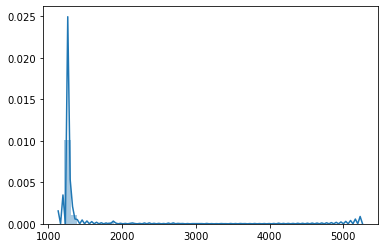

In [26]:
import seaborn as sns

s_lengths = []
for seq in protein_seqs:
    s_lengths.append(len(str(seq.seq)))
    
sns.distplot(s_lengths)

### Drop any sequence greater than the lengths

In [32]:
## 
column_thresholds = [75]
redundant_thresholds = [0.99]


files_to_run = []
for col_thresh in column_thresholds:
    for red_thresh in redundant_thresholds:
        name = f"col{col_thresh}_redund{red_thresh}"
        config = read_config_file(evc_template_f, preserve_order=True)
        config["align"]["input_alignment"] = msa_clean_f
        config["align"]["override_annotation_file"] = anno_f
        if target_seq == "":
            seqid = pd.read_csv(anno_f).iloc[100,0] #Just take any name
        else:
            seqid = target_seq
        print(seqid)
        config["align"]["sequence_id"] = seqid
        config["global"]["sequence_id"] = seqid
        config["global"]["sequence_file"] = msa_clean_f
        config["global"]["prefix"] = os.path.join(ev_dir, name)
        config["align"]["minimum_sequence_coverage"] = 0
        config["align"]["minimum_column_coverage"] = col_thresh
        config["align"]["theta"] = red_thresh
        config["global"]["theta"] = red_thresh
        out_f = join(ev_params_dir,name+".yaml")
        files_to_run.append(out_f)
        print(f"Creating file {out_f}")
        write_config_file(out_f, config)
        
run_evc(files_to_run,to_overwrite=True)

hCoV_19AnhuiSZ0052020_EPI_ISL_413485_2020_01_24
Creating file ../data/processed/ev_params/col75_redund0.99.yaml
../data/processed/ev_params/col75_redund0.99.yaml
../data/processed/evc/col75_redund0.99
{}
HI


/data2/isshamie/coevolve/software/EVcouplings/evcouplings/visualize/parameters.py:137: RuntimeWarning: divide by zero encountered in log2
  B = -fi * np.log2(fi)
/data2/isshamie/coevolve/software/EVcouplings/evcouplings/visualize/parameters.py:137: RuntimeWarning: invalid value encountered in multiply
  B = -fi * np.log2(fi)


## Make EVZoom htmls and move jsons

In [33]:
column_thresholds = [75]
redundant_thresholds = [0.99]

files_to_run = []
for col_thresh in column_thresholds:
    for red_thresh in redundant_thresholds:
        gene_of_interest = f"col{col_thresh}_redund{red_thresh}"
        print(gene_of_interest)
        #Copy over json
        coupling_prefix = os.path.join(ev_dir, gene_of_interest,"couplings",gene_of_interest)
        json_f = coupling_prefix + '_evzoom.json'
        out_json_f = evzoom_dir+"/data/" + os.path.basename(json_f)
        cmd = f'cp {json_f} {out_json_f}'
        print(cmd)
        os.system(cmd)
        
        # Create the html file
        tmp_html = join(evzoom_dir, 'example','evzoom.html')
        out_html = join(evzoom_dir, 'example',gene_of_interest+'.html')
        print(out_html)
        with open(tmp_html, "r") as f:
            page = f.read()
        new_page=""
        line = f'<div id="evzoom-viewer" data-couplings=../data/{basename(json_f)}> </div> '
        for i in page.split("\n"):
            if 'data-couplings' in i:
                new_page = new_page + line + "\n"
            else:
                new_page = new_page + i + "\n"
        new_page = new_page.strip("\n")
        with open(out_html,'w') as f:
            f.write(new_page)


col75_redund0.99
cp ../data/processed/evc/col75_redund0.99/couplings/col75_redund0.99_evzoom.json ../data/processed/evzoom/data/col75_redund0.99_evzoom.json
../data/processed/evzoom/example/col75_redund0.99.html


## After looking at the contact matrices, very little is different , so using column gap threshold= 75 and theta=0.9 parameters as the representative one
(ask for other parameters if desired)

In [34]:
col_thresh = 75
red_thresh = 0.99
name = f"col{col_thresh}_redund{red_thresh}"
new_name = "sars_cov2_S_protein"

name = f"col{col_thresh}_redund{red_thresh}"
print(name)
#Copy over json
coupling_prefix = os.path.join(ev_dir, name,"couplings",name)
json_f = coupling_prefix + '_evzoom.json'
out_json_f = evzoom_dir+"/data/" + os.path.basename(json_f).replace(name,new_name )

cmd = f'cp {json_f} {out_json_f}'
print(cmd)
os.system(cmd)

# Create the html file
tmp_html = join(evzoom_dir, 'example','evzoom.html')
out_html = join(evzoom_dir, 'example',new_name+'.html')
print(out_html)
with open(tmp_html, "r") as f:
    page = f.read()
new_page=""
line = f'<div id="evzoom-viewer" data-couplings=../data/{basename(out_json_f)}> </div> '
for i in page.split("\n"):
    if 'data-couplings' in i:
        new_page = new_page + line + "\n"
    else:
        new_page = new_page + i + "\n"
new_page = new_page.strip("\n")
with open(out_html,'w') as f:
    f.write(new_page)

            


col75_redund0.99
cp ../data/processed/evc/col75_redund0.99/couplings/col75_redund0.99_evzoom.json ../data/processed/evzoom/data/sars_cov2_S_protein_evzoom.json
../data/processed/evzoom/example/sars_cov2_S_protein.html


## Create contact matrix for cn and probability

In [36]:
## 
column_thresholds = [75]
redundant_thresholds = [0.99]

files_to_run = []

for col_thresh in column_thresholds:
    for red_thresh in redundant_thresholds:
        gene_of_interest = f"col{col_thresh}_redund{red_thresh}"
        print(gene_of_interest)
        align_prefix = os.path.join(ev_dir,gene_of_interest,"align",gene_of_interest)
        coupling_prefix = os.path.join(ev_dir, gene_of_interest,"couplings",gene_of_interest)

        construct_monomer_contact_matrix(gene_of_interest, 
                                         input_dir = ev_dir, 
                                         to_plot=True, 
                                         f_save_fig = join(contact_dir, gene_of_interest+"_pval"),
                                         f_save = join(contact_dir, gene_of_interest+"_pval"), 
                                         col='probability', conservation=True) 
        
        construct_monomer_contact_matrix(gene_of_interest, 
                                         input_dir = ev_dir, 
                                         to_plot=True, 
                                         f_save_fig = join(contact_dir, gene_of_interest),
                                         f_save = join(contact_dir, gene_of_interest), 
                                         col='cn', conservation=True) 


col75_redund0.99


100%|██████████| 24/24 [02:28<00:00,  4.53s/it]


plotting
../data/processed/evc/col75_redund0.99/align/col75_redund0.99*frequencies.csv


100%|██████████| 24/24 [02:24<00:00,  4.02s/it]


plotting
../data/processed/evc/col75_redund0.99/align/col75_redund0.99*frequencies.csv
